In [18]:
from valurap import path_planning
import imp
import seaborn as sns

imp.reload(path_planning)

%matplotlib notebook
import pandas as pd

import numpy as np
import matplotlib

import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
errors = []
solve = path_planning.solve_model_simple(0, 1370000-50000, 5000, 50, 300, errors)
solve
#df = pd.DataFrame(errors)
#hist = np.histogram2d(x=df["dj"], y=df["djj"], bins=19, weights=df["delta_v"]*df["delta_v"]+df["jerk"]*df["jerk"])
#hist = np.histogram2d(x=df["dj"], y=df["djj"], bins=19, weights=abs(df["jerk"]/250000))
#hist = np.histogram2d(x=df["dj"], y=df["djj"], bins=20*3*2+1, weights=abs(df["end_a"]/700000000) + abs(df["jerk"]/250000))
#print(hist[0])

#fig, ax = plt.subplots(figsize=(20, 10))
#im = ax.imshow(hist[0])
#cbar = fig.colorbar(im)

In [ ]:
# Fast to slow
# Trying to slow down individual segments until everything passes

from math import sqrt
from numpy import array, absolute, isnan
from numpy.linalg import norm

from valurap import printer, commands
from valurap.asg import Asg, ProfileSegment, PathSegment

path_deltas = [
    [100.0, 100.0, 200.0],
    [100.0, -100.0, 100.0],
    [100.0, -200.0, 200.0],
    [-150.0, -50.0, 150.0],
    [-150.0, 150.0, 150.0],
    [10.0, -200.0, 200.0],
    [50.0, 200.0, 200.0],
    [-60.0, 100.0, 200.0],
] * 3

path_deltas = [
    [120.0, -0.0, 250.0],
    [-0.0, 120.0, 250.0],
    [-120.0, 50.0, 250.0],
    [50.0, -120.0, 250.0],
    [-50.0, -50.0, 150.0],
] * 3

path_deltas = [
    [10, 250.0, 200.0],
    [1, 25.0, 50.0],
    [2, 0.0, 30.0],
    [-1, -25.0, 50.0],
    [-10, -250.0,  200.0],
    [-1, -25.0, 50.0],
    [-2, 0.0, 30.0],
    [1, 25.0, 50.0],
] * 10

 
path_deltas = []
l = 100
v = 500

for i in range(0, 5):
    k = 2 - 0.05 * i
    k2 = 2 - 0.05 * (i + 0.5)
    path_deltas.append([   k*l,      0, v])
    path_deltas.append([       0, -k*l, v * 0.7])
    path_deltas.append([ -k2*l,      0, v])
    path_deltas.append([       0, k2*l, v * 0.7])
    

path = []
x = 0
y = 0
for dx, dy, speed in path_deltas:
    x += dx
    y += dy
    path.append([x, y, speed])
        
path.append([x, y, 0])
    
print(path)

path_k = [1.0] * len(path)
attempts = 0
while True:
    plan_errors = []
    real_path = []
    for i, (x, y, speed) in enumerate(path):
        real_path.append((x, y, speed * path_k[i]))
        
    print(real_path)
    pr_opt = path_planning.plan_path([0, 0], real_path, fatal=False, plan_errors = plan_errors)
    if plan_errors:
        i, et, vals, target = plan_errors[0]
        print(plan_errors)
        if vals is None:
            raise RuntimeError("unknown error")
        min_val = min(abs(array(vals)))
        assert abs(min_val) < target
        k = abs(target/min_val) * 1.1
        adj_i = i
        adj_part = 0
        if et == "out_avail_exit":
            adj_i = i
            adj_part = 1
        elif et == "cur_avail_exit":
            adj_i = i
            adj_part = 1
        elif et == "in_avail_enter":
            adj_i = i - 1
            adj_part = 1
        elif et == "cur_avail_enter":
            adj_i = i
            adj_part = 0
        elif et == "middle_delta_in":
            adj_i = i - 1
            adj_part = 1
        elif et == "middle_delta_cur":
            adj_i = i
            adj_part = 0
        else:
            raise RuntimeError()

            
        print("adjust segment {} on {}/{} (min: {} target: {})".format(adj_i, k, et, min_val, target))
        if adj_i == 0:
            start_x = 0
            start_y = 0
        else:
            start_x, start_y, _ = path[adj_i -1]
        end_x, end_y, speed = path[adj_i]
            
        if abs(start_x - end_x) > 10:
            split_k = abs(5.0 / (end_x - start_x))
        elif abs(start_y - end_y) > 10:
            split_k = abs(5.0 / (end_y - start_y))
        else:
            split_k = None
            
        if split_k is not None:
            if adj_part == 1:
                split_k = 1 - split_k

            split_x = start_x + (end_x - start_x) * split_k
            split_y = start_y + (end_y - start_y) * split_k
            print("before path", path)
            print("before path_k", path_k)
            path = path[:adj_i] + [[split_x, split_y, speed], [end_x, end_y, speed]] + path[adj_i + 1:]
            path_k = path_k[:adj_i + 1] + path_k[adj_i:]
            adj_i = adj_i + adj_part
            print("after path", path)
            print("after path_k", path_k)
            
        path_k[adj_i] = path_k[adj_i] / k
        print("new path_k", path_k)
        attempts += 1
        if attempts == len(path) * 3:
            break
    else:
        break

import warnings
warnings.filterwarnings("error")

steps_opt = path_planning.emulate(pr_opt, 0)
steps_opt = pd.DataFrame(steps_opt)

print(plan_errors)
print(path_k)



In [263]:
# Slow first
#
# Slow down full path until passes
# then speed up individul segments

from math import sqrt
from numpy import array, absolute, isnan
from numpy.linalg import norm

from valurap import printer, commands
from valurap.asg import Asg, ProfileSegment, PathSegment

path_deltas = [
    [100.0, 100.0, 200.0],
    [100.0, -100.0, 100.0],
    [100.0, -200.0, 200.0],
    [-150.0, -50.0, 150.0],
    [-150.0, 150.0, 150.0],
    [10.0, -200.0, 200.0],
    [50.0, 200.0, 200.0],
    [-60.0, 100.0, 200.0],
] * 3

path_deltas = [
    [120.0, -0.0, 250.0],
    [-0.0, 120.0, 250.0],
    [-120.0, 50.0, 250.0],
    [50.0, -120.0, 250.0],
    [-50.0, -50.0, 150.0],
] * 3

path_deltas = [
    [10, 250.0, 200.0],
    [1, 25.0, 50.0],
    [2, 0.0, 30.0],
    [-1, -25.0, 50.0],
    [-10, -250.0,  200.0],
    [-1, -25.0, 50.0],
    [-2, 0.0, 30.0],
    [1, 25.0, 50.0],
] * 10

 
path_deltas = []
l = 100
v = 300

for i in range(0, 5):
    k = 2 - 0.05 * i
    k2 = 2 - 0.05 * (i + 0.5)
    path_deltas.append([   k*l,      0, v])
    path_deltas.append([       3, -k*l/2, v])
    path_deltas.append([       -3, -k*l/2, v])
    path_deltas.append([ -k2*l,      0, v])
    path_deltas.append([       0, k2*l, v])
    

path = []
x = 0
y = 0
for dx, dy, speed in path_deltas:
    x += dx
    y += dy
    path.append([x, y, speed])
        
path.append([x, y, 0])
    
print(path)

max_middle_delta = 0.2

path_k = [1.0] * len(path)
attempts = 0
while True:
    plan_errors = []
    plan_notes = {}
    real_path = []
    for i, (x, y, speed) in enumerate(path):
        real_path.append((x, y, speed * path_k[i]))
        
    print(real_path)
    pr_opt = path_planning.plan_path([0, 0], real_path, fatal=False, plan_errors=plan_errors, plan_notes=plan_notes, max_middle_delta=max_middle_delta)
    if plan_errors:
        i, et, vals, target = plan_errors[0]
        print(plan_errors)
        if vals is None:
            raise RuntimeError("unknown error")
        min_val = min(abs(array(vals)))
        assert abs(min_val) < target
        k = abs(target/min_val) * 1.1
        
        if et == "middle_delta":
            k = sqrt(k)
        
        for i in range(len(path)):
            path_k[i] = path_k[i] / k
        print("new path_k", path_k)
        attempts += 1
        if attempts == len(path) * 3:
            break
    else:
        break

import warnings
warnings.filterwarnings("error")

steps_opt = path_planning.emulate(pr_opt, 0)
steps_opt = pd.DataFrame(steps_opt)

print(plan_errors)
print(path_k)


[[200.0, 0, 300], [203.0, -100.0, 300], [200.0, -200.0, 300], [2.5, -200.0, 300], [2.5, -2.5, 300], [197.5, -2.5, 300], [200.5, -100.0, 300], [197.5, -197.5, 300], [5.0, -197.5, 300], [5.0, -5.0, 300], [195.0, -5.0, 300], [198.0, -100.0, 300], [195.0, -195.0, 300], [7.5, -195.0, 300], [7.5, -7.5, 300], [192.5, -7.5, 300], [195.5, -100.0, 300], [192.5, -192.5, 300], [10.0, -192.5, 300], [10.0, -10.0, 300], [190.0, -10.0, 300], [193.0, -100.0, 300], [190.0, -190.0, 300], [12.5, -190.0, 300], [12.5, -12.5, 300], [12.5, -12.5, 0]]
[(200.0, 0, 300.0), (203.0, -100.0, 300.0), (200.0, -200.0, 300.0), (2.5, -200.0, 300.0), (2.5, -2.5, 300.0), (197.5, -2.5, 300.0), (200.5, -100.0, 300.0), (197.5, -197.5, 300.0), (5.0, -197.5, 300.0), (5.0, -5.0, 300.0), (195.0, -5.0, 300.0), (198.0, -100.0, 300.0), (195.0, -195.0, 300.0), (7.5, -195.0, 300.0), (7.5, -7.5, 300.0), (192.5, -7.5, 300.0), (195.5, -100.0, 300.0), (192.5, -192.5, 300.0), (10.0, -192.5, 300.0), (10.0, -10.0, 300.0), (190.0, -10.0, 300

avails: prev [ -2.99369423 -99.97467611] current [-197.5    0. ] next [ 0.   98.75]
enter_delta_v: [-52.04728275  53.62444216]
enter_time: 0.02681222107780989
enter_a: [-1941.17759194  2000.        ]
enter_delta_x: [-0.74086821 -0.7188952 ]
enter_t_first: [0.01340611 0.01340611]
enter_t_second: [0.01340611 0.01340611]
enter_need_first: [-0.02155829 -0.71889519]
enter_need_second: [-0.7193099  0.       ]
exit_delta_v: [53.65537711 53.65537738]
exit_time: 0.02682768869006331
exit_a: [1999.92544281 1999.92545293]
exit_delta_x: [-0.7197517   0.71969805]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.71975169  0.        ]
exit_need_second: [0.         0.71969807]
cur_target: [   2.5 -200. ]
decel_end: [   2.5        -199.28030193]
decel_start: [   3.21975169 -200.        ]
accel_start: [ 200.01720729 -199.28097443]
target_x: [-196.7974556    -0.71902557]
args_x: {'in_v': -11051, 'target_v': -368717, 'target_x': -15744, 'accel_t': 27, 'plato

      fun: 0.00656587113370669
 hess_inv: array([[ 9.23287902e-01, -1.71260792e-04],
       [-1.71260792e-04,  7.40391597e-08]])
      jac: array([ 0.0004332 , -0.00614274])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 365
      nit: 7
     njev: 89
   status: 2
  success: False
        x: array([-1.83352501,  1.94231325])
old -198905800 14733763
new -195258812 15019939
sol_x: {'accel_j': 193955642, 'accel_jj': -14919683, 'plato_v': 368835.3173675537, 'accel_x': 54.264116080560136, 'accel_middle_x': 7.9587430453997845, 'plato_x': 15092.735883627916}
sol_y: {'accel_j': -195258812, 'accel_jj': 15019939, 'plato_v': -80.16801452636719, 'accel_x': 61.28047386333434, 'accel_middle_x': 47.79589272505546, 'plato_x': -3.280474001776667}
non straigh factor: 31.432415477414608
i: 10

x: in [ 5.62731563 -4.95388599] in_target [195.          -4.95388599] cur_target [ 198. -100.]
speeds: prev [53.67260272  0.        ] current [  1.69271526 -53.62866935] next 

decel_end: [192.52331703  -8.2189418 ]
decel_start: [191.78062651  -7.5       ]
accel_start: [ 7.45753746 -8.21977245]
target_x: [184.32308905   0.71977245]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 14746, 'accel_t': 27, 'plato_t': 3422}
      fun: 0.0039350579146325455
 hess_inv: array([[0.00726326, 0.0066311 ],
       [0.0066311 , 0.00994863]])
      jac: array([ 0.00214113, -0.00614226])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 347
      nit: 10
     njev: 84
   status: 2
  success: False
        x: array([-2.52232028,  1.22692491])
old 198882608 -14732045
new 193866152 -14912796
cur_target: [192.5  -7.5]
args_y: {'in_v': 368729, 'target_v': 0, 'target_x': 58, 'accel_t': 27, 'plato_t': 3422}
      fun: 0.008630529867404018
 hess_inv: array([[ 0.01133121, -0.01024569],
       [-0.01024569,  0.00926819]])
      jac: array([0.01023831, 0.00456306])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev

x: in [10.64326458 -9.95730547] in_target [190.          -9.95730547] cur_target [ 193. -100.]
speeds: prev [53.66128374  0.        ] current [  1.78667314 -53.62562127] next [ -1.78751979 -53.62559365]
avails: prev [ 1.79356735e+02 -4.26945317e-02] current [  3.         -90.04269453] next [ -1.5 -45. ]
enter_delta_v: [-51.8746106  -53.62562127]
enter_time: 0.02681281063681575
enter_a: [-1934.69499705 -2000.        ]
enter_delta_x: [ 0.74335778 -0.71892681]
enter_t_first: [0.01340641 0.01340641]
enter_t_second: [0.01340641 0.01340641]
enter_need_first: [0.71940493 0.        ]
enter_need_second: [ 0.02395286 -0.7189268 ]
exit_delta_v: [-3.57419293  0.        ]
exit_time: 0.0011913976430062568
exit_a: [-2997.48406078     0.        ]
exit_delta_x: [ 1.28125053e-06 -6.38894388e-02]
exit_t_first: [0.0005962 0.       ]
exit_t_second: [0.0005952 0.       ]
exit_need_first: [ 0.00106521 -0.        ]
exit_need_second: [-0.00106393 -0.        ]
cur_target: [ 193. -100.]
decel_end: [ 192.99893607

        x: array([-1.42150052,  2.37301518])
old 198882608 -14732045
new 196055491 -15081639
sol_x: {'accel_j': 195663063, 'accel_jj': -15051141, 'plato_v': 83.26022338867188, 'accel_x': -61.19473542778308, 'accel_middle_x': -47.7923334196717, 'plato_x': 3.1947355751071878}
sol_y: {'accel_j': 196055491, 'accel_jj': -15081639, 'plato_v': 367239.2431488037, 'accel_x': 54.85026596918629, 'accel_middle_x': 8.044853412947361, 'plato_x': 14091.149734082363}
non straigh factor: 31.436071427795767
i: 24

x: in [  12.45504166 -189.36367233] in_target [ 12.45504166 -12.5       ] cur_target [ 12.45504166 -12.5       ]
speeds: prev [ 0.         53.44034335] current [0. 0.] next [0 0]
avails: prev [4.49583448e-02 1.76863672e+02] current [0. 0.] next [0 0]
enter_delta_v: [  0.         -53.44034335]
enter_time: 0.026720171674154965
enter_a: [    0. -2000.]
enter_delta_x: [0.         0.71396757]
enter_t_first: [0.         0.01336009]
enter_t_second: [0.02672017 0.01336009]
enter_need_first: [0.       

[0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973, 0.10696128534865973]


<IPython.core.display.Javascript object>


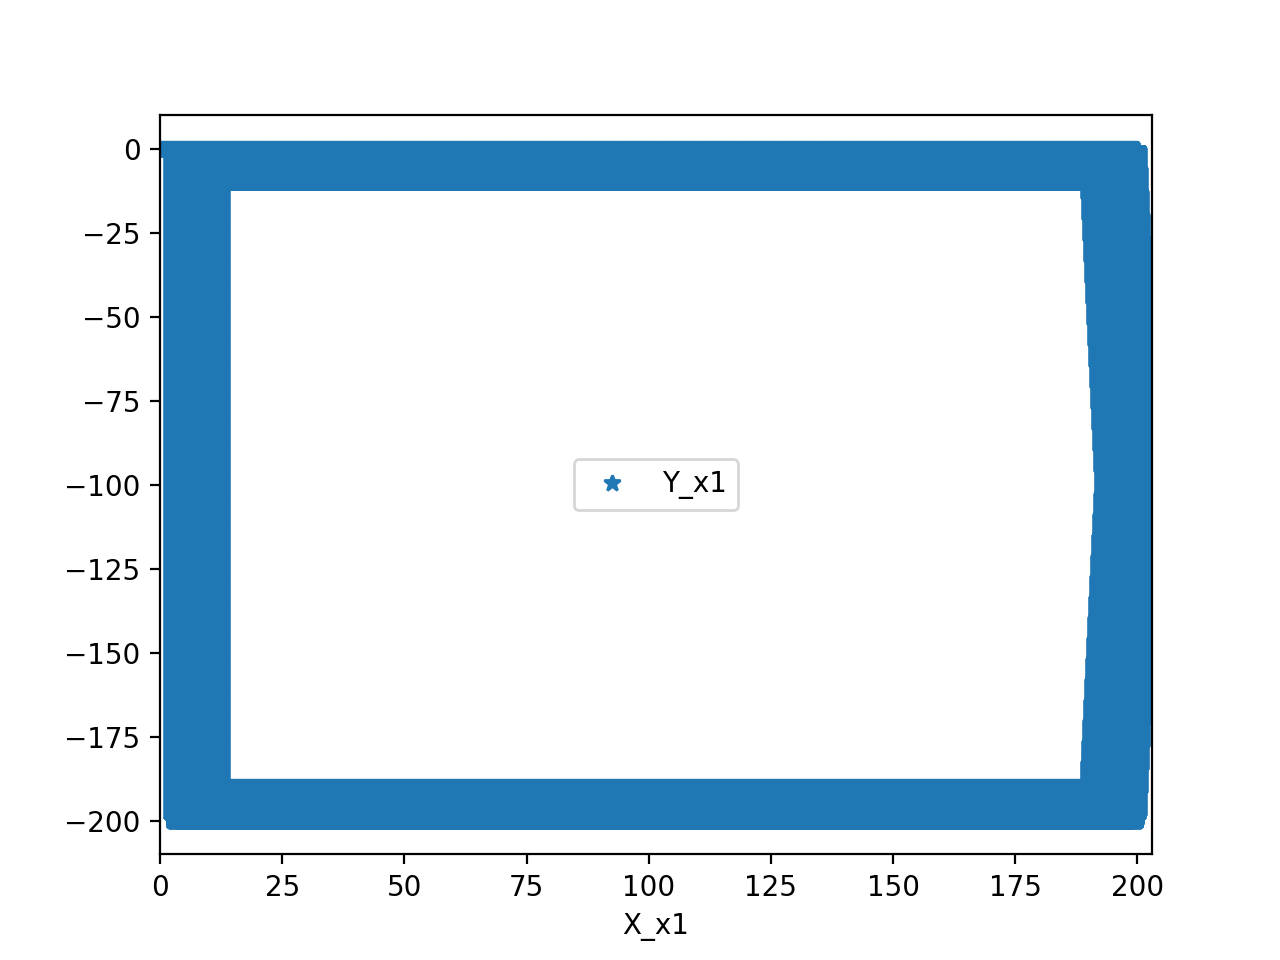

In [217]:
%matplotlib notebook
print(path_k)
#steps_opt.plot(x = steps_opt["X_x"]/80, y = steps_opt["Y_x"]/80, style="*")

#steps_opt.plot(x = "ts", y = ["X_a", "Y_a"], style="*")
#steps_opt.plot(x = "ts", y = ["X_v", "Y_v"], style="*")
#steps_opt.plot(x = "ts", y = ["X_x", "Y_x"], style="*")
if 1:
    steps_opt["X_x1"] = steps_opt["X_x"]/80
    steps_opt["Y_x1"] = steps_opt["Y_x"]/80

    steps_opt.plot(x = "X_x1", y = "Y_x1", style="*")

#code = p.asg.gen_path_code(pr_opt)
#print(len(code))
#print(code)
            

In [268]:
#print(plan_notes)
corner_speed_ups = {}
for corner in range(len(path)-1):
    seg1 = path[corner]
    seg2 = path[corner + 1]
    seg1_notes = plan_notes[corner]
    seg2_notes = plan_notes[corner + 1]
    seg1_dets = seg1_notes["path_details"]
    seg2_dets = seg2_notes["path_details"]
    middle_delta = seg1_notes.get("middle_delta", None)
    if middle_delta is not None and middle_delta[0] < middle_delta[1] / 2:
        print("Corner middle: {} {}".format(corner, middle_delta))
        speed_up = sqrt(middle_delta[1]/middle_delta[0] * 0.9)
        plato1 = norm(seg1_dets["plato_end"] - seg1_dets["plato_start"])
        plato2 = norm(seg2_dets["plato_end"] - seg2_dets["plato_start"])
        if plato1 > 5 and plato2 > 5:
            print("Corner is good to speed up: {} {} {} {}".format(corner, plato1, plato2, speed_up))
            corner_speed_ups[corner] = speed_up
            
speed_path = path[:]
speed_path_k = path_k[:]
speed_plan_notes = plan_notes.copy()

do_repeat = True
start_from = 0

while do_repeat:
    if start_from >= len(speed_path):
        break
        
    for plato in range(start_from, len(speed_path)):
        start_from = plato + 1
        
        seg = speed_path[plato]
        seg_notes = speed_plan_notes[plato]
        seg_dets = seg_notes["path_details"]
        plato_len = norm(seg_dets["plato_end"] - seg_dets["plato_start"])
        if plato_len > 15 and speed_path_k[plato] < 0.8:
            print("Plato is good to speed up: {} {}".format(plato, plato_len))
            e_x, e_y, speed = seg
            if plato > 0:
                x, y, _ = speed_path[plato - 1]
            else:
                x, y = 0, 0
                
            start = array([x, y])
            end = array([e_x, e_y])
            seg_vector = (end - start) / norm(end-start)

            # Split plato into 3 parts: 1 + 2 + 1
            p1_offset = norm(seg_dets["plato_start"] - start)
            p2_offset = norm(end - seg_dets["plato_end"])
            split = norm(seg_dets["plato_end"] - seg_dets["plato_start"]) / 4

            p1 = start + seg_vector * (p1_offset + split)
            p2 = end - seg_vector * (p2_offset + split)

            try_path = (
                speed_path[:plato] 
                + [
                    [p1[0], p1[1], speed],
                    [p2[0], p2[1], speed],
                    [e_x, e_y, speed]
                ]
                + speed_path[plato + 1:]
            )

            try_path_k = (
                speed_path_k[:plato] 
                + [speed_path_k[plato], 1.0, speed_path_k[plato]]
                + speed_path_k[plato + 1:]
            )

            try_plan_errors = []
            try_plan_notes = {}
            try_real_path = []
            for i, (x, y, speed) in enumerate(try_path):
                try_real_path.append((x, y, speed * try_path_k[i]))

            print(try_path)
            print(try_path_k)
            print(try_real_path)
            opt_pr_opt = path_planning.plan_path([0, 0], try_real_path, fatal=False, plan_errors=try_plan_errors, plan_notes=try_plan_notes, max_middle_delta=max_middle_delta)
            if try_plan_errors:
                print(try_plan_errors)
                print("First try failed")
                continue
                
            enter_seg = try_plan_notes[plato]
            plato_seg = try_plan_notes[plato+1]
            exit_seg = try_plan_notes[plato+2]

            enter_plato_len = norm(enter_seg["path_details"]["plato_end"] - enter_seg["path_details"]["plato_start"])
            if enter_plato_len > 5:
                enter_split = split - enter_plato_len + 5
            else:
                enter_split = split

            exit_plato_len = norm(exit_seg["path_details"]["plato_end"] - exit_seg["path_details"]["plato_start"])
            if exit_plato_len > 5:
                exit_split = split - exit_plato_len + 5
            else:
                exit_split = split

            p1 = start + seg_vector * (p1_offset + enter_split)
            p2 = end - seg_vector * (p2_offset + exit_split)

            e_x, e_y, speed = seg

            try_path = (
                speed_path[:plato] 
                + [
                    [p1[0], p1[1], speed],
                    [p2[0], p2[1], speed],
                    [e_x, e_y, speed]
                ]
                + speed_path[plato + 1:]
            )

            try_path_k = (
                speed_path_k[:plato] 
                + [speed_path_k[plato], 1.0, speed_path_k[plato]]
                + speed_path_k[plato + 1:]
            )

            try_plan_errors = []
            try_plan_notes = {}
            try_real_path = []
            for i, (x, y, speed) in enumerate(try_path):
                try_real_path.append((x, y, speed * try_path_k[i]))

            print(try_path)
            print(try_path_k)
            print(try_real_path)

            opt_pr_opt = path_planning.plan_path([0, 0], try_real_path, fatal=False, plan_errors=try_plan_errors, plan_notes=try_plan_notes, max_middle_delta=max_middle_delta)
            if try_plan_errors:
                print(try_plan_errors)
                print("Second try failed")
                continue
             
            speed_path = try_path[:]
            speed_path_k = try_path_k[:]
            speed_plan_notes = try_plan_notes.copy()
            start_from = max(start_from, plato + 3)
            break
            



            
    

Plato is good to speed up: 0 198.8405955825254
[[50.15012525348466, 0.0, 300], [149.57042304474737, 0.0, 300], [200.0, 0, 300], [203.0, -100.0, 300], [200.0, -200.0, 300], [2.5, -200.0, 300], [2.5, -2.5, 300], [197.5, -2.5, 300], [200.5, -100.0, 300], [197.5, -197.5, 300], [5.0, -197.5, 300], [5.0, -5.0, 300], [195.0, -5.0, 300], [198.0, -100.0, 300], [195.0, -195.0, 300], [7.5, -195.0, 300], [7.5, -7.5, 300], [192.5, -7.5, 300], [195.5, -100.0, 300], [192.5, -192.5, 300], [10.0, -192.5, 300], [10.0, -10.0, 300], [190.0, -10.0, 300], [193.0, -100.0, 300], [190.0, -190.0, 300], [12.5, -190.0, 300], [12.5, -12.5, 300], [12.5, -12.5, 0]]
[0.17885125793375542, 1.0, 0.17885125793375542, 0.17885125793375542, 0.17885125793375542, 0.17885125793375542, 0.17885125793375542, 0.17885125793375542, 0.17885125793375542, 0.17885125793375542, 0.17885125793375542, 0.17885125793375542, 0.17885125793375542, 0.17885125793375542, 0.17885125793375542, 0.17885125793375542, 0.17885125793375542, 0.1788512579337

      fun: 0.021933744987000202
 hess_inv: array([[0.03788017, 0.        ],
       [0.        , 1.        ]])
      jac: array([-1.52969733e-07,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 6
     njev: 21
   status: 0
  success: True
        x: array([-100.00000002,    0.        ])
old -8627159040 17254318080
new 1 17254318080
cur_target: [ 200. -200.]
args_y: {'in_v': -368732, 'target_v': -368551, 'target_x': -7945, 'accel_t': 1, 'plato_t': 1851}
      fun: 0.7117209979326843
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 71172096 -142344192
new 71172096 -142344192
sol_x: {'accel_j': 1, 'accel_jj': 17254318080, 'plato_v': -11050.744094848633, 'accel_x': 0.12669479474425316, 'accel_middle_x': 0.0, 'plato_x': -238.12669468536993}
sol_y: {'accel_j': 71172096, 'accel_jj'

        x: array([-1.53403558,  2.25337644])
old -198788756 14725093
new -195739266 15056905
sol_x: {'accel_j': -190375551, 'accel_jj': 14644305, 'plato_v': 11151.897674560547, 'accel_x': 62.665557918784025, 'accel_middle_x': 48.00535227094115, 'plato_x': 234.33444209608464}
sol_y: {'accel_j': -195739266, 'accel_jj': 15056905, 'plato_v': -368783.59211730957, 'accel_x': -54.76306879970138, 'accel_middle_x': -8.031929432839036, 'plato_x': -7749.236931229752}
non straigh factor: 30.277411417413745
i: 8

x: in [197.56373388  -3.13411299] in_target [ 200.5 -100. ] cur_target [ 197.5 -197.5]
speeds: prev [  1.6228147 -53.6650757] current [ -1.65015372 -53.62999586] next [-53.65537738   0.        ]
avails: prev [  2.93626612 -96.86588701] current [ -3.  -97.5] next [-96.25   0.  ]
enter_delta_v: [-3.27296841  0.03507985]
enter_time: 0.0010909894715310493
enter_a: [-3000.           32.1541557]
enter_delta_x: [-1.49132930e-05 -5.85288967e-02]
enter_t_first: [0.00054549 0.00054548]
enter_t_secon

x: in [ 5.62731563 -4.95388599] in_target [195.          -4.95388599] cur_target [ 198. -100.]
speeds: prev [53.67260272  0.        ] current [  1.69271526 -53.62866935] next [ -1.69353613 -53.628644  ]
avails: prev [ 1.89372684e+02 -4.61140126e-02] current [  3.         -95.04611401] next [ -1.5 -47.5]
enter_delta_v: [-51.97988745 -53.62866935]
enter_time: 0.026814334675165797
enter_a: [-1938.51117622 -2000.        ]
enter_delta_x: [ 0.74229208 -0.71900854]
enter_t_first: [0.01340717 0.01340717]
enter_t_second: [0.01340717 0.01340717]
enter_need_first: [0.71959758 0.        ]
enter_need_second: [ 0.02269452 -0.71900853]
exit_delta_v: [-3.38625139  0.        ]
exit_time: 0.0011287504637038307
exit_a: [-2997.34454634     0.        ]
exit_delta_x: [ 1.22835314e-06 -6.05333854e-02]
exit_t_first: [0.00056487 0.        ]
exit_t_second: [0.00056388 0.        ]
exit_need_first: [ 0.00095617 -0.        ]
exit_need_second: [-0.00095494 -0.        ]
cur_target: [ 198. -100.]
decel_end: [ 197.999

      fun: 0.009694356561090816
 hess_inv: array([[ 8.77372878e-02, -3.05631646e-06],
       [-3.05631646e-06,  3.69076775e-07]])
      jac: array([-0.00243134,  0.00755096])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 424
      nit: 9
     njev: 103
   status: 2
  success: False
        x: array([-1.03281457,  2.77399843])
old 198882608 -14732045
new 196828519 -15140712
sol_x: {'accel_j': 196320965, 'accel_jj': -15101624, 'plato_v': 73.79336547851562, 'accel_x': -60.98010604471681, 'accel_middle_x': -47.75079268348747, 'plato_x': 2.9801063337941964}
sol_y: {'accel_j': 196828519, 'accel_jj': -15140712, 'plato_v': 368729.12644958496, 'accel_x': 55.06775879293712, 'accel_middle_x': 8.076623344166478, 'plato_x': 14890.932241147502}
non straigh factor: 31.431987965255573
i: 16

x: in [   7.45753746 -194.35646046] in_target [ 7.45753746 -7.5       ] cur_target [192.5  -7.5]
speeds: prev [ 0.        53.6571499] current [53.65537709  0.        ] next 

      fun: 0.008217036782709488
 hess_inv: array([[315.20613718, 325.64019797],
       [325.64019797, 336.43174257]])
      jac: array([-0.02006321,  0.0221105 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 503
      nit: 6
     njev: 123
   status: 2
  success: False
        x: array([-1.35023446,  2.44472891])
old -192434198 14254385
new -189835885 14602866
cur_target: [  10.  -192.5]
args_y: {'in_v': -368534, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3375}
      fun: 0.006377674406634554
 hess_inv: array([[ 0.03746859, -0.0285981 ],
       [-0.0285981 ,  1.2043291 ]])
      jac: array([-0.07913427, -0.0060876 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 343
      nit: 2
     njev: 83
   status: 2
  success: False
        x: array([-1.89332552,  1.88166843])
old 198783909 -14724734
new 195020283 -15001805
sol_x: {'accel_j': -189835885, 'accel_jj': 14602866, 'plato_v': -368721.5057220

non straigh factor: 30.17923005557185
i: 23

x: in [190.074541 -10.639279] in_target [ 193. -100.] cur_target [ 190. -190.]
speeds: prev [  1.75288533 -53.66698286] current [ -1.78751977 -53.62559306] next [-53.65537738   0.        ]
avails: prev [  2.925459 -89.360721] current [ -3. -90.] next [-88.75   0.  ]
enter_delta_v: [-3.54040509  0.04138981]
enter_time: 0.001180135031471809
enter_a: [-3000.            35.07209272]
enter_delta_x: [-2.04366597e-05 -6.33098637e-02]
enter_t_first: [0.00059007 0.00059005]
enter_t_second: [0.00059007 0.00059008]
enter_need_first: [ 0.00103432 -0.03166638]
enter_need_second: [-0.00105476 -0.03164348]
exit_delta_v: [-51.86785761  53.62559306]
exit_time: 0.026812796529551448
exit_a: [-1934.37201458  1999.92541153]
exit_delta_x: [-0.74326363 -0.71895287]
exit_t_first: [0.0134069 0.0134069]
exit_t_second: [0.0134059 0.0134059]
exit_need_first: [-0.0239651  -0.71895286]
exit_need_second: [-0.71929852  0.        ]
cur_target: [ 190. -190.]
decel_end: [ 189

avails: prev [ -2.99831301 -99.97481374] current [-197.5    0. ] next [ 0.   98.75]
enter_delta_v: [-52.04728267  53.62444216]
enter_time: 0.02681222107780989
enter_a: [-1941.17758896  2000.        ]
enter_delta_x: [-0.74086821 -0.7188952 ]
enter_t_first: [0.01340611 0.01340611]
enter_t_second: [0.01340611 0.01340611]
enter_need_first: [-0.02155829 -0.71889519]
enter_need_second: [-0.7193099  0.       ]
exit_delta_v: [53.65537711 53.65537738]
exit_time: 0.02682768869006331
exit_a: [1999.92544281 1999.92545293]
exit_delta_x: [-0.7197517   0.71969805]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.71975169  0.        ]
exit_need_second: [0.         0.71969807]
cur_target: [   2.5 -200. ]
decel_end: [   2.5        -199.28030193]
decel_start: [   3.21975169 -200.        ]
accel_start: [ 200.02181765 -199.28111259]
target_x: [-196.80206596   -0.71888741]
args_x: {'in_v': -11051, 'target_v': -368717, 'target_x': -15744, 'accel_t': 27, 'plato

sol_x: {'accel_j': 1, 'accel_jj': 17688428544, 'plato_v': -11338.80062866211, 'accel_x': 0.1298263669013977, 'accel_middle_x': 0.0, 'plato_x': -238.12982642681388}
sol_y: {'accel_j': 94765056, 'accel_jj': -189530112, 'plato_v': -368581.8459777832, 'accel_x': -4.293210804462433, 'accel_middle_x': 0.0, 'plato_x': -7740.70678912011}
i: 9

x: in [ 200.49367136 -100.02460589] in_target [ 197.5 -197.5] cur_target [   5.  -197.5]
speeds: prev [ -1.65001266 -53.63571777] current [-53.6553771   0.       ] next [ 0.         53.65537738]
avails: prev [ -2.99367136 -97.47539411] current [-192.5    0. ] next [ 0.   96.25]
enter_delta_v: [-52.00536445  53.63571777]
enter_time: 0.02681785888691834
enter_a: [-1939.206432  2000.      ]
enter_delta_x: [-0.74158607 -0.71919756]
enter_t_first: [0.01340893 0.01340893]
enter_t_second: [0.01340893 0.01340893]
enter_need_first: [-0.0221249  -0.71919754]
enter_need_second: [-0.71946115  0.        ]
exit_delta_v: [53.6553771  53.65537738]
exit_time: 0.026827688

sol_x: {'accel_j': -187703399, 'accel_jj': 14438736, 'plato_v': 11413.285903930664, 'accel_x': 63.41781852459149, 'accel_middle_x': 48.11726864168974, 'plato_x': 233.5821816128458}
sol_y: {'accel_j': -195820119, 'accel_jj': 15063471, 'plato_v': -368869.54737854004, 'accel_x': -54.7846092091575, 'accel_middle_x': -8.03520312846473, 'plato_x': -7549.215390946173}
non straigh factor: 30.247809504689855
i: 13

x: in [195.07312515  -5.6386936 ] in_target [ 198. -100.] cur_target [ 195. -195.]
speeds: prev [  1.66085169 -53.67758384] current [ -1.69353611 -53.62864343] next [-53.65537738   0.        ]
avails: prev [  2.92687485 -94.3613064 ] current [ -3. -95.] next [-93.75   0.  ]
enter_delta_v: [-3.3543878  0.0489404]
enter_time: 0.001118129265994598
enter_a: [-3000.            43.76989701]
enter_delta_x: [-1.82727027e-05 -5.99911166e-02]
enter_t_first: [0.00055906 0.00055905]
enter_t_second: [0.00055906 0.00055908]
enter_need_first: [ 0.00092852 -0.03000863]
enter_need_second: [-0.0009468

enter_t_second: [0.01341429 0.01341429]
enter_need_first: [0.         0.71977245]
enter_need_second: [0.71974867 0.        ]
exit_delta_v: [-51.91611718 -53.62718058]
exit_time: 0.026813590289100735
exit_a: [-1936.11450407 -1999.92541374]
exit_delta_x: [ 0.74269051 -0.71894181]
exit_t_first: [0.0134073 0.0134073]
exit_t_second: [0.01340629 0.01340629]
exit_need_first: [0.71937349 0.        ]
exit_need_second: [ 0.02331703 -0.7189418 ]
cur_target: [192.5  -7.5]
decel_end: [192.52331703  -8.2189418 ]
decel_start: [191.78062651  -7.5       ]
accel_start: [ 7.45753746 -8.21977245]
target_x: [184.32308905   0.71977245]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 14746, 'accel_t': 27, 'plato_t': 3422}
      fun: 0.0039350579146325455
 hess_inv: array([[0.00726326, 0.0066311 ],
       [0.0066311 , 0.00994863]])
      jac: array([ 0.00214113, -0.00614226])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 347
      nit: 10
     njev: 84
   status: 2


enter_need_first: [-0.71973376  0.        ]
enter_need_second: [0.         0.71972489]
exit_delta_v: [ 53.65537738 -53.65537709]
exit_time: 0.026827688543099925
exit_a: [ 1999.92546389 -1999.92545293]
exit_delta_x: [0.71969805 0.7197517 ]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975171]
exit_need_second: [0.71969806 0.        ]
cur_target: [ 10. -10.]
decel_end: [ 10.71969806 -10.        ]
decel_start: [ 10.         -10.71975171]
accel_start: [  10.71973376 -192.54675117]
target_x: [ -0.71973376 181.82699945]
args_x: {'in_v': -368722, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3375}
      fun: 0.0081492455525241
 hess_inv: array([[0.18365573, 0.26003848],
       [0.26003848, 0.41585644]])
      jac: array([-0.01224152, -0.00613995])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 308
      nit: 4
     njev: 74
   status: 2
  success: False
        x: array([-1.42041

args_y: {'in_v': 367239, 'target_v': 0, 'target_x': 57, 'accel_t': 27, 'plato_t': -27}
      fun: 0.022863866747008035
 hess_inv: array([[0.30283211, 0.29643045],
       [0.29643045, 0.34144089]])
      jac: array([6.07727561e-05, 3.13040335e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 255
      nit: 6
     njev: 61
   status: 2
  success: False
        x: array([-2.47606343,  1.27510497])
old -198085392 14672992
new -193180672 14860088
sol_x: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
sol_y: {'accel_j': -193180672, 'accel_jj': 14860088, 'plato_v': 13946.947540283203, 'accel_x': 61.383823643268435, 'accel_middle_x': 47.650979531965724, 'plato_x': -4.383823643294704}
i: 27

Plato is good to speed up: 3 99.36333279800911
[[7.643037791291185, 0.0, 300], [191.79269620467994, 0.0, 300], [200.0, 0, 300], [200.76537904421963, -25.51263480732057, 300], [202.2550842298059, -75.1694743268631, 300], [

        x: array([-2.57341547,  1.17397184])
old -188226950 13942737
new -183383089 14106421
cur_target: [200.76537904 -25.51263481]
args_y: {'in_v': 0, 'target_v': -368551, 'target_x': -1777, 'accel_t': 27, 'plato_t': 401}
      fun: 0.006436114072334803
 hess_inv: array([[197.61037993, 205.35146025],
       [205.35146025, 213.41113703]])
      jac: array([ 0.09078138, -0.08678603])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 315
      nit: 9
     njev: 76
   status: 2
  success: False
        x: array([-1.79921837,  1.97625647])
old -198793076 14725413
new -195216354 15016425
sol_x: {'accel_j': -183383089, 'accel_jj': 14106421, 'plato_v': 10313.162689208984, 'accel_x': 61.85553281898847, 'accel_middle_x': 46.960336944046325, 'plato_x': 48.14446715606379}
sol_y: {'accel_j': -195216354, 'accel_jj': 15016425, 'plato_v': -368956.4196624756, 'accel_x': -54.61756854785448, 'accel_middle_x': -8.01050485836896, 'plato_x': -1722.3824314383405}
non str

      fun: 0.0063123630439814475
 hess_inv: array([[0.19616375, 0.18604545],
       [0.18604545, 0.19316386]])
      jac: array([0.00271154, 0.00036092])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 304
      nit: 5
     njev: 74
   status: 2
  success: False
        x: array([-1.89377327,  1.87968032])
old 198882608 -14732045
new 195116222 -15008960
cur_target: [197.5  -2.5]
args_y: {'in_v': 368805, 'target_v': 0, 'target_x': 58, 'accel_t': 27, 'plato_t': 3608}
      fun: 0.004144472127212878
 hess_inv: array([[0.07588943, 0.05630771],
       [0.05630771, 0.04949377]])
      jac: array([ 0.00019653, -0.00614197])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 348
      nit: 4
     njev: 84
   status: 2
  success: False
        x: array([-2.46530006,  1.28615469])
old -198930074 14735561
new -194025851 14925083
sol_x: {'accel_j': 195116222, 'accel_jj': -15008960, 'plato_v': 368819.8692626953, 'accel_x': 54.

      fun: 0.00637811044779609
 hess_inv: array([[0.12244491, 0.10859056],
       [0.10859056, 0.10987599]])
      jac: array([ 0.00488232, -0.00614358])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 331
      nit: 5
     njev: 80
   status: 2
  success: False
        x: array([-1.89213147,  1.88136563])
old 198882608 -14732045
new 195119488 -15009209
sol_x: {'accel_j': 193894300, 'accel_jj': -14914972, 'plato_v': 88.38436889648438, 'accel_x': -61.6650465921964, 'accel_middle_x': -47.85324537905921, 'plato_x': 3.6650467897914036}
sol_y: {'accel_j': 195119488, 'accel_jj': -15009209, 'plato_v': 368759.7248687744, 'accel_x': 54.58973441285763, 'accel_middle_x': 8.006500197588196, 'plato_x': 15291.410265287552}
non straigh factor: 31.432827930862743
i: 13

x: in [   4.94901418 -196.86436422] in_target [ 4.94901418 -5.        ] cur_target [195.  -5.]
speeds: prev [ 0.         53.66160256] current [53.6553771  0.       ] next [  1.69353613 -53.628644  

exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975171]
exit_need_second: [0.71969806 0.        ]
cur_target: [ 7.5 -7.5]
decel_end: [ 8.21969806 -7.5       ]
decel_start: [ 7.5        -8.21975171]
accel_start: [   8.21978879 -195.04480745]
target_x: [ -0.71978879 186.82505573]
args_x: {'in_v': -368750, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3469}
      fun: 0.00862425618194827
 hess_inv: array([[0.6029953 , 0.64684543],
       [0.64684543, 0.71428167]])
      jac: array([ 0.00718648, -0.00411385])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 343
      nit: 10
     njev: 83
   status: 2
  success: False
        x: array([-1.29685474,  2.49949595])
old 198900414 -14733364
new 196320965 -15101624
cur_target: [ 7.5 -7.5]
args_y: {'in_v': 0, 'target_v': 368717, 'target_x': 14946, 'accel_t': 27, 'plato_t': 3469}
      fun: 0.009694356561090816
 hess_inv: array([[ 8.77372878e-02, -3.05631646e-06],
       [-3.

      fun: 0.006377674406634554
 hess_inv: array([[ 0.03746859, -0.0285981 ],
       [-0.0285981 ,  1.2043291 ]])
      jac: array([-0.07913427, -0.0060876 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 343
      nit: 2
     njev: 83
   status: 2
  success: False
        x: array([-1.89332552,  1.88166843])
old 198783909 -14724734
new 195020283 -15001805
sol_x: {'accel_j': -189835885, 'accel_jj': 14602866, 'plato_v': -368721.5057220459, 'accel_x': -56.868945656596274, 'accel_middle_x': -9.598951209000006, 'plato_x': -14487.131054186086}
sol_y: {'accel_j': 195020283, 'accel_jj': -15001805, 'plato_v': 83.40101623535156, 'accel_x': -61.27684031707047, 'accel_middle_x': -47.771504893923115, 'plato_x': 3.276840199184505}
non straigh factor: 30.210710580030906
i: 22

x: in [ 191.80636023 -192.54675117] in_target [  10.         -192.54675117] cur_target [ 10. -10.]
speeds: prev [-53.65604094   0.        ] current [ 0.         53.65537709] next [53.655

        x: array([0., 0.])
old 112066560 -224133120
new 112066560 -224133120
sol_x: {'accel_j': 1, 'accel_jj': 19133890560, 'plato_v': -12241.701309204102, 'accel_x': 0.14023389667272568, 'accel_middle_x': 0.0, 'plato_x': -237.14023384400204}
sol_y: {'accel_j': 112066560, 'accel_jj': -224133120, 'plato_v': -368619.00817871094, 'accel_x': -4.293362144380808, 'accel_middle_x': 0.0, 'plato_x': -7140.706637983384}
i: 26

x: in [ 192.99399054 -100.02222066] in_target [ 190. -190.] cur_target [  12.5 -190. ]
speeds: prev [ -1.781402   -53.64112559] current [-53.65537708   0.        ] next [ 0.         53.65537738]
avails: prev [ -2.99399054 -89.97777934] current [-177.5    0. ] next [ 0.   88.75]
enter_delta_v: [-51.87397508  53.64112559]
enter_time: 0.02682056279290634
enter_a: [-1934.11210202  2000.        ]
enter_delta_x: [-0.74342281 -0.71934259]
enter_t_first: [0.01341028 0.01341028]
enter_t_second: [0.01341028 0.01341028]
enter_need_first: [-0.0238891  -0.71934258]
enter_need_second: [

exit_t_first: [0.01340831 0.01340831]
exit_t_second: [0.01340731 0.01340731]
exit_need_first: [0.71942798 0.        ]
exit_need_second: [ 0.02157153 -0.71905088]
cur_target: [200.   0.]
decel_end: [200.02157153  -0.71905088]
decel_start: [199.28057202   0.        ]
accel_start: [179.45389956   0.        ]
target_x: [19.82667246  0.        ]
args_x: {'in_v': 2063211, 'target_v': 368717, 'target_x': 1586, 'accel_t': 82, 'plato_t': 98}
      fun: 0.009057783723293295
 hess_inv: array([[ 3.01997204e-07, -1.48924533e-07],
       [-1.48924533e-07,  1.13065092e-06]])
      jac: array([ 0.00088131, -0.00021284])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 384
      nit: 15
     njev: 93
   status: 2
  success: False
        x: array([-0.5502607,  0.6775818])
old -99093105 2416905
new -98547835 2433282
cur_target: [200.   0.]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 82, 'plato_t': 98}
sol_x: {'accel_j': -98547835, 'accel_jj': 2433282

enter_delta_x: [-4.43828190e-05 -5.57318697e-02]
enter_t_first: [0.00052215 0.00052215]
enter_t_second: [0.00052215 0.00052214]
enter_need_first: [ 0.00079572 -0.0277286 ]
enter_need_second: [-0.0008401  -0.02800327]
exit_delta_v: [-52.04643993  53.63124821]
exit_time: 0.026815624104920697
exit_a: [-1940.82744085  1999.9254194 ]
exit_delta_x: [-0.74094752 -0.71910451]
exit_t_first: [0.01340831 0.01340831]
exit_t_second: [0.01340731 0.01340731]
exit_need_first: [-0.02157314 -0.7191045 ]
exit_need_second: [-0.71937438  0.        ]
cur_target: [ 200. -200.]
decel_end: [ 199.28062562 -200.        ]
decel_start: [ 200.02157314 -199.2808955 ]
accel_start: [202.99348261 -99.97243876]
target_x: [ -2.97190948 -99.30845674]
args_x: {'in_v': 10472, 'target_v': -11057, 'target_x': -238, 'accel_t': 1, 'plato_t': 1851}
      fun: 0.021522523039086628
 hess_inv: array([[0.03788779, 0.        ],
       [0.        , 1.        ]])
      jac: array([1.55763701e-07, 0.00000000e+00])
  message: 'Optimizati

cur_target: [ 200.5 -100. ]
decel_end: [ 200.49909337 -100.        ]
decel_start: [ 200.49909215 -100.        ]
accel_start: [196.78041444  -2.45352799]
target_x: [  3.71867772 -97.54647201]
args_x: {'in_v': 368820, 'target_v': 11334, 'target_x': 297, 'accel_t': 27, 'plato_t': 1805}
      fun: 0.00835065929054491
 hess_inv: array([[0.03565815, 0.02279896],
       [0.02279896, 0.03557116]])
      jac: array([0.00112058, 0.00197354])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 395
      nit: 13
     njev: 96
   status: 2
  success: False
        x: array([-1.27014883,  2.52737941])
old -192824712 14283312
new -190375551 14644305
cur_target: [ 200.5 -100. ]
args_y: {'in_v': 0, 'target_v': -368543, 'target_x': -7804, 'accel_t': 27, 'plato_t': 1805}
      fun: 0.007549493779492301
 hess_inv: array([[0.01205251, 0.00142349],
       [0.00142349, 0.00512759]])
      jac: array([-0.00167877, -0.00716323])
  message: 'Desired error not necessarily achiev

avails: prev [  2.92687485 -94.3613064 ] current [ -3. -95.] next [-93.75   0.  ]
enter_delta_v: [-3.3543878  0.0489404]
enter_time: 0.001118129265994598
enter_a: [-3000.            43.76989701]
enter_delta_x: [-1.82727027e-05 -5.99911166e-02]
enter_t_first: [0.00055906 0.00055905]
enter_t_second: [0.00055906 0.00055908]
enter_need_first: [ 0.00092852 -0.03000863]
enter_need_second: [-0.0009468  -0.02998249]
exit_delta_v: [-51.96184127  53.62864343]
exit_time: 0.026814321717483786
exit_a: [-1937.76684163  1999.92541577]
exit_delta_x: [-0.74204581 -0.71903466]
exit_t_first: [0.01340766 0.01340766]
exit_t_second: [0.01340666 0.01340666]
exit_need_first: [-0.02270636 -0.71903465]
exit_need_second: [-0.71933943  0.        ]
cur_target: [ 195. -195.]
decel_end: [ 194.28066057 -195.        ]
decel_start: [ 195.02270636 -194.28096535]
accel_start: [197.99186059 -99.97021476]
target_x: [ -2.96915423 -94.31075059]
args_x: {'in_v': 11413, 'target_v': -11638, 'target_x': -238, 'accel_t': 1, 'plat

      fun: 0.008630529867404018
 hess_inv: array([[ 0.01133121, -0.01024569],
       [-0.01024569,  0.00926819]])
      jac: array([0.01023831, 0.00456306])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 412
      nit: 11
     njev: 100
   status: 2
  success: False
        x: array([-1.29478833,  2.50183248])
old -198889088 14732525
new -196313895 15101108
sol_x: {'accel_j': 193866152, 'accel_jj': -14912796, 'plato_v': 368793.8786315918, 'accel_x': 54.23908874035987, 'accel_middle_x': 7.955071327359064, 'plato_x': 14691.76091110924}
sol_y: {'accel_j': -196313895, 'accel_jj': 15101108, 'plato_v': -74.69302368164062, 'accel_x': 60.97557012427756, 'accel_middle_x': 47.747908191198, 'plato_x': -2.975570119900794}
non straigh factor: 31.431111439749458
i: 19

x: in [ 8.13552607 -7.45757782] in_target [192.5         -7.45757782] cur_target [ 195.5 -100. ]
speeds: prev [53.66657259  0.        ] current [  1.73846344 -53.62720582] next [ -1.73925991 -53.

enter_a: [ 1999.3393607 -2000.       ]
enter_delta_x: [0.71996269 0.72020059]
enter_t_first: [0.01341828 0.01341828]
enter_t_second: [0.01341828 0.01341828]
enter_need_first: [0.        0.7202006]
enter_need_second: [0.7199627 0.       ]
exit_delta_v: [-51.86785729 -53.62559365]
exit_time: 0.026812796827306033
exit_a: [-1934.37198125 -1999.92541153]
exit_delta_x: [ 0.7433155  -0.71889926]
exit_t_first: [0.0134069 0.0134069]
exit_t_second: [0.0134059 0.0134059]
exit_need_first: [0.7193522 0.       ]
exit_need_second: [ 0.02396331 -0.71889925]
cur_target: [190. -10.]
decel_end: [190.02396331 -10.71889925]
decel_start: [189.2806478 -10.       ]
accel_start: [  9.95667814 -10.7202006 ]
target_x: [179.32396966   0.7202006 ]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 14346, 'accel_t': 27, 'plato_t': 3329}
      fun: 0.008707946190184319
 hess_inv: array([[0.42950644, 0.25773007],
       [0.25773007, 0.1759179 ]])
      jac: array([0.01124612, 0.0315392 ])
  message: 'Desired error n

i: 29

Plato is good to speed up: 6 99.29987990453608
[[7.643037791291185, 0.0, 300], [191.79269620467994, 0.0, 300], [200.0, 0, 300], [200.26950210403314, -8.983403467771636, 300], [202.74141472266504, -91.38049075550124, 300], [203.0, -100.0, 300], [202.2548053438167, -124.83982187277607, 300], [200.76598732315864, -174.46708922804487, 300], [200.0, -200.0, 300], [2.5, -200.0, 300], [2.5, -2.5, 300], [197.5, -2.5, 300], [200.5, -100.0, 300], [197.5, -197.5, 300], [5.0, -197.5, 300], [5.0, -5.0, 300], [195.0, -5.0, 300], [198.0, -100.0, 300], [195.0, -195.0, 300], [7.5, -195.0, 300], [7.5, -7.5, 300], [192.5, -7.5, 300], [195.5, -100.0, 300], [192.5, -192.5, 300], [10.0, -192.5, 300], [10.0, -10.0, 300], [190.0, -10.0, 300], [193.0, -100.0, 300], [190.0, -190.0, 300], [12.5, -190.0, 300], [12.5, -12.5, 300], [12.5, -12.5, 0]]
[0.17885125793375542, 1.0, 0.17885125793375542, 0.17885125793375542, 1.0, 0.17885125793375542, 0.17885125793375542, 1.0, 0.17885125793375542, 0.17885125793375542

exit_need_second: [ -0.55377243 -18.45908354]
cur_target: [ 202.25480534 -124.83982187]
decel_end: [ 201.70103291 -143.29890541]
decel_start: [ 202.35384987 -121.53833804]
accel_start: [202.99348261 -99.97243876]
target_x: [ -0.63963274 -21.56589928]
args_x: {'in_v': 10472, 'target_v': -11057, 'target_x': -51, 'accel_t': 1, 'plato_t': 401}
      fun: 0.021423231570066873
 hess_inv: array([[0.03773056, 0.        ],
       [0.        , 1.        ]])
      jac: array([-1.56462193e-07,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 5
     njev: 18
   status: 0
  success: True
        x: array([-100.00000002,    0.        ])
old -8465547264 16931094528
new 1 16931094528
cur_target: [ 202.25480534 -124.83982187]
args_y: {'in_v': -364935, 'target_v': -368551, 'target_x': -1725, 'accel_t': 1, 'plato_t': 401}
      fun: 14.218691034279688
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated succes

      fun: 0.0063123630439814475
 hess_inv: array([[0.19616375, 0.18604545],
       [0.18604545, 0.19316386]])
      jac: array([0.00271154, 0.00036092])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 304
      nit: 5
     njev: 74
   status: 2
  success: False
        x: array([-1.89377327,  1.87968032])
old 198882608 -14732045
new 195116222 -15008960
cur_target: [197.5  -2.5]
args_y: {'in_v': 368784, 'target_v': 0, 'target_x': 58, 'accel_t': 27, 'plato_t': 3608}
      fun: 0.006354199265246451
 hess_inv: array([[2.43559354, 2.33606435],
       [2.33606435, 2.25099198]])
      jac: array([-0.02687052,  0.02993864])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 399
      nit: 15
     njev: 97
   status: 2
  success: False
        x: array([-1.89080352,  1.88330624])
old -198918747 14734722
new -195157584 15012222
sol_x: {'accel_j': 195116222, 'accel_jj': -15008960, 'plato_v': 368819.8692626953, 'accel_x': 54

enter_need_second: [0.71980839 0.        ]
exit_delta_v: [-51.96184097 -53.628644  ]
exit_time: 0.02681432199959917
exit_a: [-1937.76681005 -1999.92541578]
exit_delta_x: [ 0.74209777 -0.71898105]
exit_t_first: [0.01340766 0.01340766]
exit_t_second: [0.01340666 0.01340666]
exit_need_first: [0.71939312 0.        ]
exit_need_second: [ 0.02270466 -0.71898104]
cur_target: [195.  -5.]
decel_end: [195.02270466  -5.71898104]
decel_start: [194.28060688  -5.        ]
accel_start: [ 4.94901418 -5.71989191]
target_x: [189.3315927    0.71989191]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 15147, 'accel_t': 27, 'plato_t': 3515}
      fun: 0.004066654175503601
 hess_inv: array([[0.01683545, 0.00429532],
       [0.00429532, 0.0037551 ]])
      jac: array([ 0.00052722, -0.00614061])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 336
      nit: 5
     njev: 81
   status: 2
  success: False
        x: array([-2.47732375,  1.27367442])
old 198882608 -14732045

new 196828519 -15140712
sol_x: {'accel_j': 196320965, 'accel_jj': -15101624, 'plato_v': 73.79336547851562, 'accel_x': -60.98010604471681, 'accel_middle_x': -47.75079268348747, 'plato_x': 2.9801063337941964}
sol_y: {'accel_j': 196828519, 'accel_jj': -15140712, 'plato_v': 368729.12644958496, 'accel_x': 55.06775879293712, 'accel_middle_x': 8.076623344166478, 'plato_x': 14890.932241147502}
non straigh factor: 31.431987965255573
i: 20

x: in [   7.45753746 -194.35646046] in_target [ 7.45753746 -7.5       ] cur_target [192.5  -7.5]
speeds: prev [ 0.        53.6571499] current [53.65537709  0.        ] next [  1.73925991 -53.62718058]
avails: prev [4.24625402e-02 1.86856460e+02] current [185.04246254   0.        ] next [  1.5  -46.25]
enter_delta_v: [ 53.65537709 -53.6571499 ]
enter_time: 0.026828574951620606
enter_a: [ 1999.93392071 -2000.        ]
enter_delta_x: [0.71974865 0.71977243]
enter_t_first: [0.01341429 0.01341429]
enter_t_second: [0.01341429 0.01341429]
enter_need_first: [0.      

enter_t_second: [0.01340641 0.01340641]
enter_need_first: [0.71940493 0.        ]
enter_need_second: [ 0.02395286 -0.7189268 ]
exit_delta_v: [-3.57419293  0.        ]
exit_time: 0.0011913976430062568
exit_a: [-2997.48406078     0.        ]
exit_delta_x: [ 1.28125053e-06 -6.38894388e-02]
exit_t_first: [0.0005962 0.       ]
exit_t_second: [0.0005952 0.       ]
exit_need_first: [ 0.00106521 -0.        ]
exit_need_second: [-0.00106393 -0.        ]
cur_target: [ 193. -100.]
decel_end: [ 192.99893607 -100.        ]
decel_start: [ 192.99893479 -100.        ]
accel_start: [189.28059507  -9.95730547]
target_x: [  3.71833972 -90.04269453]
args_x: {'in_v': 368758, 'target_v': 12278, 'target_x': 297, 'accel_t': 27, 'plato_t': 1665}
      fun: 0.0034312197795098327
 hess_inv: array([[16190.13347593, 16121.64005801],
       [16121.64005801, 16053.43682266]])
      jac: array([-0.15085077,  0.15481967])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 439
      ni

      fun: 0.022863866747008035
 hess_inv: array([[0.30283211, 0.29643045],
       [0.29643045, 0.34144089]])
      jac: array([6.07727561e-05, 3.13040335e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 255
      nit: 6
     njev: 61
   status: 2
  success: False
        x: array([-2.47606343,  1.27510497])
old -198085392 14672992
new -193180672 14860088
sol_x: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
sol_y: {'accel_j': -193180672, 'accel_jj': 14860088, 'plato_v': 13946.947540283203, 'accel_x': 61.383823643268435, 'accel_middle_x': 47.650979531965724, 'plato_x': -4.383823643294704}
i: 31

[[7.643037791291185, 0.0, 300], [191.79269620467994, 0.0, 300], [200.0, 0, 300], [200.26950210403314, -8.983403467771636, 300], [202.74141472266504, -91.38049075550124, 300], [203.0, -100.0, 300], [202.75025283696263, -108.32490543457861, 300], [200.27846553050514, -190.71781564982885, 300], [200.0, -200.0,

enter_delta_x: [  0.66278355 -21.86475914]
enter_t_first: [0.0617318  0.06173179]
enter_t_second: [0.06173178 0.06173179]
enter_need_first: [  0.56346105 -18.55400662]
enter_need_second: [ 0.09932256 -3.31075247]
exit_delta_v: [-3.21787474  0.        ]
exit_time: 0.0010726249127254888
exit_a: [-2997.20572803     0.        ]
exit_delta_x: [ 1.60733870e-06 -5.75262068e-02]
exit_t_first: [0.00053681 0.        ]
exit_t_second: [0.00053581 0.        ]
exit_need_first: [ 0.0008637 -0.       ]
exit_need_second: [-0.00086209 -0.        ]
cur_target: [ 203. -100.]
decel_end: [ 202.99913791 -100.        ]
decel_start: [ 202.9991363 -100.       ]
accel_start: [202.18181276 -72.82636711]
target_x: [  0.81732354 -27.17363289]
args_x: {'in_v': 62724, 'target_v': 11057, 'target_x': 65, 'accel_t': 123, 'plato_t': 98}
      fun: 0.007122652936224982
 hess_inv: array([[ 1553.63452014, -1391.61238445],
       [-1391.61238445,  1248.05762482]])
      jac: array([2.38945941e-05, 3.61966086e-05])
  message:

new 201959155 -16156755
sol_x: {'accel_j': -203630354, 'accel_jj': 16290443, 'plato_v': -368744.24000549316, 'accel_x': -54.006289311914195, 'accel_middle_x': -9.88656374314445, 'plato_x': -15689.993710490844}
sol_y: {'accel_j': 201959155, 'accel_jj': -16156755, 'plato_v': 78.89381408691406, 'accel_x': -57.35691570869505, 'accel_middle_x': -45.6545529386787, 'plato_x': 3.35691602071364}
non straigh factor: 29.774265232341037
i: 9

x: in [ 199.3454362  -200.04639547] in_target [   2.5        -200.04639547] cur_target [ 2.5 -2.5]
speeds: prev [-53.65934922   0.        ] current [ 0.         53.65537711] next [53.65537738  0.        ]
avails: prev [-1.96845436e+02  4.63954660e-02] current [  0.         197.54639547] next [97.5  0. ]
enter_delta_v: [53.65934922 53.65537711]
enter_time: 0.026827688554258818
enter_a: [2000.14805996 2000.        ]
enter_delta_x: [-0.71977815  0.71972487]
enter_t_first: [0.01341384 0.01341384]
enter_t_second: [0.01341384 0.01341384]
enter_need_first: [-0.71977

exit_need_first: [0.71939312 0.        ]
exit_need_second: [ 0.02270466 -0.71898104]
cur_target: [195.  -5.]
decel_end: [195.02270466  -5.71898104]
decel_start: [194.28060688  -5.        ]
accel_start: [ 4.94901418 -5.71989191]
target_x: [189.3315927    0.71989191]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 15147, 'accel_t': 27, 'plato_t': 3515}
      fun: 0.004066654175503601
 hess_inv: array([[0.01683545, 0.00429532],
       [0.00429532, 0.0037551 ]])
      jac: array([ 0.00052722, -0.00614061])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 336
      nit: 5
     njev: 81
   status: 2
  success: False
        x: array([-2.47732375,  1.27367442])
old 198882608 -14732045
new 193955642 -14919683
cur_target: [195.  -5.]
args_y: {'in_v': 368760, 'target_v': 0, 'target_x': 58, 'accel_t': 27, 'plato_t': 3515}
      fun: 0.00656587113370669
 hess_inv: array([[ 9.23287902e-01, -1.71260792e-04],
       [-1.71260792e-04,  7.40391597e-08]])
      j

avails: prev [ 1.84364474e+02 -4.24221792e-02] current [  3.         -92.54242218] next [ -1.5  -46.25]
enter_delta_v: [-51.92810915 -53.62720582]
enter_time: 0.026813602912008135
enter_a: [-1936.63303353 -2000.        ]
enter_delta_x: [ 0.74280432 -0.7189693 ]
enter_t_first: [0.0134068 0.0134068]
enter_t_second: [0.0134068 0.0134068]
enter_need_first: [0.7194971 0.       ]
enter_need_second: [ 0.02330723 -0.71896929]
exit_delta_v: [-3.47772335  0.        ]
exit_time: 0.0011592411163932372
exit_a: [-2997.41433056     0.        ]
exit_delta_x: [ 1.27571136e-06 -6.21668619e-02]
exit_t_first: [0.00058012 0.        ]
exit_t_second: [0.00057912 0.        ]
exit_need_first: [ 0.00100852 -0.        ]
exit_need_second: [-0.00100724 -0.        ]
cur_target: [ 195.5 -100. ]
decel_end: [ 195.49899276 -100.        ]
decel_start: [ 195.49899148 -100.        ]
accel_start: [191.7805029   -7.45757782]
target_x: [  3.71848858 -92.54242218]
args_x: {'in_v': 368794, 'target_v': 11947, 'target_x': 297, '

speeds: prev [53.66128374  0.        ] current [  1.78667314 -53.62562127] next [ -1.78751979 -53.62559365]
avails: prev [ 1.79356735e+02 -4.26945317e-02] current [  3.         -90.04269453] next [ -1.5 -45. ]
enter_delta_v: [-51.8746106  -53.62562127]
enter_time: 0.02681281063681575
enter_a: [-1934.69499705 -2000.        ]
enter_delta_x: [ 0.74335778 -0.71892681]
enter_t_first: [0.01340641 0.01340641]
enter_t_second: [0.01340641 0.01340641]
enter_need_first: [0.71940493 0.        ]
enter_need_second: [ 0.02395286 -0.7189268 ]
exit_delta_v: [-3.57419293  0.        ]
exit_time: 0.0011913976430062568
exit_a: [-2997.48406078     0.        ]
exit_delta_x: [ 1.28125053e-06 -6.38894388e-02]
exit_t_first: [0.0005962 0.       ]
exit_t_second: [0.0005952 0.       ]
exit_need_first: [ 0.00106521 -0.        ]
exit_need_second: [-0.00106393 -0.        ]
cur_target: [ 193. -100.]
decel_end: [ 192.99893607 -100.        ]
decel_start: [ 192.99893479 -100.        ]
accel_start: [189.28059507  -9.95730

        x: array([-2.47606343,  1.27510497])
old -198085392 14672992
new -193180672 14860088
sol_x: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
sol_y: {'accel_j': -193180672, 'accel_jj': 14860088, 'plato_v': 13946.947540283203, 'accel_x': 61.383823643268435, 'accel_middle_x': 47.650979531965724, 'plato_x': -4.383823643294704}
i: 31

Plato is good to speed up: 9 196.1256899975204
[[7.643037791291185, 0.0, 300], [191.79269620467994, 0.0, 300], [200.0, 0, 300], [200.26950210403314, -8.983403467771636, 300], [202.74141472266504, -91.38049075550124, 300], [203.0, -100.0, 300], [202.75025283696263, -108.32490543457861, 300], [200.27846553050514, -190.71781564982885, 300], [200.0, -200.0, 300], [150.31237150582726, -200.0, 300], [52.251174189461125, -200.0, 300], [2.5, -200.0, 300], [2.5, -2.5, 300], [197.5, -2.5, 300], [200.5, -100.0, 300], [197.5, -197.5, 300], [5.0, -197.5, 300], [5.0, -5.0, 300], [195.0, -5.0, 300], [198.0, -100.0, 300], [1

args_x: {'in_v': 62724, 'target_v': 11057, 'target_x': 65, 'accel_t': 123, 'plato_t': 98}
      fun: 0.007122652936224982
 hess_inv: array([[ 1553.63452014, -1391.61238445],
       [-1391.61238445,  1248.05762482]])
      jac: array([2.38945941e-05, 3.61966086e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 264
      nit: 2
     njev: 63
   status: 2
  success: False
        x: array([-0.20293897,  0.18185187])
old -1342852 21835
new -1340127 21875
cur_target: [ 203. -100.]
args_y: {'in_v': -2065422, 'target_v': -368551, 'target_x': -2174, 'accel_t': 123, 'plato_t': 98}
      fun: 0.005237460338031108
 hess_inv: array([[0.20355924, 0.41973098],
       [0.41973098, 0.91316271]])
      jac: array([-0.27020651, -0.01755781])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 311
      nit: 2
     njev: 75
   status: 2
  success: False
        x: array([-0.41142945,  0.40917249])
old 44103188 -717125
new 4392173

args_y: {'in_v': 0, 'target_v': 368717, 'target_x': 15746, 'accel_t': 27, 'plato_t': 3655}
      fun: 0.004653062012244868
 hess_inv: array([[7.84014228, 7.79070395],
       [7.79070395, 7.74495612]])
      jac: array([-0.10072646,  0.10375737])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 374
      nit: 11
     njev: 91
   status: 2
  success: False
        x: array([-2.35141062,  1.40579064])
old 198882608 -14732045
new 194206061 -14939147
sol_x: {'accel_j': 194989878, 'accel_jj': -14999251, 'plato_v': 90.33375549316406, 'accel_x': -60.84368328842515, 'accel_middle_x': -47.560395295853645, 'plato_x': 3.843683241022688}
sol_y: {'accel_j': 194206061, 'accel_jj': -14939147, 'plato_v': 368783.55250549316, 'accel_x': 54.33355073858336, 'accel_middle_x': 7.968993170415216, 'plato_x': 15691.666449508366}
non straigh factor: 31.36283326008234
i: 12

x: in [   2.45608366 -199.36813908] in_target [ 2.45608366 -2.5       ] cur_target [197.5  -2.5]
speeds

      fun: 0.00637811044779609
 hess_inv: array([[0.12244491, 0.10859056],
       [0.10859056, 0.10987599]])
      jac: array([ 0.00488232, -0.00614358])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 331
      nit: 5
     njev: 80
   status: 2
  success: False
        x: array([-1.89213147,  1.88136563])
old 198882608 -14732045
new 195119488 -15009209
sol_x: {'accel_j': 193894300, 'accel_jj': -14914972, 'plato_v': 88.38436889648438, 'accel_x': -61.6650465921964, 'accel_middle_x': -47.85324537905921, 'plato_x': 3.6650467897914036}
sol_y: {'accel_j': 195119488, 'accel_jj': -15009209, 'plato_v': 368759.7248687744, 'accel_x': 54.58973441285763, 'accel_middle_x': 8.006500197588196, 'plato_x': 15291.410265287552}
non straigh factor: 31.432827930862743
i: 17

x: in [   4.94901418 -196.86436056] in_target [ 4.94901418 -5.        ] cur_target [195.  -5.]
speeds: prev [ 0.         53.66160256] current [53.6553771  0.       ] next [  1.69353613 -53.628644  

      fun: 0.005152311484896251
 hess_inv: array([[0.1894815 , 0.19449272],
       [0.19449272, 0.20654595]])
      jac: array([ 0.00562832, -0.00613842])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 448
      nit: 18
     njev: 109
   status: 2
  success: False
        x: array([-2.12174423,  1.64287495])
old -192480044 14257781
new -188396110 14492019
cur_target: [ 195.5 -100. ]
args_y: {'in_v': 0, 'target_v': -368523, 'target_x': -7403, 'accel_t': 27, 'plato_t': 1712}
      fun: 0.006403747674662791
 hess_inv: array([[55.77971966, 58.02468733],
       [58.02468733, 60.36816929]])
      jac: array([ 0.10084242, -0.09779885])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 436
      nit: 14
     njev: 106
   status: 2
  success: False
        x: array([-1.86684691,  1.9058305 ])
old -198777969 14724294
new -195067089 15004914
sol_x: {'accel_j': -188396110, 'accel_jj': 14492019, 'plato_v': 11730.322372436523

        x: array([-1.28547418,  2.51218397])
old 198882608 -14732045
new 196326023 -15102141
cur_target: [190. -10.]
args_y: {'in_v': 368839, 'target_v': 0, 'target_x': 58, 'accel_t': 27, 'plato_t': 3329}
      fun: 0.008537081111772664
 hess_inv: array([[287.70913952, 285.9344625 ],
       [285.9344625 , 284.17397181]])
      jac: array([-0.12677066,  0.12977879])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 243
      nit: 9
     njev: 58
   status: 2
  success: False
        x: array([-1.36023249,  2.43696897])
old -198948420 14736920
new -196242259 15096054
sol_x: {'accel_j': 196326023, 'accel_jj': -15102141, 'plato_v': 368757.5339355469, 'accel_x': 54.926915056263674, 'accel_middle_x': 8.055993519029414, 'plato_x': 14291.073084709182}
sol_y: {'accel_j': -196242259, 'accel_jj': 15096054, 'plato_v': -78.2257080078125, 'accel_x': 61.03161054458183, 'accel_middle_x': 47.76755305755386, 'plato_x': -3.0316107668681975}
non straigh factor: 31.43578

exit_delta_v: [0. 0.]
exit_time: 0.0
exit_a: [0. 0.]
exit_delta_x: [0. 0.]
exit_t_first: [0. 0.]
exit_t_second: [0. 0.]
exit_need_first: [0. 0.]
exit_need_second: [0. 0.]
cur_target: [ 12.45504166 -12.5       ]
decel_end: [ 12.45504166 -12.5       ]
decel_start: [ 12.45504166 -12.5       ]
accel_start: [ 12.45504166 -13.21396759]
target_x: [0.         0.71396759]
args_x: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 27, 'plato_t': -27}
cur_target: [ 12.45504166 -12.5       ]
args_y: {'in_v': 367239, 'target_v': 0, 'target_x': 57, 'accel_t': 27, 'plato_t': -27}
      fun: 0.022863866747008035
 hess_inv: array([[0.30283211, 0.29643045],
       [0.29643045, 0.34144089]])
      jac: array([6.07727561e-05, 3.13040335e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 255
      nit: 6
     njev: 61
   status: 2
  success: False
        x: array([-2.47606343,  1.27510497])
old -198085392 14672992
new -193180672 14860088
sol_x: {'accel_j': 0, 'ac

enter_need_first: [ 0.00079572 -0.0277286 ]
enter_need_second: [-0.0008401  -0.02800327]
exit_delta_v: [  -7.38701546 -246.23384875]
exit_time: 0.12311692437508237
exit_a: [  -59.99951266 -1999.98375541]
exit_delta_x: [ -0.65281703 -21.76056755]
exit_t_first: [0.06155897 0.06155896]
exit_t_second: [0.06155795 0.06155796]
exit_need_first: [-0.09904452 -3.30148363]
exit_need_second: [ -0.55377244 -18.45908386]
cur_target: [ 202.75025284 -108.32490543]
decel_end: [ 202.19648039 -126.7839893 ]
decel_start: [ 202.84929736 -105.0234218 ]
accel_start: [202.99348261 -99.97243876]
target_x: [-0.14418525 -5.05098304]
args_x: {'in_v': 10472, 'target_v': -11057, 'target_x': -12, 'accel_t': 1, 'plato_t': 93}
      fun: 0.021668837043880538
 hess_inv: array([[0.03814661, 0.        ],
       [0.        , 1.        ]])
      jac: array([-4.64497134e-07,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 88
      nit: 5
     njev: 22
   status: 0
  success: True
        x: 

      fun: 0.010425221890216807
 hess_inv: array([[1.34825676, 1.45243447],
       [1.45243447, 1.5769798 ]])
      jac: array([-0.00032283,  0.00081792])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 416
      nit: 14
     njev: 101
   status: 2
  success: False
        x: array([-0.45483961,  0.77420552])
old 99148455 -2418255
new 98697489 -2436977
cur_target: [   2.5        -199.98912116]
args_y: {'in_v': -696, 'target_v': 0, 'target_x': 4, 'accel_t': 82, 'plato_t': 97}
      fun: 0.00542331875500964
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 40713 -993
new 40713 -993
sol_x: {'accel_j': 98697489, 'accel_jj': -2436977, 'plato_v': -358685.24922180176, 'accel_x': -1174.9623503909845, 'accel_middle_x': -842.1739301102348, 'plato_x': -405.03764961048455}
sol_y: {'accel_j': 40

args_y: {'in_v': 368760, 'target_v': 0, 'target_x': 58, 'accel_t': 27, 'plato_t': 3515}
      fun: 0.00656587113370669
 hess_inv: array([[ 9.23287902e-01, -1.71260792e-04],
       [-1.71260792e-04,  7.40391597e-08]])
      jac: array([ 0.0004332 , -0.00614274])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 365
      nit: 7
     njev: 89
   status: 2
  success: False
        x: array([-1.83352501,  1.94231325])
old -198905800 14733763
new -195258812 15019939
sol_x: {'accel_j': 193955642, 'accel_jj': -14919683, 'plato_v': 368835.3173675537, 'accel_x': 54.264116080560136, 'accel_middle_x': 7.9587430453997845, 'plato_x': 15092.735883627916}
sol_y: {'accel_j': -195258812, 'accel_jj': 15019939, 'plato_v': -80.16801452636719, 'accel_x': 61.28047386333434, 'accel_middle_x': 47.79589272505546, 'plato_x': -3.280474001776667}
non straigh factor: 31.432415477414608
i: 18

x: in [ 5.62731563 -4.95388599] in_target [195.          -4.95388599] cur_target [ 198.

speeds: prev [ 0.        53.6571499] current [53.65537709  0.        ] next [  1.73925991 -53.62718058]
avails: prev [4.24625402e-02 1.86856460e+02] current [185.04246254   0.        ] next [  1.5  -46.25]
enter_delta_v: [ 53.65537709 -53.6571499 ]
enter_time: 0.026828574951620606
enter_a: [ 1999.93392071 -2000.        ]
enter_delta_x: [0.71974865 0.71977243]
enter_t_first: [0.01341429 0.01341429]
enter_t_second: [0.01341429 0.01341429]
enter_need_first: [0.         0.71977245]
enter_need_second: [0.71974867 0.        ]
exit_delta_v: [-51.91611718 -53.62718058]
exit_time: 0.026813590289100735
exit_a: [-1936.11450407 -1999.92541374]
exit_delta_x: [ 0.74269051 -0.71894181]
exit_t_first: [0.0134073 0.0134073]
exit_t_second: [0.01340629 0.01340629]
exit_need_first: [0.71937349 0.        ]
exit_need_second: [ 0.02331703 -0.7189418 ]
cur_target: [192.5  -7.5]
decel_end: [192.52331703  -8.2189418 ]
decel_start: [191.78062651  -7.5       ]
accel_start: [ 7.45753746 -8.21977245]
target_x: [184.

enter_t_first: [0.01341384 0.01341384]
enter_t_second: [0.01341384 0.01341384]
enter_need_first: [-0.71973376  0.        ]
enter_need_second: [0.         0.71972489]
exit_delta_v: [ 53.65537738 -53.65537709]
exit_time: 0.026827688543099925
exit_a: [ 1999.92546389 -1999.92545293]
exit_delta_x: [0.71969805 0.7197517 ]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975171]
exit_need_second: [0.71969806 0.        ]
cur_target: [ 10. -10.]
decel_end: [ 10.71969806 -10.        ]
decel_start: [ 10.         -10.71975171]
accel_start: [  10.71973376 -192.54675117]
target_x: [ -0.71973376 181.82699945]
args_x: {'in_v': -368722, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3375}
      fun: 0.0081492455525241
 hess_inv: array([[0.18365573, 0.26003848],
       [0.26003848, 0.41585644]])
      jac: array([-0.01224152, -0.00613995])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 308
    

enter_delta_v: [53.65537036  0.        ]
enter_time: 0.01788512345332124
enter_a: [3000.    0.]
enter_delta_x: [0.47981646 0.        ]
enter_t_first: [0.00894256 0.        ]
enter_t_second: [0.00894256 0.01788512]
enter_need_first: [0. 0.]
enter_need_second: [0.47981647 0.        ]
exit_delta_v: [246.34462964   0.        ]
exit_time: 0.08211487654667876
exit_a: [2999.96346626    0.        ]
exit_delta_x: [14.52006037  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [2.20297888 0.        ]
exit_need_second: [12.31708153  0.        ]
cur_target: [7.64303779 0.        ]
decel_end: [19.96011933  0.        ]
decel_start: [5.44005892 0.        ]
accel_start: [0 0]
target_x: [5.44005892 0.        ]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 435, 'accel_t': 18, 'plato_t': 92}
      fun: 0.006615183490482079
 hess_inv: array([[2.11534491, 2.3324859 ],
       [2.3324859 , 2.57531698]])
      jac: array([ 0.02649522, -0.02349577])

exit_time: 0.12311691933649074
exit_a: [  59.99951266 1999.98375541]
exit_delta_x: [ -0.65282439 -21.76081307]
exit_t_first: [0.06155895 0.06155896]
exit_t_second: [0.06155797 0.06155796]
exit_need_first: [ -0.55378141 -18.45938275]
exit_need_second: [-0.09904292 -3.30143026]
cur_target: [ 200.27846553 -190.71781565]
decel_end: [ 200.17942261 -194.01924591]
decel_start: [ 200.83224694 -172.2584329 ]
accel_start: [ 202.84360239 -105.01848863]
target_x: [ -2.01135545 -67.23994427]
args_x: {'in_v': -11196, 'target_v': -61820, 'target_x': -161, 'accel_t': 123, 'plato_t': 152}
      fun: 0.0019106050404367955
 hess_inv: array([[11949.92059123, -9700.84992429],
       [-9700.84992429,  7875.64603545]])
      jac: array([ 1.64103156e-04, -6.04759844e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 484
      nit: 3
     njev: 118
   status: 2
  success: False
        x: array([-0.51557092,  0.41854475])
old -1315792 21395
new -1309008 21485
cur_target

exit_a: [ 1999.92549314 -1999.92545293]
exit_delta_x: [0.71969804 0.71975168]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975169]
exit_need_second: [0.71969805 0.        ]
cur_target: [ 2.44439774 -2.5       ]
decel_end: [ 3.16409579 -2.5       ]
decel_start: [ 2.44439774 -3.21975169]
accel_start: [  2.44439774 -70.94533945]
target_x: [ 0.         67.72558775]
args_x: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 124, 'plato_t': 790}
cur_target: [ 2.44439774 -2.5       ]
args_y: {'in_v': 2073024, 'target_v': 368717, 'target_x': 5418, 'accel_t': 124, 'plato_t': 790}
      fun: 0.038305699871048204
 hess_inv: array([[4.06902884e-05, 2.82418748e-04],
       [2.82418748e-04, 9.39769515e-02]])
      jac: array([0.03883109, 0.00327303])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 547
      nit: 12
     njev: 132
   status: 2
  success: False
        x: array([-0.74953123,  0.060

exit_delta_v: [-3.38625139  0.        ]
exit_time: 0.0011287504637038307
exit_a: [-2997.34454634     0.        ]
exit_delta_x: [ 1.22835314e-06 -6.05333854e-02]
exit_t_first: [0.00056487 0.        ]
exit_t_second: [0.00056388 0.        ]
exit_need_first: [ 0.00095617 -0.        ]
exit_need_second: [-0.00095494 -0.        ]
cur_target: [ 198. -100.]
decel_end: [ 197.99904506 -100.        ]
decel_start: [ 197.99904383 -100.        ]
accel_start: [194.28040242  -4.95388599]
target_x: [  3.71864141 -95.04611401]
args_x: {'in_v': 368835, 'target_v': 11632, 'target_x': 297, 'accel_t': 27, 'plato_t': 1758}
      fun: 0.0034648639030748865
 hess_inv: array([[1.01814583e-06, 6.58531907e-06],
       [6.58531907e-06, 2.00864504e-02]])
      jac: array([0.01021869, 0.00272111])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 256
      nit: 6
     njev: 61
   status: 2
  success: False
        x: array([-2.57882185,  1.16823804])
old -192672068 14272005
new -18

        x: array([0., 0.])
old 71958528 -143917056
new 71958528 -143917056
sol_x: {'accel_j': 1, 'accel_jj': 18624282624, 'plato_v': -11955.449630737305, 'accel_x': 0.13655517250299454, 'accel_middle_x': 0.0, 'plato_x': -238.13655504714146}
sol_y: {'accel_j': 71958528, 'accel_jj': -143917056, 'plato_v': -368534.1845550537, 'accel_x': -4.292302764952183, 'accel_middle_x': 0.0, 'plato_x': -7340.70769713373}
i: 27

x: in [ 195.49389295 -100.02305524] in_target [ 192.5 -192.5] cur_target [  10.  -192.5]
speeds: prev [ -1.7397469  -53.62878212] current [-53.65537709   0.        ] next [ 0.         53.65537738]
avails: prev [ -2.99389295 -92.47694476] current [-182.5    0. ] next [ 0.   91.25]
enter_delta_v: [-51.91563019  53.62878212]
enter_time: 0.026814391062002226
enter_a: [-1936.11072766  2000.        ]
enter_delta_x: [-0.74269326 -0.71901157]
enter_t_first: [0.0134072 0.0134072]
enter_t_second: [0.0134072 0.0134072]
enter_need_first: [-0.02332513 -0.71901155]
enter_need_second: [-0.719

enter_t_second: [0.01341028 0.01341028]
enter_need_first: [-0.0238891  -0.71934258]
enter_need_second: [-0.71953369  0.        ]
exit_delta_v: [53.65537708 53.65537738]
exit_time: 0.02682768869006331
exit_a: [1999.92544167 1999.92545293]
exit_delta_x: [-0.7197517   0.71969805]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.71975169  0.        ]
exit_need_second: [0.         0.71969807]
cur_target: [  12.5 -190. ]
decel_end: [  12.5        -189.28030193]
decel_start: [  13.21975169 -190.        ]
accel_start: [ 190.02974431 -189.28085207]
target_x: [-176.80999262   -0.71914793]
args_x: {'in_v': -12242, 'target_v': -368717, 'target_x': -14145, 'accel_t': 27, 'plato_t': 3281}
      fun: 0.006081364861482043
 hess_inv: array([[5.09212745e-05, 4.33143509e-04],
       [4.33143509e-04, 5.83011135e-03]])
      jac: array([-6.97873766e-05,  3.14184249e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 39

enter_need_second: [-0.0008401  -0.02800327]
exit_delta_v: [  -7.38701546 -246.23384875]
exit_time: 0.12311692437508237
exit_a: [  -59.99951266 -1999.98375541]
exit_delta_x: [ -0.65281703 -21.76056755]
exit_t_first: [0.06155897 0.06155896]
exit_t_second: [0.06155795 0.06155796]
exit_need_first: [-0.09904452 -3.30148363]
exit_need_second: [ -0.55377244 -18.45908386]
cur_target: [ 202.75025284 -108.32490543]
decel_end: [ 202.19648039 -126.7839893 ]
decel_start: [ 202.84929736 -105.0234218 ]
accel_start: [202.99348261 -99.97243876]
target_x: [-0.14418525 -5.05098304]
args_x: {'in_v': 10472, 'target_v': -11057, 'target_x': -12, 'accel_t': 1, 'plato_t': 93}
      fun: 0.021668837043880538
 hess_inv: array([[0.03814661, 0.        ],
       [0.        , 1.        ]])
      jac: array([-4.64497134e-07,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 88
      nit: 5
     njev: 22
   status: 0
  success: True
        x: array([-100.00000002,    0.        ])
old -8

enter_t_first: [0.06694269 0.06694251]
enter_t_second: [0.06694233 0.06694251]
enter_need_first: [0.02503395 2.15755356]
enter_need_second: [ 0.        20.0827539]
exit_delta_v: [   0.         -246.34462095]
exit_time: 0.12317231047293352
exit_a: [    0.         -1999.98376272]
exit_delta_x: [ 0.         21.78039804]
exit_t_first: [0.         0.06158666]
exit_t_second: [0.         0.06158565]
exit_need_first: [ 0.         18.47599654]
exit_need_second: [0.         3.30440156]
cur_target: [  2.44767938 -11.78645326]
decel_end: [ 2.44767938 -8.4820517 ]
decel_start: [  2.44767938 -30.26244981]
accel_start: [   2.51897761 -193.15516193]
target_x: [-7.12982237e-02  1.62892712e+02]
args_x: {'in_v': 2570, 'target_v': 0, 'target_x': -6, 'accel_t': 134, 'plato_t': 530}
      fun: 0.0018812167429649391
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
       

enter_delta_v: [ 53.6553771  -53.66160256]
enter_time: 0.02683080127963144
enter_a: [ 1999.76797333 -2000.        ]
enter_delta_x: [0.71980838 0.7198919 ]
enter_t_first: [0.0134154 0.0134154]
enter_t_second: [0.0134154 0.0134154]
enter_need_first: [0.         0.71989191]
enter_need_second: [0.71980839 0.        ]
exit_delta_v: [-51.96184097 -53.628644  ]
exit_time: 0.02681432199959917
exit_a: [-1937.76681005 -1999.92541578]
exit_delta_x: [ 0.74209777 -0.71898105]
exit_t_first: [0.01340766 0.01340766]
exit_t_second: [0.01340666 0.01340666]
exit_need_first: [0.71939312 0.        ]
exit_need_second: [ 0.02270466 -0.71898104]
cur_target: [195.  -5.]
decel_end: [195.02270466  -5.71898104]
decel_start: [194.28060688  -5.        ]
accel_start: [ 4.94901418 -5.71989191]
target_x: [189.3315927    0.71989191]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 15147, 'accel_t': 27, 'plato_t': 3515}
      fun: 0.004066654175503601
 hess_inv: array([[0.01683545, 0.00429532],
       [0.00429532, 0.

new -195067089 15004914
sol_x: {'accel_j': -188396110, 'accel_jj': 14492019, 'plato_v': 11730.322372436523, 'accel_x': 63.2111196217977, 'accel_middle_x': 48.082638797986014, 'plato_x': 233.78888030549658}
sol_y: {'accel_j': -195067089, 'accel_jj': 15004914, 'plato_v': -368706.0887145996, 'accel_x': -54.57589840052179, 'accel_middle_x': -8.004383634840906, 'plato_x': -7348.424101706995}
non straigh factor: 30.214263509179915
i: 26

x: in [192.5706419   -8.13977655] in_target [ 195.5 -100. ] cur_target [ 192.5 -192.5]
speeds: prev [  1.70698657 -53.65379747] current [ -1.73925989 -53.62718   ] next [-53.65537738   0.        ]
avails: prev [  2.9293581  -91.86022345] current [ -3.  -92.5] next [-91.25   0.  ]
enter_delta_v: [-3.44624646  0.02661747]
enter_time: 0.0011487488198341858
enter_a: [-3000.            23.17083801]
enter_delta_x: [-1.85369715e-05 -6.16194481e-02]
enter_t_first: [0.00057437 0.00057435]
enter_t_second: [0.00057437 0.0005744 ]
enter_need_first: [ 0.00098045 -0.03081

new -188641737 14510929
cur_target: [  12.5 -190. ]
args_y: {'in_v': -368619, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3281}
      fun: 0.005188422834229393
 hess_inv: array([[2.03023306e-03, 4.09536325e-06],
       [4.09536325e-06, 4.06108860e-06]])
      jac: array([-0.14907398,  0.15205923])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 364
      nit: 7
     njev: 88
   status: 2
  success: False
        x: array([-2.22514488,  1.53780472])
old 198829755 -14728130
new 194405505 -14954620
sol_x: {'accel_j': -188641737, 'accel_jj': 14510929, 'plato_v': -368845.5260620117, 'accel_x': -56.625309419011664, 'accel_middle_x': -9.593395376406022, 'plato_x': -14088.374690728499}
sol_y: {'accel_j': 194405505, 'accel_jj': -14954620, 'plato_v': 91.00166320800781, 'accel_x': -61.47588714409124, 'accel_middle_x': -47.80960890506946, 'plato_x': 3.475887432990987}
non straigh factor: 30.18589787793931
i: 33

x: in [ 189.32192795 -190.04930066

i: 4

x: in [200.79736981 -27.2385363 ] in_target [202.74141472 -91.38049076] cur_target [ 203. -100.]
speeds: prev [   9.12756626 -300.55839159] current [  1.60893728 -53.63124253] next [ -1.60893746 -53.63124875]
avails: prev [  1.94404491 -64.14195446] current [ 0.25858528 -8.61950924] next [-0.12487358 -4.16245272]
enter_delta_v: [ -7.51862898 246.92714906]
enter_time: 0.12346357453081674
enter_a: [ -60.89754823 2000.        ]
enter_delta_x: [  0.66278355 -21.86475914]
enter_t_first: [0.0617318  0.06173179]
enter_t_second: [0.06173178 0.06173179]
enter_need_first: [  0.56346105 -18.55400662]
enter_need_second: [ 0.09932256 -3.31075247]
exit_delta_v: [-3.21787474  0.        ]
exit_time: 0.0010726249127254888
exit_a: [-2997.20572803     0.        ]
exit_delta_x: [ 1.60733870e-06 -5.75262068e-02]
exit_t_first: [0.00053681 0.        ]
exit_t_second: [0.00053581 0.        ]
exit_need_first: [ 0.0008637 -0.       ]
exit_need_second: [-0.00086209 -0.        ]
cur_target: [ 203. -100.]
dec

sol_x: {'accel_j': 98697489, 'accel_jj': -2436977, 'plato_v': -358685.24922180176, 'accel_x': -1174.9623503909845, 'accel_middle_x': -842.1739301102348, 'plato_x': -405.03764961048455}
sol_y: {'accel_j': 40713, 'accel_jj': -993, 'plato_v': 3836.648223876953, 'accel_x': -0.33245297927919637, 'accel_middle_x': -0.2729720140592917, 'plato_x': 4.3324529858779215}
i: 11

x: in [   8.27648189 -200.04625512] in_target [   2.5        -200.04625512] cur_target [   2.5        -190.99724574]
speeds: prev [-52.1955734   0.5583058] current [ 0.         53.65537145] next [  0. 300.]
avails: prev [-5.77648189  0.05713396] current [0.         9.04900937] next [ 0.         89.60539624]
enter_delta_v: [52.1955734  53.09706565]
enter_time: 0.02654853282677902
enter_a: [1966.04361318 2000.        ]
enter_delta_x: [-0.69285795  0.7196468 ]
enter_t_first: [0.01327427 0.01327427]
enter_t_second: [0.01327427 0.01327427]
enter_need_first: [-0.69285793  0.0074111 ]
enter_need_second: [0.         0.71223571]
exi

avails: prev [  2.92700314 -96.85885626] current [ -3.  -97.5] next [-96.25   0.  ]
enter_delta_v: [-3.26925824  0.03216788]
enter_time: 0.001089752745994255
enter_a: [-3000.           29.5185096]
enter_delta_x: [-1.69179751e-05 -5.84609628e-02]
enter_t_first: [0.00054488 0.00054486]
enter_t_second: [0.00054488 0.00054489]
enter_need_first: [ 0.00088221 -0.02923834]
enter_need_second: [-0.00089913 -0.02922263]
exit_delta_v: [-52.00522366  53.62999586]
exit_time: 0.026814997927849346
exit_a: [-1939.33575776  1999.92541766]
exit_delta_x: [-0.74148285 -0.71907093]
exit_t_first: [0.013408 0.013408]
exit_t_second: [0.013407 0.013407]
exit_need_first: [-0.02212526 -0.71907091]
exit_need_second: [-0.71935758  0.        ]
cur_target: [ 197.5 -197.5]
decel_end: [ 196.78064242 -197.5       ]
decel_start: [ 197.52212526 -196.78092909]
accel_start: [200.49456177 -99.97089924]
target_x: [ -2.97243651 -96.81002985]
args_x: {'in_v': 11126, 'target_v': -11340, 'target_x': -238, 'accel_t': 1, 'plato_t'

      fun: 0.006216740510410246
 hess_inv: array([[0.11840978, 0.10736503],
       [0.10736503, 0.10998738]])
      jac: array([ 0.00394804, -0.00614355])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 436
      nit: 10
     njev: 106
   status: 2
  success: False
        x: array([-1.88365402,  1.89018666])
old -192603028 14266891
new -188975053 14536562
cur_target: [   7.5 -195. ]
args_y: {'in_v': -368663, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3468}
      fun: 0.007279771938785878
 hess_inv: array([[ 0.01797047, -0.01796382],
       [-0.01796382,  0.01795998]])
      jac: array([0.01023804, 0.00379191])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 391
      nit: 6
     njev: 95
   status: 2
  success: False
        x: array([-1.64680472,  2.13624041])
old 198853488 -14729888
new 195578759 -15044554
sol_x: {'accel_j': -188975053, 'accel_jj': 14536562, 'plato_v': -368749.6932373047, 'acc

new 196326023 -15102141
cur_target: [190. -10.]
args_y: {'in_v': 368839, 'target_v': 0, 'target_x': 58, 'accel_t': 27, 'plato_t': 3329}
      fun: 0.008537081111772664
 hess_inv: array([[287.70913952, 285.9344625 ],
       [285.9344625 , 284.17397181]])
      jac: array([-0.12677066,  0.12977879])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 243
      nit: 9
     njev: 58
   status: 2
  success: False
        x: array([-1.36023249,  2.43696897])
old -198948420 14736920
new -196242259 15096054
sol_x: {'accel_j': 196326023, 'accel_jj': -15102141, 'plato_v': 368757.5339355469, 'accel_x': 54.926915056263674, 'accel_middle_x': 8.055993519029414, 'plato_x': 14291.073084709182}
sol_y: {'accel_j': -196242259, 'accel_jj': 15096054, 'plato_v': -78.2257080078125, 'accel_x': 61.03161054458183, 'accel_middle_x': 47.76755305755386, 'plato_x': -3.0316107668681975}
non straigh factor: 31.435783951417363
i: 32

x: in [10.64326458 -9.95730547] in_target [190.    

new 98090898 -2422044
cur_target: [191.7926962   0.       ]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 82, 'plato_t': 532}
sol_x: {'accel_j': 98090898, 'accel_jj': -2422044, 'plato_v': 2063211.0807037354, 'accel_x': 1146.924879842004, 'accel_middle_x': 320.3411387005417, 'plato_x': 12778.07512011364}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 1

x: in [19.75539862  0.        ] in_target [191.7926962   0.       ] cur_target [200.   0.]
speeds: prev [300.23672745   0.        ] current [53.65537084  0.        ] next [  1.60893746 -53.63124875]
avails: prev [172.03729758   0.        ] current [8.2073038 0.       ] next [ 0.13475105 -4.49170173]
enter_delta_v: [-246.5813566    0.       ]
enter_time: 0.08219378553455581
enter_a: [-3000.     0.]
enter_delta_x: [14.54386561  0.        ]
enter_t_first: [0.04109689 0.        ]
enter_t_second: [0.04109689 0.08219379]
enter_need_first: [12.33879664  0.        ]
enter_nee

new 43521330 -707666
sol_x: {'accel_j': 1292007, 'accel_jj': -20949, 'plato_v': -10641.313522338867, 'accel_x': -52.859643007785444, 'accel_middle_x': -37.958353588329885, 'plato_x': -12.140356995971045}
sol_y: {'accel_j': 43521330, 'accel_jj': -707666, 'plato_v': -355905.83726501465, 'accel_x': -1764.957652670418, 'accel_middle_x': -1269.351498286042, 'plato_x': -406.04234733585537}
i: 8

x: in [ 200.17380356 -194.20258964] in_target [ 200. -200.] cur_target [ 192.14474957 -200.        ]
speeds: prev [ -1.54851492 -51.79111573] current [-53.65537055   0.        ] next [-300.    0.]
avails: prev [-0.17380356 -5.79741036] current [-7.85525043  0.        ] next [-90.76629749   0.        ]
enter_delta_v: [-52.10685563  51.79111573]
enter_time: 0.025895557865807103
enter_a: [-2012.19282074  2000.        ]
enter_delta_x: [-0.71476771 -0.67057992]
enter_t_first: [0.01294778 0.01294778]
enter_t_second: [0.01294778 0.01294778]
enter_need_first: [-0.02004983 -0.6705799 ]
enter_need_second: [-0.

old -209902888 16146376
new -204368756 16349505
sol_x: {'accel_j': 205621974, 'accel_jj': -16449786, 'plato_v': 369994.4518737793, 'accel_x': 53.42088433408775, 'accel_middle_x': 9.42646733328445, 'plato_x': 400.5791156583171}
sol_y: {'accel_j': -204368756, 'accel_jj': 16349505, 'plato_v': -3005.7171173095703, 'accel_x': 58.25417719158565, 'accel_middle_x': 46.30574971766776, 'plato_x': -3.2541771874505794}
non straigh factor: 30.36301514093374
i: 15

x: in [ 3.20914363 -2.46138711] in_target [10.41821405 -2.46138711] cur_target [189.43087892  -2.46138711]
speeds: prev [53.84127899 -0.43738941] current [299.99999832   0.        ] next [53.65537738  0.        ]
avails: prev [ 7.20907042 -0.03861289] current [179.01266488   0.        ] next [4.03456054 0.        ]
enter_delta_v: [246.15871934   0.43738941]
enter_time: 0.082052906445936
enter_a: [3000.            5.33057787]
enter_delta_x: [14.51685261 -0.01794454]
enter_t_first: [0.04102645 0.04102636]
enter_t_second: [0.04102645 0.04102

old 198882608 -14732045
new 193955642 -14919683
cur_target: [195.  -5.]
args_y: {'in_v': 368760, 'target_v': 0, 'target_x': 58, 'accel_t': 27, 'plato_t': 3515}
      fun: 0.00656587113370669
 hess_inv: array([[ 9.23287902e-01, -1.71260792e-04],
       [-1.71260792e-04,  7.40391597e-08]])
      jac: array([ 0.0004332 , -0.00614274])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 365
      nit: 7
     njev: 89
   status: 2
  success: False
        x: array([-1.83352501,  1.94231325])
old -198905800 14733763
new -195258812 15019939
sol_x: {'accel_j': 193955642, 'accel_jj': -14919683, 'plato_v': 368835.3173675537, 'accel_x': 54.264116080560136, 'accel_middle_x': 7.9587430453997845, 'plato_x': 15092.735883627916}
sol_y: {'accel_j': -195258812, 'accel_jj': 15019939, 'plato_v': -80.16801452636719, 'accel_x': 61.28047386333434, 'accel_middle_x': 47.79589272505546, 'plato_x': -3.280474001776667}
non straigh factor: 31.432415477414608
i: 22

x: in [ 5.62731

decel_end: [ 191.7806802 -192.5      ]
decel_start: [ 192.52331877 -191.78100459]
accel_start: [195.49218601 -99.96940145]
target_x: [ -2.96886724 -91.81160314]
args_x: {'in_v': 11730, 'target_v': -11952, 'target_x': -238, 'accel_t': 1, 'plato_t': 1711}
      fun: 0.023685449881947485
 hess_inv: array([[0.03790647, 0.        ],
       [0.        , 1.        ]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 88
      nit: 5
     njev: 22
   status: 0
  success: True
        x: array([-100.00000001,    0.        ])
old -9312141312 18624282624
new 1 18624282624
cur_target: [ 192.5 -192.5]
args_y: {'in_v': -368706, 'target_v': -368523, 'target_x': -7345, 'accel_t': 1, 'plato_t': 1711}
      fun: 0.7195853005991157
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 71958528 -143917056

exit_delta_x: [0.        0.7197517]
exit_t_first: [0.         0.01341434]
exit_t_second: [0.         0.01341334]
exit_need_first: [0.         0.71975171]
exit_need_second: [0. 0.]
cur_target: [ 12.5 -12.5]
decel_end: [ 12.5 -12.5]
decel_start: [ 12.5        -13.21975171]
accel_start: [  13.21997585 -190.04930066]
target_x: [ -0.71997585 176.82954894]
args_x: {'in_v': -368846, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3296}
      fun: 0.007264080674475958
 hess_inv: array([[ 0.58919797, -0.00936935],
       [-0.00936935,  0.01072339]])
      jac: array([0.01021724, 0.03792645])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 304
      nit: 4
     njev: 73
   status: 2
  success: False
        x: array([-1.65322306,  2.13026694])
old 198952186 -14737199
new 195663063 -15051141
cur_target: [ 12.5 -12.5]
args_y: {'in_v': 0, 'target_v': 368717, 'target_x': 14146, 'accel_t': 27, 'plato_t': 3296}
      fun: 0.009915668096322324
 hess_inv: 

cur_target: [ 203. -100.]
decel_end: [ 202.99913791 -100.        ]
decel_start: [ 202.9991363 -100.       ]
accel_start: [202.18181276 -72.82636711]
target_x: [  0.81732354 -27.17363289]
args_x: {'in_v': 62724, 'target_v': 11057, 'target_x': 65, 'accel_t': 123, 'plato_t': 98}
      fun: 0.007122652936224982
 hess_inv: array([[ 1553.63452014, -1391.61238445],
       [-1391.61238445,  1248.05762482]])
      jac: array([2.38945941e-05, 3.61966086e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 264
      nit: 2
     njev: 63
   status: 2
  success: False
        x: array([-0.20293897,  0.18185187])
old -1342852 21835
new -1340127 21875
cur_target: [ 203. -100.]
args_y: {'in_v': -2065422, 'target_v': -368551, 'target_x': -2174, 'accel_t': 123, 'plato_t': 98}
      fun: 0.005237460338031108
 hess_inv: array([[0.20355924, 0.41973098],
       [0.41973098, 0.91316271]])
      jac: array([-0.27020651, -0.01755781])
  message: 'Desired error not necessa

accel_start: [   3.19314332 -199.99188159]
target_x: [-0.69314332  5.6901809 ]
args_x: {'in_v': -358685, 'target_v': 0, 'target_x': -55, 'accel_t': 27, 'plato_t': 155}
      fun: 0.004490371212908811
 hess_inv: array([[ 0.07977878, -0.00075444],
       [-0.00075444,  0.00341353]])
      jac: array([0.00864761, 0.00890695])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 403
      nit: 6
     njev: 98
   status: 2
  success: False
        x: array([-1.89062751,  1.88300653])
old 193471443 -14331218
new 189813619 -14601076
cur_target: [   2.5        -190.99724574]
args_y: {'in_v': 3837, 'target_v': 368717, 'target_x': 455, 'accel_t': 27, 'plato_t': 155}
      fun: 0.21336842780899107
 hess_inv: array([[ 0.22091936, -0.19469052],
       [-0.19469052,  0.19803213]])
      jac: array([-0.00182819, -0.004446  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 359
      nit: 7
     njev: 87
   status: 2
  success: Fal

cur_target: [199.75542551 -75.80132922]
decel_end: [199.85700322 -79.10260526]
decel_start: [199.18747097 -57.34280889]
accel_start: [198.16030172 -24.10934678]
target_x: [  1.02716925 -33.23346212]
args_x: {'in_v': 10392, 'target_v': 63403, 'target_x': 82, 'accel_t': 123, 'plato_t': 38}
      fun: 0.014073736573713587
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([-0.00046838,  0.00037453])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 360
      nit: 0
     njev: 87
   status: 2
  success: False
        x: array([0., 0.])
old 1377784 -22403
new 1377784 -22403
cur_target: [199.75542551 -75.80132922]
args_y: {'in_v': -368261, 'target_v': -2060609, 'target_x': -2659, 'accel_t': 123, 'plato_t': 38}
      fun: 0.021153889651916655
 hess_inv: array([[14.20143606, 18.40890854],
       [18.40890854, 23.93511077]])
      jac: array([ 0.05456519, -0.00222283])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfe

exit_delta_x: [-0.74204581 -0.71903466]
exit_t_first: [0.01340766 0.01340766]
exit_t_second: [0.01340666 0.01340666]
exit_need_first: [-0.02270636 -0.71903465]
exit_need_second: [-0.71933943  0.        ]
cur_target: [ 195. -195.]
decel_end: [ 194.28066057 -195.        ]
decel_start: [ 195.02270636 -194.28096535]
accel_start: [197.99186059 -99.97021476]
target_x: [ -2.96915423 -94.31075059]
args_x: {'in_v': 11413, 'target_v': -11638, 'target_x': -238, 'accel_t': 1, 'plato_t': 1757}
      fun: 0.023055264096783164
 hess_inv: array([[0.03795014, 0.        ],
       [0.        , 1.        ]])
      jac: array([2.47429125e-06, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 92
      nit: 4
     njev: 23
   status: 0
  success: True
        x: array([-99.99999992,   0.        ])
old -9064022016 18128044032
new -8 18128044032
cur_target: [ 195. -195.]
args_y: {'in_v': -368870, 'target_v': -368533, 'target_x': -7545, 'accel_t': 1, 'plato_t': 1757}
      fun: 1.32

enter_need_first: [-0.71973376  0.        ]
enter_need_second: [0.         0.71972489]
exit_delta_v: [ 53.65537738 -53.65537709]
exit_time: 0.026827688543099925
exit_a: [ 1999.92546389 -1999.92545293]
exit_delta_x: [0.71969805 0.7197517 ]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975171]
exit_need_second: [0.71969806 0.        ]
cur_target: [ 10. -10.]
decel_end: [ 10.71969806 -10.        ]
decel_start: [ 10.         -10.71975171]
accel_start: [  10.71973376 -192.54675117]
target_x: [ -0.71973376 181.82699945]
args_x: {'in_v': -368722, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3375}
      fun: 0.0081492455525241
 hess_inv: array([[0.18365573, 0.26003848],
       [0.26003848, 0.41585644]])
      jac: array([-0.01224152, -0.00613995])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 308
      nit: 4
     njev: 74
   status: 2
  success: False
        x: array([-1.42041

enter_a: [3000.    0.]
enter_delta_x: [0.47981646 0.        ]
enter_t_first: [0.00894256 0.        ]
enter_t_second: [0.00894256 0.01788512]
enter_need_first: [0. 0.]
enter_need_second: [0.47981647 0.        ]
exit_delta_v: [246.34462964   0.        ]
exit_time: 0.08211487654667876
exit_a: [2999.96346626    0.        ]
exit_delta_x: [14.52006037  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [2.20297888 0.        ]
exit_need_second: [12.31708153  0.        ]
cur_target: [7.64303779 0.        ]
decel_end: [19.96011933  0.        ]
decel_start: [5.44005892 0.        ]
accel_start: [0 0]
target_x: [5.44005892 0.        ]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 435, 'accel_t': 18, 'plato_t': 92}
      fun: 0.006615183490482079
 hess_inv: array([[2.11534491, 2.3324859 ],
       [2.3324859 , 2.57531698]])
      jac: array([ 0.02649522, -0.02349577])
  message: 'Desired error not necessarily achieved due to precision loss

exit_delta_x: [ -0.65282439 -21.76081307]
exit_t_first: [0.06155895 0.06155896]
exit_t_second: [0.06155797 0.06155796]
exit_need_first: [ -0.55378141 -18.45938275]
exit_need_second: [-0.09904292 -3.30143026]
cur_target: [ 200.27846553 -190.71781565]
decel_end: [ 200.17942261 -194.01924591]
decel_start: [ 200.83224694 -172.2584329 ]
accel_start: [ 202.84360239 -105.01848863]
target_x: [ -2.01135545 -67.23994427]
args_x: {'in_v': -11196, 'target_v': -61820, 'target_x': -161, 'accel_t': 123, 'plato_t': 152}
      fun: 0.0019106050404367955
 hess_inv: array([[11949.92059123, -9700.84992429],
       [-9700.84992429,  7875.64603545]])
      jac: array([ 1.64103156e-04, -6.04759844e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 484
      nit: 3
     njev: 118
   status: 2
  success: False
        x: array([-0.51557092,  0.41854475])
old -1315792 21395
new -1309008 21485
cur_target: [ 200.27846553 -190.71781565]
args_y: {'in_v': -369230, 'target_v':

exit_time: 0.026827685801157825
exit_a: [ 1999.92566829 -1999.92545293]
exit_delta_x: [0.71969798 0.71975155]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975157]
exit_need_second: [0.71969799 0.        ]
cur_target: [ 2.54404429 -2.5       ]
decel_end: [ 3.26374228 -2.5       ]
decel_start: [ 2.54404429 -3.21975157]
accel_start: [  2.44089836 -25.92679457]
target_x: [ 0.10314593 22.70704301]
args_x: {'in_v': -1297, 'target_v': 0, 'target_x': 8, 'accel_t': 106, 'plato_t': 107}
      fun: 0.009977341985645875
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 45368 -856
new 45368 -856
cur_target: [ 2.54404429 -2.5       ]
args_y: {'in_v': 1829052, 'target_v': 368717, 'target_x': 1817, 'accel_t': 106, 'plato_t': 107}
      fun: 0.007962328632418515
 hess_inv:

enter_need_first: [ 0.00105333 -0.03844238]
enter_need_second: [-0.00125391 -0.04075198]
exit_delta_v: [-52.00522366  53.62999586]
exit_time: 0.026814997927849346
exit_a: [-1939.33575776  1999.92541766]
exit_delta_x: [-0.74148285 -0.71907093]
exit_t_first: [0.013408 0.013408]
exit_t_second: [0.013407 0.013407]
exit_need_first: [-0.02212526 -0.71907091]
exit_need_second: [-0.71935758  0.        ]
cur_target: [ 197.5 -197.5]
decel_end: [ 196.78064242 -197.5       ]
decel_start: [ 197.52212526 -196.78092909]
accel_start: [200.49308043 -99.96172193]
target_x: [ -2.97095517 -96.81920715]
args_x: {'in_v': 9526, 'target_v': -11340, 'target_x': -238, 'accel_t': 2, 'plato_t': 1804}
      fun: 14.865104320217492
 hess_inv: array([[ 2.00000142, -1.00000071],
       [-1.00000071,  1.        ]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 2
     njev: 6
   status: 0
  success: True
        x: array([-57.71366787,  57.04253912])
old -2051211

enter_time: 0.026827688547016493
enter_a: [2000.17764 2000.     ]
enter_delta_x: [-0.7197888   0.71972487]
enter_t_first: [0.01341384 0.01341384]
enter_t_second: [0.01341384 0.01341384]
enter_need_first: [-0.71978879  0.        ]
enter_need_second: [0.         0.71972489]
exit_delta_v: [ 53.65537738 -53.65537709]
exit_time: 0.026827688547016493
exit_a: [ 1999.9254636  -1999.92545293]
exit_delta_x: [0.71969805 0.7197517 ]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975171]
exit_need_second: [0.71969806 0.        ]
cur_target: [ 7.5 -7.5]
decel_end: [ 8.21969806 -7.5       ]
decel_start: [ 7.5        -8.21975171]
accel_start: [   8.21978879 -195.04480986]
target_x: [ -0.71978879 186.82505815]
args_x: {'in_v': -368750, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3469}
      fun: 0.00862425618194827
 hess_inv: array([[0.6029953 , 0.64684543],
       [0.64684543, 0.71428167]])
      jac: array([ 0.00718648, -0.0

sol_x: {'accel_j': 196326023, 'accel_jj': -15102141, 'plato_v': 368757.5339355469, 'accel_x': 54.926915056263674, 'accel_middle_x': 8.055993519029414, 'plato_x': 14291.073084709182}
sol_y: {'accel_j': -196242259, 'accel_jj': 15096054, 'plato_v': -78.2257080078125, 'accel_x': 61.03161054458183, 'accel_middle_x': 47.76755305755386, 'plato_x': -3.0316107668681975}
non straigh factor: 31.435783951417363
i: 34

x: in [10.64326458 -9.95730547] in_target [190.          -9.95730547] cur_target [ 193. -100.]
speeds: prev [53.66128374  0.        ] current [  1.78667314 -53.62562127] next [ -1.78751979 -53.62559365]
avails: prev [ 1.79356735e+02 -4.26945317e-02] current [  3.         -90.04269453] next [ -1.5 -45. ]
enter_delta_v: [-51.8746106  -53.62562127]
enter_time: 0.02681281063681575
enter_a: [-1934.69499705 -2000.        ]
enter_delta_x: [ 0.74335778 -0.71892681]
enter_t_first: [0.01340641 0.01340641]
enter_t_second: [0.01340641 0.01340641]
enter_need_first: [0.71940493 0.        ]
enter_n

avails: prev [172.03729758   0.        ] current [8.2073038 0.       ] next [ 0.13475105 -4.49170173]
enter_delta_v: [-246.5813566    0.       ]
enter_time: 0.08219378553455581
enter_a: [-3000.     0.]
enter_delta_x: [14.54386561  0.        ]
enter_t_first: [0.04109689 0.        ]
enter_t_second: [0.04109689 0.08219379]
enter_need_first: [12.33879664  0.        ]
enter_need_second: [2.20506901 0.        ]
exit_delta_v: [-52.04643338 -53.63124875]
exit_time: 0.026815624372956346
exit_a: [-1940.82717707 -1999.9254194 ]
exit_delta_x: [ 0.74099949 -0.7190509 ]
exit_t_first: [0.01340831 0.01340831]
exit_t_second: [0.01340731 0.01340731]
exit_need_first: [0.71942798 0.        ]
exit_need_second: [ 0.02157153 -0.71905088]
cur_target: [200.   0.]
decel_end: [200.02157153  -0.71905088]
decel_start: [199.28057202   0.        ]
accel_start: [179.45389956   0.        ]
target_x: [19.82667246  0.        ]
args_x: {'in_v': 2063211, 'target_v': 368717, 'target_x': 1586, 'accel_t': 82, 'plato_t': 98}


        x: array([0.22300843, 1.03809228])
old 43424490 -700395
new 43521330 -707666
sol_x: {'accel_j': 1292007, 'accel_jj': -20949, 'plato_v': -10641.313522338867, 'accel_x': -52.859643007785444, 'accel_middle_x': -37.958353588329885, 'plato_x': -12.140356995971045}
sol_y: {'accel_j': 43521330, 'accel_jj': -707666, 'plato_v': -355905.83726501465, 'accel_x': -1764.957652670418, 'accel_middle_x': -1269.351498286042, 'plato_x': -406.04234733585537}
i: 8

x: in [ 200.17380356 -194.20258964] in_target [ 200. -200.] cur_target [ 192.14474957 -200.        ]
speeds: prev [ -1.54851492 -51.79111573] current [-53.65537055   0.        ] next [-300.    0.]
avails: prev [-0.17380356 -5.79741036] current [-7.85525043  0.        ] next [-90.76629749   0.        ]
enter_delta_v: [-52.10685563  51.79111573]
enter_time: 0.025895557865807103
enter_a: [-2012.19282074  2000.        ]
enter_delta_x: [-0.71476771 -0.67057992]
enter_t_first: [0.01294778 0.01294778]
enter_t_second: [0.01294778 0.01294778]
ent

      fun: 0.004355429041004432
 hess_inv: array([[ 0.03998202, -0.01679311],
       [-0.01679311,  0.01082556]])
      jac: array([0.01046574, 0.008028  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 356
      nit: 11
     njev: 86
   status: 2
  success: False
        x: array([-2.25481534,  1.65516358])
old 210365324 -16181948
new 205621974 -16449786
cur_target: [10.41821405 -2.5       ]
args_y: {'in_v': 360856, 'target_v': 0, 'target_x': 55, 'accel_t': 26, 'plato_t': 93}
      fun: 0.0031656006348305646
 hess_inv: array([[ 2.73963411e-03, -2.33737435e-04],
       [-2.33737435e-04,  2.22770252e-05]])
      jac: array([-0.00031273,  0.00127025])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 474
      nit: 16
     njev: 116
   status: 2
  success: False
        x: array([-2.63652004,  1.2580479 ])
old -209902888 16146376
new -204368756 16349505
sol_x: {'accel_j': 205621974, 'accel_jj': -16449786, 'plato_

cur_target: [ 200.5 -100. ]
decel_end: [ 200.49909316 -100.        ]
decel_start: [ 200.49909151 -100.        ]
accel_start: [199.66921642 -72.94068119]
target_x: [  0.82987508 -27.05931881]
args_x: {'in_v': 65328, 'target_v': 11340, 'target_x': 66, 'accel_t': 124, 'plato_t': 96}
      fun: 0.013935197574920883
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([-7.65796285e-05,  2.09886814e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 199
      nit: 0
     njev: 47
   status: 2
  success: False
        x: array([0., 0.])
old -1380678 22269
new -1380678 22269
cur_target: [ 200.5 -100. ]
args_y: {'in_v': -2066511, 'target_v': -368542, 'target_x': -2165, 'accel_t': 124, 'plato_t': 96}
      fun: 0.028798185281303703
 hess_inv: array([[2.60269299, 2.80513374],
       [2.80513374, 3.07043418]])
      jac: array([ 0.00950178, -0.03498002])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 219
      nit

enter_need_second: [-0.0009473  -0.02999855]
exit_delta_v: [-51.96184127  53.62864343]
exit_time: 0.026814321717483786
exit_a: [-1937.76684163  1999.92541577]
exit_delta_x: [-0.74204581 -0.71903466]
exit_t_first: [0.01340766 0.01340766]
exit_t_second: [0.01340666 0.01340666]
exit_need_first: [-0.02270636 -0.71903465]
exit_need_second: [-0.71933943  0.        ]
cur_target: [ 195. -195.]
decel_end: [ 194.28066057 -195.        ]
decel_start: [ 195.02270636 -194.28096535]
accel_start: [197.99207473 -99.97019223]
target_x: [ -2.96936837 -94.31077312]
args_x: {'in_v': 11426, 'target_v': -11638, 'target_x': -238, 'accel_t': 1, 'plato_t': 1757}
      fun: 0.023068271498303778
 hess_inv: array([[0.01895575, 0.        ],
       [0.        , 1.        ]])
      jac: array([1.45519152e-07, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 88
      nit: 4
     njev: 22
   status: 0
  success: True
        x: array([-100.,    0.])
old -9069133824 18138267648
new 0 181382

        x: array([-1.42041901,  2.37165542])
old 198885308 -14732245
new 196060303 -15081643
cur_target: [ 10. -10.]
args_y: {'in_v': 0, 'target_v': 368717, 'target_x': 14546, 'accel_t': 27, 'plato_t': 3375}
      fun: 0.0040444183714071465
 hess_inv: array([[0.09126239, 0.03257242],
       [0.03257242, 0.01529987]])
      jac: array([0.01125511, 0.01125608])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 372
      nit: 4
     njev: 90
   status: 2
  success: False
        x: array([-2.48235028,  1.26853155])
old 198882608 -14732045
new 193945645 -14918926
sol_x: {'accel_j': 196060303, 'accel_jj': -15081643, 'plato_v': 77.48629760742188, 'accel_x': -61.044450056435544, 'accel_middle_x': -47.757260010250484, 'plato_x': 3.044449892186662}
sol_y: {'accel_j': 193945645, 'accel_jj': -14918926, 'plato_v': 368838.77841186523, 'accel_x': 54.26128174779165, 'accel_middle_x': 7.958331305957244, 'plato_x': 14491.73871823639}
non straigh factor: 31.4307866400

      fun: 0.006615183490482079
 hess_inv: array([[2.11534491, 2.3324859 ],
       [2.3324859 , 2.57531698]])
      jac: array([ 0.02649522, -0.02349577])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 338
      nit: 7
     njev: 82
   status: 2
  success: False
        x: array([-2.86149714,  2.85228558])
old 447485877 -49720653
new 434681081 -51138828
cur_target: [7.64303779 0.        ]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 18, 'plato_t': 92}
sol_x: {'accel_j': 434681081, 'accel_jj': -51138828, 'plato_v': 373279.2976989746, 'accel_x': 35.210047929012944, 'accel_middle_x': 5.341455007368268, 'plato_x': 399.78995207121665}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 0

x: in [0.4401256 0.       ] in_target [7.64303779 0.        ] cur_target [191.7926962   0.       ]
speeds: prev [54.31928697  0.        ] current [299.99999837   0.        ] next [53.65537738  0.      

      fun: 0.013546505304818414
 hess_inv: array([[0.81628235, 0.83234839],
       [0.83234839, 0.86788942]])
      jac: array([-0.00095026,  0.00108547])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 479
      nit: 15
     njev: 117
   status: 2
  success: False
        x: array([0.22300843, 1.03809228])
old 43424490 -700395
new 43521330 -707666
sol_x: {'accel_j': 1292007, 'accel_jj': -20949, 'plato_v': -10641.313522338867, 'accel_x': -52.859643007785444, 'accel_middle_x': -37.958353588329885, 'plato_x': -12.140356995971045}
sol_y: {'accel_j': 43521330, 'accel_jj': -707666, 'plato_v': -355905.83726501465, 'accel_x': -1764.957652670418, 'accel_middle_x': -1269.351498286042, 'plato_x': -406.04234733585537}
i: 8

x: in [ 200.17380356 -194.20258964] in_target [ 200. -200.] cur_target [ 192.14474957 -200.        ]
speeds: prev [ -1.54851492 -51.79111573] current [-53.65537055   0.        ] next [-300.    0.]
avails: prev [-0.17380356 -5.79741036] cur

exit_t_second: [0.         0.06158565]
exit_need_first: [ 0.         18.47599654]
exit_need_second: [0.         3.30440156]
cur_target: [  2.44767938 -11.78645326]
decel_end: [ 2.44767938 -8.4820517 ]
decel_start: [  2.44767938 -30.26244981]
accel_start: [   2.51897761 -193.15516193]
target_x: [-7.12982237e-02  1.62892712e+02]
args_x: {'in_v': 2570, 'target_v': 0, 'target_x': -6, 'accel_t': 134, 'plato_t': 530}
      fun: 0.0018812167429649391
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old -56280 840
new -56280 840
cur_target: [  2.44767938 -11.78645326]
args_y: {'in_v': 221483, 'target_v': 2061584, 'target_x': 13031, 'accel_t': 134, 'plato_t': 530}
      fun: 0.3165450332254911
 hess_inv: array([[49.0205843 , 48.73775208],
       [48.73775208, 49.21835395]])
      jac: array([ 0.017471  , -0.02716576])
  message: 'D

      fun: 0.0002475278505414471
 hess_inv: array([[ 178.78822424, -161.37924772],
       [-161.37924772,  150.17858287]])
      jac: array([1.35558221e-05, 0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 328
      nit: 3
     njev: 79
   status: 2
  success: False
        x: array([-34.45153308,  31.09693384])
old -2051211264 2051211264
new -1344537537 2689075074
cur_target: [ 200.24270969 -108.36193521]
args_y: {'in_v': -347655, 'target_v': -368542, 'target_x': -408, 'accel_t': 2, 'plato_t': 94}
      fun: 0.003500444148040653
 hess_inv: array([[ 85.52059307, -93.81262078],
       [-93.81262078, 102.90887487]])
      jac: array([0.        , 0.00015817])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 316
      nit: 6
     njev: 76
   status: 2
  success: False
        x: array([-38.03135434,  23.93729534])
old -2053275648 2053275648
new -1272387111 2544774304
sol_x: {'accel_j': -1344537537, '

      fun: 0.023068271498303778
 hess_inv: array([[0.01895575, 0.        ],
       [0.        , 1.        ]])
      jac: array([1.45519152e-07, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 88
      nit: 4
     njev: 22
   status: 0
  success: True
        x: array([-100.,    0.])
old -9069133824 18138267648
new 0 18138267648
cur_target: [ 195. -195.]
args_y: {'in_v': -368870, 'target_v': -368533, 'target_x': -7545, 'accel_t': 1, 'plato_t': 1757}
      fun: 1.325137942518015
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 132513792 -265027584
new 132513792 -265027584
sol_x: {'accel_j': 0, 'accel_jj': 18138267648, 'plato_v': -11642.271102905273, 'accel_x': 0.13301614671945572, 'accel_middle_x': 0.0, 'plato_x': -238.1330161332684}
sol_y: {'accel_j': 132513792, 'accel_jj': -265027584, 'pl

exit_t_first: [0.0134069 0.0134069]
exit_t_second: [0.0134059 0.0134059]
exit_need_first: [0.7193522 0.       ]
exit_need_second: [ 0.02396331 -0.71889925]
cur_target: [190. -10.]
decel_end: [190.02396331 -10.71889925]
decel_start: [189.2806478 -10.       ]
accel_start: [  9.95667814 -10.7202006 ]
target_x: [179.32396966   0.7202006 ]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 14346, 'accel_t': 27, 'plato_t': 3329}
      fun: 0.008707946190184319
 hess_inv: array([[0.42950644, 0.25773007],
       [0.25773007, 0.1759179 ]])
      jac: array([0.01124612, 0.0315392 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 348
      nit: 3
     njev: 84
   status: 2
  success: False
        x: array([-1.28547418,  2.51218397])
old 198882608 -14732045
new 196326023 -15102141
cur_target: [190. -10.]
args_y: {'in_v': 368839, 'target_v': 0, 'target_x': 58, 'accel_t': 27, 'plato_t': 3329}
      fun: 0.008537081111772664
 hess_inv: array([[287.70913952, 28

exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [12.31738103  0.        ]
exit_need_second: [2.20292543 0.        ]
cur_target: [191.7926962   0.       ]
decel_end: [193.99562164   0.        ]
decel_start: [179.47531517   0.        ]
accel_start: [5.41883762 0.        ]
target_x: [174.05647755   0.        ]
args_x: {'in_v': 373279, 'target_v': 2061584, 'target_x': 13925, 'accel_t': 82, 'plato_t': 532}
      fun: 0.00813318767842103
 hess_inv: array([[0.91323159, 0.84995362],
       [0.84995362, 0.79403059]])
      jac: array([-0.07822812,  0.09495868])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 291
      nit: 9
     njev: 70
   status: 2
  success: False
        x: array([-0.64852837,  0.5799729 ])
old 98731198 -2408078
new 98090898 -2422044
cur_target: [191.7926962   0.       ]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 82, 'plato_t': 532}
sol_x: {'accel_j': 98090898, 'accel_jj':

decel_start: [ 200.02157313 -199.28089564]
accel_start: [ 200.8345491  -172.14061898]
target_x: [ -0.81297597 -27.14027666]
args_x: {'in_v': -61740, 'target_v': -11057, 'target_x': -65, 'accel_t': 124, 'plato_t': 98}
      fun: 0.004546338807729787
 hess_inv: array([[ 1611.80124332, -1077.91104019],
       [-1077.91104019,   721.93633127]])
      jac: array([2.50794110e-05, 4.34336253e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 356
      nit: 5
     njev: 86
   status: 2
  success: False
        x: array([-0.31655325,  0.20998386])
old 1296110 -20905
new 1292007 -20949
cur_target: [ 200. -200.]
args_y: {'in_v': -2066587, 'target_v': -368551, 'target_x': -2171, 'accel_t': 124, 'plato_t': 98}
      fun: 0.013546505304818414
 hess_inv: array([[0.81628235, 0.83234839],
       [0.83234839, 0.86788942]])
      jac: array([-0.00095026,  0.00108547])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 479
      n

exit_need_second: [12.31708152  0.        ]
cur_target: [10.41821405 -2.5       ]
decel_end: [22.73529557 -2.5       ]
decel_start: [ 8.21523517 -2.5       ]
accel_start: [ 2.54138258 -3.18956432]
target_x: [5.67385259 0.68956432]
args_x: {'in_v': 7066, 'target_v': 368717, 'target_x': 454, 'accel_t': 26, 'plato_t': 93}
      fun: 0.004355429041004432
 hess_inv: array([[ 0.03998202, -0.01679311],
       [-0.01679311,  0.01082556]])
      jac: array([0.01046574, 0.008028  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 356
      nit: 11
     njev: 86
   status: 2
  success: False
        x: array([-2.25481534,  1.65516358])
old 210365324 -16181948
new 205621974 -16449786
cur_target: [10.41821405 -2.5       ]
args_y: {'in_v': 360856, 'target_v': 0, 'target_x': 55, 'accel_t': 26, 'plato_t': 93}
      fun: 0.0031656006348305646
 hess_inv: array([[ 2.73963411e-03, -2.33737435e-04],
       [-2.33737435e-04,  2.22770252e-05]])
      jac: array([-0.00031

exit_t_second: [0.06155653 0.06155652]
exit_need_first: [ -0.56795441 -18.45852066]
exit_need_second: [-0.10157774 -3.30127608]
cur_target: [ 197.78264659 -188.31398585]
decel_end: [ 197.68106885 -191.61526193]
decel_start: [ 198.350601  -169.8554652]
accel_start: [ 200.34244887 -105.08238707]
target_x: [ -1.99184787 -64.77307812]
args_x: {'in_v': -11169, 'target_v': -63403, 'target_x': -159, 'accel_t': 123, 'plato_t': 143}
      fun: 0.0024036206010867728
 hess_inv: array([[ 902.18322364, -467.46819018],
       [-467.46819018,  243.4836424 ]])
      jac: array([2.09932332e-05, 8.13610677e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 478
      nit: 3
     njev: 116
   status: 2
  success: False
        x: array([-0.44218602,  0.22979105])
old -1357612 22075
new -1351609 22126
cur_target: [ 197.78264659 -188.31398585]
args_y: {'in_v': -365443, 'target_v': -2060609, 'target_x': -5182, 'accel_t': 123, 'plato_t': 143}
      fun: 0.0209223363906

cur_target: [ 198. -100.]
decel_end: [ 197.99904506 -100.        ]
decel_start: [ 197.99904383 -100.        ]
accel_start: [194.28048144  -4.95388599]
target_x: [  3.71856239 -95.04611401]
args_x: {'in_v': 368795, 'target_v': 11632, 'target_x': 297, 'accel_t': 27, 'plato_t': 1758}
      fun: 0.005170528209068722
 hess_inv: array([[1.1548635 , 1.12342585],
       [1.12342585, 1.09620395]])
      jac: array([-0.02646959,  0.02953584])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 250
      nit: 11
     njev: 60
   status: 2
  success: False
        x: array([-2.12198284,  1.64312033])
old -192650494 14270407
new -188562484 14504887
cur_target: [ 198. -100.]
args_y: {'in_v': 0, 'target_v': -368533, 'target_x': -7604, 'accel_t': 27, 'plato_t': 1758}
      fun: 0.007724765382510034
 hess_inv: array([[ 0.01232962, -0.00928145],
       [-0.00928145,  0.86193347]])
      jac: array([-0.10717425, -0.00705084])
  message: 'Desired error not necessarily ach

exit_delta_x: [-0.7197517   0.71969805]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.71975169  0.        ]
exit_need_second: [0.         0.71969807]
cur_target: [  10.  -192.5]
decel_end: [  10.         -191.78030193]
decel_start: [  10.71975169 -192.5       ]
accel_start: [ 192.51722205 -191.78079066]
target_x: [-181.79747036   -0.71920934]
args_x: {'in_v': -11955, 'target_v': -368717, 'target_x': -14544, 'accel_t': 27, 'plato_t': 3375}
      fun: 0.008217036782709488
 hess_inv: array([[315.20613718, 325.64019797],
       [325.64019797, 336.43174257]])
      jac: array([-0.02006321,  0.0221105 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 503
      nit: 6
     njev: 123
   status: 2
  success: False
        x: array([-1.35023446,  2.44472891])
old -192434198 14254385
new -189835885 14602866
cur_target: [  10.  -192.5]
args_y: {'in_v': -368534, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 

enter_t_first: [0.         0.01336009]
enter_t_second: [0.02672017 0.01336009]
enter_need_first: [0.         0.71396759]
enter_need_second: [0. 0.]
exit_delta_v: [0. 0.]
exit_time: 0.0
exit_a: [0. 0.]
exit_delta_x: [0. 0.]
exit_t_first: [0. 0.]
exit_t_second: [0. 0.]
exit_need_first: [0. 0.]
exit_need_second: [0. 0.]
cur_target: [ 12.45504166 -12.5       ]
decel_end: [ 12.45504166 -12.5       ]
decel_start: [ 12.45504166 -12.5       ]
accel_start: [ 12.45504166 -13.21396759]
target_x: [0.         0.71396759]
args_x: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 27, 'plato_t': -27}
cur_target: [ 12.45504166 -12.5       ]
args_y: {'in_v': 367239, 'target_v': 0, 'target_x': 57, 'accel_t': 27, 'plato_t': -27}
      fun: 0.022863866747008035
 hess_inv: array([[0.30283211, 0.29643045],
       [0.29643045, 0.34144089]])
      jac: array([6.07727561e-05, 3.13040335e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 255
      nit: 6
     njev: 61


exit_need_second: [ -0.55377244 -18.45908386]
cur_target: [ 202.75025284 -108.32490543]
decel_end: [ 202.19648039 -126.7839893 ]
decel_start: [ 202.84929736 -105.0234218 ]
accel_start: [202.99348261 -99.97243876]
target_x: [-0.14418525 -5.05098304]
args_x: {'in_v': 10472, 'target_v': -11057, 'target_x': -12, 'accel_t': 1, 'plato_t': 93}
      fun: 0.021668837043880538
 hess_inv: array([[0.03814661, 0.        ],
       [0.        , 1.        ]])
      jac: array([-4.64497134e-07,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 88
      nit: 5
     njev: 22
   status: 0
  success: True
        x: array([-100.00000002,    0.        ])
old -8465547264 16931094528
new 2 16931094528
cur_target: [ 202.75025284 -108.32490543]
args_y: {'in_v': -364935, 'target_v': -368551, 'target_x': -404, 'accel_t': 1, 'plato_t': 93}
      fun: 14.218691224942235
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfull

exit_t_second: [0.         0.06158565]
exit_need_first: [ 0.         18.47599654]
exit_need_second: [0.         3.30440156]
cur_target: [  2.44767938 -11.78645326]
decel_end: [ 2.44767938 -8.4820517 ]
decel_start: [  2.44767938 -30.26244981]
accel_start: [   2.51897761 -193.15516193]
target_x: [-7.12982237e-02  1.62892712e+02]
args_x: {'in_v': 2570, 'target_v': 0, 'target_x': -6, 'accel_t': 134, 'plato_t': 530}
      fun: 0.0018812167429649391
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old -56280 840
new -56280 840
cur_target: [  2.44767938 -11.78645326]
args_y: {'in_v': 221483, 'target_v': 2061584, 'target_x': 13031, 'accel_t': 134, 'plato_t': 530}
      fun: 0.3165450332254911
 hess_inv: array([[49.0205843 , 48.73775208],
       [48.73775208, 49.21835395]])
      jac: array([ 0.017471  , -0.02716576])
  message: 'D

exit_a: [-2997.27545782     0.        ]
exit_delta_x: [ 1.64854805e-06 -5.89984822e-02]
exit_t_first: [0.00055055 0.        ]
exit_t_second: [0.00054955 0.        ]
exit_need_first: [ 0.00090849 -0.        ]
exit_need_second: [-0.00090684 -0.        ]
cur_target: [ 200.5 -100. ]
decel_end: [ 200.49909316 -100.        ]
decel_start: [ 200.49909151 -100.        ]
accel_start: [199.66921642 -72.94068119]
target_x: [  0.82987508 -27.05931881]
args_x: {'in_v': 65328, 'target_v': 11340, 'target_x': 66, 'accel_t': 124, 'plato_t': 96}
      fun: 0.013935197574920883
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([-7.65796285e-05,  2.09886814e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 199
      nit: 0
     njev: 47
   status: 2
  success: False
        x: array([0., 0.])
old -1380678 22269
new -1380678 22269
cur_target: [ 200.5 -100. ]
args_y: {'in_v': -2066511, 'target_v': -368542, 'target_x': -2165, 'accel_t': 124, 'plato_t': 96}
  

exit_time: 0.02682768855073243
exit_a: [ 1999.92546332 -1999.92545293]
exit_delta_x: [0.71969805 0.7197517 ]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975171]
exit_need_second: [0.71969806 0.        ]
cur_target: [ 5. -5.]
decel_end: [ 5.71969806 -5.        ]
decel_start: [ 5.         -5.71975171]
accel_start: [   5.69515501 -197.49198132]
target_x: [ -0.69515501 191.77222961]
args_x: {'in_v': -359701, 'target_v': 0, 'target_x': -56, 'accel_t': 27, 'plato_t': 3562}
      fun: 0.008635408078750578
 hess_inv: array([[326.35241479, 325.99990578],
       [325.99990578, 325.64954104]])
      jac: array([-0.14365005,  0.14664107])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 467
      nit: 11
     njev: 114
   status: 2
  success: False
        x: array([-1.288787  ,  2.51171668])
old 194019462 -14371812
new 191518964 -14732791
cur_target: [ 5. -5.]
args_y: {'in_v': 3810, 'target_v': 

old 198900414 -14733364
new 196320965 -15101624
cur_target: [ 7.5 -7.5]
args_y: {'in_v': 0, 'target_v': 368717, 'target_x': 14946, 'accel_t': 27, 'plato_t': 3469}
      fun: 0.009694356561090816
 hess_inv: array([[ 8.77372878e-02, -3.05631646e-06],
       [-3.05631646e-06,  3.69076775e-07]])
      jac: array([-0.00243134,  0.00755096])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 424
      nit: 9
     njev: 103
   status: 2
  success: False
        x: array([-1.03281457,  2.77399843])
old 198882608 -14732045
new 196828519 -15140712
sol_x: {'accel_j': 196320965, 'accel_jj': -15101624, 'plato_v': 73.79336547851562, 'accel_x': -60.98010604471681, 'accel_middle_x': -47.75079268348747, 'plato_x': 2.9801063337941964}
sol_y: {'accel_j': 196828519, 'accel_jj': -15140712, 'plato_v': 368729.12644958496, 'accel_x': 55.06775879293712, 'accel_middle_x': 8.076623344166478, 'plato_x': 14890.932241147502}
non straigh factor: 31.431987965255587
i: 32

x: in [   

      fun: 0.006612362474274209
 hess_inv: array([[ 0.01252538, -0.00932158],
       [-0.00932158,  1.38063109]])
      jac: array([-0.2465895 , -0.00661858])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 283
      nit: 2
     njev: 68
   status: 2
  success: False
        x: array([-1.89090611,  1.88740194])
old -198772042 14723855
new -195013449 15001753
sol_x: {'accel_j': -187269595, 'accel_jj': 14405588, 'plato_v': 12045.736236572266, 'accel_x': 63.5156744623444, 'accel_middle_x': 48.1234442506917, 'plato_x': 233.48432539371797}
sol_y: {'accel_j': -195013449, 'accel_jj': 15001753, 'plato_v': -368796.69804382324, 'accel_x': -54.55788233188485, 'accel_middle_x': -8.002059995781963, 'plato_x': -7148.442117531849}
non straigh factor: 30.17923005557185
i: 39

x: in [190.074541 -10.639279] in_target [ 193. -100.] cur_target [ 190. -190.]
speeds: prev [  1.75288533 -53.66698286] current [ -1.78751977 -53.62559306] next [-53.65537738   0.        ]
av

enter_t_second: [0.06151102 0.06151101]
enter_need_first: [ 0.07291241 -3.31058682]
enter_need_second: [  0.55335021 -18.44500459]
exit_delta_v: [ -7.38701516 246.23383867]
exit_time: 0.1231169193365829
exit_a: [ -59.99951266 1999.98375541]
exit_delta_x: [  0.65282439 -21.76081307]
exit_t_first: [0.06155897 0.06155896]
exit_t_second: [0.06155795 0.06155796]
exit_need_first: [  0.55378156 -18.45938275]
exit_need_second: [ 0.09904289 -3.30143026]
cur_target: [202.74141472 -91.38049076]
decel_end: [202.84045762 -94.68192102]
decel_start: [202.18763316 -72.92110801]
accel_start: [200.17225988  -5.67341182]
target_x: [  2.01537328 -67.24769619]
args_x: {'in_v': 8146, 'target_v': 61820, 'target_x': 161, 'accel_t': 123, 'plato_t': 152}
      fun: 0.012103398793502319
 hess_inv: array([[ 3086.21189952, -2110.61557289],
       [-2110.61557289,  1444.08367167]])
      jac: array([-1.60463387e-05, -2.01532384e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nf

enter_t_first: [0.04111984 0.04111943]
enter_t_second: [0.04111984 0.04112025]
enter_need_first: [-1.23513478e+01 -4.16607332e-03]
enter_need_second: [-2.20630028  0.        ]
exit_delta_v: [53.65537077 53.65537738]
exit_time: 0.02682768869006331
exit_a: [1999.9252064  1999.92545293]
exit_delta_x: [-0.71975162  0.71969805]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.71975161  0.        ]
exit_need_second: [0.         0.71969807]
cur_target: [   2.5        -199.98912116]
decel_end: [   2.5        -199.26942309]
decel_start: [   3.21975161 -199.98912116]
accel_start: [  22.96351127 -200.04209946]
target_x: [-19.74375966   0.0529783 ]
args_x: {'in_v': -2064157, 'target_v': -368717, 'target_x': -1580, 'accel_t': 82, 'plato_t': 97}
      fun: 0.010425221890216807
 hess_inv: array([[1.34825676, 1.45243447],
       [1.45243447, 1.5769798 ]])
      jac: array([-0.00032283,  0.00081792])
  message: 'Desired error not necessarily achieved due

enter_time: 0.02653166099867913
enter_a: [-1897.38038774 -2000.        ]
enter_delta_x: [ 0.71139885 -0.71896962]
enter_t_first: [0.01326583 0.01326583]
enter_t_second: [0.01326583 0.01326583]
enter_need_first: [ 0.68960472 -0.00752029]
enter_need_second: [ 0.02179414 -0.71144931]
exit_delta_v: [   7.58352508 -246.22787507]
exit_time: 0.12311393753275846
exit_a: [   61.59711595 -1999.98375502]
exit_delta_x: [  0.66907616 -21.7595453 ]
exit_t_first: [0.06155746 0.06155747]
exit_t_second: [0.06155648 0.06155647]
exit_need_first: [ 0.10113138 -3.30134023]
exit_need_second: [  0.56794485 -18.45820501]
cur_target: [197.77701569 -11.50300996]
decel_end: [198.34496054 -29.96121497]
decel_start: [197.67588431  -8.20166973]
accel_start: [196.81010236  -2.51484574]
target_x: [ 0.86578196 -5.68682399]
args_x: {'in_v': 357228, 'target_v': 11290, 'target_x': 69, 'accel_t': 27, 'plato_t': 94}
      fun: 0.004281803393450961
 hess_inv: array([[57.06555158, 57.72700638],
       [57.72700638, 58.399651

speeds: prev [-53.67381668   0.38875745] current [-299.9999983    0.       ] next [-53.65537738   0.        ]
avails: prev [-7.1948611   0.04094055] current [-176.43783747    0.        ] next [-4.09902249  0.        ]
enter_delta_v: [-246.32618162   -0.38875745]
enter_time: 0.08210872720727205
enter_a: [-3000.            -4.73466666]
enter_delta_x: [-14.5198534    0.01596019]
enter_t_first: [0.04105436 0.04105447]
enter_t_second: [0.04105436 0.04105426]
enter_need_first: [-2.20354439  0.01596023]
enter_need_second: [-12.31630896   0.        ]
exit_delta_v: [246.34462092   0.        ]
exit_time: 0.08211487363985262
exit_a: [2999.96346626    0.        ]
exit_delta_x: [-14.52030641   0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [-12.31738092   0.        ]
exit_need_second: [-2.20292545  0.        ]
cur_target: [  13.19804497 -197.54094055]
decel_end: [  10.99511952 -197.54094055]
decel_start: [  25.5154259  -197.54094055]
accel_

enter_a: [-3000.            43.70430222]
enter_delta_x: [-1.54812791e-05 -6.00811559e-02]
enter_t_first: [0.0005599  0.00055989]
enter_t_second: [0.0005599  0.00055992]
enter_need_first: [ 0.00093274 -0.03005366]
enter_need_second: [-0.00094822 -0.03002749]
exit_delta_v: [-51.96184127  53.62864343]
exit_time: 0.026814321717483786
exit_a: [-1937.76684163  1999.92541577]
exit_delta_x: [-0.74204581 -0.71903466]
exit_t_first: [0.01340766 0.01340766]
exit_t_second: [0.01340666 0.01340666]
exit_need_first: [-0.02270636 -0.71903465]
exit_need_second: [-0.71933943  0.        ]
cur_target: [ 195. -195.]
decel_end: [ 194.28066057 -195.        ]
decel_start: [ 195.02270636 -194.28096535]
accel_start: [197.99198654 -99.97016635]
target_x: [ -2.96928019 -94.310799  ]
args_x: {'in_v': 11448, 'target_v': -11638, 'target_x': -238, 'accel_t': 1, 'plato_t': 1757}
      fun: 0.023090284027715475
 hess_inv: array([[0.03790593, 0.        ],
       [0.        , 1.        ]])
      jac: array([-1.45286322e-0

non straigh factor: 30.210710580030906
i: 38

x: in [ 191.80636023 -192.54675117] in_target [  10.         -192.54675117] cur_target [ 10. -10.]
speeds: prev [-53.65604094   0.        ] current [ 0.         53.65537709] next [53.65537738  0.        ]
avails: prev [-1.81806360e+02  4.67511653e-02] current [  0.         182.54675117] next [90.  0.]
enter_delta_v: [53.65604094 53.65537709]
enter_time: 0.026827688543099925
enter_a: [2000.02474515 2000.        ]
enter_delta_x: [-0.71973378  0.71972487]
enter_t_first: [0.01341384 0.01341384]
enter_t_second: [0.01341384 0.01341384]
enter_need_first: [-0.71973376  0.        ]
enter_need_second: [0.         0.71972489]
exit_delta_v: [ 53.65537738 -53.65537709]
exit_time: 0.026827688543099925
exit_a: [ 1999.92546389 -1999.92545293]
exit_delta_x: [0.71969805 0.7197517 ]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975171]
exit_need_second: [0.71969806 0.        ]
cur_target: [ 10. -

new -193180672 14860088
sol_x: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
sol_y: {'accel_j': -193180672, 'accel_jj': 14860088, 'plato_v': 13946.947540283203, 'accel_x': 61.383823643268435, 'accel_middle_x': 47.650979531965724, 'plato_x': -4.383823643294704}
i: 45

[[7.643037791291185, 0.0, 300], [191.79269620467994, 0.0, 300], [200.0, 0, 300], [200.26950210403314, -8.983403467771636, 300], [202.74141472266504, -91.38049075550124, 300], [203.0, -100.0, 300], [202.75025283696263, -108.32490543457861, 300], [200.27846553050514, -190.71781564982885, 300], [200.0, -200.0, 300], [192.14474957410386, -200.0, 300], [10.612154602995712, -200.0, 300], [2.5, -200.0, 300], [2.5, -190.9972457442913, 300], [2.5, -11.786453263497254, 300], [2.5, -2.5, 300], [10.418214049760198, -2.5, 300], [189.43087892493006, -2.5, 300], [197.5, -2.5, 300], [197.777015691135, -11.503009961887326, 300], [200.23898560527076, -91.51703217129949, 300], [200.5, -100.0, 30

enter_a: [  -59.85871664 -2000.        ]
enter_delta_x: [ -0.65381105 -21.758038  ]
enter_t_first: [0.06153377 0.06153376]
enter_t_second: [0.06153375 0.06153376]
enter_need_first: [-0.10025629 -3.30621214]
enter_need_second: [ -0.5535547 -18.4518258]
exit_delta_v: [  7.38701516 246.23383867]
exit_time: 0.12311691933649074
exit_a: [  59.99951266 1999.98375541]
exit_delta_x: [ -0.65282439 -21.76081307]
exit_t_first: [0.06155895 0.06155896]
exit_t_second: [0.06155797 0.06155796]
exit_need_first: [ -0.55378141 -18.45938275]
exit_need_second: [-0.09904292 -3.30143026]
cur_target: [ 200.27846553 -190.71781565]
decel_end: [ 200.17942261 -194.01924591]
decel_start: [ 200.83224694 -172.2584329 ]
accel_start: [ 202.84360239 -105.01848863]
target_x: [ -2.01135545 -67.23994427]
args_x: {'in_v': -11196, 'target_v': -61820, 'target_x': -161, 'accel_t': 123, 'plato_t': 152}
      fun: 0.0019106050404367955
 hess_inv: array([[11949.92059123, -9700.84992429],
       [-9700.84992429,  7875.64603545]])


enter_delta_v: [ 1.88805065e-01 -2.12506693e+02]
enter_time: 0.1062533463697541
enter_a: [ 1.77693288e+00 -2.00000000e+03]
enter_delta_x: [-1.00305850e-02  1.69908364e+01]
enter_t_first: [0.05312639 0.05312667]
enter_t_second: [0.05312695 0.05312667]
enter_need_first: [-1.00305319e-02  1.41403051e+01]
enter_need_second: [0.         2.85053138]
exit_delta_v: [ 53.65537738 -53.6553716 ]
exit_time: 0.026827685801157825
exit_a: [ 1999.92566829 -1999.92545293]
exit_delta_x: [0.71969798 0.71975155]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975157]
exit_need_second: [0.71969799 0.        ]
cur_target: [ 2.54404429 -2.5       ]
decel_end: [ 3.26374228 -2.5       ]
decel_start: [ 2.54404429 -3.21975157]
accel_start: [  2.44089836 -25.92679457]
target_x: [ 0.10314593 22.70704301]
args_x: {'in_v': -1297, 'target_v': 0, 'target_x': 8, 'accel_t': 106, 'plato_t': 107}
      fun: 0.009977341985645875
 hess_inv: array([[1, 0],
       

i: 20

x: in [200.36114146 -95.14649291] in_target [ 200.5 -100. ] cur_target [ 200.24270969 -108.36193521]
speeds: prev [  1.38619751 -50.59050298] current [ -1.65015354 -53.62998999] next [  -9.22640274 -299.85808892]
avails: prev [ 0.13885854 -4.85350709] current [-0.25729031 -8.36193521] next [ -1.23003155 -39.97602532]
enter_delta_v: [-3.03635105 -3.03948701]
enter_time: 0.001519743507381577
enter_a: [-1997.93651897 -2000.        ]
enter_delta_x: [-0.00020057 -0.07919421]
enter_t_first: [0.00075987 0.00075987]
enter_t_second: [0.00075987 0.00075987]
enter_need_first: [ 0.00105333 -0.03844231]
enter_need_second: [-0.0012539 -0.0407519]
exit_delta_v: [  -7.5762492  -246.22809893]
exit_time: 0.12311404946402921
exit_a: [  -61.53796169 -1999.98375503]
exit_delta_x: [ -0.66952466 -21.7595513 ]
exit_t_first: [0.06155753 0.06155752]
exit_t_second: [0.06155652 0.06155652]
exit_need_first: [-0.10157938 -3.30132945]
exit_need_second: [ -0.56794521 -18.45822179]
cur_target: [ 200.24270969 -1

sol_x: {'accel_j': 189151834, 'accel_jj': -14550157, 'plato_v': 2295.2186737060547, 'accel_x': -60.14157861002899, 'accel_middle_x': -46.6754953441395, 'plato_x': 4.141578618721553}
sol_y: {'accel_j': 191683434, 'accel_jj': -14745806, 'plato_v': 221773.7456817627, 'accel_x': 54.82313935623039, 'accel_middle_x': 8.441995354147025, 'plato_x': 400.17686063276153}
non straigh factor: 30.64565837995015
i: 27

x: in [   4.9433852  -196.80669208] in_target [   4.9433852 -188.5012964] cur_target [  4.9433852  -14.32220735]
speeds: prev [ 0.33399828 32.27232747] current [  0.         299.99999828] next [ 0.         53.65537738]
avails: prev [0.0566148  8.30539567] current [  0.         174.17908906] next [0.         4.66110367]
enter_delta_v: [ -0.33399828 267.72767081]
enter_time: 0.1338638354036254
enter_a: [  -2.49505981 2000.        ]
enter_delta_x: [ 0.02235515 22.23962396]
enter_t_first: [0.06693212 0.06693192]
enter_t_second: [0.06693172 0.06693192]
enter_need_first: [0.02235521 2.160048

x: in [200.06233209  -0.68214293] in_target [200.2695021   -8.98340347] cur_target [202.74141472 -91.38049076]
speeds: prev [  1.1853556  -53.82104373] current [   8.99595262 -299.86508742] next [  1.60893746 -53.63124875]
avails: prev [ 0.20717002 -8.30126053] current [  2.47191262 -82.39708729] next [ 0.12929264 -4.30975462]
enter_delta_v: [   7.81059702 -246.04404369]
enter_time: 0.12302202184421943
enter_a: [   63.48942171 -2000.        ]
enter_delta_x: [  0.62626256 -21.75559148]
enter_t_first: [0.061511   0.06151101]
enter_t_second: [0.06151102 0.06151101]
enter_need_first: [ 0.07291241 -3.31058682]
enter_need_second: [  0.55335021 -18.44500459]
exit_delta_v: [ -7.38701516 246.23383867]
exit_time: 0.1231169193365829
exit_a: [ -59.99951266 1999.98375541]
exit_delta_x: [  0.65282439 -21.76081307]
exit_t_first: [0.06155897 0.06155896]
exit_t_second: [0.06155795 0.06155796]
exit_need_first: [  0.55378156 -18.45938275]
exit_need_second: [ 0.09904289 -3.30143026]
cur_target: [202.74141

args_y: {'in_v': -2066587, 'target_v': -368551, 'target_x': -2171, 'accel_t': 124, 'plato_t': 98}
      fun: 0.013546505304818414
 hess_inv: array([[0.81628235, 0.83234839],
       [0.83234839, 0.86788942]])
      jac: array([-0.00095026,  0.00108547])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 479
      nit: 15
     njev: 117
   status: 2
  success: False
        x: array([0.22300843, 1.03809228])
old 43424490 -700395
new 43521330 -707666
sol_x: {'accel_j': 1292007, 'accel_jj': -20949, 'plato_v': -10641.313522338867, 'accel_x': -52.859643007785444, 'accel_middle_x': -37.958353588329885, 'plato_x': -12.140356995971045}
sol_y: {'accel_j': 43521330, 'accel_jj': -707666, 'plato_v': -355905.83726501465, 'accel_x': -1764.957652670418, 'accel_middle_x': -1269.351498286042, 'plato_x': -406.04234733585537}
i: 8

x: in [ 200.17380356 -194.20258964] in_target [ 200. -200.] cur_target [ 192.14474957 -200.        ]
speeds: prev [ -1.54851492 -51.79111573]

      fun: 0.0020103715751686848
 hess_inv: array([[3.96029733, 4.4586052 ],
       [4.4586052 , 5.02701734]])
      jac: array([-0.10411117,  0.04811578])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 376
      nit: 8
     njev: 91
   status: 2
  success: False
        x: array([-1.04148103,  0.1804762 ])
old 98923283 -2412763
new 97893016 -2417117
cur_target: [189.43087892  -2.46138711]
args_y: {'in_v': -3006, 'target_v': 0, 'target_x': 3, 'accel_t': 82, 'plato_t': 515}
      fun: 0.002009226205269951
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 175808 -4288
new 175808 -4288
sol_x: {'accel_j': 97893016, 'accel_jj': -2417117, 'plato_v': 2063217.7518920898, 'accel_x': 1142.2068328009516, 'accel_middle_x': 318.4871229169772, 'plato_x': 12369.793167156473}
sol_y: {'accel_j': 17

x: in [ 199.68034737 -126.60758298] in_target [ 197.78264659 -188.31398585] cur_target [ 197.5 -197.5]
speeds: prev [  -9.26852101 -302.44618249] current [ -1.65015356 -53.62999057] next [-53.65537738   0.        ]
avails: prev [ -1.89770078 -61.70640288] current [-0.28264659 -9.18601415] next [-3.93205878  0.        ]
enter_delta_v: [  7.61836746 248.81619192]
enter_time: 0.1244080959620289
enter_a: [  61.23691065 2000.        ]
enter_delta_x: [ -0.67918576 -22.14937935]
enter_t_first: [0.06220404 0.06220405]
enter_t_second: [0.06220406 0.06220405]
enter_need_first: [ -0.57653945 -18.81337677]
enter_need_second: [-0.10264624 -3.33600252]
exit_delta_v: [-52.00522382  53.62999057]
exit_time: 0.026814995285014687
exit_a: [-1939.33595495  1999.92541765]
exit_delta_x: [-0.74148277 -0.71907079]
exit_t_first: [0.013408 0.013408]
exit_t_second: [0.013407 0.013407]
exit_need_first: [-0.02212526 -0.71907077]
exit_need_second: [-0.71935751  0.        ]
cur_target: [ 197.5 -197.5]
decel_end: [ 19

sol_y: {'accel_j': -195820119, 'accel_jj': 15063471, 'plato_v': -368869.54737854004, 'accel_x': -54.7846092091575, 'accel_middle_x': -8.03520312846473, 'plato_x': -7549.215390946173}
non straigh factor: 30.147814251880163
i: 31

x: in [195.06549691  -5.6401638 ] in_target [ 198. -100.] cur_target [ 195. -195.]
speeds: prev [  1.66788667 -53.67758384] current [ -1.69353611 -53.62864343] next [-53.65537738   0.        ]
avails: prev [  2.93450309 -94.3598362 ] current [ -3. -95.] next [-93.75   0.  ]
enter_delta_v: [-3.36142278  0.0489404 ]
enter_time: 0.0011204742605634942
enter_a: [-3000.            43.67829279]
enter_delta_x: [-1.43697660e-05 -6.01169328e-02]
enter_t_first: [0.00056024 0.00056023]
enter_t_second: [0.00056024 0.00056025]
enter_need_first: [ 0.00093441 -0.03007156]
enter_need_second: [-0.00094878 -0.03004537]
exit_delta_v: [-51.96184127  53.62864343]
exit_time: 0.026814321717483786
exit_a: [-1937.76684163  1999.92541577]
exit_delta_x: [-0.74204581 -0.71903466]
exit_t_fi

args_y: {'in_v': -368534, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3375}
      fun: 0.006377674406634554
 hess_inv: array([[ 0.03746859, -0.0285981 ],
       [-0.0285981 ,  1.2043291 ]])
      jac: array([-0.07913427, -0.0060876 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 343
      nit: 2
     njev: 83
   status: 2
  success: False
        x: array([-1.89332552,  1.88166843])
old 198783909 -14724734
new 195020283 -15001805
sol_x: {'accel_j': -189835885, 'accel_jj': 14602866, 'plato_v': -368721.5057220459, 'accel_x': -56.868945656596274, 'accel_middle_x': -9.598951209000006, 'plato_x': -14487.131054186086}
sol_y: {'accel_j': 195020283, 'accel_jj': -15001805, 'plato_v': 83.40101623535156, 'accel_x': -61.27684031707047, 'accel_middle_x': -47.771504893923115, 'plato_x': 3.276840199184505}
non straigh factor: 30.210710580030906
i: 38

x: in [ 191.80636023 -192.54675117] in_target [  10.         -192.54675117] cur_target [ 10. -10

target_x: [0.         0.71396759]
args_x: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 27, 'plato_t': -27}
cur_target: [ 12.45504166 -12.5       ]
args_y: {'in_v': 367239, 'target_v': 0, 'target_x': 57, 'accel_t': 27, 'plato_t': -27}
      fun: 0.022863866747008035
 hess_inv: array([[0.30283211, 0.29643045],
       [0.29643045, 0.34144089]])
      jac: array([6.07727561e-05, 3.13040335e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 255
      nit: 6
     njev: 61
   status: 2
  success: False
        x: array([-2.47606343,  1.27510497])
old -198085392 14672992
new -193180672 14860088
sol_x: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
sol_y: {'accel_j': -193180672, 'accel_jj': 14860088, 'plato_v': 13946.947540283203, 'accel_x': 61.383823643268435, 'accel_middle_x': 47.650979531965724, 'plato_x': -4.383823643294704}
i: 45

[[7.643037791291185, 0.0, 300], [191.79269620467994, 0.0, 300], [2

sol_x: {'accel_j': 2, 'accel_jj': 16931094528, 'plato_v': -11196.388717651367, 'accel_x': 0.12191012501716612, 'accel_middle_x': 0.0, 'plato_x': -12.121910121543065}
sol_y: {'accel_j': -1421869056, 'accel_jj': 2843738112, 'plato_v': -369230.1156158447, 'accel_x': -4.248402547091246, 'accel_middle_x': 0.0, 'plato_x': -399.75159745981864}
i: 6

x: in [ 202.99500649 -100.02554379] in_target [ 202.75025284 -108.32490543] cur_target [ 200.27846553 -190.71781565]
speeds: prev [ -1.62928899 -53.73005342] current [  -8.99595262 -299.86508742] next [ -1.60893746 -53.63124875]
avails: prev [-0.24475365 -8.29936164] current [ -2.47178731 -82.39291022] next [-0.13923277 -4.64109218]
enter_delta_v: [  -7.36666363 -246.135034  ]
enter_time: 0.12306751699843776
enter_a: [  -59.85871664 -2000.        ]
enter_delta_x: [ -0.65381105 -21.758038  ]
enter_t_first: [0.06153377 0.06153376]
enter_t_second: [0.06153375 0.06153376]
enter_need_first: [-0.10025629 -3.30621214]
enter_need_second: [ -0.5535547 -18.

old 40296145 -601435
new 39622099 -595965
sol_x: {'accel_j': -56280, 'accel_jj': 840, 'plato_v': -1297.4585266113281, 'accel_x': 2.005334742705145, 'accel_middle_x': 1.6400025586449372, 'plato_x': -8.005334752425597}
sol_y: {'accel_j': 39622099, 'accel_jj': -595965, 'plato_v': 1829051.7788543701, 'accel_x': 1745.7284719300858, 'accel_middle_x': 428.7794584973525, 'plato_x': 11285.271528093332}
i: 13

x: in [   2.54404429 -171.33355604] in_target [  2.54404429 -11.78645326] cur_target [ 2.54404429 -2.5       ]
speeds: prev [-1.88805065e-01  2.66162064e+02] current [ 0.        53.6553716] next [53.65537738  0.        ]
avails: prev [-9.63649080e-02  1.59547103e+02] current [0.         9.28645326] next [3.93708488 0.        ]
enter_delta_v: [ 1.88805065e-01 -2.12506693e+02]
enter_time: 0.1062533463697541
enter_a: [ 1.77693288e+00 -2.00000000e+03]
enter_delta_x: [-1.00305850e-02  1.69908364e+01]
enter_t_first: [0.05312639 0.05312667]
enter_t_second: [0.05312695 0.05312667]
enter_need_first

cur_target: [ 200.5 -100. ]
args_y: {'in_v': -2066511, 'target_v': -368542, 'target_x': -2165, 'accel_t': 124, 'plato_t': 96}
      fun: 0.028798185281303703
 hess_inv: array([[2.60269299, 2.80513374],
       [2.80513374, 3.07043418]])
      jac: array([ 0.00950178, -0.03498002])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 219
      nit: 7
     njev: 52
   status: 2
  success: False
        x: array([-0.73470453,  0.06645862])
old 43422754 -700367
new 43103725 -700832
sol_x: {'accel_j': -1380678, 'accel_jj': 22269, 'plato_v': 9525.87678527832, 'accel_x': 55.354003094798536, 'accel_middle_x': 40.08317738897205, 'plato_x': 10.645996911762268}
sol_y: {'accel_j': 43103725, 'accel_jj': -700832, 'plato_v': -347655.28926086426, 'accel_x': -1776.4649371152072, 'accel_middle_x': -1271.4249868203353, 'plato_x': -388.53506288774037}
i: 20

x: in [200.36114146 -95.14649291] in_target [ 200.5 -100. ] cur_target [ 200.24270969 -108.36193521]
speeds: prev [  

new 191518964 -14732791
cur_target: [ 5. -5.]
args_y: {'in_v': 3810, 'target_v': 368717, 'target_x': 15342, 'accel_t': 27, 'plato_t': 3562}
      fun: 0.00665242436339841
 hess_inv: array([[0.22240827, 0.28747383],
       [0.28747383, 0.3982943 ]])
      jac: array([-0.01233157, -0.00613986])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 292
      nit: 3
     njev: 70
   status: 2
  success: False
        x: array([-1.83233336,  1.9438033 ])
old 196827530 -14579817
new 193220994 -14863220
sol_x: {'accel_j': 191518964, 'accel_jj': -14732791, 'plato_v': 83.9464111328125, 'accel_x': -59.48101748423084, 'accel_middle_x': -46.578432387356365, 'plato_x': 3.481017384387996}
sol_y: {'accel_j': 193220994, 'accel_jj': -14863220, 'plato_v': 368647.19581604004, 'accel_x': 55.2559926294549, 'accel_middle_x': 8.505196558417083, 'plato_x': 15286.744007569907}
non straigh factor: 30.645659966333312
i: 27

x: in [   4.95164229 -196.80128141] in_target [ 4.9516422

target_x: [ -0.71983721 186.82940027]
args_x: {'in_v': -368774, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3469}
      fun: 0.0064504259161644855
 hess_inv: array([[4.12755857, 4.28432357],
       [4.28432357, 4.45724638]])
      jac: array([ 0.00560356, -0.00614329])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 332
      nit: 8
     njev: 80
   status: 2
  success: False
        x: array([-1.86339708,  1.91119257])
old 198913360 -14734323
new 195206814 -15015924
cur_target: [ 7.5 -7.5]
args_y: {'in_v': 0, 'target_v': 368717, 'target_x': 14946, 'accel_t': 27, 'plato_t': 3469}
      fun: 0.009694356561090816
 hess_inv: array([[ 8.77372878e-02, -3.05631646e-06],
       [-3.05631646e-06,  3.69076775e-07]])
      jac: array([-0.00243134,  0.00755096])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 424
      nit: 9
     njev: 103
   status: 2
  success: False
        x: array([-1.03281457,  2.7739

exit_t_second: [0.0005952 0.       ]
exit_need_first: [ 0.00106521 -0.        ]
exit_need_second: [-0.00106393 -0.        ]
cur_target: [ 193. -100.]
decel_end: [ 192.99893607 -100.        ]
decel_start: [ 192.99893479 -100.        ]
accel_start: [189.28059507  -9.95730547]
target_x: [  3.71833972 -90.04269453]
args_x: {'in_v': 368758, 'target_v': 12278, 'target_x': 297, 'accel_t': 27, 'plato_t': 1665}
      fun: 0.0034312197795098327
 hess_inv: array([[16190.13347593, 16121.64005801],
       [16121.64005801, 16053.43682266]])
      jac: array([-0.15085077,  0.15481967])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 439
      nit: 8
     njev: 107
   status: 2
  success: False
        x: array([-2.60683945,  1.14069582])
old -192282080 14243117
new -187269595 14405588
cur_target: [ 193. -100.]
args_y: {'in_v': 0, 'target_v': -368512, 'target_x': -7203, 'accel_t': 27, 'plato_t': 1665}
      fun: 0.006612362474274209
 hess_inv: array([[ 0.01252538,

decel_start: [199.28057202   0.        ]
accel_start: [179.45389956   0.        ]
target_x: [19.82667246  0.        ]
args_x: {'in_v': 2063211, 'target_v': 368717, 'target_x': 1586, 'accel_t': 82, 'plato_t': 98}
      fun: 0.009057783723293295
 hess_inv: array([[ 3.01997204e-07, -1.48924533e-07],
       [-1.48924533e-07,  1.13065092e-06]])
      jac: array([ 0.00088131, -0.00021284])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 384
      nit: 15
     njev: 93
   status: 2
  success: False
        x: array([-0.5502607,  0.6775818])
old -99093105 2416905
new -98547835 2433282
cur_target: [200.   0.]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 82, 'plato_t': 98}
sol_x: {'accel_j': -98547835, 'accel_jj': 2433282, 'plato_v': 360018.58366394043, 'accel_x': 1175.265543052717, 'accel_middle_x': 841.9393159499576, 'plato_x': 410.7344569529658}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x'

target_x: [-5.67278634 -0.67056598]
args_x: {'in_v': -10641, 'target_v': -368717, 'target_x': -454, 'accel_t': 26, 'plato_t': 92}
      fun: 0.005039643732091992
 hess_inv: array([[0.19264245, 0.20117156],
       [0.20117156, 0.21800624]])
      jac: array([-0.00376832,  0.00418481])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 284
      nit: 7
     njev: 68
   status: 2
  success: False
        x: array([-2.63378402,  1.26089063])
old -208285818 16021986
new -202800019 16224006
cur_target: [ 192.14474957 -200.        ]
args_y: {'in_v': -355906, 'target_v': 0, 'target_x': -54, 'accel_t': 26, 'plato_t': 92}
      fun: 0.006727302972073608
 hess_inv: array([[2.17639443e-02, 3.32472964e-07],
       [3.32472964e-07, 8.52396215e-07]])
      jac: array([-0.00474016,  0.00812504])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 296
      nit: 6
     njev: 71
   status: 2
  success: False
        x: array([-1.322623

decel_end: [191.63380436  -2.46138711]
decel_start: [177.1134979   -2.46138711]
accel_start: [ 8.20916456 -2.50200568]
target_x: [1.68904333e+02 4.06185780e-02]
args_x: {'in_v': 369994, 'target_v': 2061584, 'target_x': 13512, 'accel_t': 82, 'plato_t': 515}
      fun: 0.0020103715751686848
 hess_inv: array([[3.96029733, 4.4586052 ],
       [4.4586052 , 5.02701734]])
      jac: array([-0.10411117,  0.04811578])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 376
      nit: 8
     njev: 91
   status: 2
  success: False
        x: array([-1.04148103,  0.1804762 ])
old 98923283 -2412763
new 97893016 -2417117
cur_target: [189.43087892  -2.46138711]
args_y: {'in_v': -3006, 'target_v': 0, 'target_x': 3, 'accel_t': 82, 'plato_t': 515}
      fun: 0.002009226205269951
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
      

exit_need_second: [-0.71935751  0.        ]
cur_target: [ 197.5 -197.5]
decel_end: [ 196.78064249 -197.5       ]
decel_start: [ 197.52212526 -196.78092923]
accel_start: [ 198.3658761  -169.50081462]
target_x: [ -0.84375084 -27.28011461]
args_x: {'in_v': -63693, 'target_v': -11340, 'target_x': -68, 'accel_t': 124, 'plato_t': 96}
      fun: 0.004351060369339106
 hess_inv: array([[ 2564.96713332, -2604.6107641 ],
       [-2604.6107641 ,  2646.6825311 ]])
      jac: array([ 2.98876199e-04, -8.97775171e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 416
      nit: 2
     njev: 101
   status: 2
  success: False
        x: array([-0.53068824,  0.53940064])
old 1338828 -21594
new 1331723 -21710
cur_target: [ 197.5 -197.5]
args_y: {'in_v': -2078394, 'target_v': -368542, 'target_x': -2182, 'accel_t': 124, 'plato_t': 96}
      fun: 0.016642311736286636
 hess_inv: array([[ 4.67039134e-02, -3.49908132e-04],
       [-3.49908132e-04,  1.92036652e-05]])
    

exit_t_first: [0.01340765 0.01340765]
exit_t_second: [0.01340665 0.01340665]
exit_need_first: [0.71939269 0.        ]
exit_need_second: [ 0.02271551 -0.71898035]
cur_target: [195.          -5.01161333]
decel_end: [195.02271551  -5.73059368]
decel_start: [194.28060731  -5.01161333]
accel_start: [174.45504466  -4.95689225]
target_x: [19.82556265 -0.05472108]
args_x: {'in_v': 2063388, 'target_v': 368717, 'target_x': 1586, 'accel_t': 82, 'plato_t': 98}
      fun: 0.009109546056628705
 hess_inv: array([[17.17396381, 17.24365014],
       [17.24365014, 17.3286191 ]])
      jac: array([-1.09325629e-05,  9.22824256e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 456
      nit: 17
     njev: 111
   status: 2
  success: False
        x: array([-0.54619638,  0.68171295])
old -99103478 2417158
new -98562178 2433636
cur_target: [195.          -5.01161333]
args_y: {'in_v': 755, 'target_v': 0, 'target_x': -4, 'accel_t': 82, 'plato_t': 98}
      fun: 0.005404

exit_delta_v: [-51.91611718 -53.62718058]
exit_time: 0.026813590289100735
exit_a: [-1936.11450407 -1999.92541374]
exit_delta_x: [ 0.74269051 -0.71894181]
exit_t_first: [0.0134073 0.0134073]
exit_t_second: [0.01340629 0.01340629]
exit_need_first: [0.71937349 0.        ]
exit_need_second: [ 0.02331703 -0.7189418 ]
cur_target: [192.5  -7.5]
decel_end: [192.52331703  -8.2189418 ]
decel_start: [191.78062651  -7.5       ]
accel_start: [ 7.45753746 -8.21977245]
target_x: [184.32308905   0.71977245]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 14746, 'accel_t': 27, 'plato_t': 3422}
      fun: 0.0039350579146325455
 hess_inv: array([[0.00726326, 0.0066311 ],
       [0.0066311 , 0.00994863]])
      jac: array([ 0.00214113, -0.00614226])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 347
      nit: 10
     njev: 84
   status: 2
  success: False
        x: array([-2.52232028,  1.22692491])
old 198882608 -14732045
new 193866152 -14912796
cur_target: [19

non straigh factor: 31.435783951417363
i: 42

x: in [10.64326458 -9.95730547] in_target [190.          -9.95730547] cur_target [ 193. -100.]
speeds: prev [53.66128374  0.        ] current [  1.78667314 -53.62562127] next [ -1.78751979 -53.62559365]
avails: prev [ 1.79356735e+02 -4.26945317e-02] current [  3.         -90.04269453] next [ -1.5 -45. ]
enter_delta_v: [-51.8746106  -53.62562127]
enter_time: 0.02681281063681575
enter_a: [-1934.69499705 -2000.        ]
enter_delta_x: [ 0.74335778 -0.71892681]
enter_t_first: [0.01340641 0.01340641]
enter_t_second: [0.01340641 0.01340641]
enter_need_first: [0.71940493 0.        ]
enter_need_second: [ 0.02395286 -0.7189268 ]
exit_delta_v: [-3.57419293  0.        ]
exit_time: 0.0011913976430062568
exit_a: [-2997.48406078     0.        ]
exit_delta_x: [ 1.28125053e-06 -6.38894388e-02]
exit_t_first: [0.0005962 0.       ]
exit_t_second: [0.0005952 0.       ]
exit_need_first: [ 0.00106521 -0.        ]
exit_need_second: [-0.00106393 -0.        ]
cur_t

x: in [194.14471885   0.        ] in_target [200.   0.] cur_target [200.2695021   -8.98340347]
speeds: prev [52.3895991  0.       ] current [  1.60893728 -53.63124278] next [   8.99595273 -299.86509106]
avails: prev [5.85528115 0.        ] current [ 0.2695021  -8.98340347] next [  1.23595631 -41.19854364]
enter_delta_v: [-50.78066182 -53.63124278]
enter_time: 0.026815621389280665
enter_a: [-1893.69700148 -2000.        ]
enter_delta_x: [ 0.72400215 -0.71907755]
enter_t_first: [0.01340781 0.01340781]
enter_t_second: [0.01340781 0.01340781]
enter_need_first: [0.70242984 0.        ]
enter_need_second: [ 0.02157233 -0.71907754]
exit_delta_v: [   7.38701545 -246.23384828]
exit_time: 0.12311692413907434
exit_a: [   59.99951266 -1999.98375541]
exit_delta_x: [  0.65281703 -21.76056754]
exit_t_first: [0.06155895 0.06155896]
exit_t_second: [0.06155797 0.06155796]
exit_need_first: [ 0.0990445  -3.30148365]
exit_need_second: [  0.55377259 -18.45908383]
cur_target: [200.2695021   -8.98340347]
decel_

enter_t_second: [0.04093748 0.04093737]
enter_need_first: [-2.22597989  0.01544506]
enter_need_second: [-12.28124457   0.        ]
exit_delta_v: [246.34462097   0.        ]
exit_time: 0.0821148736557592
exit_a: [2999.96346626    0.        ]
exit_delta_x: [-14.52030642   0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [-12.31738093   0.        ]
exit_need_second: [-2.20292545  0.        ]
cur_target: [  10.6121546  -200.03914407]
decel_end: [   8.40922915 -200.03914407]
decel_start: [  22.92953553 -200.03914407]
accel_start: [ 194.37082531 -200.00460964]
target_x: [-1.71441290e+02 -3.45344328e-02]
args_x: {'in_v': -373663, 'target_v': -2061584, 'target_x': -13715, 'accel_t': 82, 'plato_t': 523}
      fun: 0.007967813408497199
 hess_inv: array([[4.72406347, 6.50614967],
       [6.50614967, 8.96586813]])
      jac: array([ 0.28522951, -0.14975402])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev

enter_need_second: [2.20507769 0.        ]
exit_delta_v: [-52.00155446 -53.62988359]
exit_time: 0.026814941793520706
exit_a: [-1939.20298844 -1999.9254175 ]
exit_delta_x: [ 0.74158231 -0.71901429]
exit_t_first: [0.01340797 0.01340797]
exit_t_second: [0.01340697 0.01340697]
exit_need_first: [0.71940966 0.        ]
exit_need_second: [ 0.02217267 -0.71901428]
cur_target: [197.5         -2.51995691]
decel_end: [197.52217267  -3.23897118]
decel_start: [196.78059034  -2.51995691]
accel_start: [177.09198392  -2.46451184]
target_x: [19.68860641 -0.05544506]
args_x: {'in_v': 2063218, 'target_v': 368717, 'target_x': 1575, 'accel_t': 82, 'plato_t': 96}
      fun: 0.011567118015619852
 hess_inv: array([[ 6.16781507e-05, -1.85702944e-05],
       [-1.85702944e-05,  2.11323922e-02]])
      jac: array([0.00095318, 0.00040628])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 256
      nit: 10
     njev: 61
   status: 2
  success: False
        x: array([-0.61287171

enter_t_second: [0.01294166 0.01294166]
enter_need_first: [-0.02231233 -0.66994642]
enter_need_second: [-0.69438964  0.        ]
exit_delta_v: [-246.34462944    0.        ]
exit_time: 0.08211487648089406
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [-14.52006036   0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [-2.2029789  0.       ]
exit_need_second: [-12.31708142   0.        ]
cur_target: [ 189.63588244 -197.5       ]
decel_end: [ 177.31880102 -197.5       ]
decel_start: [ 191.83886134 -197.5       ]
accel_start: [ 197.5140786  -196.82978611]
target_x: [-5.67521725 -0.67021389]
args_x: {'in_v': -11848, 'target_v': -368717, 'target_x': -454, 'accel_t': 26, 'plato_t': 93}
      fun: 0.008654703031274441
 hess_inv: array([[1.79132781, 1.82571816],
       [1.82571816, 1.88031798]])
      jac: array([ 0.00565962, -0.00614304])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 524
      

enter_a: [-1910.51768374 -2000.        ]
enter_delta_x: [ 0.71737615 -0.71893789]
enter_t_first: [0.01326818 0.01326818]
enter_t_second: [0.01326818 0.01326818]
enter_need_first: [ 0.69502425 -0.00737991]
enter_need_second: [ 0.02235191 -0.71155797]
exit_delta_v: [   7.78433871 -246.22160858]
exit_time: 0.12311080428971906
exit_a: [   63.22983208 -1999.9837546 ]
exit_delta_x: [  0.68655978 -21.75844634]
exit_t_first: [0.06155589 0.0615559 ]
exit_t_second: [0.06155491 0.0615549 ]
exit_need_first: [ 0.10369862 -3.30117649]
exit_need_second: [  0.58286123 -18.45726979]
cur_target: [195.28399945 -13.99331586]
decel_end: [195.86686068 -32.45058565]
decel_start: [195.18030083 -10.69213938]
accel_start: [194.30469025  -5.00715395]
target_x: [ 0.87561058 -5.68498543]
args_x: {'in_v': 359972, 'target_v': 11577, 'target_x': 70, 'accel_t': 27, 'plato_t': 94}
      fun: 0.004151532013238041
 hess_inv: array([[1.33345737, 0.00848473],
       [0.00848473, 0.00451656]])
      jac: array([0.00065388, 

i: 37

x: in [ 8.13552607 -7.45563715] in_target [192.5         -7.45563715] cur_target [ 195.5 -100. ]
speeds: prev [53.66657259  0.        ] current [  1.73842702 -53.627207  ] next [ -1.73925991 -53.62718058]
avails: prev [ 1.84364474e+02 -4.43628493e-02] current [  3.         -92.54436285] next [ -1.5  -46.25]
enter_delta_v: [-51.92814556 -53.627207  ]
enter_time: 0.02681360350229276
enter_a: [-1936.63434907 -2000.        ]
enter_delta_x: [ 0.74280385 -0.71896933]
enter_t_first: [0.0134068 0.0134068]
enter_t_second: [0.0134068 0.0134068]
enter_need_first: [0.71949711 0.        ]
enter_need_second: [ 0.02330675 -0.71896932]
exit_delta_v: [-3.47768693  0.        ]
exit_time: 0.00115922897719781
exit_a: [-2997.4143035     0.       ]
exit_delta_x: [ 1.25458982e-06 -6.21662123e-02]
exit_t_first: [0.00058011 0.        ]
exit_t_second: [0.00057911 0.        ]
exit_need_first: [ 0.00100849 -0.        ]
exit_need_second: [-0.00100723 -0.        ]
cur_target: [ 195.5 -100. ]
decel_end: [ 195

exit_delta_x: [ 1.28125053e-06 -6.38894388e-02]
exit_t_first: [0.0005962 0.       ]
exit_t_second: [0.0005952 0.       ]
exit_need_first: [ 0.00106521 -0.        ]
exit_need_second: [-0.00106393 -0.        ]
cur_target: [ 193. -100.]
decel_end: [ 192.99893607 -100.        ]
decel_start: [ 192.99893479 -100.        ]
accel_start: [189.28059507  -9.95730547]
target_x: [  3.71833972 -90.04269453]
args_x: {'in_v': 368758, 'target_v': 12278, 'target_x': 297, 'accel_t': 27, 'plato_t': 1665}
      fun: 0.0034312197795098327
 hess_inv: array([[16190.13347593, 16121.64005801],
       [16121.64005801, 16053.43682266]])
      jac: array([-0.15085077,  0.15481967])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 439
      nit: 8
     njev: 107
   status: 2
  success: False
        x: array([-2.60683945,  1.14069582])
old -192282080 14243117
new -187269595 14405588
cur_target: [ 193. -100.]
args_y: {'in_v': 0, 'target_v': -368512, 'target_x': -7203, 'accel_t': 

enter_delta_x: [0.         0.71396757]
enter_t_first: [0.         0.01336009]
enter_t_second: [0.02672017 0.01336009]
enter_need_first: [0.         0.71396759]
enter_need_second: [0. 0.]
exit_delta_v: [0. 0.]
exit_time: 0.0
exit_a: [0. 0.]
exit_delta_x: [0. 0.]
exit_t_first: [0. 0.]
exit_t_second: [0. 0.]
exit_need_first: [0. 0.]
exit_need_second: [0. 0.]
cur_target: [ 12.45504166 -12.5       ]
decel_end: [ 12.45504166 -12.5       ]
decel_start: [ 12.45504166 -12.5       ]
accel_start: [ 12.45504166 -13.21396759]
target_x: [0.         0.71396759]
args_x: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 27, 'plato_t': -27}
cur_target: [ 12.45504166 -12.5       ]
args_y: {'in_v': 367239, 'target_v': 0, 'target_x': 57, 'accel_t': 27, 'plato_t': -27}
      fun: 0.022863866747008035
 hess_inv: array([[0.30283211, 0.29643045],
       [0.29643045, 0.34144089]])
      jac: array([6.07727561e-05, 3.13040335e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
   

      fun: 0.005320229023593233
 hess_inv: array([[ 0.13304919, -0.04143256],
       [-0.04143256,  0.01841405]])
      jac: array([0.01066453, 0.01123015])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 246
      nit: 4
     njev: 59
   status: 2
  success: False
        x: array([-1.88070514,  1.89340432])
old -198793076 14725413
new -195054364 15004225
sol_x: {'accel_j': -185792107, 'accel_jj': 14291540, 'plato_v': 8145.701644897461, 'accel_x': 61.180954345907416, 'accel_middle_x': 46.861461536096265, 'plato_x': 8.819045650021451}
sol_y: {'accel_j': -195054364, 'accel_jj': 15004225, 'plato_v': -369855.39625549316, 'accel_x': -54.571434651151655, 'accel_middle_x': -8.003824665969717, 'plato_x': -400.4285653559591}
non straigh factor: 29.938780660202994
i: 3

x: in [200.06233209  -0.68214293] in_target [200.2695021   -8.98340347] cur_target [202.74141472 -91.38049076]
speeds: prev [  1.1853556  -53.82104373] current [   8.99595262 -299.86508742] 

enter_t_first: [0.04093748 0.04093759]
enter_t_second: [0.04093748 0.04093737]
enter_need_first: [-2.22597989  0.01544506]
enter_need_second: [-12.28124457   0.        ]
exit_delta_v: [246.34462097   0.        ]
exit_time: 0.0821148736557592
exit_a: [2999.96346626    0.        ]
exit_delta_x: [-14.52030642   0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [-12.31738093   0.        ]
exit_need_second: [-2.20292545  0.        ]
cur_target: [  10.6121546  -200.03914407]
decel_end: [   8.40922915 -200.03914407]
decel_start: [  22.92953553 -200.03914407]
accel_start: [ 194.37082531 -200.00460964]
target_x: [-1.71441290e+02 -3.45344328e-02]
args_x: {'in_v': -373663, 'target_v': -2061584, 'target_x': -13715, 'accel_t': 82, 'plato_t': 523}
      fun: 0.007967813408497199
 hess_inv: array([[4.72406347, 6.50614967],
       [6.50614967, 8.96586813]])
      jac: array([ 0.28522951, -0.14975402])
  message: 'Desired error not necessarily ach

      fun: 0.004355429041004432
 hess_inv: array([[ 0.03998202, -0.01679311],
       [-0.01679311,  0.01082556]])
      jac: array([0.01046574, 0.008028  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 356
      nit: 11
     njev: 86
   status: 2
  success: False
        x: array([-2.25481534,  1.65516358])
old 210365324 -16181948
new 205621974 -16449786
cur_target: [10.41821405 -2.5       ]
args_y: {'in_v': 360856, 'target_v': 0, 'target_x': 55, 'accel_t': 26, 'plato_t': 93}
      fun: 0.0031656006348305646
 hess_inv: array([[ 2.73963411e-03, -2.33737435e-04],
       [-2.33737435e-04,  2.22770252e-05]])
      jac: array([-0.00031273,  0.00127025])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 474
      nit: 16
     njev: 116
   status: 2
  success: False
        x: array([-2.63652004,  1.2580479 ])
old -209902888 16146376
new -204368756 16349505
sol_x: {'accel_j': 205621974, 'accel_jj': -16449786, 'plato_

enter_time: 0.12333957940480102
enter_a: [  -61.62793834 -2000.        ]
enter_delta_x: [ -0.66921843 -21.77171826]
enter_t_first: [0.0616698  0.06166979]
enter_t_second: [0.06166978 0.06166979]
enter_need_first: [-0.10022814 -3.27953322]
enter_need_second: [ -0.56899023 -18.49218498]
exit_delta_v: [  7.57624889 246.22808877]
exit_time: 0.12311404438440325
exit_a: [  61.53796169 1999.98375503]
exit_delta_x: [ -0.66953221 -21.7597968 ]
exit_t_first: [0.06155751 0.06155752]
exit_t_second: [0.06155653 0.06155652]
exit_need_first: [ -0.56795441 -18.45852066]
exit_need_second: [-0.10157774 -3.30127608]
cur_target: [ 197.78264659 -188.31398585]
decel_end: [ 197.68106885 -191.61526193]
decel_start: [ 198.350601  -169.8554652]
accel_start: [ 200.34244887 -105.08238707]
target_x: [ -1.99184787 -64.77307812]
args_x: {'in_v': -11169, 'target_v': -63403, 'target_x': -159, 'accel_t': 123, 'plato_t': 143}
      fun: 0.0024036206010867728
 hess_inv: array([[ 902.18322364, -467.46819018],
       [-467

enter_a: [3000.            5.11612739]
enter_delta_x: [14.5172167  -0.01722546]
enter_t_first: [0.04102983 0.04102974]
enter_t_second: [0.04102984 0.04102993]
enter_need_first: [ 2.20826626 -0.01722542]
enter_need_second: [12.30895049  0.        ]
exit_delta_v: [-246.3446209    0.       ]
exit_time: 0.08211487363177168
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [14.52030641  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [12.31738102  0.        ]
exit_need_second: [2.20292543 0.        ]
cur_target: [186.79619587  -4.95540864]
decel_end: [188.9991213   -4.95540864]
decel_start: [174.47881485  -4.95540864]
accel_start: [10.63022226 -4.99438304]
target_x: [1.63848593e+02 3.89743983e-02]
args_x: {'in_v': 369855, 'target_v': 2061584, 'target_x': 13108, 'accel_t': 82, 'plato_t': 498}
      fun: 0.008495306220033066
 hess_inv: array([[0.48286197, 0.49356578],
       [0.49356578, 0.52818859]])
      jac: array([-0.00663134,

enter_delta_x: [  0.70950632 -22.08303818]
enter_t_first: [0.06209458 0.06209457]
enter_t_second: [0.06209456 0.06209457]
enter_need_first: [  0.60434701 -18.75299079]
enter_need_second: [ 0.10515938 -3.33004733]
exit_delta_v: [-3.38707205  0.        ]
exit_time: 0.0011290240178436974
exit_a: [-2997.34518917     0.        ]
exit_delta_x: [ 1.69192499e-06 -6.05480200e-02]
exit_t_first: [0.00056501 0.        ]
exit_t_second: [0.00056401 0.        ]
exit_need_first: [ 0.00095687 -0.        ]
exit_need_second: [-0.00095518 -0.        ]
cur_target: [ 198. -100.]
decel_end: [ 197.99904482 -100.        ]
decel_start: [ 197.99904313 -100.        ]
accel_start: [197.13300647 -72.74296137]
target_x: [  0.86603666 -27.25703863]
args_x: {'in_v': 66883, 'target_v': 11638, 'target_x': 69, 'accel_t': 124, 'plato_t': 96}
      fun: 0.00830107521894888
 hess_inv: array([[ 0.02380304, -0.02575935],
       [-0.02575935,  0.02789169]])
      jac: array([-8.37540720e-05, -1.50720589e-05])
  message: 'Desir

      fun: 0.0031677762197039297
 hess_inv: array([[8.10417421, 8.13151878],
       [8.13151878, 8.16953162]])
      jac: array([-0.00982085,  0.01002068])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 439
      nit: 19
     njev: 108
   status: 2
  success: False
        x: array([-0.59481282,  0.21345993])
old 43651224 -704052
new 43391581 -705555
sol_x: {'accel_j': 1386449, 'accel_jj': -22456, 'plato_v': -11329.948684692383, 'accel_x': -56.27446826039772, 'accel_middle_x': -40.52631673445717, 'plato_x': -49.72553176489924}
sol_y: {'accel_j': 43391581, 'accel_jj': -705555, 'plato_v': -365388.9148864746, 'accel_x': -1781.3600719131628, 'accel_middle_x': -1276.4002550857965, 'plato_x': -1603.6399280675794}
i: 36

x: in [ 195.65048747 -174.22930276] in_target [ 195. -195.] cur_target [   7.5 -195. ]
speeds: prev [ -1.64872453 -53.17108515] current [-53.65537709   0.        ] next [ 0.         53.65537738]
avails: prev [ -0.65048747 -20.77069724] c

exit_need_second: [-0.00100723 -0.        ]
cur_target: [ 195.5 -100. ]
decel_end: [ 195.49899277 -100.        ]
decel_start: [ 195.49899151 -100.        ]
accel_start: [191.78046223  -7.45563715]
target_x: [  3.71852929 -92.54436285]
args_x: {'in_v': 368815, 'target_v': 11946, 'target_x': 297, 'accel_t': 27, 'plato_t': 1712}
      fun: 0.006500126982163002
 hess_inv: array([[ 0.01218022, -0.00751564],
       [-0.00751564,  1.65051506]])
      jac: array([-0.19146286, -0.00585799])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 367
      nit: 3
     njev: 89
   status: 2
  success: False
        x: array([-1.83387005,  1.94564474])
old -192491910 14258660
new -188961859 14536083
cur_target: [ 195.5 -100. ]
args_y: {'in_v': 0, 'target_v': -368523, 'target_x': -7404, 'accel_t': 27, 'plato_t': 1712}
      fun: 0.005210903521406103
 hess_inv: array([[0.03140588, 0.00828663],
       [0.00828663, 0.00252505]])
      jac: array([-0.00201566,  0.00610788]

enter_t_first: [0.01341828 0.01341828]
enter_t_second: [0.01341828 0.01341828]
enter_need_first: [0.        0.7202006]
enter_need_second: [0.7199627 0.       ]
exit_delta_v: [-51.86785729 -53.62559365]
exit_time: 0.026812796827306033
exit_a: [-1934.37198125 -1999.92541153]
exit_delta_x: [ 0.7433155  -0.71889926]
exit_t_first: [0.0134069 0.0134069]
exit_t_second: [0.0134059 0.0134059]
exit_need_first: [0.7193522 0.       ]
exit_need_second: [ 0.02396331 -0.71889925]
cur_target: [190. -10.]
decel_end: [190.02396331 -10.71889925]
decel_start: [189.2806478 -10.       ]
accel_start: [  9.95744861 -10.7202006 ]
target_x: [179.32319919   0.7202006 ]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 14346, 'accel_t': 27, 'plato_t': 3329}
      fun: 0.008707946190184319
 hess_inv: array([[0.42950644, 0.25773007],
       [0.25773007, 0.1759179 ]])
      jac: array([0.01124612, 0.0315392 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 348
      nit: 3
  

decel_end: [ 12.5 -12.5]
decel_start: [ 12.5        -13.21975171]
accel_start: [  13.21997585 -190.04930066]
target_x: [ -0.71997585 176.82954894]
args_x: {'in_v': -368846, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3296}
      fun: 0.007264080674475958
 hess_inv: array([[ 0.58919797, -0.00936935],
       [-0.00936935,  0.01072339]])
      jac: array([0.01021724, 0.03792645])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 304
      nit: 4
     njev: 73
   status: 2
  success: False
        x: array([-1.65322306,  2.13026694])
old 198952186 -14737199
new 195663063 -15051141
cur_target: [ 12.5 -12.5]
args_y: {'in_v': 0, 'target_v': 368717, 'target_x': 14146, 'accel_t': 27, 'plato_t': 3296}
      fun: 0.009915668096322324
 hess_inv: array([[182.35045947, 181.82269083],
       [181.82269083, 181.29959725]])
      jac: array([-0.09620944,  0.09920864])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 

old -99093105 2416905
new -98547835 2433282
cur_target: [200.   0.]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 82, 'plato_t': 98}
sol_x: {'accel_j': -98547835, 'accel_jj': 2433282, 'plato_v': 360018.58366394043, 'accel_x': 1175.265543052717, 'accel_middle_x': 841.9393159499576, 'plato_x': 410.7344569529658}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 2

x: in [194.14471885   0.        ] in_target [200.   0.] cur_target [200.2695021   -8.98340347]
speeds: prev [52.3895991  0.       ] current [  1.60893728 -53.63124278] next [   8.99595273 -299.86509106]
avails: prev [5.85528115 0.        ] current [ 0.2695021  -8.98340347] next [  1.23595631 -41.19854364]
enter_delta_v: [-50.78066182 -53.63124278]
enter_time: 0.026815621389280665
enter_a: [-1893.69700148 -2000.        ]
enter_delta_x: [ 0.72400215 -0.71907755]
enter_t_first: [0.01340781 0.01340781]
enter_t_second: [0.01340781 0.01340781]
enter_need_first: [0.70

accel_start: [ 200.8345491  -172.14061898]
target_x: [ -0.81297597 -27.14027666]
args_x: {'in_v': -61740, 'target_v': -11057, 'target_x': -65, 'accel_t': 124, 'plato_t': 98}
      fun: 0.004546338807729787
 hess_inv: array([[ 1611.80124332, -1077.91104019],
       [-1077.91104019,   721.93633127]])
      jac: array([2.50794110e-05, 4.34336253e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 356
      nit: 5
     njev: 86
   status: 2
  success: False
        x: array([-0.31655325,  0.20998386])
old 1296110 -20905
new 1292007 -20949
cur_target: [ 200. -200.]
args_y: {'in_v': -2066587, 'target_v': -368551, 'target_x': -2171, 'accel_t': 124, 'plato_t': 98}
      fun: 0.013546505304818414
 hess_inv: array([[0.81628235, 0.83234839],
       [0.83234839, 0.86788942]])
      jac: array([-0.00095026,  0.00108547])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 479
      nit: 15
     njev: 117
   status: 2
  succes

        x: array([-1.89062751,  1.88300653])
old 193471443 -14331218
new 189813619 -14601076
cur_target: [   2.5        -190.99724574]
args_y: {'in_v': 3837, 'target_v': 368717, 'target_x': 455, 'accel_t': 27, 'plato_t': 155}
      fun: 0.21336842780899107
 hess_inv: array([[ 0.22091936, -0.19469052],
       [-0.19469052,  0.19803213]])
      jac: array([-0.00182819, -0.004446  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 359
      nit: 7
     njev: 87
   status: 2
  success: False
        x: array([-1.6678077 ,  2.11993968])
old 196812963 -14578738
new 193530501 -14887798
sol_x: {'accel_j': 189813619, 'accel_jj': -14601076, 'plato_v': 2569.8397827148438, 'accel_x': -59.63711525414083, 'accel_middle_x': -46.494579988021194, 'plato_x': 4.637115242900336}
sol_y: {'accel_j': 193530501, 'accel_jj': -14887798, 'plato_v': 221482.5009765625, 'accel_x': 55.34867223904171, 'accel_middle_x': 8.521885229839654, 'plato_x': 399.6513277684243}
non straigh 

      fun: 0.0020103715751686848
 hess_inv: array([[3.96029733, 4.4586052 ],
       [4.4586052 , 5.02701734]])
      jac: array([-0.10411117,  0.04811578])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 376
      nit: 8
     njev: 91
   status: 2
  success: False
        x: array([-1.04148103,  0.1804762 ])
old 98923283 -2412763
new 97893016 -2417117
cur_target: [189.43087892  -2.46138711]
args_y: {'in_v': -3006, 'target_v': 0, 'target_x': 3, 'accel_t': 82, 'plato_t': 515}
      fun: 0.002009226205269951
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 175808 -4288
new 175808 -4288
sol_x: {'accel_j': 97893016, 'accel_jj': -2417117, 'plato_v': 2063217.7518920898, 'accel_x': 1142.2068328009516, 'accel_middle_x': 318.4871229169772, 'plato_x': 12369.793167156473}
sol_y: {'accel_j': 17

      fun: 0.003500444148040653
 hess_inv: array([[ 85.52059307, -93.81262078],
       [-93.81262078, 102.90887487]])
      jac: array([0.        , 0.00015817])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 316
      nit: 6
     njev: 76
   status: 2
  success: False
        x: array([-38.03135434,  23.93729534])
old -2053275648 2053275648
new -1272387111 2544774304
sol_x: {'accel_j': -1344537537, 'accel_jj': 2689075074, 'plato_v': -11168.554794311523, 'accel_x': 0.22179447114467618, 'accel_middle_x': 0.11089723557233809, 'plato_x': -12.221794466782397}
sol_y: {'accel_j': -1272387111, 'accel_jj': 2544774304, 'plato_v': -365442.79931640625, 'accel_x': -8.094473741948605, 'accel_middle_x': -4.047236870974302, 'plato_x': -399.9055262625006}
i: 21

x: in [ 200.49585286 -100.06290293] in_target [ 200.24270969 -108.36193521] cur_target [ 197.78264659 -188.31398585]
speeds: prev [ -1.62523863 -53.17892636] current [  -9.22640262 -299.85808517] next [ -1

exit_delta_x: [-0.71975162  0.71969805]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.71975161  0.        ]
exit_need_second: [0.         0.71969807]
cur_target: [   5.         -197.48883043]
decel_end: [   5.         -196.76913236]
decel_start: [   5.71975161 -197.48883043]
accel_start: [  25.56022364 -197.54227333]
target_x: [-19.84047204   0.0534429 ]
args_x: {'in_v': -2064973, 'target_v': -368717, 'target_x': -1587, 'accel_t': 82, 'plato_t': 98}
      fun: 0.009091593708477251
 hess_inv: array([[0.55270266, 0.49375815],
       [0.49375815, 0.4580751 ]])
      jac: array([ 0.03407536, -0.01755502])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 340
      nit: 2
     njev: 82
   status: 2
  success: False
        x: array([-0.61401251,  0.61264348])
old 99196179 -2419419
new 98587102 -2434241
cur_target: [   5.         -197.48883043]
args_y: {'in_v': -726, 'target_v': 0, 'target_x': 4, 'accel_t

avails: prev [1.61846675e+02 5.62046889e-02] current [8.20380413 0.        ] next [ 0.14199972 -4.49085127]
enter_delta_v: [-2.46607082e+02 -1.09900182e-01]
enter_time: 0.08220236066128003
enter_a: [-3.00000000e+03 -1.33694679e+00]
enter_delta_x: [1.45464403e+01 4.51702721e-03]
enter_t_first: [0.04110118 0.04110155]
enter_t_second: [0.04110118 0.04110081]
enter_need_first: [1.23411413e+01 4.51706831e-03]
enter_need_second: [2.20529906 0.        ]
exit_delta_v: [-51.95964716 -53.62857487]
exit_time: 0.026814287436936955
exit_a: [-1937.68749566 -1999.92541568]
exit_delta_x: [ 0.74212606 -0.7189792 ]
exit_t_first: [0.01340764 0.01340764]
exit_t_second: [0.01340664 0.01340664]
exit_need_first: [0.71939211 0.        ]
exit_need_second: [ 0.02273396 -0.71897918]
cur_target: [195.          -5.01161333]
decel_end: [195.02273396  -5.73059251]
decel_start: [194.28060789  -5.01161333]
accel_start: [174.45504466  -4.95689225]
target_x: [19.82556323 -0.05472108]
args_x: {'in_v': 2063388, 'target_v'

        x: array([-100.00000002,    0.        ])
old -8837529600 17675059200
new 2 17675059200
cur_target: [ 197.73717328 -108.32284623]
args_y: {'in_v': -361540, 'target_v': -368533, 'target_x': -404, 'accel_t': 1, 'plato_t': 93}
      fun: 27.497595975347988
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old -2749759488 5499518976
new -2749759488 5499518976
sol_x: {'accel_j': 2, 'accel_jj': 17675059200, 'plato_v': -11200.313446044922, 'accel_x': 0.12615928426384926, 'accel_middle_x': 0.0, 'plato_x': -12.126159277769942}
sol_y: {'accel_j': -2749759488, 'accel_jj': 5499518976, 'plato_v': -369266.6209869385, 'accel_x': -4.208879545331001, 'accel_middle_x': 0.0, 'plato_x': -399.79112045589454}
i: 34

x: in [ 197.99606434 -100.02407437] in_target [ 197.73717328 -108.32284623] cur_target [ 195.29144997 -185.77075093]
speeds:

speeds: prev [-53.66954875   0.        ] current [ 0.         53.65537709] next [53.65537738  0.        ]
avails: prev [-1.86842374e+02  3.31545575e-02] current [  0.         187.53315456] next [92.5  0. ]
enter_delta_v: [53.66954875 53.65537709]
enter_time: 0.0268276885470076
enter_a: [2000.52824736 2000.        ]
enter_delta_x: [-0.71991497  0.71972487]
enter_t_first: [0.01341384 0.01341384]
enter_t_second: [0.01341384 0.01341384]
enter_need_first: [-0.71991496  0.        ]
enter_need_second: [0.         0.71972489]
exit_delta_v: [ 53.65537738 -53.65537709]
exit_time: 0.0268276885470076
exit_a: [ 1999.9254636  -1999.92545293]
exit_delta_x: [0.71969805 0.7197517 ]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975171]
exit_need_second: [0.71969806 0.        ]
cur_target: [ 7.5 -7.5]
decel_end: [ 8.21969806 -7.5       ]
decel_start: [ 7.5        -8.21975171]
accel_start: [   8.21991496 -195.03315456]
target_x: [ -0.71991496

enter_delta_v: [-51.92293441  53.62877719]
enter_time: 0.02681438859619689
enter_a: [-1936.38330503  2000.        ]
enter_delta_x: [-0.74259526 -0.71901144]
enter_t_first: [0.01340719 0.01340719]
enter_t_second: [0.01340719 0.01340719]
enter_need_first: [-0.0232272  -0.71901142]
enter_need_second: [-0.71936805  0.        ]
exit_delta_v: [53.65537709 53.65537738]
exit_time: 0.02682768869006331
exit_a: [1999.92544198 1999.92545293]
exit_delta_x: [-0.7197517   0.71969805]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.71975169  0.        ]
exit_need_second: [0.         0.71969807]
cur_target: [  10.  -192.5]
decel_end: [  10.         -191.78030193]
decel_start: [  10.71975169 -192.5       ]
accel_start: [ 192.52943345 -191.78118928]
target_x: [-181.80968176   -0.71881072]
args_x: {'in_v': -11905, 'target_v': -368717, 'target_x': -14545, 'accel_t': 27, 'plato_t': 3375}
      fun: 0.006163542283011121
 hess_inv: array([[1.64305282, 1.613824

exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.71975169  0.        ]
exit_need_second: [0.         0.71969807]
cur_target: [  12.5 -190. ]
decel_end: [  12.5        -189.28030193]
decel_start: [  13.21975169 -190.        ]
accel_start: [ 190.02974431 -189.28085207]
target_x: [-176.80999262   -0.71914793]
args_x: {'in_v': -12242, 'target_v': -368717, 'target_x': -14145, 'accel_t': 27, 'plato_t': 3281}
      fun: 0.006081364861482043
 hess_inv: array([[5.09212745e-05, 4.33143509e-04],
       [4.33143509e-04, 5.83011135e-03]])
      jac: array([-6.97873766e-05,  3.14184249e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 394
      nit: 10
     njev: 96
   status: 2
  success: False
        x: array([-1.89185974,  1.8817171 ])
old -192279393 14242918
new -188641737 14510929
cur_target: [  12.5 -190. ]
args_y: {'in_v': -368619, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3281}
      f

x: in [0 0] in_target [0 0] cur_target [7.64303779 0.        ]
speeds: prev [0 0] current [53.65537036  0.        ] next [300.   0.]
avails: prev [0 0] current [7.64303779 0.        ] next [92.07482921  0.        ]
enter_delta_v: [53.65537036  0.        ]
enter_time: 0.01788512345332124
enter_a: [3000.    0.]
enter_delta_x: [0.47981646 0.        ]
enter_t_first: [0.00894256 0.        ]
enter_t_second: [0.00894256 0.01788512]
enter_need_first: [0. 0.]
enter_need_second: [0.47981647 0.        ]
exit_delta_v: [246.34462964   0.        ]
exit_time: 0.08211487654667876
exit_a: [2999.96346626    0.        ]
exit_delta_x: [14.52006037  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [2.20297888 0.        ]
exit_need_second: [12.31708153  0.        ]
cur_target: [7.64303779 0.        ]
decel_end: [19.96011933  0.        ]
decel_start: [5.44005892 0.        ]
accel_start: [0 0]
target_x: [5.44005892 0.        ]
args_x: {'in_v': 0, 'targe

x: in [ 202.19672186 -126.54533181] in_target [ 200.27846553 -190.71781565] cur_target [ 200. -200.]
speeds: prev [  -8.98433858 -300.72800539] current [ -1.60893729 -53.63124297] next [-53.65537738   0.        ]
avails: prev [ -1.91825633 -64.17248384] current [-0.27846553 -9.28218435] next [-3.92762521  0.        ]
enter_delta_v: [  7.37540129 247.09676242]
enter_time: 0.12354838121031432
enter_a: [  59.69646234 2000.        ]
enter_delta_x: [ -0.65439104 -21.89025575]
enter_t_first: [0.06177418 0.06177419]
enter_t_second: [0.0617742  0.06177419]
enter_need_first: [ -0.55500017 -18.57722905]
enter_need_second: [-0.09939081 -3.31302664]
exit_delta_v: [-52.04644009  53.63124297]
exit_time: 0.026815621485321118
exit_a: [-1940.8276363   1999.92541939]
exit_delta_x: [-0.74094745 -0.71910437]
exit_t_first: [0.01340831 0.01340831]
exit_t_second: [0.01340731 0.01340731]
exit_need_first: [-0.02157313 -0.71910436]
exit_need_second: [-0.7193743  0.       ]
cur_target: [ 200. -200.]
decel_end: [

cur_target: [ 2.54404429 -2.5       ]
args_y: {'in_v': 1829052, 'target_v': 368717, 'target_x': 1817, 'accel_t': 106, 'plato_t': 107}
      fun: 0.007962328632418515
 hess_inv: array([[3.73792679, 3.93836628],
       [3.93836628, 4.17591368]])
      jac: array([-0.00489678,  0.00521862])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 400
      nit: 15
     njev: 97
   status: 2
  success: False
        x: array([-0.31539532,  0.63408163])
old -51105992 964264
new -50944806 970378
sol_x: {'accel_j': 45368, 'accel_jj': -856, 'plato_v': 7065.527328491211, 'accel_x': -0.8011313269662422, 'accel_middle_x': -0.6559868396038837, 'plato_x': 8.801131324709388}
sol_y: {'accel_j': -50944806, 'accel_jj': 970378, 'plato_v': 360855.79302978516, 'accel_x': 1367.5021669236287, 'accel_middle_x': 967.0063437479114, 'plato_x': 449.4978330818355}
i: 14

x: in [ 2.43088422 -8.83301749] in_target [ 2.54404429 -2.5       ] cur_target [10.41821405 -2.5       ]
speeds: pr

exit_a: [-2997.27545782     0.        ]
exit_delta_x: [ 1.64854805e-06 -5.89984822e-02]
exit_t_first: [0.00055055 0.        ]
exit_t_second: [0.00054955 0.        ]
exit_need_first: [ 0.00090849 -0.        ]
exit_need_second: [-0.00090684 -0.        ]
cur_target: [ 200.5 -100. ]
decel_end: [ 200.49909316 -100.        ]
decel_start: [ 200.49909151 -100.        ]
accel_start: [199.66921642 -72.94068119]
target_x: [  0.82987508 -27.05931881]
args_x: {'in_v': 65328, 'target_v': 11340, 'target_x': 66, 'accel_t': 124, 'plato_t': 96}
      fun: 0.013935197574920883
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([-7.65796285e-05,  2.09886814e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 199
      nit: 0
     njev: 47
   status: 2
  success: False
        x: array([0., 0.])
old -1380678 22269
new -1380678 22269
cur_target: [ 200.5 -100. ]
args_y: {'in_v': -2066511, 'target_v': -368542, 'target_x': -2165, 'accel_t': 124, 'plato_t': 96}
  

exit_need_first: [2.20297888 0.        ]
exit_need_second: [12.31708152  0.        ]
cur_target: [12.83861083 -5.        ]
decel_end: [25.15569235 -5.        ]
decel_start: [10.63563194 -5.        ]
accel_start: [ 4.95164229 -5.71945262]
target_x: [5.68398966 0.71945262]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 455, 'accel_t': 27, 'plato_t': 93}
      fun: 0.005284018954594995
 hess_inv: array([[0.03845843, 0.01698359],
       [0.01698359, 0.01250398]])
      jac: array([-7.80021655e-05,  3.07876949e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 347
      nit: 6
     njev: 85
   status: 2
  success: False
        x: array([-1.92423748,  1.8480728 ])
old 198882608 -14732045
new 195055634 -15004304
cur_target: [12.83861083 -5.        ]
args_y: {'in_v': 368647, 'target_v': 0, 'target_x': 58, 'accel_t': 27, 'plato_t': 93}
      fun: 0.005521650204096355
 hess_inv: array([[0.02473592, 0.01552446],
       [0.01552446, 0.02335301]])
    

i: 35

x: in [ 197.16377065 -126.52676639] in_target [ 195.29144997 -185.77075093] cur_target [ 195. -195.]
speeds: prev [  -9.58623527 -302.14837433] current [ -1.69353594 -53.62863819] next [-53.65537738   0.        ]
avails: prev [ -1.87232068 -59.24398455] current [-0.29144997 -9.22924907] next [-23.59455862   0.        ]
enter_delta_v: [  7.89269932 248.51973614]
enter_time: 0.12425986807118267
enter_a: [  63.51768634 2000.        ]
enter_delta_x: [ -0.70081144 -22.10440232]
enter_t_first: [0.06212993 0.06212993]
enter_t_second: [0.06212994 0.06212993]
enter_need_first: [ -0.59559209 -18.77245849]
enter_need_second: [-0.10521929 -3.33194377]
exit_delta_v: [-51.96184144  53.62863819]
exit_time: 0.026814319095683714
exit_a: [-1937.76703726  1999.92541577]
exit_delta_x: [-0.74204573 -0.71903452]
exit_t_first: [0.01340766 0.01340766]
exit_t_second: [0.01340666 0.01340666]
exit_need_first: [-0.02270635 -0.71903451]
exit_need_second: [-0.71933936  0.        ]
cur_target: [ 195. -195.]
d

avails: prev [5.05102547e-02 1.86852797e+02] current [185.05051025   0.        ] next [  1.5  -46.25]
enter_delta_v: [ 53.65537709 -53.67063357]
enter_time: 0.02683531678315809
enter_a: [ 1999.4314777 -2000.       ]
enter_delta_x: [0.71992952 0.72013423]
enter_t_first: [0.01341766 0.01341766]
enter_t_second: [0.01341766 0.01341766]
enter_need_first: [0.         0.72013424]
enter_need_second: [0.71992953 0.        ]
exit_delta_v: [-51.91611718 -53.62718058]
exit_time: 0.026813590289100735
exit_a: [-1936.11450407 -1999.92541374]
exit_delta_x: [ 0.74269051 -0.71894181]
exit_t_first: [0.0134073 0.0134073]
exit_t_second: [0.01340629 0.01340629]
exit_need_first: [0.71937349 0.        ]
exit_need_second: [ 0.02331703 -0.7189418 ]
cur_target: [192.5  -7.5]
decel_end: [192.52331703  -8.2189418 ]
decel_start: [191.78062651  -7.5       ]
accel_start: [ 7.44948975 -8.22013424]
target_x: [184.33113677   0.72013424]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 14746, 'accel_t': 27, 'plato_t':

      fun: 0.0040444183714071465
 hess_inv: array([[0.09126239, 0.03257242],
       [0.03257242, 0.01529987]])
      jac: array([0.01125511, 0.01125608])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 372
      nit: 4
     njev: 90
   status: 2
  success: False
        x: array([-2.48235028,  1.26853155])
old 198882608 -14732045
new 193945645 -14918926
sol_x: {'accel_j': 196298488, 'accel_jj': -15099910, 'plato_v': 76.04988098144531, 'accel_x': -60.98801294385225, 'accel_middle_x': -47.75247360591094, 'plato_x': 2.9880128371573274}
sol_y: {'accel_j': 193945645, 'accel_jj': -14918926, 'plato_v': 368838.77841186523, 'accel_x': 54.26128174779165, 'accel_middle_x': 7.958331305957244, 'plato_x': 14491.73871823639}
non straigh factor: 31.43220599286242
i: 45

x: in [   9.95744861 -191.86888376] in_target [  9.95744861 -10.        ] cur_target [190. -10.]
speeds: prev [ 0.         53.67310636] current [53.65537708  0.        ] next [  1.78751979 -53.6255

      fun: 0.009915668096322324
 hess_inv: array([[182.35045947, 181.82269083],
       [181.82269083, 181.29959725]])
      jac: array([-0.09620944,  0.09920864])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 491
      nit: 21
     njev: 120
   status: 2
  success: False
        x: array([-1.42150052,  2.37301518])
old 198882608 -14732045
new 196055491 -15081639
sol_x: {'accel_j': 195663063, 'accel_jj': -15051141, 'plato_v': 83.26022338867188, 'accel_x': -61.19473542778308, 'accel_middle_x': -47.7923334196717, 'plato_x': 3.1947355751071878}
sol_y: {'accel_j': 196055491, 'accel_jj': -15081639, 'plato_v': 367239.2431488037, 'accel_x': 54.85026596918629, 'accel_middle_x': 8.044853412947361, 'plato_x': 14091.149734082363}
non straigh factor: 31.436071427795767
i: 50

x: in [  12.45504166 -189.36367233] in_target [ 12.45504166 -12.5       ] cur_target [ 12.45504166 -12.5       ]
speeds: prev [ 0.         53.44034335] current [0. 0.] next [0 0]
avails:

x: in [194.14471885   0.        ] in_target [200.   0.] cur_target [200.2695021   -8.98340347]
speeds: prev [52.3895991  0.       ] current [  1.60893728 -53.63124278] next [   8.99595273 -299.86509106]
avails: prev [5.85528115 0.        ] current [ 0.2695021  -8.98340347] next [  1.23595631 -41.19854364]
enter_delta_v: [-50.78066182 -53.63124278]
enter_time: 0.026815621389280665
enter_a: [-1893.69700148 -2000.        ]
enter_delta_x: [ 0.72400215 -0.71907755]
enter_t_first: [0.01340781 0.01340781]
enter_t_second: [0.01340781 0.01340781]
enter_need_first: [0.70242984 0.        ]
enter_need_second: [ 0.02157233 -0.71907754]
exit_delta_v: [   7.38701545 -246.23384828]
exit_time: 0.12311692413907434
exit_a: [   59.99951266 -1999.98375541]
exit_delta_x: [  0.65281703 -21.76056754]
exit_t_first: [0.06155895 0.06155896]
exit_t_second: [0.06155797 0.06155796]
exit_need_first: [ 0.0990445  -3.30148365]
exit_need_second: [  0.55377259 -18.45908383]
cur_target: [200.2695021   -8.98340347]
decel_

      fun: 0.0066360134321114764
 hess_inv: array([[ 2.60628160e-06, -5.66508052e-08],
       [-5.66508052e-08,  1.14718197e-07]])
      jac: array([-0.03916217, -0.06349198])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 395
      nit: 6
     njev: 96
   status: 2
  success: False
        x: array([-0.62894745,  0.18395633])
old -43961676 714824
new -43685180 716139
sol_x: {'accel_j': -1309008, 'accel_jj': 21485, 'plato_v': -61739.9045715332, 'accel_x': -51.75044291867436, 'accel_middle_x': -14.327623116550113, 'plato_x': -109.24955707594107}
sol_y: {'accel_j': -43685180, 'accel_jj': 716139, 'plato_v': -2066587.117034912, 'accel_x': -1722.147454445988, 'accel_middle_x': -475.1005285958953, 'plato_x': -3656.8525455578533}
i: 7

x: in [ 202.19672186 -126.54533181] in_target [ 200.27846553 -190.71781565] cur_target [ 200. -200.]
speeds: prev [  -8.98433858 -300.72800539] current [ -1.60893729 -53.63124297] next [-53.65537738   0.        ]
avails: p

enter_t_second: [0.01327427 0.01327427]
enter_need_first: [-0.69285793  0.0074111 ]
enter_need_second: [0.         0.71223571]
exit_delta_v: [  0.         246.34462855]
exit_time: 0.12317231427464637
exit_a: [   0.         1999.98376272]
exit_delta_x: [ 0.         21.78015211]
exit_t_first: [0.         0.06158666]
exit_t_second: [0.         0.06158566]
exit_need_first: [0.         3.30445495]
exit_need_second: [ 0.         18.47569722]
cur_target: [   2.5        -190.99724574]
decel_end: [   2.5        -172.52154853]
decel_start: [   2.5       -194.3017007]
accel_start: [   3.19314332 -199.99188159]
target_x: [-0.69314332  5.6901809 ]
args_x: {'in_v': -358685, 'target_v': 0, 'target_x': -55, 'accel_t': 27, 'plato_t': 155}
      fun: 0.004490371212908811
 hess_inv: array([[ 0.07977878, -0.00075444],
       [-0.00075444,  0.00341353]])
      jac: array([0.00864761, 0.00890695])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 403
      nit: 6
     nje

      fun: 0.0020103715751686848
 hess_inv: array([[3.96029733, 4.4586052 ],
       [4.4586052 , 5.02701734]])
      jac: array([-0.10411117,  0.04811578])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 376
      nit: 8
     njev: 91
   status: 2
  success: False
        x: array([-1.04148103,  0.1804762 ])
old 98923283 -2412763
new 97893016 -2417117
cur_target: [189.43087892  -2.46138711]
args_y: {'in_v': -3006, 'target_v': 0, 'target_x': 3, 'accel_t': 82, 'plato_t': 515}
      fun: 0.002009226205269951
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 175808 -4288
new 175808 -4288
sol_x: {'accel_j': 97893016, 'accel_jj': -2417117, 'plato_v': 2063217.7518920898, 'accel_x': 1142.2068328009516, 'accel_middle_x': 318.4871229169772, 'plato_x': 12369.793167156473}
sol_y: {'accel_j': 17

old 43422754 -700367
new 43103725 -700832
sol_x: {'accel_j': -1380678, 'accel_jj': 22269, 'plato_v': 9525.87678527832, 'accel_x': 55.354003094798536, 'accel_middle_x': 40.08317738897205, 'plato_x': 10.645996911762268}
sol_y: {'accel_j': 43103725, 'accel_jj': -700832, 'plato_v': -347655.28926086426, 'accel_x': -1776.4649371152072, 'accel_middle_x': -1271.4249868203353, 'plato_x': -388.53506288774037}
i: 20

x: in [200.36114146 -95.14649291] in_target [ 200.5 -100. ] cur_target [ 200.24270969 -108.36193521]
speeds: prev [  1.38619751 -50.59050298] current [ -1.65015354 -53.62998999] next [  -9.22640274 -299.85808892]
avails: prev [ 0.13885854 -4.85350709] current [-0.25729031 -8.36193521] next [ -1.23003155 -39.97602532]
enter_delta_v: [-3.03635105 -3.03948701]
enter_time: 0.001519743507381577
enter_a: [-1997.93651897 -2000.        ]
enter_delta_x: [-0.00020057 -0.07919421]
enter_t_first: [0.00075987 0.00075987]
enter_t_second: [0.00075987 0.00075987]
enter_need_first: [ 0.00105333 -0.03

enter_delta_v: [-246.32618162   -0.38875745]
enter_time: 0.08210872720727205
enter_a: [-3000.            -4.73466666]
enter_delta_x: [-14.5198534    0.01596019]
enter_t_first: [0.04105436 0.04105447]
enter_t_second: [0.04105436 0.04105426]
enter_need_first: [-2.20354439  0.01596023]
enter_need_second: [-12.31630896   0.        ]
exit_delta_v: [246.34462092   0.        ]
exit_time: 0.08211487363985262
exit_a: [2999.96346626    0.        ]
exit_delta_x: [-14.52030641   0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [-12.31738092   0.        ]
exit_need_second: [-2.20292545  0.        ]
cur_target: [  13.19804497 -197.54094055]
decel_end: [  10.99511952 -197.54094055]
decel_start: [  25.5154259  -197.54094055]
accel_start: [ 191.83953224 -197.50478939]
target_x: [-1.66324106e+02 -3.61511574e-02]
args_x: {'in_v': -368844, 'target_v': -2061584, 'target_x': -13306, 'accel_t': 82, 'plato_t': 506}
      fun: 0.003398193820511073
 hess_

      fun: 0.009109546056628705
 hess_inv: array([[17.17396381, 17.24365014],
       [17.24365014, 17.3286191 ]])
      jac: array([-1.09325629e-05,  9.22824256e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 456
      nit: 17
     njev: 111
   status: 2
  success: False
        x: array([-0.54619638,  0.68171295])
old -99103478 2417158
new -98562178 2433636
cur_target: [195.          -5.01161333]
args_y: {'in_v': 755, 'target_v': 0, 'target_x': -4, 'accel_t': 82, 'plato_t': 98}
      fun: 0.005404309470166883
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old -44157 1077
new -44157 1077
sol_x: {'accel_j': -98562178, 'accel_jj': 2433636, 'plato_v': 359971.8511810303, 'accel_x': 1175.3188587448449, 'accel_middle_x': 842.0030068606364, 'plato_x': 410.68114125799576}
sol_y: {'acce

cur_target: [ 197.73717328 -108.32284623]
args_y: {'in_v': -361540, 'target_v': -368533, 'target_x': -404, 'accel_t': 1, 'plato_t': 93}
      fun: 27.497595975347988
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old -2749759488 5499518976
new -2749759488 5499518976
sol_x: {'accel_j': 2, 'accel_jj': 17675059200, 'plato_v': -11200.313446044922, 'accel_x': 0.12615928426384926, 'accel_middle_x': 0.0, 'plato_x': -12.126159277769942}
sol_y: {'accel_j': -2749759488, 'accel_jj': 5499518976, 'plato_v': -369266.6209869385, 'accel_x': -4.208879545331001, 'accel_middle_x': 0.0, 'plato_x': -399.79112045589454}
i: 34

x: in [ 197.99606434 -100.02407437] in_target [ 197.73717328 -108.32284623] cur_target [ 195.29144997 -185.77075093]
speeds: prev [ -1.62986012 -53.73536565] current [  -9.4689639  -299.85052343] next [ -1.69353613 -53.

        x: array([-0.52468151,  0.70348801])
old 99092490 -2416890
new 98572570 -2433893
cur_target: [   7.5        -194.98697569]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 82, 'plato_t': 96}
sol_x: {'accel_j': 98572570, 'accel_jj': -2433893, 'plato_v': -359653.6171722412, 'accel_x': -1175.0557607435042, 'accel_middle_x': -841.8982188924672, 'plato_x': -401.9442392575456}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 39

x: in [  13.2393626  -194.98697569] in_target [   7.5        -194.98697569] cur_target [ 7.5 -7.5]
speeds: prev [-52.33648949   0.        ] current [ 0.         53.65537709] next [53.65537738  0.        ]
avails: prev [-5.7393626  0.       ] current [  0.         187.48697569] next [92.5  0. ]
enter_delta_v: [52.33648949 53.65537709]
enter_time: 0.02682768854697237
enter_a: [1950.83856721 2000.        ]
enter_delta_x: [-0.70203352  0.71972487]
enter_t_first: [0.01341384 0.01341384]
enter_t_seco

      fun: 0.006377674406634554
 hess_inv: array([[ 0.03746859, -0.0285981 ],
       [-0.0285981 ,  1.2043291 ]])
      jac: array([-0.07913427, -0.0060876 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 343
      nit: 2
     njev: 83
   status: 2
  success: False
        x: array([-1.89332552,  1.88166843])
old 198783909 -14724734
new 195020283 -15001805
sol_x: {'accel_j': -188790762, 'accel_jj': 14522596, 'plato_v': -368754.8093109131, 'accel_x': -56.560442233788415, 'accel_middle_x': -9.548483041044165, 'plato_x': -14488.439557891474}
sol_y: {'accel_j': 195020283, 'accel_jj': -15001805, 'plato_v': 83.40101623535156, 'accel_x': -61.27684031707047, 'accel_middle_x': -47.771504893923115, 'plato_x': 3.276840199184505}
non straigh factor: 30.215720436452315
i: 44

x: in [ 191.82249336 -192.5471519 ] in_target [  10.        -192.5471519] cur_target [ 10. -10.]
speeds: prev [-53.66088725   0.        ] current [ 0.         53.65537709] next [53.65537

old -9566945280 19133890560
new 1 19133890560
cur_target: [ 190. -190.]
args_y: {'in_v': -368797, 'target_v': -368512, 'target_x': -7145, 'accel_t': 1, 'plato_t': 1664}
      fun: 1.1206656192438487
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 112066560 -224133120
new 112066560 -224133120
sol_x: {'accel_j': 1, 'accel_jj': 19133890560, 'plato_v': -12241.701309204102, 'accel_x': 0.14023389667272568, 'accel_middle_x': 0.0, 'plato_x': -237.14023384400204}
sol_y: {'accel_j': 112066560, 'accel_jj': -224133120, 'plato_v': -368619.00817871094, 'accel_x': -4.293362144380808, 'accel_middle_x': 0.0, 'plato_x': -7140.706637983384}
i: 48

x: in [ 192.99399054 -100.02222066] in_target [ 190. -190.] cur_target [  12.5 -190. ]
speeds: prev [ -1.781402   -53.64112559] current [-53.65537708   0.        ] next [ 0.         53.6553773

avails: prev [172.03729758   0.        ] current [8.2073038 0.       ] next [ 0.13475105 -4.49170173]
enter_delta_v: [-246.5813566    0.       ]
enter_time: 0.08219378553455581
enter_a: [-3000.     0.]
enter_delta_x: [14.54386561  0.        ]
enter_t_first: [0.04109689 0.        ]
enter_t_second: [0.04109689 0.08219379]
enter_need_first: [12.33879664  0.        ]
enter_need_second: [2.20506901 0.        ]
exit_delta_v: [-52.04643338 -53.63124875]
exit_time: 0.026815624372956346
exit_a: [-1940.82717707 -1999.9254194 ]
exit_delta_x: [ 0.74099949 -0.7190509 ]
exit_t_first: [0.01340831 0.01340831]
exit_t_second: [0.01340731 0.01340731]
exit_need_first: [0.71942798 0.        ]
exit_need_second: [ 0.02157153 -0.71905088]
cur_target: [200.   0.]
decel_end: [200.02157153  -0.71905088]
decel_start: [199.28057202   0.        ]
accel_start: [179.45389956   0.        ]
target_x: [19.82667246  0.        ]
args_x: {'in_v': 2063211, 'target_v': 368717, 'target_x': 1586, 'accel_t': 82, 'plato_t': 98}


        x: array([0.22300843, 1.03809228])
old 43424490 -700395
new 43521330 -707666
sol_x: {'accel_j': 1292007, 'accel_jj': -20949, 'plato_v': -10641.313522338867, 'accel_x': -52.859643007785444, 'accel_middle_x': -37.958353588329885, 'plato_x': -12.140356995971045}
sol_y: {'accel_j': 43521330, 'accel_jj': -707666, 'plato_v': -355905.83726501465, 'accel_x': -1764.957652670418, 'accel_middle_x': -1269.351498286042, 'plato_x': -406.04234733585537}
i: 8

x: in [ 200.17380356 -194.20258964] in_target [ 200. -200.] cur_target [ 192.14474957 -200.        ]
speeds: prev [ -1.54851492 -51.79111573] current [-53.65537055   0.        ] next [-300.    0.]
avails: prev [-0.17380356 -5.79741036] current [-7.85525043  0.        ] next [-90.76629749   0.        ]
enter_delta_v: [-52.10685563  51.79111573]
enter_time: 0.025895557865807103
enter_a: [-2012.19282074  2000.        ]
enter_delta_x: [-0.71476771 -0.67057992]
enter_t_first: [0.01294778 0.01294778]
enter_t_second: [0.01294778 0.01294778]
ent

      fun: 0.21336842780899107
 hess_inv: array([[ 0.22091936, -0.19469052],
       [-0.19469052,  0.19803213]])
      jac: array([-0.00182819, -0.004446  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 359
      nit: 7
     njev: 87
   status: 2
  success: False
        x: array([-1.6678077 ,  2.11993968])
old 196812963 -14578738
new 193530501 -14887798
sol_x: {'accel_j': 189813619, 'accel_jj': -14601076, 'plato_v': 2569.8397827148438, 'accel_x': -59.63711525414083, 'accel_middle_x': -46.494579988021194, 'plato_x': 4.637115242900336}
sol_y: {'accel_j': 193530501, 'accel_jj': -14887798, 'plato_v': 221482.5009765625, 'accel_x': 55.34867223904171, 'accel_middle_x': 8.521885229839654, 'plato_x': 399.6513277684243}
non straigh factor: 30.59769718528871
i: 12

x: in [   2.44767938 -199.30002319] in_target [   2.44767938 -190.99724574] cur_target [  2.44767938 -11.78645326]
speeds: prev [ 0.37396091 32.22994579] current [  0.         299.99999833] nex

      fun: 0.014760466352083801
 hess_inv: array([[ 2.23424341, -1.72584435],
       [-1.72584435,  1.33355852]])
      jac: array([-2.12215702e-04,  3.93519877e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 437
      nit: 1
     njev: 104
   status: 2
  success: False
        x: array([ 3.84297323e-08, -1.03620948e-07])
old 1462347 -23778
new 1462347 -23778
cur_target: [200.23898561 -91.51703217]
args_y: {'in_v': -365627, 'target_v': -2060609, 'target_x': -5187, 'accel_t': 123, 'plato_t': 144}
      fun: 0.0061597297587326835
 hess_inv: array([[ 1.29868566e-05, -2.11581143e-05],
       [-2.11581143e-05,  3.54059201e-05]])
      jac: array([-0.00109812,  0.00028911])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 523
      nit: 20
     njev: 128
   status: 2
  success: False
        x: array([-0.35760444,  0.45923624])
old -44054049 716326
new -43896510 719616
sol_x: {'accel_j': 1462347, 'accel_jj': -23

      fun: 0.008654703031274441
 hess_inv: array([[1.79132781, 1.82571816],
       [1.82571816, 1.88031798]])
      jac: array([ 0.00565962, -0.00614304])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 524
      nit: 6
     njev: 128
   status: 2
  success: False
        x: array([-1.33425289,  2.6125413 ])
old -207583727 15967979
new -204814035 16385149
cur_target: [ 189.63588244 -197.5       ]
args_y: {'in_v': -355738, 'target_v': 0, 'target_x': -54, 'accel_t': 26, 'plato_t': 93}
      fun: 0.005763801668536355
 hess_inv: array([[0.17938267, 0.10191568],
       [0.10191568, 0.07152741]])
      jac: array([0.00949911, 0.01725056])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 292
      nit: 4
     njev: 70
   status: 2
  success: False
        x: array([-1.59838685,  2.3380544 ])
old 206925849 -15917373
new 203618373 -16289530
sol_x: {'accel_j': -204814035, 'accel_jj': 16385149, 'plato_v': -368843.659652709

i: 28

x: in [ 5.63379039 -4.95540864] in_target [12.83861083 -4.95540864] cur_target [186.79619587  -4.95540864]
speeds: prev [53.82098814 -0.41982773] current [299.99999828   0.        ] next [53.65537738  0.        ]
avails: prev [ 7.20482044 -0.04459136] current [173.95758505   0.        ] next [4.10190206 0.        ]
enter_delta_v: [246.17901014   0.41982773]
enter_time: 0.08205967004529643
enter_a: [3000.            5.11612739]
enter_delta_x: [14.5172167  -0.01722546]
enter_t_first: [0.04102983 0.04102974]
enter_t_second: [0.04102984 0.04102993]
enter_need_first: [ 2.20826626 -0.01722542]
enter_need_second: [12.30895049  0.        ]
exit_delta_v: [-246.3446209    0.       ]
exit_time: 0.08211487363177168
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [14.52030641  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [12.31738102  0.        ]
exit_need_second: [2.20292543 0.        ]
cur_target: [186.79619587  -4.95540864

      fun: 0.00749568772802909
 hess_inv: array([[11.60501029,  9.40063784],
       [ 9.40063784,  7.63574041]])
      jac: array([0.0059018 , 0.02469286])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 472
      nit: 14
     njev: 115
   status: 2
  success: False
        x: array([-0.23681848,  0.57488651])
old 43649736 -704028
new 43546365 -708075
sol_x: {'accel_j': -1410365, 'accel_jj': 22824, 'plato_v': 10837.48159790039, 'accel_x': 56.88817049005478, 'accel_middle_x': 41.0610915643872, 'plato_x': 12.111829516925352}
sol_y: {'accel_j': 43546365, 'accel_jj': -708075, 'plato_v': -361540.11584472656, 'accel_x': -1776.9474341784885, 'accel_middle_x': -1275.5675181542967, 'plato_x': -404.05256581834686}
i: 33

x: in [197.8441086 -94.9548043] in_target [ 198. -100.] cur_target [ 197.73717328 -108.32284623]
speeds: prev [  1.57706114 -52.61101117] current [ -1.69353592 -53.62863756] next [  -9.46896402 -299.8505273 ]
avails: prev [ 0.1558914 -5.0451

x: in [ 175.02132987 -194.98697569] in_target [  15.58891403 -194.98697569] cur_target [   7.5        -194.98697569]
speeds: prev [-300.23507091    0.        ] current [-53.65537075   0.        ] next [ 0.         53.65537738]
avails: prev [-1.59432416e+02 -4.46076402e-02] current [-8.08891403  0.        ] next [ 0.         23.60169722]
enter_delta_v: [246.57970016   0.        ]
enter_time: 0.0821932333881472
enter_a: [3000.    0.]
enter_delta_x: [-14.54369983   0.        ]
enter_t_first: [0.04109662 0.        ]
enter_t_second: [0.04109662 0.08219323]
enter_need_first: [-12.33864558   0.        ]
enter_need_second: [-2.20505421  0.        ]
exit_delta_v: [53.65537075 53.65537738]
exit_time: 0.02682768869006331
exit_a: [1999.92520569 1999.92545293]
exit_delta_x: [-0.71975162  0.71969805]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.7197516  0.       ]
exit_need_second: [0.         0.71969807]
cur_target: [   7.5        -194.98697569]


      fun: 0.003938290293828138
 hess_inv: array([[ 8.62719524e-05, -1.06635278e-03],
       [-1.06635278e-03,  1.32739335e-02]])
      jac: array([0.01126078, 0.00338573])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 400
      nit: 9
     njev: 97
   status: 2
  success: False
        x: array([-2.28107169,  1.20900616])
old 172396460 -11889411
new 168463973 -12033155
cur_target: [192.5  -7.5]
args_y: {'in_v': 398436, 'target_v': 0, 'target_x': 67, 'accel_t': 29, 'plato_t': 3421}
      fun: 0.004125361531199078
 hess_inv: array([[ 0.00815477, -0.00606647],
       [-0.00606647,  0.01219051]])
      jac: array([-0.00872678, -0.00716244])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 316
      nit: 6
     njev: 76
   status: 2
  success: False
        x: array([-2.30705279,  1.1822168 ])
old -186291810 12847711
new -181993960 12999599
sol_x: {'accel_j': 168463973, 'accel_jj': -12033155, 'plato_v': 368792.720

enter_delta_v: [-51.8746106  -53.62562127]
enter_time: 0.02681281063681575
enter_a: [-1934.69499705 -2000.        ]
enter_delta_x: [ 0.74335778 -0.71892681]
enter_t_first: [0.01340641 0.01340641]
enter_t_second: [0.01340641 0.01340641]
enter_need_first: [0.71940493 0.        ]
enter_need_second: [ 0.02395286 -0.7189268 ]
exit_delta_v: [-3.57419293  0.        ]
exit_time: 0.0011913976430062568
exit_a: [-2997.48406078     0.        ]
exit_delta_x: [ 1.28125053e-06 -6.38894388e-02]
exit_t_first: [0.0005962 0.       ]
exit_t_second: [0.0005952 0.       ]
exit_need_first: [ 0.00106521 -0.        ]
exit_need_second: [-0.00106393 -0.        ]
cur_target: [ 193. -100.]
decel_end: [ 192.99893607 -100.        ]
decel_start: [ 192.99893479 -100.        ]
accel_start: [189.28059507  -9.95730547]
target_x: [  3.71833972 -90.04269453]
args_x: {'in_v': 368758, 'target_v': 12278, 'target_x': 297, 'accel_t': 27, 'plato_t': 1665}
      fun: 0.0034312197795098327
 hess_inv: array([[16190.13347593, 16121.

old 198952186 -14737199
new 195663063 -15051141
cur_target: [ 12.5 -12.5]
args_y: {'in_v': 0, 'target_v': 368717, 'target_x': 14146, 'accel_t': 27, 'plato_t': 3296}
      fun: 0.009915668096322324
 hess_inv: array([[182.35045947, 181.82269083],
       [181.82269083, 181.29959725]])
      jac: array([-0.09620944,  0.09920864])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 491
      nit: 21
     njev: 120
   status: 2
  success: False
        x: array([-1.42150052,  2.37301518])
old 198882608 -14732045
new 196055491 -15081639
sol_x: {'accel_j': 195663063, 'accel_jj': -15051141, 'plato_v': 83.26022338867188, 'accel_x': -61.19473542778308, 'accel_middle_x': -47.7923334196717, 'plato_x': 3.1947355751071878}
sol_y: {'accel_j': 196055491, 'accel_jj': -15081639, 'plato_v': 367239.2431488037, 'accel_x': 54.85026596918629, 'accel_middle_x': 8.044853412947361, 'plato_x': 14091.149734082363}
non straigh factor: 31.436071427795767
i: 52

x: in [  12.45504166 

        x: array([-2.86149714,  2.85228558])
old 447485877 -49720653
new 434681081 -51138828
cur_target: [7.64303779 0.        ]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 18, 'plato_t': 92}
sol_x: {'accel_j': 434681081, 'accel_jj': -51138828, 'plato_v': 373279.2976989746, 'accel_x': 35.210047929012944, 'accel_middle_x': 5.341455007368268, 'plato_x': 399.78995207121665}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 0

x: in [0.4401256 0.       ] in_target [7.64303779 0.        ] cur_target [191.7926962   0.       ]
speeds: prev [54.31928697  0.        ] current [299.99999837   0.        ] next [53.65537738  0.        ]
avails: prev [7.20291219 0.        ] current [184.14965841   0.        ] next [4.1036519 0.       ]
enter_delta_v: [245.6807114   0.       ]
enter_time: 0.08189357046823079
enter_a: [3000.    0.]
enter_delta_x: [14.50823568  0.        ]
enter_t_first: [0.04094679 0.        ]
enter_t_second: [0.040

      fun: 0.005237460338031108
 hess_inv: array([[0.20355924, 0.41973098],
       [0.41973098, 0.91316271]])
      jac: array([-0.27020651, -0.01755781])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 311
      nit: 2
     njev: 75
   status: 2
  success: False
        x: array([-0.41142945,  0.40917249])
old 44103188 -717125
new 43921734 -720059
sol_x: {'accel_j': -1340127, 'accel_jj': 21875, 'plato_v': 10472.412643432617, 'accel_x': 53.05233696883959, 'accel_middle_x': 38.00264837021672, 'plato_x': 11.947663024258757}
sol_y: {'accel_j': 43921734, 'accel_jj': -720059, 'plato_v': -364934.77044677734, 'accel_x': -1757.656812268493, 'accel_middle_x': -1252.6783966565702, 'plato_x': -416.34318772452156}
i: 5

x: in [202.84496697 -94.79707726] in_target [ 203. -100.] cur_target [ 202.75025284 -108.32490543]
speeds: prev [  1.52393661 -53.10499843] current [ -1.60893727 -53.63124231] next [  -8.99595273 -299.86509106]
avails: prev [ 0.15503303 -5.2029

decel_start: [   3.21975161 -199.98912116]
accel_start: [  22.96351127 -200.04209946]
target_x: [-19.74375966   0.0529783 ]
args_x: {'in_v': -2064157, 'target_v': -368717, 'target_x': -1580, 'accel_t': 82, 'plato_t': 97}
      fun: 0.010425221890216807
 hess_inv: array([[1.34825676, 1.45243447],
       [1.45243447, 1.5769798 ]])
      jac: array([-0.00032283,  0.00081792])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 416
      nit: 14
     njev: 101
   status: 2
  success: False
        x: array([-0.45483961,  0.77420552])
old 99148455 -2418255
new 98697489 -2436977
cur_target: [   2.5        -199.98912116]
args_y: {'in_v': -696, 'target_v': 0, 'target_x': 4, 'accel_t': 82, 'plato_t': 97}
      fun: 0.00542331875500964
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 40713 -993


      fun: 0.0031656006348305646
 hess_inv: array([[ 2.73963411e-03, -2.33737435e-04],
       [-2.33737435e-04,  2.22770252e-05]])
      jac: array([-0.00031273,  0.00127025])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 474
      nit: 16
     njev: 116
   status: 2
  success: False
        x: array([-2.63652004,  1.2580479 ])
old -209902888 16146376
new -204368756 16349505
sol_x: {'accel_j': 205621974, 'accel_jj': -16449786, 'plato_v': 369994.4518737793, 'accel_x': 53.42088433408775, 'accel_middle_x': 9.42646733328445, 'plato_x': 400.5791156583171}
sol_y: {'accel_j': -204368756, 'accel_jj': 16349505, 'plato_v': -3005.7171173095703, 'accel_x': 58.25417719158565, 'accel_middle_x': 46.30574971766776, 'plato_x': -3.2541771874505794}
non straigh factor: 30.36301514093374
i: 15

x: in [ 3.20914363 -2.46138711] in_target [10.41821405 -2.46138711] cur_target [189.43087892  -2.46138711]
speeds: prev [53.84127899 -0.43738941] current [299.99999832   0.  

i: 18

x: in [197.57495433  -3.20100446] in_target [197.77701569 -11.50300996] cur_target [200.23898561 -91.51703217]
speeds: prev [  1.03880879 -53.20575839] current [   9.22640262 -299.85808518] next [  1.65015374 -53.62999641]
avails: prev [ 0.20206136 -8.30200551] current [  2.46196991 -80.01402221] next [ 0.1305072  -4.24148391]
enter_delta_v: [   8.18759383 -246.65232678]
enter_time: 0.12332616339239731
enter_a: [   66.38975543 -2000.        ]
enter_delta_x: [  0.63298457 -21.77100463]
enter_t_first: [0.06166307 0.06166308]
enter_t_second: [0.06166309 0.06166308]
enter_need_first: [ 0.06405614 -3.28083104]
enter_need_second: [  0.56892849 -18.49017353]
exit_delta_v: [ -7.57624889 246.22808877]
exit_time: 0.12311404438585495
exit_a: [ -61.53796169 1999.98375503]
exit_delta_x: [  0.66953221 -21.7597968 ]
exit_t_first: [0.06155753 0.06155752]
exit_t_second: [0.06155651 0.06155652]
exit_need_first: [  0.56795456 -18.45852066]
exit_need_second: [ 0.10157771 -3.30127608]
cur_target: [2

enter_need_first: [-0.02231233 -0.66994642]
enter_need_second: [-0.69438964  0.        ]
exit_delta_v: [-246.34462944    0.        ]
exit_time: 0.08211487648089406
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [-14.52006036   0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [-2.2029789  0.       ]
exit_need_second: [-12.31708142   0.        ]
cur_target: [ 189.63588244 -197.5       ]
decel_end: [ 177.31880102 -197.5       ]
decel_start: [ 191.83886134 -197.5       ]
accel_start: [ 197.5140786  -196.82978611]
target_x: [-5.67521725 -0.67021389]
args_x: {'in_v': -11848, 'target_v': -368717, 'target_x': -454, 'accel_t': 26, 'plato_t': 93}
      fun: 0.008654703031274441
 hess_inv: array([[1.79132781, 1.82571816],
       [1.82571816, 1.88031798]])
      jac: array([ 0.00565962, -0.00614304])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 524
      nit: 6
     njev: 128
   status: 2
  suc

accel_start: [10.63022226 -4.99438304]
target_x: [1.63848593e+02 3.89743983e-02]
args_x: {'in_v': 369855, 'target_v': 2061584, 'target_x': 13108, 'accel_t': 82, 'plato_t': 498}
      fun: 0.008495306220033066
 hess_inv: array([[0.48286197, 0.49356578],
       [0.49356578, 0.52818859]])
      jac: array([-0.00663134, -0.00378956])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 296
      nit: 2
     njev: 71
   status: 2
  success: False
        x: array([-0.61428908,  0.61315283])
old 98931442 -2412962
new 98323717 -2427757
cur_target: [186.79619587  -4.95540864]
args_y: {'in_v': -2885, 'target_v': 0, 'target_x': 3, 'accel_t': 82, 'plato_t': 498}
      fun: 0.001959878026145644
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 168715 -4115
new 168715 -4115
sol_x: {'accel_j': 9832371

speeds: prev [  1.57706114 -52.61101117] current [ -1.69353592 -53.62863756] next [  -9.46896402 -299.8505273 ]
avails: prev [ 0.1558914 -5.0451957] current [-0.26282672 -8.32284623] next [ -1.22286165 -38.72395235]
enter_delta_v: [-3.27059706 -1.01762638]
enter_time: 0.00109019901930928
enter_a: [-3000.          -933.43175565]
enter_delta_x: [-6.34903498e-05 -5.79111804e-02]
enter_t_first: [0.0005451 0.0005451]
enter_t_second: [0.0005451 0.0005451]
enter_need_first: [ 0.00085966 -0.02867826]
enter_need_second: [-0.00092315 -0.02923292]
exit_delta_v: [  -7.7754281  -246.22188974]
exit_time: 0.12311094486915228
exit_a: [  -63.15738172 -1999.98375462]
exit_delta_x: [ -0.68710907 -21.75845388]
exit_t_first: [0.06155598 0.06155597]
exit_t_second: [0.06155496 0.06155497]
exit_need_first: [-0.10424726 -3.30116295]
exit_need_second: [ -0.58286174 -18.45729087]
cur_target: [ 197.73717328 -108.32284623]
decel_end: [ 197.15431153 -126.7801371 ]
decel_start: [ 197.84142054 -105.02168328]
accel_st

exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.7197516  0.       ]
exit_need_second: [0.         0.71969807]
cur_target: [   7.5        -194.98697569]
decel_end: [   7.5        -194.26727763]
decel_start: [   8.2197516  -194.98697569]
accel_start: [  27.92755961 -194.98697569]
target_x: [-19.707808   0.      ]
args_x: {'in_v': -2063200, 'target_v': -368717, 'target_x': -1577, 'accel_t': 82, 'plato_t': 96}
      fun: 0.009428951440220108
 hess_inv: array([[0.05405687, 0.04837778],
       [0.04837778, 0.05778703]])
      jac: array([0.00018703, 0.00040167])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 452
      nit: 13
     njev: 110
   status: 2
  success: False
        x: array([-0.52468151,  0.70348801])
old 99092490 -2416890
new 98572570 -2433893
cur_target: [   7.5        -194.98697569]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 82, 'plato_t': 96}
sol_x: {'accel_j': 98572570

x: in [  7.43912301 -13.69236366] in_target [ 7.43912301 -7.5       ] cur_target [192.5  -7.5]
speeds: prev [ 0.91868241 52.10674732] current [53.65537709  0.        ] next [  1.73925991 -53.62718058]
avails: prev [0.0969163  6.19236366] current [185.06087699   0.        ] next [  1.5  -46.25]
enter_delta_v: [ 52.73669468 -52.10674732]
enter_time: 0.026053373659573605
enter_a: [ 2024.17910889 -2000.        ]
enter_delta_x: [0.71091918 0.67877828]
enter_t_first: [0.01302669 0.01302669]
enter_t_second: [0.01302669 0.01302669]
enter_need_first: [0.01196739 0.67877829]
enter_need_second: [0.69895181 0.        ]
exit_delta_v: [-51.91611718 -53.62718058]
exit_time: 0.026813590289100735
exit_a: [-1936.11450407 -1999.92541374]
exit_delta_x: [ 0.74269051 -0.71894181]
exit_t_first: [0.0134073 0.0134073]
exit_t_second: [0.01340629 0.01340629]
exit_need_first: [0.71937349 0.        ]
exit_need_second: [ 0.02331703 -0.7189418 ]
cur_target: [192.5  -7.5]
decel_end: [192.52331703  -8.2189418 ]
decel_

        x: array([-0.64852837,  0.5799729 ])
old 98731198 -2408078
new 98090898 -2422044
cur_target: [191.7926962   0.       ]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 82, 'plato_t': 532}
sol_x: {'accel_j': 98090898, 'accel_jj': -2422044, 'plato_v': 2063211.0807037354, 'accel_x': 1146.924879842004, 'accel_middle_x': 320.3411387005417, 'plato_x': 12778.07512011364}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 1

x: in [19.75539862  0.        ] in_target [191.7926962   0.       ] cur_target [200.   0.]
speeds: prev [300.23672745   0.        ] current [53.65537084  0.        ] next [  1.60893746 -53.63124875]
avails: prev [172.03729758   0.        ] current [8.2073038 0.       ] next [ 0.13475105 -4.49170173]
enter_delta_v: [-246.5813566    0.       ]
enter_time: 0.08219378553455581
enter_a: [-3000.     0.]
enter_delta_x: [14.54386561  0.        ]
enter_t_first: [0.04109689 0.        ]
enter_t_second: [0.0410968

      fun: 0.0019106050404367955
 hess_inv: array([[11949.92059123, -9700.84992429],
       [-9700.84992429,  7875.64603545]])
      jac: array([ 1.64103156e-04, -6.04759844e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 484
      nit: 3
     njev: 118
   status: 2
  success: False
        x: array([-0.51557092,  0.41854475])
old -1315792 21395
new -1309008 21485
cur_target: [ 200.27846553 -190.71781565]
args_y: {'in_v': -369230, 'target_v': -2060657, 'target_x': -5379, 'accel_t': 123, 'plato_t': 152}
      fun: 0.0066360134321114764
 hess_inv: array([[ 2.60628160e-06, -5.66508052e-08],
       [-5.66508052e-08,  1.14718197e-07]])
      jac: array([-0.03916217, -0.06349198])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 395
      nit: 6
     njev: 96
   status: 2
  success: False
        x: array([-0.62894745,  0.18395633])
old -43961676 714824
new -43685180 716139
sol_x: {'accel_j': -1309008, 'accel_jj

      fun: 0.21336842780899107
 hess_inv: array([[ 0.22091936, -0.19469052],
       [-0.19469052,  0.19803213]])
      jac: array([-0.00182819, -0.004446  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 359
      nit: 7
     njev: 87
   status: 2
  success: False
        x: array([-1.6678077 ,  2.11993968])
old 196812963 -14578738
new 193530501 -14887798
sol_x: {'accel_j': 189813619, 'accel_jj': -14601076, 'plato_v': 2569.8397827148438, 'accel_x': -59.63711525414083, 'accel_middle_x': -46.494579988021194, 'plato_x': 4.637115242900336}
sol_y: {'accel_j': 193530501, 'accel_jj': -14887798, 'plato_v': 221482.5009765625, 'accel_x': 55.34867223904171, 'accel_middle_x': 8.521885229839654, 'plato_x': 399.6513277684243}
non straigh factor: 30.59769718528871
i: 12

x: in [   2.44767938 -199.30002319] in_target [   2.44767938 -190.99724574] cur_target [  2.44767938 -11.78645326]
speeds: prev [ 0.37396091 32.22994579] current [  0.         299.99999833] nex

enter_t_second: [0.04102645 0.04102655]
enter_need_first: [ 2.2089167 -0.0179445]
enter_need_second: [12.30793595  0.        ]
exit_delta_v: [-246.34462094    0.        ]
exit_time: 0.08211487364800478
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [14.52030642  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [12.31738103  0.        ]
exit_need_second: [2.20292543 0.        ]
cur_target: [189.43087892  -2.46138711]
decel_end: [191.63380436  -2.46138711]
decel_start: [177.1134979   -2.46138711]
accel_start: [ 8.20916456 -2.50200568]
target_x: [1.68904333e+02 4.06185780e-02]
args_x: {'in_v': 369994, 'target_v': 2061584, 'target_x': 13512, 'accel_t': 82, 'plato_t': 515}
      fun: 0.0020103715751686848
 hess_inv: array([[3.96029733, 4.4586052 ],
       [4.4586052 , 5.02701734]])
      jac: array([-0.10411117,  0.04811578])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 376
      nit: 8


exit_time: 0.12311404946402921
exit_a: [  -61.53796169 -1999.98375503]
exit_delta_x: [ -0.66952466 -21.7595513 ]
exit_t_first: [0.06155753 0.06155752]
exit_t_second: [0.06155652 0.06155652]
exit_need_first: [-0.10157938 -3.30132945]
exit_need_second: [ -0.56794521 -18.45822179]
cur_target: [ 200.24270969 -108.36193521]
decel_end: [ 199.67476447 -126.820157  ]
decel_start: [ 200.34428907 -105.06060576]
accel_start: [200.49308043 -99.96172201]
target_x: [-0.14879136 -5.09888376]
args_x: {'in_v': 9526, 'target_v': -11340, 'target_x': -12, 'accel_t': 2, 'plato_t': 94}
      fun: 0.0002475278505414471
 hess_inv: array([[ 178.78822424, -161.37924772],
       [-161.37924772,  150.17858287]])
      jac: array([1.35558221e-05, 0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 328
      nit: 3
     njev: 79
   status: 2
  success: False
        x: array([-34.45153308,  31.09693384])
old -2051211264 2051211264
new -1344537537 2689075074
cur_tar

        x: array([-1.33425289,  2.6125413 ])
old -207583727 15967979
new -204814035 16385149
cur_target: [ 189.63588244 -197.5       ]
args_y: {'in_v': -355738, 'target_v': 0, 'target_x': -54, 'accel_t': 26, 'plato_t': 93}
      fun: 0.005763801668536355
 hess_inv: array([[0.17938267, 0.10191568],
       [0.10191568, 0.07152741]])
      jac: array([0.00949911, 0.01725056])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 292
      nit: 4
     njev: 70
   status: 2
  success: False
        x: array([-1.59838685,  2.3380544 ])
old 206925849 -15917373
new 203618373 -16289530
sol_x: {'accel_j': -204814035, 'accel_jj': 16385149, 'plato_v': -368843.65965270996, 'accel_x': -54.666803915281996, 'accel_middle_x': -10.117337961013106, 'plato_x': -399.3331960833401}
sol_y: {'accel_j': 203618373, 'accel_jj': -16289530, 'plato_v': 2671.5208740234375, 'accel_x': -56.89235544323878, 'accel_middle_x': -45.56169693188394, 'plato_x': 2.8923554495463573}
non straigh f

exit_a: [-2999.96346626     0.        ]
exit_delta_x: [14.52030641  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [12.31738102  0.        ]
exit_need_second: [2.20292543 0.        ]
cur_target: [186.79619587  -4.95540864]
decel_end: [188.9991213   -4.95540864]
decel_start: [174.47881485  -4.95540864]
accel_start: [10.63022226 -4.99438304]
target_x: [1.63848593e+02 3.89743983e-02]
args_x: {'in_v': 369855, 'target_v': 2061584, 'target_x': 13108, 'accel_t': 82, 'plato_t': 498}
      fun: 0.008495306220033066
 hess_inv: array([[0.48286197, 0.49356578],
       [0.49356578, 0.52818859]])
      jac: array([-0.00663134, -0.00378956])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 296
      nit: 2
     njev: 71
   status: 2
  success: False
        x: array([-0.61428908,  0.61315283])
old 98931442 -2412962
new 98323717 -2427757
cur_target: [186.79619587  -4.95540864]
args_y: {'in_v': -2885, 'targe

exit_need_first: [ 0.00095687 -0.        ]
exit_need_second: [-0.00095518 -0.        ]
cur_target: [ 198. -100.]
decel_end: [ 197.99904482 -100.        ]
decel_start: [ 197.99904313 -100.        ]
accel_start: [197.13300647 -72.74296137]
target_x: [  0.86603666 -27.25703863]
args_x: {'in_v': 66883, 'target_v': 11638, 'target_x': 69, 'accel_t': 124, 'plato_t': 96}
      fun: 0.00830107521894888
 hess_inv: array([[ 0.02380304, -0.02575935],
       [-0.02575935,  0.02789169]])
      jac: array([-8.37540720e-05, -1.50720589e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 350
      nit: 4
     njev: 85
   status: 2
  success: False
        x: array([-0.1718959 ,  0.16426268])
old -1412794 22787
new -1410365 22824
cur_target: [ 198. -100.]
args_y: {'in_v': -2075376, 'target_v': -368533, 'target_x': -2181, 'accel_t': 124, 'plato_t': 96}
      fun: 0.00749568772802909
 hess_inv: array([[11.60501029,  9.40063784],
       [ 9.40063784,  7.63574041]])
 

avails: prev [-1.59432416e+02 -4.46076402e-02] current [-8.08891403  0.        ] next [ 0.         93.74348785]
enter_delta_v: [246.57970016   0.        ]
enter_time: 0.0821932333881472
enter_a: [3000.    0.]
enter_delta_x: [-14.54369983   0.        ]
enter_t_first: [0.04109662 0.        ]
enter_t_second: [0.04109662 0.08219323]
enter_need_first: [-12.33864558   0.        ]
enter_need_second: [-2.20505421  0.        ]
exit_delta_v: [53.65537075 53.65537738]
exit_time: 0.026827688690063314
exit_a: [1999.92520569 1999.92545293]
exit_delta_x: [-0.71975162  0.71969805]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.7197516  0.       ]
exit_need_second: [0.         0.71969807]
cur_target: [   7.5        -194.98697569]
decel_end: [   7.5        -194.26727763]
decel_start: [   8.2197516  -194.98697569]
accel_start: [  27.92755961 -194.98697569]
target_x: [-19.707808   0.      ]
args_x: {'in_v': -2063200, 'target_v': -368717, 'target_x': -1577

avails: prev [44.25284885  0.        ] current [  3.         -92.54217307] next [ -1.5  -46.25]
enter_delta_v: [-51.74575146 -53.62720567]
enter_time: 0.026813602836235094
enter_a: [-1929.83209946 -2000.        ]
enter_delta_x: [ 0.74035961 -0.7189693 ]
enter_t_first: [0.0134068 0.0134068]
enter_t_second: [0.0134068 0.0134068]
enter_need_first: [0.71705232 0.        ]
enter_need_second: [ 0.0233073  -0.71896928]
exit_delta_v: [-3.47772802  0.        ]
exit_time: 0.0011592426746464307
exit_a: [-2997.41433403     0.        ]
exit_delta_x: [ 1.27842267e-06 -6.21669453e-02]
exit_t_first: [0.00058012 0.        ]
exit_t_second: [0.00057912 0.        ]
exit_need_first: [ 0.00100852 -0.        ]
exit_need_second: [-0.00100724 -0.        ]
cur_target: [ 195.5 -100. ]
decel_end: [ 195.49899276 -100.        ]
decel_start: [ 195.49899148 -100.        ]
accel_start: [191.78294768  -7.45782693]
target_x: [  3.7160438  -92.54217307]
args_x: {'in_v': 367541, 'target_v': 11947, 'target_x': 297, 'accel_

old -198772042 14723855
new -195013449 15001753
sol_x: {'accel_j': -187269595, 'accel_jj': 14405588, 'plato_v': 12045.736236572266, 'accel_x': 63.5156744623444, 'accel_middle_x': 48.1234442506917, 'plato_x': 233.48432539371797}
sol_y: {'accel_j': -195013449, 'accel_jj': 15001753, 'plato_v': -368796.69804382324, 'accel_x': -54.55788233188485, 'accel_middle_x': -8.002059995781963, 'plato_x': -7148.442117531849}
non straigh factor: 30.17923005557185
i: 49

x: in [190.074541 -10.639279] in_target [ 193. -100.] cur_target [ 190. -190.]
speeds: prev [  1.75288533 -53.66698286] current [ -1.78751977 -53.62559306] next [-53.65537738   0.        ]
avails: prev [  2.925459 -89.360721] current [ -3. -90.] next [-88.75   0.  ]
enter_delta_v: [-3.54040509  0.04138981]
enter_time: 0.001180135031471809
enter_a: [-3000.            35.07209272]
enter_delta_x: [-2.04366597e-05 -6.33098637e-02]
enter_t_first: [0.00059007 0.00059005]
enter_t_second: [0.00059007 0.00059008]
enter_need_first: [ 0.00103432 -

      fun: 0.00813318767842103
 hess_inv: array([[0.91323159, 0.84995362],
       [0.84995362, 0.79403059]])
      jac: array([-0.07822812,  0.09495868])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 291
      nit: 9
     njev: 70
   status: 2
  success: False
        x: array([-0.64852837,  0.5799729 ])
old 98731198 -2408078
new 98090898 -2422044
cur_target: [191.7926962   0.       ]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 82, 'plato_t': 532}
sol_x: {'accel_j': 98090898, 'accel_jj': -2422044, 'plato_v': 2063211.0807037354, 'accel_x': 1146.924879842004, 'accel_middle_x': 320.3411387005417, 'plato_x': 12778.07512011364}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 1

x: in [19.75539862  0.        ] in_target [191.7926962   0.       ] cur_target [200.   0.]
speeds: prev [300.23672745   0.        ] current [53.65537084  0.        ] next [  1.60893746 -53.63124875]
avails:

        x: array([0., 0.])
old -1421869056 2843738112
new -1421869056 2843738112
sol_x: {'accel_j': 2, 'accel_jj': 16931094528, 'plato_v': -11196.388717651367, 'accel_x': 0.12191012501716612, 'accel_middle_x': 0.0, 'plato_x': -12.121910121543065}
sol_y: {'accel_j': -1421869056, 'accel_jj': 2843738112, 'plato_v': -369230.1156158447, 'accel_x': -4.248402547091246, 'accel_middle_x': 0.0, 'plato_x': -399.75159745981864}
i: 6

x: in [ 202.99500649 -100.02554379] in_target [ 202.75025284 -108.32490543] cur_target [ 200.27846553 -190.71781565]
speeds: prev [ -1.62928899 -53.73005342] current [  -8.99595262 -299.86508742] next [ -1.60893746 -53.63124875]
avails: prev [-0.24475365 -8.29936164] current [ -2.47178731 -82.39291022] next [-0.13923277 -4.64109218]
enter_delta_v: [  -7.36666363 -246.135034  ]
enter_time: 0.12306751699843776
enter_a: [  -59.85871664 -2000.        ]
enter_delta_x: [ -0.65381105 -21.758038  ]
enter_t_first: [0.06153377 0.06153376]
enter_t_second: [0.06153375 0.06153376]

      fun: 0.010425221890216807
 hess_inv: array([[1.34825676, 1.45243447],
       [1.45243447, 1.5769798 ]])
      jac: array([-0.00032283,  0.00081792])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 416
      nit: 14
     njev: 101
   status: 2
  success: False
        x: array([-0.45483961,  0.77420552])
old 99148455 -2418255
new 98697489 -2436977
cur_target: [   2.5        -199.98912116]
args_y: {'in_v': -696, 'target_v': 0, 'target_x': 4, 'accel_t': 82, 'plato_t': 97}
      fun: 0.00542331875500964
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 40713 -993
new 40713 -993
sol_x: {'accel_j': 98697489, 'accel_jj': -2436977, 'plato_v': -358685.24922180176, 'accel_x': -1174.9623503909845, 'accel_middle_x': -842.1739301102348, 'plato_x': -405.03764961048455}
sol_y: {'accel_j': 40

x: in [ 3.20914363 -2.46138711] in_target [10.41821405 -2.46138711] cur_target [189.43087892  -2.46138711]
speeds: prev [53.84127899 -0.43738941] current [299.99999832   0.        ] next [53.65537738  0.        ]
avails: prev [ 7.20907042 -0.03861289] current [179.01266488   0.        ] next [4.03456054 0.        ]
enter_delta_v: [246.15871934   0.43738941]
enter_time: 0.082052906445936
enter_a: [3000.            5.33057787]
enter_delta_x: [14.51685261 -0.01794454]
enter_t_first: [0.04102645 0.04102636]
enter_t_second: [0.04102645 0.04102655]
enter_need_first: [ 2.2089167 -0.0179445]
enter_need_second: [12.30793595  0.        ]
exit_delta_v: [-246.34462094    0.        ]
exit_time: 0.08211487364800478
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [14.52030642  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [12.31738103  0.        ]
exit_need_second: [2.20292543 0.        ]
cur_target: [189.43087892  -2.46138711]
decel_e

      fun: 0.003500444148040653
 hess_inv: array([[ 85.52059307, -93.81262078],
       [-93.81262078, 102.90887487]])
      jac: array([0.        , 0.00015817])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 316
      nit: 6
     njev: 76
   status: 2
  success: False
        x: array([-38.03135434,  23.93729534])
old -2053275648 2053275648
new -1272387111 2544774304
sol_x: {'accel_j': -1344537537, 'accel_jj': 2689075074, 'plato_v': -11168.554794311523, 'accel_x': 0.22179447114467618, 'accel_middle_x': 0.11089723557233809, 'plato_x': -12.221794466782397}
sol_y: {'accel_j': -1272387111, 'accel_jj': 2544774304, 'plato_v': -365442.79931640625, 'accel_x': -8.094473741948605, 'accel_middle_x': -4.047236870974302, 'plato_x': -399.9055262625006}
i: 21

x: in [ 200.49585286 -100.06290293] in_target [ 200.24270969 -108.36193521] cur_target [ 197.78264659 -188.31398585]
speeds: prev [ -1.62523863 -53.17892636] current [  -9.22640262 -299.85808517] next [ -1

      fun: 0.003398193820511073
 hess_inv: array([[ 0.00257103, -0.00143309],
       [-0.00143309,  0.00080222]])
      jac: array([-0.00020885, -0.00037242])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 487
      nit: 16
     njev: 119
   status: 2
  success: False
        x: array([-0.99217422,  0.23015181])
old -98990564 2414404
new -98008405 2419961
cur_target: [  13.19804497 -197.54094055]
args_y: {'in_v': 2672, 'target_v': 0, 'target_x': -3, 'accel_t': 82, 'plato_t': 506}
      fun: 0.001834502995512097
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old -156251 3811
new -156251 3811
sol_x: {'accel_j': -98008405, 'accel_jj': 2419961, 'plato_v': -2064972.6322021484, 'accel_x': -1142.040650781695, 'accel_middle_x': -318.1055636812147, 'plato_x': -12163.959349206265}
sol_y: {'ac

enter_need_first: [ 2.20826626 -0.01722542]
enter_need_second: [12.30895049  0.        ]
exit_delta_v: [-246.3446209    0.       ]
exit_time: 0.08211487363177168
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [14.52030641  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [12.31738102  0.        ]
exit_need_second: [2.20292543 0.        ]
cur_target: [186.79619587  -4.95540864]
decel_end: [188.9991213   -4.95540864]
decel_start: [174.47881485  -4.95540864]
accel_start: [10.63022226 -4.99438304]
target_x: [1.63848593e+02 3.89743983e-02]
args_x: {'in_v': 369855, 'target_v': 2061584, 'target_x': 13108, 'accel_t': 82, 'plato_t': 498}
      fun: 0.008495306220033066
 hess_inv: array([[0.48286197, 0.49356578],
       [0.49356578, 0.52818859]])
      jac: array([-0.00663134, -0.00378956])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 296
      nit: 2
     njev: 71
   status: 2
  success: Fal

      fun: 0.02204165949830333
 hess_inv: array([[0.03716911, 0.        ],
       [0.        , 1.        ]])
      jac: array([-6.09084964e-07,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 5
     njev: 21
   status: 0
  success: True
        x: array([-100.00000002,    0.        ])
old -8837529600 17675059200
new 2 17675059200
cur_target: [ 197.73717328 -108.32284623]
args_y: {'in_v': -361540, 'target_v': -368533, 'target_x': -404, 'accel_t': 1, 'plato_t': 93}
      fun: 27.497595975347988
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old -2749759488 5499518976
new -2749759488 5499518976
sol_x: {'accel_j': 2, 'accel_jj': 17675059200, 'plato_v': -11200.313446044922, 'accel_x': 0.12615928426384926, 'accel_middle_x': 0.0, 'plato_x': -12.126159277769942}
sol_y: {'accel_j': -2

target_x: [-19.707808   0.      ]
args_x: {'in_v': -2063200, 'target_v': -368717, 'target_x': -1577, 'accel_t': 82, 'plato_t': 96}
      fun: 0.009428951440220108
 hess_inv: array([[0.05405687, 0.04837778],
       [0.04837778, 0.05778703]])
      jac: array([0.00018703, 0.00040167])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 452
      nit: 13
     njev: 110
   status: 2
  success: False
        x: array([-0.52468151,  0.70348801])
old 99092490 -2416890
new 98572570 -2433893
cur_target: [   7.5        -194.98697569]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 82, 'plato_t': 96}
sol_x: {'accel_j': 98572570, 'accel_jj': -2433893, 'plato_v': -359653.6171722412, 'accel_x': -1175.0557607435042, 'accel_middle_x': -841.8982188924672, 'plato_x': -401.9442392575456}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 39

x: in [  13.2393626  -194.98697569] in_target [   7.5        -194.

      fun: 0.007229148404097208
 hess_inv: array([[ 0.11925281, -0.11924245],
       [-0.11924245,  0.11923234]])
      jac: array([0.00921331, 0.00393807])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 440
      nit: 10
     njev: 107
   status: 2
  success: False
        x: array([-1.67484352,  2.25839834])
old -203082100 15621700
new -199680793 15974500
cur_target: [ 195.5 -100. ]
args_y: {'in_v': -5797, 'target_v': -368523, 'target_x': -7398, 'accel_t': 26, 'plato_t': 1712}
      fun: 0.0065050987772489076
 hess_inv: array([[37.1136424 , 37.28066851],
       [37.28066851, 37.4526255 ]])
      jac: array([-0.03044329,  0.03351067])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 327
      nit: 7
     njev: 79
   status: 2
  success: False
        x: array([-1.98007997,  1.94146413])
old -210990637 16230049
new -206812854 16545150
sol_x: {'accel_j': -199680793, 'accel_jj': 15974500, 'plato_v': 11816.7080535

exit_delta_x: [  0.65281703 -21.76056754]
exit_t_first: [0.06155895 0.06155896]
exit_t_second: [0.06155797 0.06155796]
exit_need_first: [ 0.0990445  -3.30148365]
exit_need_second: [  0.55377259 -18.45908383]
cur_target: [200.2695021   -8.98340347]
decel_end: [200.8232747 -27.4424873]
decel_start: [200.17045761  -5.68191981]
accel_start: [199.29757016   0.        ]
target_x: [ 0.87288745 -5.68191981]
args_x: {'in_v': 360019, 'target_v': 11057, 'target_x': 70, 'accel_t': 27, 'plato_t': 93}
      fun: 0.006107449038092167
 hess_inv: array([[30.22986309, 31.58847151],
       [31.58847151, 33.01410542]])
      jac: array([ 0.07138253, -0.0678007 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 287
      nit: 10
     njev: 69
   status: 2
  success: False
        x: array([-1.2935678 ,  2.50168032])
old -188226950 13942737
new -185792107 14291540
cur_target: [200.2695021   -8.98340347]
args_y: {'in_v': 0, 'target_v': -368551, 'target_x': -455, 'accel_t

cur_target: [ 200.27846553 -190.71781565]
args_y: {'in_v': -369230, 'target_v': -2060657, 'target_x': -5379, 'accel_t': 123, 'plato_t': 152}
      fun: 0.0066360134321114764
 hess_inv: array([[ 2.60628160e-06, -5.66508052e-08],
       [-5.66508052e-08,  1.14718197e-07]])
      jac: array([-0.03916217, -0.06349198])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 395
      nit: 6
     njev: 96
   status: 2
  success: False
        x: array([-0.62894745,  0.18395633])
old -43961676 714824
new -43685180 716139
sol_x: {'accel_j': -1309008, 'accel_jj': 21485, 'plato_v': -61739.9045715332, 'accel_x': -51.75044291867436, 'accel_middle_x': -14.327623116550113, 'plato_x': -109.24955707594107}
sol_y: {'accel_j': -43685180, 'accel_jj': 716139, 'plato_v': -2066587.117034912, 'accel_x': -1722.147454445988, 'accel_middle_x': -475.1005285958953, 'plato_x': -3656.8525455578533}
i: 7

x: in [ 202.19672186 -126.54533181] in_target [ 200.27846553 -190.71781565] cur_t

speeds: prev [ 0.37396091 32.22994579] current [  0.         299.99999833] next [ 0.         53.65537738]
avails: prev [0.05232062 8.30277744] current [  0.         179.21079248] next [0.         4.64322663]
enter_delta_v: [ -0.37396091 267.77005254]
enter_time: 0.13388502626910875
enter_a: [  -2.79314959 2000.        ]
enter_delta_x: [ 0.02503388 22.2403074 ]
enter_t_first: [0.06694269 0.06694251]
enter_t_second: [0.06694233 0.06694251]
enter_need_first: [0.02503395 2.15755356]
enter_need_second: [ 0.        20.0827539]
exit_delta_v: [   0.         -246.34462095]
exit_time: 0.12317231047293352
exit_a: [    0.         -1999.98376272]
exit_delta_x: [ 0.         21.78039804]
exit_t_first: [0.         0.06158666]
exit_t_second: [0.         0.06158565]
exit_need_first: [ 0.         18.47599654]
exit_need_second: [0.         3.30440156]
cur_target: [  2.44767938 -11.78645326]
decel_end: [ 2.44767938 -8.4820517 ]
decel_start: [  2.44767938 -30.26244981]
accel_start: [   2.51897761 -193.15516

exit_need_first: [  0.56795456 -18.45852066]
exit_need_second: [ 0.10157771 -3.30127608]
cur_target: [200.23898561 -91.51703217]
decel_end: [200.34056332 -94.81830825]
decel_start: [199.67103105 -73.05851151]
accel_start: [197.67300792  -8.22311795]
target_x: [  1.99802313 -64.83539356]
args_x: {'in_v': 7139, 'target_v': 63403, 'target_x': 160, 'accel_t': 123, 'plato_t': 144}
      fun: 0.014760466352083801
 hess_inv: array([[ 2.23424341, -1.72584435],
       [-1.72584435,  1.33355852]])
      jac: array([-2.12215702e-04,  3.93519877e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 437
      nit: 1
     njev: 104
   status: 2
  success: False
        x: array([ 3.84297323e-08, -1.03620948e-07])
old 1462347 -23778
new 1462347 -23778
cur_target: [200.23898561 -91.51703217]
args_y: {'in_v': -365627, 'target_v': -2060609, 'target_x': -5187, 'accel_t': 123, 'plato_t': 144}
      fun: 0.0061597297587326835
 hess_inv: array([[ 1.29868566e-05, -2.1158

enter_delta_v: [  7.61836746 248.81619192]
enter_time: 0.1244080959620289
enter_a: [  61.23691065 2000.        ]
enter_delta_x: [ -0.67918576 -22.14937935]
enter_t_first: [0.06220404 0.06220405]
enter_t_second: [0.06220406 0.06220405]
enter_need_first: [ -0.57653945 -18.81337677]
enter_need_second: [-0.10264624 -3.33600252]
exit_delta_v: [-52.00522382  53.62999057]
exit_time: 0.026814995285014687
exit_a: [-1939.33595495  1999.92541765]
exit_delta_x: [-0.74148277 -0.71907079]
exit_t_first: [0.013408 0.013408]
exit_t_second: [0.013407 0.013407]
exit_need_first: [-0.02212526 -0.71907077]
exit_need_second: [-0.71935751  0.        ]
cur_target: [ 197.5 -197.5]
decel_end: [ 196.78064249 -197.5       ]
decel_start: [ 197.52212526 -196.78092923]
accel_start: [ 198.3658761  -169.50081462]
target_x: [ -0.84375084 -27.28011461]
args_x: {'in_v': -63693, 'target_v': -11340, 'target_x': -68, 'accel_t': 124, 'plato_t': 96}
      fun: 0.004351060369339106
 hess_inv: array([[ 2564.96713332, -2604.61076

        x: array([-1.83233336,  1.9438033 ])
old 196827530 -14579817
new 193220994 -14863220
sol_x: {'accel_j': 191518964, 'accel_jj': -14732791, 'plato_v': 83.9464111328125, 'accel_x': -59.48101748423084, 'accel_middle_x': -46.578432387356365, 'plato_x': 3.481017384387996}
sol_y: {'accel_j': 193220994, 'accel_jj': -14863220, 'plato_v': 368647.19581604004, 'accel_x': 55.2559926294549, 'accel_middle_x': 8.505196558417083, 'plato_x': 15286.744007569907}
non straigh factor: 30.645659966333312
i: 27

x: in [   4.95164229 -196.80128141] in_target [ 4.95164229 -5.        ] cur_target [12.83861083 -5.        ]
speeds: prev [ 0.         53.64522743] current [53.65537058  0.        ] next [300.   0.]
avails: prev [4.83577132e-02 1.91801281e+02] current [7.88696854 0.        ] next [86.97879252  0.        ]
enter_delta_v: [ 53.65537058 -53.64522743]
enter_time: 0.026822613713450846
enter_a: [ 2000.37815667 -2000.        ]
enter_delta_x: [0.71958864 0.71945261]
enter_t_first: [0.01341131 0.013411

        x: array([-0.1718959 ,  0.16426268])
old -1412794 22787
new -1410365 22824
cur_target: [ 198. -100.]
args_y: {'in_v': -2075376, 'target_v': -368533, 'target_x': -2181, 'accel_t': 124, 'plato_t': 96}
      fun: 0.00749568772802909
 hess_inv: array([[11.60501029,  9.40063784],
       [ 9.40063784,  7.63574041]])
      jac: array([0.0059018 , 0.02469286])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 472
      nit: 14
     njev: 115
   status: 2
  success: False
        x: array([-0.23681848,  0.57488651])
old 43649736 -704028
new 43546365 -708075
sol_x: {'accel_j': -1410365, 'accel_jj': 22824, 'plato_v': 10837.48159790039, 'accel_x': 56.88817049005478, 'accel_middle_x': 41.0610915643872, 'plato_x': 12.111829516925352}
sol_y: {'accel_j': 43546365, 'accel_jj': -708075, 'plato_v': -361540.11584472656, 'accel_x': -1776.9474341784885, 'accel_middle_x': -1275.5675181542967, 'plato_x': -404.05256581834686}
i: 33

x: in [197.8441086 -94.9548043] in

cur_target: [   7.5        -194.98697569]
decel_end: [   7.5        -194.26727763]
decel_start: [   8.2197516  -194.98697569]
accel_start: [  27.92755961 -194.98697569]
target_x: [-19.707808   0.      ]
args_x: {'in_v': -2063200, 'target_v': -368717, 'target_x': -1577, 'accel_t': 82, 'plato_t': 96}
      fun: 0.009428951440220108
 hess_inv: array([[0.05405687, 0.04837778],
       [0.04837778, 0.05778703]])
      jac: array([0.00018703, 0.00040167])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 452
      nit: 13
     njev: 110
   status: 2
  success: False
        x: array([-0.52468151,  0.70348801])
old 99092490 -2416890
new 98572570 -2433893
cur_target: [   7.5        -194.98697569]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 82, 'plato_t': 96}
sol_x: {'accel_j': 98572570, 'accel_jj': -2433893, 'plato_v': -359653.6171722412, 'accel_x': -1175.0557607435042, 'accel_middle_x': -841.8982188924672, 'plato_x': -401.9442392575456}
sol_

        x: array([ 1.00784699e-07, -5.03923651e-08])
old 1450724 -23589
new 1450724 -23589
cur_target: [194.75510259 -77.03232976]
args_y: {'in_v': -369283, 'target_v': -2060501, 'target_x': -2462, 'accel_t': 123, 'plato_t': 30}
      fun: 0.017714456441131836
 hess_inv: array([[0.0493914 , 0.09878823],
       [0.09878823, 0.1975874 ]])
      jac: array([ 0.00051498, -0.00023009])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 149
      nit: 15
     njev: 37
   status: 2
  success: False
        x: array([0.63501947, 1.46031872])
old -43956264 714736
new -44235395 725173
sol_x: {'accel_j': 1450724, 'accel_jj': -23589, 'plato_v': 69548.2075958252, 'accel_x': 55.710569089839616, 'accel_middle_x': 14.907213209802704, 'plato_x': 24.289430909263384}
sol_y: {'accel_j': -44235395, 'accel_jj': 725173, 'plato_v': -2075237.0510406494, 'accel_x': -1737.2318325088897, 'accel_middle_x': -477.8182973025124, 'plato_x': -724.7681674922289}
i: 43

x: in [193.85170

exit_delta_v: [ 53.65537738 -53.65537709]
exit_time: 0.02682768854309772
exit_a: [ 1999.92546389 -1999.92545293]
exit_delta_x: [0.71969805 0.7197517 ]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975171]
exit_need_second: [0.71969806 0.        ]
cur_target: [ 10. -10.]
decel_end: [ 10.71969806 -10.        ]
decel_start: [ 10.         -10.71975171]
accel_start: [  10.71973376 -192.54400702]
target_x: [ -0.71973376 181.82425531]
args_x: {'in_v': -368722, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3375}
      fun: 0.0081492455525241
 hess_inv: array([[0.18365573, 0.26003848],
       [0.26003848, 0.41585644]])
      jac: array([-0.01224152, -0.00613995])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 308
      nit: 4
     njev: 74
   status: 2
  success: False
        x: array([-1.42041901,  2.37165542])
old 198885308 -14732245
new 196060303 -15081643
cur_target: [ 10. -10

      fun: 0.009915668096322324
 hess_inv: array([[182.35045947, 181.82269083],
       [181.82269083, 181.29959725]])
      jac: array([-0.09620944,  0.09920864])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 491
      nit: 21
     njev: 120
   status: 2
  success: False
        x: array([-1.42150052,  2.37301518])
old 198882608 -14732045
new 196055491 -15081639
sol_x: {'accel_j': 195663063, 'accel_jj': -15051141, 'plato_v': 83.26022338867188, 'accel_x': -61.19473542778308, 'accel_middle_x': -47.7923334196717, 'plato_x': 3.1947355751071878}
sol_y: {'accel_j': 196055491, 'accel_jj': -15081639, 'plato_v': 367239.2431488037, 'accel_x': 54.85026596918629, 'accel_middle_x': 8.044853412947361, 'plato_x': 14091.149734082363}
non straigh factor: 31.436071427795767
i: 52

x: in [  12.45504166 -189.36367233] in_target [ 12.45504166 -12.5       ] cur_target [ 12.45504166 -12.5       ]
speeds: prev [ 0.         53.44034335] current [0. 0.] next [0 0]
avails:

exit_t_second: [0.06155797 0.06155796]
exit_need_first: [ 0.0990445  -3.30148365]
exit_need_second: [  0.55377259 -18.45908383]
cur_target: [200.2695021   -8.98340347]
decel_end: [200.8232747 -27.4424873]
decel_start: [200.17045761  -5.68191981]
accel_start: [199.29757016   0.        ]
target_x: [ 0.87288745 -5.68191981]
args_x: {'in_v': 360019, 'target_v': 11057, 'target_x': 70, 'accel_t': 27, 'plato_t': 93}
      fun: 0.006107449038092167
 hess_inv: array([[30.22986309, 31.58847151],
       [31.58847151, 33.01410542]])
      jac: array([ 0.07138253, -0.0678007 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 287
      nit: 10
     njev: 69
   status: 2
  success: False
        x: array([-1.2935678 ,  2.50168032])
old -188226950 13942737
new -185792107 14291540
cur_target: [200.2695021   -8.98340347]
args_y: {'in_v': 0, 'target_v': -368551, 'target_x': -455, 'accel_t': 27, 'plato_t': 93}
      fun: 0.005320229023593233
 hess_inv: array([[ 0.1330

speeds: prev [  -8.98433858 -300.72800539] current [ -1.60893729 -53.63124297] next [-53.65537738   0.        ]
avails: prev [ -1.91825633 -64.17248384] current [-0.27846553 -9.28218435] next [-3.92762521  0.        ]
enter_delta_v: [  7.37540129 247.09676242]
enter_time: 0.12354838121031432
enter_a: [  59.69646234 2000.        ]
enter_delta_x: [ -0.65439104 -21.89025575]
enter_t_first: [0.06177418 0.06177419]
enter_t_second: [0.0617742  0.06177419]
enter_need_first: [ -0.55500017 -18.57722905]
enter_need_second: [-0.09939081 -3.31302664]
exit_delta_v: [-52.04644009  53.63124297]
exit_time: 0.026815621485321118
exit_a: [-1940.8276363   1999.92541939]
exit_delta_x: [-0.74094745 -0.71910437]
exit_t_first: [0.01340831 0.01340831]
exit_t_second: [0.01340731 0.01340731]
exit_need_first: [-0.02157313 -0.71910436]
exit_need_second: [-0.7193743  0.       ]
cur_target: [ 200. -200.]
decel_end: [ 199.2806257 -200.       ]
decel_start: [ 200.02157313 -199.28089564]
accel_start: [ 200.8345491  -17

cur_target: [   2.5        -199.98912116]
args_y: {'in_v': -696, 'target_v': 0, 'target_x': 4, 'accel_t': 82, 'plato_t': 97}
      fun: 0.00542331875500964
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 40713 -993
new 40713 -993
sol_x: {'accel_j': 98697489, 'accel_jj': -2436977, 'plato_v': -358685.24922180176, 'accel_x': -1174.9623503909845, 'accel_middle_x': -842.1739301102348, 'plato_x': -405.03764961048455}
sol_y: {'accel_j': 40713, 'accel_jj': -993, 'plato_v': 3836.648223876953, 'accel_x': -0.33245297927919637, 'accel_middle_x': -0.2729720140592917, 'plato_x': 4.3324529858779215}
i: 11

x: in [   8.27648189 -200.04625512] in_target [   2.5        -200.04625512] cur_target [   2.5        -190.99724574]
speeds: prev [-52.1955734   0.5583058] current [ 0.         53.65537145] next [  0. 300.]
avails: prev [-5.776481

      fun: 0.0031656006348305646
 hess_inv: array([[ 2.73963411e-03, -2.33737435e-04],
       [-2.33737435e-04,  2.22770252e-05]])
      jac: array([-0.00031273,  0.00127025])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 474
      nit: 16
     njev: 116
   status: 2
  success: False
        x: array([-2.63652004,  1.2580479 ])
old -209902888 16146376
new -204368756 16349505
sol_x: {'accel_j': 205621974, 'accel_jj': -16449786, 'plato_v': 369994.4518737793, 'accel_x': 53.42088433408775, 'accel_middle_x': 9.42646733328445, 'plato_x': 400.5791156583171}
sol_y: {'accel_j': -204368756, 'accel_jj': 16349505, 'plato_v': -3005.7171173095703, 'accel_x': 58.25417719158565, 'accel_middle_x': 46.30574971766776, 'plato_x': -3.2541771874505794}
non straigh factor: 30.36301514093374
i: 15

x: in [ 3.20914363 -2.46138711] in_target [10.41821405 -2.46138711] cur_target [189.43087892  -2.46138711]
speeds: prev [53.84127899 -0.43738941] current [299.99999832   0.  

exit_need_second: [ 0.10157771 -3.30127608]
cur_target: [200.23898561 -91.51703217]
decel_end: [200.34056332 -94.81830825]
decel_start: [199.67103105 -73.05851151]
accel_start: [197.67300792  -8.22311795]
target_x: [  1.99802313 -64.83539356]
args_x: {'in_v': 7139, 'target_v': 63403, 'target_x': 160, 'accel_t': 123, 'plato_t': 144}
      fun: 0.014760466352083801
 hess_inv: array([[ 2.23424341, -1.72584435],
       [-1.72584435,  1.33355852]])
      jac: array([-2.12215702e-04,  3.93519877e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 437
      nit: 1
     njev: 104
   status: 2
  success: False
        x: array([ 3.84297323e-08, -1.03620948e-07])
old 1462347 -23778
new 1462347 -23778
cur_target: [200.23898561 -91.51703217]
args_y: {'in_v': -365627, 'target_v': -2060609, 'target_x': -5187, 'accel_t': 123, 'plato_t': 144}
      fun: 0.0061597297587326835
 hess_inv: array([[ 1.29868566e-05, -2.11581143e-05],
       [-2.11581143e-05,  3.540592

cur_target: [ 189.63588244 -197.5       ]
args_y: {'in_v': -355738, 'target_v': 0, 'target_x': -54, 'accel_t': 26, 'plato_t': 93}
      fun: 0.005763801668536355
 hess_inv: array([[0.17938267, 0.10191568],
       [0.10191568, 0.07152741]])
      jac: array([0.00949911, 0.01725056])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 292
      nit: 4
     njev: 70
   status: 2
  success: False
        x: array([-1.59838685,  2.3380544 ])
old 206925849 -15917373
new 203618373 -16289530
sol_x: {'accel_j': -204814035, 'accel_jj': 16385149, 'plato_v': -368843.65965270996, 'accel_x': -54.666803915281996, 'accel_middle_x': -10.117337961013106, 'plato_x': -399.3331960833401}
sol_y: {'accel_j': 203618373, 'accel_jj': -16289530, 'plato_v': 2671.5208740234375, 'accel_x': -56.89235544323878, 'accel_middle_x': -45.56169693188394, 'plato_x': 2.8923554495463573}
non straigh factor: 29.643937531274716
i: 24

x: in [ 196.83074355 -197.54094055] in_target [ 189.63588244

enter_need_first: [ 2.20826626 -0.01722542]
enter_need_second: [12.30895049  0.        ]
exit_delta_v: [-246.3446209    0.       ]
exit_time: 0.08211487363177168
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [14.52030641  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [12.31738102  0.        ]
exit_need_second: [2.20292543 0.        ]
cur_target: [186.79619587  -4.95540864]
decel_end: [188.9991213   -4.95540864]
decel_start: [174.47881485  -4.95540864]
accel_start: [10.63022226 -4.99438304]
target_x: [1.63848593e+02 3.89743983e-02]
args_x: {'in_v': 369855, 'target_v': 2061584, 'target_x': 13108, 'accel_t': 82, 'plato_t': 498}
      fun: 0.008495306220033066
 hess_inv: array([[0.48286197, 0.49356578],
       [0.49356578, 0.52818859]])
      jac: array([-0.00663134, -0.00378956])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 296
      nit: 2
     njev: 71
   status: 2
  success: Fal

enter_delta_x: [-6.34903498e-05 -5.79111804e-02]
enter_t_first: [0.0005451 0.0005451]
enter_t_second: [0.0005451 0.0005451]
enter_need_first: [ 0.00085966 -0.02867826]
enter_need_second: [-0.00092315 -0.02923292]
exit_delta_v: [  -7.7754281  -246.22188974]
exit_time: 0.12311094486915228
exit_a: [  -63.15738172 -1999.98375462]
exit_delta_x: [ -0.68710907 -21.75845388]
exit_t_first: [0.06155598 0.06155597]
exit_t_second: [0.06155496 0.06155497]
exit_need_first: [-0.10424726 -3.30116295]
exit_need_second: [ -0.58286174 -18.45729087]
cur_target: [ 197.73717328 -108.32284623]
decel_end: [ 197.15431153 -126.7801371 ]
decel_start: [ 197.84142054 -105.02168328]
accel_start: [197.99448735 -99.97146337]
target_x: [-0.15306681 -5.05021991]
args_x: {'in_v': 10837, 'target_v': -11638, 'target_x': -12, 'accel_t': 1, 'plato_t': 93}
      fun: 0.02204165949830333
 hess_inv: array([[0.03716911, 0.        ],
       [0.        , 1.        ]])
      jac: array([-6.09084964e-07,  0.00000000e+00])
  message

target_x: [-19.707808   0.      ]
args_x: {'in_v': -2063200, 'target_v': -368717, 'target_x': -1577, 'accel_t': 82, 'plato_t': 96}
      fun: 0.009428951440220108
 hess_inv: array([[0.05405687, 0.04837778],
       [0.04837778, 0.05778703]])
      jac: array([0.00018703, 0.00040167])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 452
      nit: 13
     njev: 110
   status: 2
  success: False
        x: array([-0.52468151,  0.70348801])
old 99092490 -2416890
new 98572570 -2433893
cur_target: [   7.5        -194.98697569]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 82, 'plato_t': 96}
sol_x: {'accel_j': 98572570, 'accel_jj': -2433893, 'plato_v': -359653.6171722412, 'accel_x': -1175.0557607435042, 'accel_middle_x': -841.8982188924672, 'plato_x': -401.9442392575456}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 39

x: in [  13.2393626  -194.98697569] in_target [   7.5        -194.

      fun: 0.01543578073567981
 hess_inv: array([[ 0.0025117 , -0.0012535 ],
       [-0.0012535 ,  1.25062558]])
      jac: array([-6.20053615e-05,  6.20052451e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 243
      nit: 1
     njev: 58
   status: 2
  success: False
        x: array([ 1.55739108e-07, -7.78695539e-08])
old 1522740 -24760
new 1522740 -24760
cur_target: [195.22401973 -91.49060834]
args_y: {'in_v': -368638, 'target_v': -2060501, 'target_x': -4792, 'accel_t': 123, 'plato_t': 127}
      fun: 0.011411428213847023
 hess_inv: array([[5.20836168, 5.39729599],
       [5.39729599, 5.63588382]])
      jac: array([ 0.0055441 , -0.00289776])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 356
      nit: 11
     njev: 86
   status: 2
  success: False
        x: array([0.01518132, 0.8348888 ])
old -43972992 715008
new -43979668 720978
sol_x: {'accel_j': 1522740, 'accel_jj': -24760, 'plato_v': 69175.6190

enter_a: [-1934.69499705 -2000.        ]
enter_delta_x: [ 0.74335778 -0.71892681]
enter_t_first: [0.01340641 0.01340641]
enter_t_second: [0.01340641 0.01340641]
enter_need_first: [0.71940493 0.        ]
enter_need_second: [ 0.02395286 -0.7189268 ]
exit_delta_v: [-3.57419293  0.        ]
exit_time: 0.0011913976430062568
exit_a: [-2997.48406078     0.        ]
exit_delta_x: [ 1.28125053e-06 -6.38894388e-02]
exit_t_first: [0.0005962 0.       ]
exit_t_second: [0.0005952 0.       ]
exit_need_first: [ 0.00106521 -0.        ]
exit_need_second: [-0.00106393 -0.        ]
cur_target: [ 193. -100.]
decel_end: [ 192.99893607 -100.        ]
decel_start: [ 192.99893479 -100.        ]
accel_start: [189.28059507  -9.95730547]
target_x: [  3.71833972 -90.04269453]
args_x: {'in_v': 368758, 'target_v': 12278, 'target_x': 297, 'accel_t': 27, 'plato_t': 1665}
      fun: 0.0034312197795098327
 hess_inv: array([[16190.13347593, 16121.64005801],
       [16121.64005801, 16053.43682266]])
      jac: array([-0.1

avails: prev [7.20291219 0.        ] current [184.14965841   0.        ] next [4.1036519 0.       ]
enter_delta_v: [245.6807114   0.       ]
enter_time: 0.08189357046823079
enter_a: [3000.    0.]
enter_delta_x: [14.50823568  0.        ]
enter_t_first: [0.04094679 0.        ]
enter_t_second: [0.04094679 0.08189357]
enter_need_first: [2.22420017 0.        ]
enter_need_second: [12.28403555  0.        ]
exit_delta_v: [-246.34462099    0.        ]
exit_time: 0.0821148736635879
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [14.52030642  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [12.31738103  0.        ]
exit_need_second: [2.20292543 0.        ]
cur_target: [191.7926962   0.       ]
decel_end: [193.99562164   0.        ]
decel_start: [179.47531517   0.        ]
accel_start: [5.41883762 0.        ]
target_x: [174.05647755   0.        ]
args_x: {'in_v': 373279, 'target_v': 2061584, 'target_x': 13925, 'accel_t': 82, 'plato_t

        x: array([-0.41142945,  0.40917249])
old 44103188 -717125
new 43921734 -720059
sol_x: {'accel_j': -1340127, 'accel_jj': 21875, 'plato_v': 10472.412643432617, 'accel_x': 53.05233696883959, 'accel_middle_x': 38.00264837021672, 'plato_x': 11.947663024258757}
sol_y: {'accel_j': 43921734, 'accel_jj': -720059, 'plato_v': -364934.77044677734, 'accel_x': -1757.656812268493, 'accel_middle_x': -1252.6783966565702, 'plato_x': -416.34318772452156}
i: 5

x: in [202.84496697 -94.79707726] in_target [ 203. -100.] cur_target [ 202.75025284 -108.32490543]
speeds: prev [  1.52393661 -53.10499843] current [ -1.60893727 -53.63124231] next [  -8.99595273 -299.86509106]
avails: prev [ 0.15503303 -5.20292274] current [-0.24974716 -8.32490543] next [ -1.23589365 -41.19645511]
enter_delta_v: [-3.13287388 -0.52624387]
enter_time: 0.001044291293144506
enter_a: [-3000.          -503.92440859]
enter_delta_x: [-4.43827240e-05 -5.57318634e-02]
enter_t_first: [0.00052215 0.00052215]
enter_t_second: [0.0005221

enter_need_second: [-0.69471786  0.        ]
exit_delta_v: [-246.34462945    0.        ]
exit_time: 0.08211487648346129
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [-14.52006036   0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [-2.2029789  0.       ]
exit_need_second: [-12.31708142   0.        ]
cur_target: [ 192.14474957 -200.        ]
decel_end: [ 179.82766815 -200.        ]
decel_start: [ 194.34772847 -200.        ]
accel_start: [ 200.02051482 -199.32943402]
target_x: [-5.67278634 -0.67056598]
args_x: {'in_v': -10641, 'target_v': -368717, 'target_x': -454, 'accel_t': 26, 'plato_t': 92}
      fun: 0.005039643732091992
 hess_inv: array([[0.19264245, 0.20117156],
       [0.20117156, 0.21800624]])
      jac: array([-0.00376832,  0.00418481])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 284
      nit: 7
     njev: 68
   status: 2
  success: False
        x: array([-2.63378402,  1

      fun: 0.0031656006348305646
 hess_inv: array([[ 2.73963411e-03, -2.33737435e-04],
       [-2.33737435e-04,  2.22770252e-05]])
      jac: array([-0.00031273,  0.00127025])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 474
      nit: 16
     njev: 116
   status: 2
  success: False
        x: array([-2.63652004,  1.2580479 ])
old -209902888 16146376
new -204368756 16349505
sol_x: {'accel_j': 205621974, 'accel_jj': -16449786, 'plato_v': 369994.4518737793, 'accel_x': 53.42088433408775, 'accel_middle_x': 9.42646733328445, 'plato_x': 400.5791156583171}
sol_y: {'accel_j': -204368756, 'accel_jj': 16349505, 'plato_v': -3005.7171173095703, 'accel_x': 58.25417719158565, 'accel_middle_x': 46.30574971766776, 'plato_x': -3.2541771874505794}
non straigh factor: 30.36301514093374
i: 15

x: in [ 3.20914363 -2.46138711] in_target [10.41821405 -2.46138711] cur_target [189.43087892  -2.46138711]
speeds: prev [53.84127899 -0.43738941] current [299.99999832   0.  

        x: array([-0.73470453,  0.06645862])
old 43422754 -700367
new 43103725 -700832
sol_x: {'accel_j': -1380678, 'accel_jj': 22269, 'plato_v': 9525.87678527832, 'accel_x': 55.354003094798536, 'accel_middle_x': 40.08317738897205, 'plato_x': 10.645996911762268}
sol_y: {'accel_j': 43103725, 'accel_jj': -700832, 'plato_v': -347655.28926086426, 'accel_x': -1776.4649371152072, 'accel_middle_x': -1271.4249868203353, 'plato_x': -388.53506288774037}
i: 20

x: in [200.36114146 -95.14649291] in_target [ 200.5 -100. ] cur_target [ 200.24270969 -108.36193521]
speeds: prev [  1.38619751 -50.59050298] current [ -1.65015354 -53.62998999] next [  -9.22640274 -299.85808892]
avails: prev [ 0.13885854 -4.85350709] current [-0.25729031 -8.36193521] next [ -1.23003155 -39.97602532]
enter_delta_v: [-3.03635105 -3.03948701]
enter_time: 0.001519743507381577
enter_a: [-1997.93651897 -2000.        ]
enter_delta_x: [-0.00020057 -0.07919421]
enter_t_first: [0.00075987 0.00075987]
enter_t_second: [0.00075987 0.0

decel_end: [ 177.31880102 -197.5       ]
decel_start: [ 191.83886134 -197.5       ]
accel_start: [ 197.5140786  -196.82978611]
target_x: [-5.67521725 -0.67021389]
args_x: {'in_v': -11848, 'target_v': -368717, 'target_x': -454, 'accel_t': 26, 'plato_t': 93}
      fun: 0.008654703031274441
 hess_inv: array([[1.79132781, 1.82571816],
       [1.82571816, 1.88031798]])
      jac: array([ 0.00565962, -0.00614304])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 524
      nit: 6
     njev: 128
   status: 2
  success: False
        x: array([-1.33425289,  2.6125413 ])
old -207583727 15967979
new -204814035 16385149
cur_target: [ 189.63588244 -197.5       ]
args_y: {'in_v': -355738, 'target_v': 0, 'target_x': -54, 'accel_t': 26, 'plato_t': 93}
      fun: 0.005763801668536355
 hess_inv: array([[0.17938267, 0.10191568],
       [0.10191568, 0.07152741]])
      jac: array([0.00949911, 0.01725056])
  message: 'Desired error not necessarily achieved due to precis

enter_delta_v: [-2.46607082e+02 -1.09900182e-01]
enter_time: 0.08220236066128003
enter_a: [-3.00000000e+03 -1.33694679e+00]
enter_delta_x: [1.45464403e+01 4.51702721e-03]
enter_t_first: [0.04110118 0.04110155]
enter_t_second: [0.04110118 0.04110081]
enter_need_first: [1.23411413e+01 4.51706831e-03]
enter_need_second: [2.20529906 0.        ]
exit_delta_v: [-51.95964716 -53.62857487]
exit_time: 0.026814287436936955
exit_a: [-1937.68749566 -1999.92541568]
exit_delta_x: [ 0.74212606 -0.7189792 ]
exit_t_first: [0.01340764 0.01340764]
exit_t_second: [0.01340664 0.01340664]
exit_need_first: [0.71939211 0.        ]
exit_need_second: [ 0.02273396 -0.71897918]
cur_target: [195.          -5.01161333]
decel_end: [195.02273396  -5.73059251]
decel_start: [194.28060789  -5.01161333]
accel_start: [174.45504466  -4.95689225]
target_x: [19.82556323 -0.05472108]
args_x: {'in_v': 2063388, 'target_v': 368717, 'target_x': 1586, 'accel_t': 82, 'plato_t': 98}
      fun: 0.009109546056628705
 hess_inv: array([

target_x: [  0.86603666 -27.25703863]
args_x: {'in_v': 66883, 'target_v': 11638, 'target_x': 69, 'accel_t': 124, 'plato_t': 96}
      fun: 0.00830107521894888
 hess_inv: array([[ 0.02380304, -0.02575935],
       [-0.02575935,  0.02789169]])
      jac: array([-8.37540720e-05, -1.50720589e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 350
      nit: 4
     njev: 85
   status: 2
  success: False
        x: array([-0.1718959 ,  0.16426268])
old -1412794 22787
new -1410365 22824
cur_target: [ 198. -100.]
args_y: {'in_v': -2075376, 'target_v': -368533, 'target_x': -2181, 'accel_t': 124, 'plato_t': 96}
      fun: 0.00749568772802909
 hess_inv: array([[11.60501029,  9.40063784],
       [ 9.40063784,  7.63574041]])
      jac: array([0.0059018 , 0.02469286])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 472
      nit: 14
     njev: 115
   status: 2
  success: False
        x: array([-0.23681848,  0.57488651])
ol

non straigh factor: 29.906857337534603
i: 37

x: in [ 194.33416431 -195.03158333] in_target [ 187.13346    -195.03158333] cur_target [  15.58891403 -195.03158333]
speeds: prev [-54.2694019   0.3359463] current [-299.99999825    0.        ] next [-53.65537738   0.        ]
avails: prev [-7.20070431  0.03158333] current [-171.54454597    0.        ] next [-4.04445701  0.        ]
enter_delta_v: [-245.73059635   -0.3359463 ]
enter_time: 0.0819101987840578
enter_a: [-3000.            -4.10139763]
enter_delta_x: [-1.45091385e+01  1.37587139e-02]
enter_t_first: [0.0409551  0.04095522]
enter_t_second: [0.0409551  0.04095498]
enter_need_first: [-2.22260876  0.01375875]
enter_need_second: [-12.2865297   0.       ]
exit_delta_v: [246.34462087   0.        ]
exit_time: 0.0821148736236855
exit_a: [2999.96346626    0.        ]
exit_delta_x: [-14.52030641   0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [-12.31738092   0.        ]
exit_need_s

decel_start: [ 195.49899079 -100.        ]
accel_start: [194.62333677 -72.8140918 ]
target_x: [  0.87565402 -27.1859082 ]
args_x: {'in_v': 69176, 'target_v': 11952, 'target_x': 70, 'accel_t': 124, 'plato_t': 96}
      fun: 0.014740130583860417
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([-1.95374945e-04,  2.50744633e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 275
      nit: 0
     njev: 66
   status: 2
  success: False
        x: array([0., 0.])
old -1463386 23603
new -1463386 23603
cur_target: [ 195.5 -100. ]
args_y: {'in_v': -2071509, 'target_v': -368523, 'target_x': -2175, 'accel_t': 124, 'plato_t': 96}
      fun: 0.009096120199916027
 hess_inv: array([[0.0283272 , 0.0250911 ],
       [0.0250911 , 0.04444826]])
      jac: array([-0.00073509,  0.00064706])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 391
      nit: 16
     njev: 95
   status: 2
  success: False
        x: array([-0

      fun: 0.003998102433808775
 hess_inv: array([[2.36346298, 2.31006487],
       [2.31006487, 2.2614073 ]])
      jac: array([-0.05994481,  0.06300082])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 387
      nit: 12
     njev: 94
   status: 2
  success: False
        x: array([-2.50620473,  1.24436479])
old 198891788 -14732725
new 193907153 -14916054
cur_target: [ 10. -10.]
args_y: {'in_v': 0, 'target_v': 368717, 'target_x': 14547, 'accel_t': 27, 'plato_t': 3376}
      fun: 0.008719470249319718
 hess_inv: array([[2.41671241e-02, 1.38955683e-05],
       [1.38955683e-05, 1.40285767e-06]])
      jac: array([-0.0003874 , -0.00614321])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 355
      nit: 7
     njev: 86
   status: 2
  success: False
        x: array([-1.28540578,  2.51157664])
old 198882608 -14732045
new 196326159 -15102052
sol_x: {'accel_j': 193907153, 'accel_jj': -14916054, 'plato_v': 92.88987731933

      fun: 0.006081364861482043
 hess_inv: array([[5.09212745e-05, 4.33143509e-04],
       [4.33143509e-04, 5.83011135e-03]])
      jac: array([-6.97873766e-05,  3.14184249e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 394
      nit: 10
     njev: 96
   status: 2
  success: False
        x: array([-1.89185974,  1.8817171 ])
old -192279393 14242918
new -188641737 14510929
cur_target: [  12.5 -190. ]
args_y: {'in_v': -368619, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3281}
      fun: 0.005188422834229393
 hess_inv: array([[2.03023306e-03, 4.09536325e-06],
       [4.09536325e-06, 4.06108860e-06]])
      jac: array([-0.14907398,  0.15205923])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 364
      nit: 7
     njev: 88
   status: 2
  success: False
        x: array([-2.22514488,  1.53780472])
old 198829755 -14728130
new 194405505 -14954620
sol_x: {'accel_j': -188641737, 'accel_jj': 14510929

sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 2

x: in [194.14471885   0.        ] in_target [200.   0.] cur_target [200.2695021   -8.98340347]
speeds: prev [52.3895991  0.       ] current [  1.60893728 -53.63124278] next [   8.99595273 -299.86509106]
avails: prev [5.85528115 0.        ] current [ 0.2695021  -8.98340347] next [  1.23595631 -41.19854364]
enter_delta_v: [-50.78066182 -53.63124278]
enter_time: 0.026815621389280665
enter_a: [-1893.69700148 -2000.        ]
enter_delta_x: [ 0.72400215 -0.71907755]
enter_t_first: [0.01340781 0.01340781]
enter_t_second: [0.01340781 0.01340781]
enter_need_first: [0.70242984 0.        ]
enter_need_second: [ 0.02157233 -0.71907754]
exit_delta_v: [   7.38701545 -246.23384828]
exit_time: 0.12311692413907434
exit_a: [   59.99951266 -1999.98375541]
exit_delta_x: [  0.65281703 -21.76056754]
exit_t_first: [0.06155895 0.06155896]
exit_t_second: [0.06155797 0.06155796]
exit_need_first: [ 0.0990445 

enter_a: [  -59.85871664 -2000.        ]
enter_delta_x: [ -0.65381105 -21.758038  ]
enter_t_first: [0.06153377 0.06153376]
enter_t_second: [0.06153375 0.06153376]
enter_need_first: [-0.10025629 -3.30621214]
enter_need_second: [ -0.5535547 -18.4518258]
exit_delta_v: [  7.38701516 246.23383867]
exit_time: 0.12311691933649074
exit_a: [  59.99951266 1999.98375541]
exit_delta_x: [ -0.65282439 -21.76081307]
exit_t_first: [0.06155895 0.06155896]
exit_t_second: [0.06155797 0.06155796]
exit_need_first: [ -0.55378141 -18.45938275]
exit_need_second: [-0.09904292 -3.30143026]
cur_target: [ 200.27846553 -190.71781565]
decel_end: [ 200.17942261 -194.01924591]
decel_start: [ 200.83224694 -172.2584329 ]
accel_start: [ 202.84360239 -105.01848863]
target_x: [ -2.01135545 -67.23994427]
args_x: {'in_v': -11196, 'target_v': -61820, 'target_x': -161, 'accel_t': 123, 'plato_t': 152}
      fun: 0.0019106050404367955
 hess_inv: array([[11949.92059123, -9700.84992429],
       [-9700.84992429,  7875.64603545]])


exit_t_second: [0.04105694 0.        ]
exit_need_first: [-12.31738093   0.        ]
exit_need_second: [-2.20292545  0.        ]
cur_target: [  10.6121546  -200.03914407]
decel_end: [   8.40922915 -200.03914407]
decel_start: [  22.92953553 -200.03914407]
accel_start: [ 194.37082531 -200.00460964]
target_x: [-1.71441290e+02 -3.45344328e-02]
args_x: {'in_v': -373663, 'target_v': -2061584, 'target_x': -13715, 'accel_t': 82, 'plato_t': 523}
      fun: 0.007967813408497199
 hess_inv: array([[4.72406347, 6.50614967],
       [6.50614967, 8.96586813]])
      jac: array([ 0.28522951, -0.14975402])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 376
      nit: 3
     njev: 91
   status: 2
  success: False
        x: array([-0.62395606,  0.6011465 ])
old -98708730 2407530
new -98092831 2422003
cur_target: [  10.6121546  -200.03914407]
args_y: {'in_v': 2593, 'target_v': 0, 'target_x': -3, 'accel_t': 82, 'plato_t': 523}
      fun: 0.0017741125086689217
 hess_inv

        x: array([-2.25481534,  1.65516358])
old 210365324 -16181948
new 205621974 -16449786
cur_target: [10.41821405 -2.5       ]
args_y: {'in_v': 360856, 'target_v': 0, 'target_x': 55, 'accel_t': 26, 'plato_t': 93}
      fun: 0.0031656006348305646
 hess_inv: array([[ 2.73963411e-03, -2.33737435e-04],
       [-2.33737435e-04,  2.22770252e-05]])
      jac: array([-0.00031273,  0.00127025])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 474
      nit: 16
     njev: 116
   status: 2
  success: False
        x: array([-2.63652004,  1.2580479 ])
old -209902888 16146376
new -204368756 16349505
sol_x: {'accel_j': 205621974, 'accel_jj': -16449786, 'plato_v': 369994.4518737793, 'accel_x': 53.42088433408775, 'accel_middle_x': 9.42646733328445, 'plato_x': 400.5791156583171}
sol_y: {'accel_j': -204368756, 'accel_jj': 16349505, 'plato_v': -3005.7171173095703, 'accel_x': 58.25417719158565, 'accel_middle_x': 46.30574971766776, 'plato_x': -3.2541771874505794}
no

      fun: 0.0061597297587326835
 hess_inv: array([[ 1.29868566e-05, -2.11581143e-05],
       [-2.11581143e-05,  3.54059201e-05]])
      jac: array([-0.00109812,  0.00028911])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 523
      nit: 20
     njev: 128
   status: 2
  success: False
        x: array([-0.35760444,  0.45923624])
old -44054049 716326
new -43896510 719616
sol_x: {'accel_j': 1462347, 'accel_jj': -23778, 'plato_v': 65327.50798034668, 'accel_x': 50.48623072294588, 'accel_middle_x': 12.21436322467184, 'plato_x': 109.51376926584543}
sol_y: {'accel_j': -43896510, 'accel_jj': 719616, 'plato_v': -2066510.8167266846, 'accel_x': -1722.7412862450108, 'accel_middle_x': -473.5706551549867, 'plato_x': -3464.2587137483356}
i: 19

x: in [198.3040858  -29.75738403] in_target [200.23898561 -91.51703217] cur_target [ 200.5 -100. ]
speeds: prev [   9.50640358 -300.71690224] current [  1.65015354 -53.62999009] next [ -1.65015374 -53.62999641]
avails: pr

exit_time: 0.08211487648089406
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [-14.52006036   0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [-2.2029789  0.       ]
exit_need_second: [-12.31708142   0.        ]
cur_target: [ 189.63588244 -197.5       ]
decel_end: [ 177.31880102 -197.5       ]
decel_start: [ 191.83886134 -197.5       ]
accel_start: [ 197.5140786  -196.82978611]
target_x: [-5.67521725 -0.67021389]
args_x: {'in_v': -11848, 'target_v': -368717, 'target_x': -454, 'accel_t': 26, 'plato_t': 93}
      fun: 0.008654703031274441
 hess_inv: array([[1.79132781, 1.82571816],
       [1.82571816, 1.88031798]])
      jac: array([ 0.00565962, -0.00614304])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 524
      nit: 6
     njev: 128
   status: 2
  success: False
        x: array([-1.33425289,  2.6125413 ])
old -207583727 15967979
new -204814035 16385149
cur_target: [ 189.63588244 -

target_x: [1.63848593e+02 3.89743983e-02]
args_x: {'in_v': 369855, 'target_v': 2061584, 'target_x': 13108, 'accel_t': 82, 'plato_t': 498}
      fun: 0.008495306220033066
 hess_inv: array([[0.48286197, 0.49356578],
       [0.49356578, 0.52818859]])
      jac: array([-0.00663134, -0.00378956])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 296
      nit: 2
     njev: 71
   status: 2
  success: False
        x: array([-0.61428908,  0.61315283])
old 98931442 -2412962
new 98323717 -2427757
cur_target: [186.79619587  -4.95540864]
args_y: {'in_v': -2885, 'target_v': 0, 'target_x': 3, 'accel_t': 82, 'plato_t': 498}
      fun: 0.001959878026145644
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 168715 -4115
new 168715 -4115
sol_x: {'accel_j': 98323717, 'accel_jj': -2427757, 'plato_v': 206

        x: array([-1.3584102 ,  2.58760657])
old 209492218 -16114786
new 206646454 -16531773
sol_x: {'accel_j': -205189126, 'accel_jj': 16415167, 'plato_v': -372936.4901275635, 'accel_x': -54.57720202848292, 'accel_middle_x': -10.041020789053334, 'plato_x': -399.4227979767117}
sol_y: {'accel_j': 206646454, 'accel_jj': -16531773, 'plato_v': 2308.6053619384766, 'accel_x': -57.47256472510286, 'accel_middle_x': -46.106337778972765, 'plato_x': 2.4725647328693867}
non straigh factor: 29.906857337534603
i: 37

x: in [ 194.33416431 -195.03158333] in_target [ 187.13346    -195.03158333] cur_target [  15.58891403 -195.03158333]
speeds: prev [-54.2694019   0.3359463] current [-299.99999825    0.        ] next [-53.65537738   0.        ]
avails: prev [-7.20070431  0.03158333] current [-171.54454597    0.        ] next [-4.04445701  0.        ]
enter_delta_v: [-245.73059635   -0.3359463 ]
enter_time: 0.0819101987840578
enter_a: [-3000.            -4.10139763]
enter_delta_x: [-1.45091385e+01  1.3758

x: in [ 8.13420836 -7.45159624] in_target [192.5         -7.45159624] cur_target [192.78973295 -16.43343275]
speeds: prev [53.66657259  0.        ] current [  1.72989649 -53.62747746] next [   9.72461659 -299.84234496]
avails: prev [ 1.84365792e+02 -4.84037571e-02] current [ 0.28973295 -8.98183651] next [  1.21714339 -37.5285878 ]
enter_delta_v: [-51.93667609 -53.62747746]
enter_time: 0.026813738732296095
enter_a: [-1936.94272226 -2000.        ]
enter_delta_x: [ 0.74269322 -0.71897658]
enter_t_first: [0.01340687 0.01340687]
enter_t_second: [0.01340687 0.01340687]
enter_need_first: [0.71950074 0.        ]
enter_need_second: [ 0.0231925  -0.71897657]
exit_delta_v: [   7.9947201 -246.2148675]
exit_time: 0.12310743374853826
exit_a: [   64.94047449 -1999.98375416]
exit_delta_x: [  0.70506386 -21.75725827]
exit_t_first: [0.06155421 0.06155422]
exit_t_second: [0.06155322 0.06155322]
exit_need_first: [ 0.10648241 -3.30099739]
exit_need_second: [  0.59858151 -18.45626081]
cur_target: [192.78973

      fun: 0.022339961352288336
 hess_inv: array([[0.03819909, 0.        ],
       [0.        , 1.        ]])
      jac: array([1.50175765e-07, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 80
      nit: 5
     njev: 20
   status: 0
  success: True
        x: array([-100.,    0.])
old -8719171584 17438343168
new 0 17438343168
cur_target: [ 195.23007701 -108.32262537]
args_y: {'in_v': -360010, 'target_v': -368523, 'target_x': -404, 'accel_t': 1, 'plato_t': 93}
      fun: 33.47447937303859
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old -3347447808 6694895616
new -3347447808 6694895616
sol_x: {'accel_j': 0, 'accel_jj': 17438343168, 'plato_v': -12117.349426269531, 'accel_x': 0.11899974197149275, 'accel_middle_x': 0.0, 'plato_x': -13.118999738281898}
sol_y: {'accel_j': -3347447808, 'accel_

enter_t_first: [0.01341828 0.01341828]
enter_t_second: [0.01341828 0.01341828]
enter_need_first: [0.        0.7202006]
enter_need_second: [0.7199627 0.       ]
exit_delta_v: [-51.86785729 -53.62559365]
exit_time: 0.026812796827306033
exit_a: [-1934.37198125 -1999.92541153]
exit_delta_x: [ 0.7433155  -0.71889926]
exit_t_first: [0.0134069 0.0134069]
exit_t_second: [0.0134059 0.0134059]
exit_need_first: [0.7193522 0.       ]
exit_need_second: [ 0.02396331 -0.71889925]
cur_target: [190. -10.]
decel_end: [190.02396331 -10.71889925]
decel_start: [189.2806478 -10.       ]
accel_start: [  9.95619251 -10.7202006 ]
target_x: [179.32445529   0.7202006 ]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 14346, 'accel_t': 27, 'plato_t': 3329}
      fun: 0.008707946190184319
 hess_inv: array([[0.42950644, 0.25773007],
       [0.25773007, 0.1759179 ]])
      jac: array([0.01124612, 0.0315392 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 348
      nit: 3
  

      fun: 0.007264080674475958
 hess_inv: array([[ 0.58919797, -0.00936935],
       [-0.00936935,  0.01072339]])
      jac: array([0.01021724, 0.03792645])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 304
      nit: 4
     njev: 73
   status: 2
  success: False
        x: array([-1.65322306,  2.13026694])
old 198952186 -14737199
new 195663063 -15051141
cur_target: [ 12.5 -12.5]
args_y: {'in_v': 0, 'target_v': 368717, 'target_x': 14146, 'accel_t': 27, 'plato_t': 3296}
      fun: 0.009915668096322324
 hess_inv: array([[182.35045947, 181.82269083],
       [181.82269083, 181.29959725]])
      jac: array([-0.09620944,  0.09920864])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 491
      nit: 21
     njev: 120
   status: 2
  success: False
        x: array([-1.42150052,  2.37301518])
old 198882608 -14732045
new 196055491 -15081639
sol_x: {'accel_j': 195663063, 'accel_jj': -15051141, 'plato_v': 83.26022338867188

args_y: {'in_v': -369855, 'target_v': -2060657, 'target_x': -5380, 'accel_t': 123, 'plato_t': 152}
      fun: 0.005163974663366879
 hess_inv: array([[ 1.97132040e-02, -5.71987165e-07],
       [-5.71987165e-07,  3.61722774e-07]])
      jac: array([-0.0040496 ,  0.00744918])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 359
      nit: 7
     njev: 87
   status: 2
  success: False
        x: array([-0.40988991,  0.40665512])
old -43945440 714560
new -43765312 717466
sol_x: {'accel_j': 1394092, 'accel_jj': -22693, 'plato_v': 62724.15773010254, 'accel_x': 50.0087942665317, 'accel_middle_x': 12.593685593209612, 'plato_x': 110.99120572879427}
sol_y: {'accel_j': -43765312, 'accel_jj': 717466, 'plato_v': -2065421.539855957, 'accel_x': -1725.2099582897526, 'accel_middle_x': -475.93364156917056, 'plato_x': -3654.79004171334}
i: 4

x: in [200.79736981 -27.2385363 ] in_target [202.74141472 -91.38049076] cur_target [ 203. -100.]
speeds: prev [   9.12756626 -30

enter_t_second: [0.04093748 0.04093737]
enter_need_first: [-2.22597989  0.01544506]
enter_need_second: [-12.28124457   0.        ]
exit_delta_v: [246.34462097   0.        ]
exit_time: 0.0821148736557592
exit_a: [2999.96346626    0.        ]
exit_delta_x: [-14.52030642   0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [-12.31738093   0.        ]
exit_need_second: [-2.20292545  0.        ]
cur_target: [  10.6121546  -200.03914407]
decel_end: [   8.40922915 -200.03914407]
decel_start: [  22.92953553 -200.03914407]
accel_start: [ 194.37082531 -200.00460964]
target_x: [-1.71441290e+02 -3.45344328e-02]
args_x: {'in_v': -373663, 'target_v': -2061584, 'target_x': -13715, 'accel_t': 82, 'plato_t': 523}
      fun: 0.007967813408497199
 hess_inv: array([[4.72406347, 6.50614967],
       [6.50614967, 8.96586813]])
      jac: array([ 0.28522951, -0.14975402])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev

        x: array([-1.04148103,  0.1804762 ])
old 98923283 -2412763
new 97893016 -2417117
cur_target: [189.43087892  -2.46138711]
args_y: {'in_v': -3006, 'target_v': 0, 'target_x': 3, 'accel_t': 82, 'plato_t': 515}
      fun: 0.002009226205269951
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 175808 -4288
new 175808 -4288
sol_x: {'accel_j': 97893016, 'accel_jj': -2417117, 'plato_v': 2063217.7518920898, 'accel_x': 1142.2068328009516, 'accel_middle_x': 318.4871229169772, 'plato_x': 12369.793167156473}
sol_y: {'accel_j': 175808, 'accel_jj': -4288, 'plato_v': 739.9182739257812, 'accel_x': -1.4360979093908097, 'accel_middle_x': -1.1790004236900131, 'plato_x': 4.436097935212047}
i: 16

x: in [22.48674997 -2.51995691] in_target [189.43087892  -2.51995691] cur_target [197.5         -2.51995691]
speeds: prev [3.00237698e+02 1.

        x: array([-0.73470453,  0.06645862])
old 43422754 -700367
new 43103725 -700832
sol_x: {'accel_j': -1380678, 'accel_jj': 22269, 'plato_v': 9525.87678527832, 'accel_x': 55.354003094798536, 'accel_middle_x': 40.08317738897205, 'plato_x': 10.645996911762268}
sol_y: {'accel_j': 43103725, 'accel_jj': -700832, 'plato_v': -347655.28926086426, 'accel_x': -1776.4649371152072, 'accel_middle_x': -1271.4249868203353, 'plato_x': -388.53506288774037}
i: 20

x: in [200.36114146 -95.14649291] in_target [ 200.5 -100. ] cur_target [ 200.24270969 -108.36193521]
speeds: prev [  1.38619751 -50.59050298] current [ -1.65015354 -53.62998999] next [  -9.22640274 -299.85808892]
avails: prev [ 0.13885854 -4.85350709] current [-0.25729031 -8.36193521] next [ -1.23003155 -39.97602532]
enter_delta_v: [-3.03635105 -3.03948701]
enter_time: 0.001519743507381577
enter_a: [-1997.93651897 -2000.        ]
enter_delta_x: [-0.00020057 -0.07919421]
enter_t_first: [0.00075987 0.00075987]
enter_t_second: [0.00075987 0.0

enter_delta_v: [-51.93130057  51.76664708]
enter_time: 0.025883323537811972
enter_a: [-2006.36137366  2000.        ]
enter_delta_x: [-0.71670199 -0.66994644]
enter_t_first: [0.01294166 0.01294166]
enter_t_second: [0.01294166 0.01294166]
enter_need_first: [-0.02231233 -0.66994642]
enter_need_second: [-0.69438964  0.        ]
exit_delta_v: [-246.34462944    0.        ]
exit_time: 0.08211487648089406
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [-14.52006036   0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [-2.2029789  0.       ]
exit_need_second: [-12.31708142   0.        ]
cur_target: [ 189.63588244 -197.5       ]
decel_end: [ 177.31880102 -197.5       ]
decel_start: [ 191.83886134 -197.5       ]
accel_start: [ 197.5140786  -196.82978611]
target_x: [-5.67521725 -0.67021389]
args_x: {'in_v': -11848, 'target_v': -368717, 'target_x': -454, 'accel_t': 26, 'plato_t': 93}
      fun: 0.008654703031274441
 hess_inv: array([[1.7

i: 30

x: in [189.14653039  -4.95238358] in_target [195.          -4.95238358] cur_target [195.28399945 -13.99331586]
speeds: prev [52.38279863 -0.55621099] current [  1.68462531 -53.62891872] next [   9.46896402 -299.8505273 ]
avails: prev [ 5.85346961 -0.05922975] current [ 0.28399945 -9.04093228] next [  1.22372883 -38.75141295]
enter_delta_v: [-50.69817332 -53.07270773]
enter_time: 0.02653635386578595
enter_a: [-1910.51768374 -2000.        ]
enter_delta_x: [ 0.71737615 -0.71893789]
enter_t_first: [0.01326818 0.01326818]
enter_t_second: [0.01326818 0.01326818]
enter_need_first: [ 0.69502425 -0.00737991]
enter_need_second: [ 0.02235191 -0.71155797]
exit_delta_v: [   7.78433871 -246.22160858]
exit_time: 0.12311080428971906
exit_a: [   63.22983208 -1999.9837546 ]
exit_delta_x: [  0.68655978 -21.75844634]
exit_t_first: [0.06155589 0.0615559 ]
exit_t_second: [0.06155491 0.0615549 ]
exit_need_first: [ 0.10369862 -3.30117649]
exit_need_second: [  0.58286123 -18.45726979]
cur_target: [195.2

old 99092490 -2416890
new 98572570 -2433893
cur_target: [   7.5        -194.98697569]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 82, 'plato_t': 96}
sol_x: {'accel_j': 98572570, 'accel_jj': -2433893, 'plato_v': -359653.6171722412, 'accel_x': -1175.0557607435042, 'accel_middle_x': -841.8982188924672, 'plato_x': -401.9442392575456}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 39

x: in [  13.2393626  -194.98697569] in_target [   7.5        -194.98697569] cur_target [ 7.5 -7.5]
speeds: prev [-52.33648949   0.        ] current [ 0.         53.65537709] next [53.65537738  0.        ]
avails: prev [-5.7393626  0.       ] current [  0.         187.48697569] next [92.5  0. ]
enter_delta_v: [52.33648949 53.65537709]
enter_time: 0.02682768854697237
enter_a: [1950.83856721 2000.        ]
enter_delta_x: [-0.70203352  0.71972487]
enter_t_first: [0.01341384 0.01341384]
enter_t_second: [0.01341384 0.01341384]
enter_need_first:

new 43500008 -707318
sol_x: {'accel_j': -1463386, 'accel_jj': 23603, 'plato_v': 10222.458236694336, 'accel_x': 58.575512645298026, 'accel_middle_x': 42.43711050957444, 'plato_x': 11.424487348676847}
sol_y: {'accel_j': 43500008, 'accel_jj': -707318, 'plato_v': -360009.9816131592, 'accel_x': -1772.6574924385118, 'accel_middle_x': -1273.0128354544233, 'plato_x': -402.34250755588613}
i: 44

x: in [195.35553068 -94.97231046] in_target [ 195.5 -100. ] cur_target [ 195.23007701 -108.32262537]
speeds: prev [  1.48756346 -52.38834734] current [ -1.7392597  -53.62717414] next [  -9.72461659 -299.84234496]
avails: prev [ 0.14446932 -5.02768954] current [-0.26992299 -8.32262537] next [ -1.21426847 -37.43994464]
enter_delta_v: [-3.22682316 -1.2388268 ]
enter_time: 0.0010756077195444845
enter_a: [-3000.         -1151.74591771]
enter_delta_x: [-0.00013536 -0.05701556]
enter_t_first: [0.0005378 0.0005378]
enter_t_second: [0.0005378 0.0005378]
enter_need_first: [ 0.00080002 -0.02817468]
enter_need_seco

      fun: 0.0040444183714071465
 hess_inv: array([[0.09126239, 0.03257242],
       [0.03257242, 0.01529987]])
      jac: array([0.01125511, 0.01125608])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 372
      nit: 4
     njev: 90
   status: 2
  success: False
        x: array([-2.48235028,  1.26853155])
old 198882608 -14732045
new 193945645 -14918926
sol_x: {'accel_j': 194243837, 'accel_jj': -14941877, 'plato_v': 102.30958557128906, 'accel_x': -61.01976130938879, 'accel_middle_x': -47.57527062242416, 'plato_x': 4.019761123963406}
sol_y: {'accel_j': 193945645, 'accel_jj': -14918926, 'plato_v': 368838.77841186523, 'accel_x': 54.26128174779165, 'accel_middle_x': 7.958331305957244, 'plato_x': 14491.73871823639}
non straigh factor: 31.358360661096228
i: 51

x: in [   9.95367895 -191.86172538] in_target [  9.95367895 -10.        ] cur_target [190. -10.]
speeds: prev [ 0.         53.67310636] current [53.65537708  0.        ] next [  1.78751979 -53.625

        x: array([-2.47606343,  1.27510497])
old -198085392 14672992
new -193180672 14860088
sol_x: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
sol_y: {'accel_j': -193180672, 'accel_jj': 14860088, 'plato_v': 13946.947540283203, 'accel_x': 61.383823643268435, 'accel_middle_x': 47.650979531965724, 'plato_x': -4.383823643294704}
i: 57

[[7.643037791291185, 0.0, 300], [191.79269620467994, 0.0, 300], [200.0, 0, 300], [200.26950210403314, -8.983403467771636, 300], [202.74141472266504, -91.38049075550124, 300], [203.0, -100.0, 300], [202.75025283696263, -108.32490543457861, 300], [200.27846553050514, -190.71781564982885, 300], [200.0, -200.0, 300], [192.14474957410386, -200.0, 300], [10.612154602995712, -200.0, 300], [2.5, -200.0, 300], [2.5, -190.9972457442913, 300], [2.5, -11.786453263497254, 300], [2.5, -2.5, 300], [10.418214049760198, -2.5, 300], [189.43087892493006, -2.5, 300], [197.5, -2.5, 300], [197.777015691135, -11.503009961887326, 30

enter_time: 0.12346357453081674
enter_a: [ -60.89754823 2000.        ]
enter_delta_x: [  0.66278355 -21.86475914]
enter_t_first: [0.0617318  0.06173179]
enter_t_second: [0.06173178 0.06173179]
enter_need_first: [  0.56346105 -18.55400662]
enter_need_second: [ 0.09932256 -3.31075247]
exit_delta_v: [-3.21787474  0.        ]
exit_time: 0.0010726249127254888
exit_a: [-2997.20572803     0.        ]
exit_delta_x: [ 1.60733870e-06 -5.75262068e-02]
exit_t_first: [0.00053681 0.        ]
exit_t_second: [0.00053581 0.        ]
exit_need_first: [ 0.0008637 -0.       ]
exit_need_second: [-0.00086209 -0.        ]
cur_target: [ 203. -100.]
decel_end: [ 202.99913791 -100.        ]
decel_start: [ 202.9991363 -100.       ]
accel_start: [202.18181276 -72.82636711]
target_x: [  0.81732354 -27.17363289]
args_x: {'in_v': 62724, 'target_v': 11057, 'target_x': 65, 'accel_t': 123, 'plato_t': 98}
      fun: 0.007122652936224982
 hess_inv: array([[ 1553.63452014, -1391.61238445],
       [-1391.61238445,  1248.05

enter_delta_x: [-1.00305850e-02  1.69908364e+01]
enter_t_first: [0.05312639 0.05312667]
enter_t_second: [0.05312695 0.05312667]
enter_need_first: [-1.00305319e-02  1.41403051e+01]
enter_need_second: [0.         2.85053138]
exit_delta_v: [ 53.65537738 -53.6553716 ]
exit_time: 0.026827685801157825
exit_a: [ 1999.92566829 -1999.92545293]
exit_delta_x: [0.71969798 0.71975155]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975157]
exit_need_second: [0.71969799 0.        ]
cur_target: [ 2.54404429 -2.5       ]
decel_end: [ 3.26374228 -2.5       ]
decel_start: [ 2.54404429 -3.21975157]
accel_start: [  2.44089836 -25.92679457]
target_x: [ 0.10314593 22.70704301]
args_x: {'in_v': -1297, 'target_v': 0, 'target_x': 8, 'accel_t': 106, 'plato_t': 107}
      fun: 0.009977341985645875
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev:

      fun: 0.0061597297587326835
 hess_inv: array([[ 1.29868566e-05, -2.11581143e-05],
       [-2.11581143e-05,  3.54059201e-05]])
      jac: array([-0.00109812,  0.00028911])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 523
      nit: 20
     njev: 128
   status: 2
  success: False
        x: array([-0.35760444,  0.45923624])
old -44054049 716326
new -43896510 719616
sol_x: {'accel_j': 1462347, 'accel_jj': -23778, 'plato_v': 65327.50798034668, 'accel_x': 50.48623072294588, 'accel_middle_x': 12.21436322467184, 'plato_x': 109.51376926584543}
sol_y: {'accel_j': -43896510, 'accel_jj': 719616, 'plato_v': -2066510.8167266846, 'accel_x': -1722.7412862450108, 'accel_middle_x': -473.5706551549867, 'plato_x': -3464.2587137483356}
i: 19

x: in [198.3040858  -29.75738403] in_target [200.23898561 -91.51703217] cur_target [ 200.5 -100. ]
speeds: prev [   9.50640358 -300.71690224] current [  1.65015354 -53.62999009] next [ -1.65015374 -53.62999641]
avails: pr

        x: array([-0.61401251,  0.61264348])
old 99196179 -2419419
new 98587102 -2434241
cur_target: [   5.         -197.48883043]
args_y: {'in_v': -726, 'target_v': 0, 'target_x': 4, 'accel_t': 82, 'plato_t': 98}
      fun: 0.005386237042142665
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 42476 -1036
new 42476 -1036
sol_x: {'accel_j': 98587102, 'accel_jj': -2434241, 'plato_v': -359701.0658721924, 'accel_x': -1176.6277896249733, 'accel_middle_x': -842.7232192783406, 'plato_x': -410.37221038102695}
sol_y: {'accel_j': 42476, 'accel_jj': -1036, 'plato_v': 3810.0011291503906, 'accel_x': -0.34671656692353275, 'accel_middle_x': -0.2847262223326652, 'plato_x': 4.346716574588072}
i: 26

x: in [  10.85237627 -197.54660729] in_target [   5.         -197.54660729] cur_target [ 5. -5.]
speeds: prev [-52.34339418   0.55442813] 

exit_need_first: [  0.58287133 -18.45758971]
exit_need_second: [ 0.10424555 -3.30110958]
cur_target: [197.73145711 -91.49614175]
decel_end: [197.83570266 -94.79725133]
decel_start: [197.14858578 -73.03855205]
accel_start: [195.18014741 -10.7171215 ]
target_x: [  1.96843837 -62.32143055]
args_x: {'in_v': 7429, 'target_v': 65070, 'target_x': 157, 'accel_t': 123, 'plato_t': 135}
      fun: 0.015096539238516553
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([-2.08789832e-04,  2.86158174e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 223
      nit: 0
     njev: 53
   status: 2
  success: False
        x: array([0., 0.])
old 1498140 -24360
new 1498140 -24360
cur_target: [197.73145711 -91.49614175]
args_y: {'in_v': -365110, 'target_v': -2060557, 'target_x': -4986, 'accel_t': 123, 'plato_t': 135}
      fun: 0.015447621387953117
 hess_inv: array([[0.01611585, 0.00074423],
       [0.00074423, 0.11561002]])
      jac: array([-9.21508763e-05

new -43633073 715272
sol_x: {'accel_j': -1398347, 'accel_jj': 22781, 'plato_v': -65876.1071472168, 'accel_x': -54.46865910432307, 'accel_middle_x': -14.78147825917375, 'plato_x': -103.53134089235992}
sol_y: {'accel_j': -43633073, 'accel_jj': 715272, 'plato_v': -2076347.8180847168, 'accel_x': -1720.7975572029354, 'accel_middle_x': -474.87404880222067, 'plato_x': -3263.2024428043137}
i: 35

x: in [ 197.16377065 -126.52676639] in_target [ 195.29144997 -185.77075093] cur_target [ 195. -195.]
speeds: prev [  -9.58623527 -302.14837433] current [ -1.69353594 -53.62863819] next [-53.65537738   0.        ]
avails: prev [ -1.87232068 -59.24398455] current [-0.29144997 -9.22924907] next [-3.93327  0.     ]
enter_delta_v: [  7.89269932 248.51973614]
enter_time: 0.12425986807118267
enter_a: [  63.51768634 2000.        ]
enter_delta_x: [ -0.70081144 -22.10440232]
enter_t_first: [0.06212993 0.06212993]
enter_t_second: [0.06212994 0.06212993]
enter_need_first: [ -0.59559209 -18.77245849]
enter_need_se

speeds: prev [ 0.         53.67240411] current [53.65537709  0.        ] next [  1.73925991 -53.62718058]
avails: prev [4.37802530e-02 1.86806701e+02] current [185.04378025   0.        ] next [ 0.14486648 -4.46671638]
enter_delta_v: [ 53.65537709 -53.67240411]
enter_time: 0.026836202053903687
enter_a: [ 1999.36552059 -2000.        ]
enter_delta_x: [0.71995327 0.72018174]
enter_t_first: [0.0134181 0.0134181]
enter_t_second: [0.0134181 0.0134181]
enter_need_first: [0.         0.72018175]
enter_need_second: [0.71995328 0.        ]
exit_delta_v: [-51.91611718 -53.62718058]
exit_time: 0.026813590289100735
exit_a: [-1936.11450407 -1999.92541374]
exit_delta_x: [ 0.74269051 -0.71894181]
exit_t_first: [0.0134073 0.0134073]
exit_t_second: [0.01340629 0.01340629]
exit_need_first: [0.71937349 0.        ]
exit_need_second: [ 0.02331703 -0.7189418 ]
cur_target: [192.5  -7.5]
decel_end: [192.52331703  -8.2189418 ]
decel_start: [191.78062651  -7.5       ]
accel_start: [ 7.45621975 -8.22018175]
target_

      fun: 0.009096120199916027
 hess_inv: array([[0.0283272 , 0.0250911 ],
       [0.0250911 , 0.04444826]])
      jac: array([-0.00073509,  0.00064706])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 391
      nit: 16
     njev: 95
   status: 2
  success: False
        x: array([-0.11730094,  0.69491046])
old 43551094 -702437
new 43500008 -707318
sol_x: {'accel_j': -1463386, 'accel_jj': 23603, 'plato_v': 10222.458236694336, 'accel_x': 58.575512645298026, 'accel_middle_x': 42.43711050957444, 'plato_x': 11.424487348676847}
sol_y: {'accel_j': 43500008, 'accel_jj': -707318, 'plato_v': -360009.9816131592, 'accel_x': -1772.6574924385118, 'accel_middle_x': -1273.0128354544233, 'plato_x': -402.34250755588613}
i: 44

x: in [195.35553068 -94.97231046] in_target [ 195.5 -100. ] cur_target [ 195.23007701 -108.32262537]
speeds: prev [  1.48756346 -52.38834734] current [ -1.7392597  -53.62717414] next [  -9.72461659 -299.84234496]
avails: prev [ 0.14446932 -5

avails: prev [-7.19891542  0.0395995 ] current [-166.53988847    0.        ] next [-4.05420856  0.        ]
enter_delta_v: [-245.68486759   -0.4160472 ]
enter_time: 0.08189495586478439
enter_a: [-3000.            -5.08025424]
enter_delta_x: [-14.50831092   0.01703608]
enter_t_first: [0.04094748 0.04094758]
enter_t_second: [0.04094748 0.04094738]
enter_need_first: [-2.22406762  0.01703612]
enter_need_second: [-12.28424326   0.        ]
exit_delta_v: [246.34462082   0.        ]
exit_time: 0.08211487360616772
exit_a: [2999.96346626    0.        ]
exit_delta_x: [-14.5203064   0.       ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [-12.31738092   0.        ]
exit_need_second: [-2.20292545  0.        ]
cur_target: [  18.10841712 -192.5395995 ]
decel_end: [  15.90549168 -192.5395995 ]
decel_start: [  30.42579804 -192.5395995 ]
accel_start: [ 186.87248999 -192.50149368]
target_x: [-1.56446692e+02 -3.81058256e-02]
args_x: {'in_v': -373251, 'targ

      fun: 0.006081277135686544
 hess_inv: array([[0.94328611, 0.95552335],
       [0.95552335, 0.9832429 ]])
      jac: array([-2.81289686e-05,  3.09617328e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 315
      nit: 5
     njev: 76
   status: 2
  success: False
        x: array([-1.89446018,  1.87900932])
old -198772042 14723855
new -195006385 15000518
sol_x: {'accel_j': -189120866, 'accel_jj': 14547786, 'plato_v': 12071.923263549805, 'accel_x': 63.00808737798035, 'accel_middle_x': 48.052750034699436, 'plato_x': 233.99191249406923}
sol_y: {'accel_j': -195006385, 'accel_jj': 15000518, 'plato_v': -368848.2799682617, 'accel_x': -54.55806210807878, 'accel_middle_x': -8.001857974448967, 'plato_x': -7149.4419377664535}
non straigh factor: 30.180711674833603
i: 53

x: in [190.06812667 -10.63749105] in_target [ 193. -100.] cur_target [ 190. -190.]
speeds: prev [  1.75669604 -53.67448902] current [ -1.78751977 -53.62559306] next [-53.65537738   0.

enter_need_first: [12.33879664  0.        ]
enter_need_second: [2.20506901 0.        ]
exit_delta_v: [-52.04643338 -53.63124875]
exit_time: 0.026815624372956346
exit_a: [-1940.82717707 -1999.9254194 ]
exit_delta_x: [ 0.74099949 -0.7190509 ]
exit_t_first: [0.01340831 0.01340831]
exit_t_second: [0.01340731 0.01340731]
exit_need_first: [0.71942798 0.        ]
exit_need_second: [ 0.02157153 -0.71905088]
cur_target: [200.   0.]
decel_end: [200.02157153  -0.71905088]
decel_start: [199.28057202   0.        ]
accel_start: [179.45389956   0.        ]
target_x: [19.82667246  0.        ]
args_x: {'in_v': 2063211, 'target_v': 368717, 'target_x': 1586, 'accel_t': 82, 'plato_t': 98}
      fun: 0.009057783723293295
 hess_inv: array([[ 3.01997204e-07, -1.48924533e-07],
       [-1.48924533e-07,  1.13065092e-06]])
      jac: array([ 0.00088131, -0.00021284])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 384
      nit: 15
     njev: 93
   status: 2
  success: False

sol_y: {'accel_j': 43921734, 'accel_jj': -720059, 'plato_v': -364934.77044677734, 'accel_x': -1757.656812268493, 'accel_middle_x': -1252.6783966565702, 'plato_x': -416.34318772452156}
i: 5

x: in [202.84496697 -94.79707726] in_target [ 203. -100.] cur_target [ 202.75025284 -108.32490543]
speeds: prev [  1.52393661 -53.10499843] current [ -1.60893727 -53.63124231] next [  -8.99595273 -299.86509106]
avails: prev [ 0.15503303 -5.20292274] current [-0.24974716 -8.32490543] next [ -1.23589365 -41.19645511]
enter_delta_v: [-3.13287388 -0.52624387]
enter_time: 0.001044291293144506
enter_a: [-3000.          -503.92440859]
enter_delta_x: [-4.43827240e-05 -5.57318634e-02]
enter_t_first: [0.00052215 0.00052215]
enter_t_second: [0.00052215 0.00052214]
enter_need_first: [ 0.00079572 -0.0277286 ]
enter_need_second: [-0.0008401  -0.02800327]
exit_delta_v: [  -7.38701546 -246.23384875]
exit_time: 0.12311692437508237
exit_a: [  -59.99951266 -1999.98375541]
exit_delta_x: [ -0.65281703 -21.76056755]
exit

old 99148455 -2418255
new 98697489 -2436977
cur_target: [   2.5        -199.98912116]
args_y: {'in_v': -696, 'target_v': 0, 'target_x': 4, 'accel_t': 82, 'plato_t': 97}
      fun: 0.00542331875500964
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 40713 -993
new 40713 -993
sol_x: {'accel_j': 98697489, 'accel_jj': -2436977, 'plato_v': -358685.24922180176, 'accel_x': -1174.9623503909845, 'accel_middle_x': -842.1739301102348, 'plato_x': -405.03764961048455}
sol_y: {'accel_j': 40713, 'accel_jj': -993, 'plato_v': 3836.648223876953, 'accel_x': -0.33245297927919637, 'accel_middle_x': -0.2729720140592917, 'plato_x': 4.3324529858779215}
i: 11

x: in [   8.27648189 -200.04625512] in_target [   2.5        -200.04625512] cur_target [   2.5        -190.99724574]
speeds: prev [-52.1955734   0.5583058] current [ 0.         53.655371

      fun: 0.0020103715751686848
 hess_inv: array([[3.96029733, 4.4586052 ],
       [4.4586052 , 5.02701734]])
      jac: array([-0.10411117,  0.04811578])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 376
      nit: 8
     njev: 91
   status: 2
  success: False
        x: array([-1.04148103,  0.1804762 ])
old 98923283 -2412763
new 97893016 -2417117
cur_target: [189.43087892  -2.46138711]
args_y: {'in_v': -3006, 'target_v': 0, 'target_x': 3, 'accel_t': 82, 'plato_t': 515}
      fun: 0.002009226205269951
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 175808 -4288
new 175808 -4288
sol_x: {'accel_j': 97893016, 'accel_jj': -2417117, 'plato_v': 2063217.7518920898, 'accel_x': 1142.2068328009516, 'accel_middle_x': 318.4871229169772, 'plato_x': 12369.793167156473}
sol_y: {'accel_j': 17

exit_need_first: [-2.2029789  0.       ]
exit_need_second: [-12.31708142   0.        ]
cur_target: [ 189.63588244 -197.5       ]
decel_end: [ 177.31880102 -197.5       ]
decel_start: [ 191.83886134 -197.5       ]
accel_start: [ 197.5140786  -196.82978611]
target_x: [-5.67521725 -0.67021389]
args_x: {'in_v': -11848, 'target_v': -368717, 'target_x': -454, 'accel_t': 26, 'plato_t': 93}
      fun: 0.008654703031274441
 hess_inv: array([[1.79132781, 1.82571816],
       [1.82571816, 1.88031798]])
      jac: array([ 0.00565962, -0.00614304])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 524
      nit: 6
     njev: 128
   status: 2
  success: False
        x: array([-1.33425289,  2.6125413 ])
old -207583727 15967979
new -204814035 16385149
cur_target: [ 189.63588244 -197.5       ]
args_y: {'in_v': -355738, 'target_v': 0, 'target_x': -54, 'accel_t': 26, 'plato_t': 93}
      fun: 0.005763801668536355
 hess_inv: array([[0.17938267, 0.10191568],
       [0.10

enter_t_second: [0.06168002 0.06168001]
enter_need_first: [ 0.06668061 -3.2770885 ]
enter_need_second: [  0.58404587 -18.49478362]
exit_delta_v: [ -7.77542777 246.22187943]
exit_time: 0.12311093971549965
exit_a: [ -63.15738172 1999.98375462]
exit_delta_x: [  0.68711682 -21.75869935]
exit_t_first: [0.06155598 0.06155597]
exit_t_second: [0.06155496 0.06155497]
exit_need_first: [  0.58287133 -18.45758971]
exit_need_second: [ 0.10424555 -3.30110958]
cur_target: [197.73145711 -91.49614175]
decel_end: [197.83570266 -94.79725133]
decel_start: [197.14858578 -73.03855205]
accel_start: [195.18014741 -10.7171215 ]
target_x: [  1.96843837 -62.32143055]
args_x: {'in_v': 7429, 'target_v': 65070, 'target_x': 157, 'accel_t': 123, 'plato_t': 135}
      fun: 0.015096539238516553
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([-2.08789832e-04,  2.86158174e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 223
      nit: 0
     njev: 53
   status: 2
  s

old -43958109 714766
new -43633073 715272
sol_x: {'accel_j': -1398347, 'accel_jj': 22781, 'plato_v': -65876.1071472168, 'accel_x': -54.46865910432307, 'accel_middle_x': -14.78147825917375, 'plato_x': -103.53134089235992}
sol_y: {'accel_j': -43633073, 'accel_jj': 715272, 'plato_v': -2076347.8180847168, 'accel_x': -1720.7975572029354, 'accel_middle_x': -474.87404880222067, 'plato_x': -3263.2024428043137}
i: 35

x: in [ 197.16377065 -126.52676639] in_target [ 195.29144997 -185.77075093] cur_target [ 195. -195.]
speeds: prev [  -9.58623527 -302.14837433] current [ -1.69353594 -53.62863819] next [-53.65537738   0.        ]
avails: prev [ -1.87232068 -59.24398455] current [-0.29144997 -9.22924907] next [-3.93327  0.     ]
enter_delta_v: [  7.89269932 248.51973614]
enter_time: 0.12425986807118267
enter_a: [  63.51768634 2000.        ]
enter_delta_x: [ -0.70081144 -22.10440232]
enter_t_first: [0.06212993 0.06212993]
enter_t_second: [0.06212994 0.06212993]
enter_need_first: [ -0.59559209 -18.77

new 190800164 -14676778
cur_target: [ 7.5 -7.5]
args_y: {'in_v': 0, 'target_v': 368717, 'target_x': 14941, 'accel_t': 27, 'plato_t': 3467}
      fun: 0.00546747482503512
 hess_inv: array([[0.05909535, 0.12059572],
       [0.12059572, 0.26813098]])
      jac: array([-0.21812131, -0.00577469])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 307
      nit: 4
     njev: 74
   status: 2
  success: False
        x: array([-2.19071308,  1.57478628])
old 198882608 -14732045
new 194525661 -14964043
sol_x: {'accel_j': 190800164, 'accel_jj': -14676778, 'plato_v': 90.80754089355469, 'accel_x': -59.66510075126052, 'accel_middle_x': -46.6007230027543, 'plato_x': 3.665100600080961}
sol_y: {'accel_j': 194525661, 'accel_jj': -14964043, 'plato_v': 368833.952545166, 'accel_x': 54.42199646932266, 'accel_middle_x': 7.982068037826195, 'plato_x': 14886.578003341454}
non straigh factor: 31.038496923992895
i: 40

x: in [   7.45621975 -194.30670074] in_target [ 7.45621975 -

exit_t_first: [0.01340729 0.01340729]
exit_t_second: [0.01340629 0.01340629]
exit_need_first: [-0.02331877 -0.71899527]
exit_need_second: [-0.71931974  0.        ]
cur_target: [ 192.5 -192.5]
decel_end: [ 191.78068026 -192.5       ]
decel_start: [ 192.52331877 -191.78100473]
accel_start: [ 193.40166214 -164.61825885]
target_x: [ -0.87834338 -27.16274588]
args_x: {'in_v': -66964, 'target_v': -11952, 'target_x': -70, 'accel_t': 124, 'plato_t': 98}
      fun: 0.00789995901792973
 hess_inv: array([[ 942.44684159, -615.66181617],
       [-615.66181617,  403.61247793]])
      jac: array([2.11225124e-05, 7.35939248e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 280
      nit: 3
     njev: 67
   status: 2
  success: False
        x: array([-0.21556532,  0.14113626])
old 1406842 -22691
new 1403809 -22723
cur_target: [ 192.5 -192.5]
args_y: {'in_v': -2066921, 'target_v': -368523, 'target_x': -2173, 'accel_t': 124, 'plato_t': 98}
      fun: 0.012635622

      fun: 0.041824892334072286
 hess_inv: array([[ 0.00545329, -0.00014286],
       [-0.00014286,  0.00043462]])
      jac: array([-0.00097459,  0.00554874])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 391
      nit: 13
     njev: 95
   status: 2
  success: False
        x: array([-2.24307781,  1.51805179])
old 196790850 -14577100
new 192376678 -14798388
sol_x: {'accel_j': 189747145, 'accel_jj': -14595955, 'plato_v': 468.4652557373047, 'accel_x': -59.602883366416386, 'accel_middle_x': -46.47188159818682, 'plato_x': 4.6028834283617925}
sol_y: {'accel_j': 192376678, 'accel_jj': -14798388, 'plato_v': 341761.25592041016, 'accel_x': 55.040787246340976, 'accel_middle_x': 8.480827487744591, 'plato_x': 3357.9592126983466}
non straigh factor: 30.585935881581932
i: 51

x: in [   9.94771073 -191.80063533] in_target [   9.94771073 -146.52281911] cur_target [  9.94771073 -55.98820017]
speeds: prev [ 0.         49.73280824] current [  0.         299.9999966

enter_time: 0.026720171674154965
enter_a: [    0. -2000.]
enter_delta_x: [0.         0.71396757]
enter_t_first: [0.         0.01336009]
enter_t_second: [0.02672017 0.01336009]
enter_need_first: [0.         0.71396759]
enter_need_second: [0. 0.]
exit_delta_v: [0. 0.]
exit_time: 0.0
exit_a: [0. 0.]
exit_delta_x: [0. 0.]
exit_t_first: [0. 0.]
exit_t_second: [0. 0.]
exit_need_first: [0. 0.]
exit_need_second: [0. 0.]
cur_target: [ 12.45504166 -12.5       ]
decel_end: [ 12.45504166 -12.5       ]
decel_start: [ 12.45504166 -12.5       ]
accel_start: [ 12.45504166 -13.21396759]
target_x: [0.         0.71396759]
args_x: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 27, 'plato_t': -27}
cur_target: [ 12.45504166 -12.5       ]
args_y: {'in_v': 367239, 'target_v': 0, 'target_x': 57, 'accel_t': 27, 'plato_t': -27}
      fun: 0.022863866747008035
 hess_inv: array([[0.30283211, 0.29643045],
       [0.29643045, 0.34144089]])
      jac: array([6.07727561e-05, 3.13040335e-04])
  message: 'Desired 

      fun: 0.012103398793502319
 hess_inv: array([[ 3086.21189952, -2110.61557289],
       [-2110.61557289,  1444.08367167]])
      jac: array([-1.60463387e-05, -2.01532384e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 792
      nit: 4
     njev: 195
   status: 2
  success: False
        x: array([-0.06537005,  0.04468855])
old 1395004 -22683
new 1394092 -22693
cur_target: [202.74141472 -91.38049076]
args_y: {'in_v': -369855, 'target_v': -2060657, 'target_x': -5380, 'accel_t': 123, 'plato_t': 152}
      fun: 0.005163974663366879
 hess_inv: array([[ 1.97132040e-02, -5.71987165e-07],
       [-5.71987165e-07,  3.61722774e-07]])
      jac: array([-0.0040496 ,  0.00744918])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 359
      nit: 7
     njev: 87
   status: 2
  success: False
        x: array([-0.40988991,  0.40665512])
old -43945440 714560
new -43765312 717466
sol_x: {'accel_j': 1394092, 'accel_jj': -2

sol_x: {'accel_j': 1292007, 'accel_jj': -20949, 'plato_v': -10641.313522338867, 'accel_x': -52.859643007785444, 'accel_middle_x': -37.958353588329885, 'plato_x': -12.140356995971045}
sol_y: {'accel_j': 43521330, 'accel_jj': -707666, 'plato_v': -355905.83726501465, 'accel_x': -1764.957652670418, 'accel_middle_x': -1269.351498286042, 'plato_x': -406.04234733585537}
i: 8

x: in [ 200.17380356 -194.20258964] in_target [ 200. -200.] cur_target [ 192.14474957 -200.        ]
speeds: prev [ -1.54851492 -51.79111573] current [-53.65537055   0.        ] next [-300.    0.]
avails: prev [-0.17380356 -5.79741036] current [-7.85525043  0.        ] next [-90.76629749   0.        ]
enter_delta_v: [-52.10685563  51.79111573]
enter_time: 0.025895557865807103
enter_a: [-2012.19282074  2000.        ]
enter_delta_x: [-0.71476771 -0.67057992]
enter_t_first: [0.01294778 0.01294778]
enter_t_second: [0.01294778 0.01294778]
enter_need_first: [-0.02004983 -0.6705799 ]
enter_need_second: [-0.69471786  0.        ]

cur_target: [10.41821405 -2.5       ]
decel_end: [22.73529557 -2.5       ]
decel_start: [ 8.21523517 -2.5       ]
accel_start: [ 2.54138258 -3.18956432]
target_x: [5.67385259 0.68956432]
args_x: {'in_v': 7066, 'target_v': 368717, 'target_x': 454, 'accel_t': 26, 'plato_t': 93}
      fun: 0.004355429041004432
 hess_inv: array([[ 0.03998202, -0.01679311],
       [-0.01679311,  0.01082556]])
      jac: array([0.01046574, 0.008028  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 356
      nit: 11
     njev: 86
   status: 2
  success: False
        x: array([-2.25481534,  1.65516358])
old 210365324 -16181948
new 205621974 -16449786
cur_target: [10.41821405 -2.5       ]
args_y: {'in_v': 360856, 'target_v': 0, 'target_x': 55, 'accel_t': 26, 'plato_t': 93}
      fun: 0.0031656006348305646
 hess_inv: array([[ 2.73963411e-03, -2.33737435e-04],
       [-2.33737435e-04,  2.22770252e-05]])
      jac: array([-0.00031273,  0.00127025])
  message: 'Desired error

      fun: 0.028798185281303703
 hess_inv: array([[2.60269299, 2.80513374],
       [2.80513374, 3.07043418]])
      jac: array([ 0.00950178, -0.03498002])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 219
      nit: 7
     njev: 52
   status: 2
  success: False
        x: array([-0.73470453,  0.06645862])
old 43422754 -700367
new 43103725 -700832
sol_x: {'accel_j': -1380678, 'accel_jj': 22269, 'plato_v': 9525.87678527832, 'accel_x': 55.354003094798536, 'accel_middle_x': 40.08317738897205, 'plato_x': 10.645996911762268}
sol_y: {'accel_j': 43103725, 'accel_jj': -700832, 'plato_v': -347655.28926086426, 'accel_x': -1776.4649371152072, 'accel_middle_x': -1271.4249868203353, 'plato_x': -388.53506288774037}
i: 20

x: in [200.36114146 -95.14649291] in_target [ 200.5 -100. ] cur_target [ 200.24270969 -108.36193521]
speeds: prev [  1.38619751 -50.59050298] current [ -1.65015354 -53.62998999] next [  -9.22640274 -299.85808892]
avails: prev [ 0.13885854 -4.8

        x: array([-1.59838685,  2.3380544 ])
old 206925849 -15917373
new 203618373 -16289530
sol_x: {'accel_j': -204814035, 'accel_jj': 16385149, 'plato_v': -368843.65965270996, 'accel_x': -54.666803915281996, 'accel_middle_x': -10.117337961013106, 'plato_x': -399.3331960833401}
sol_y: {'accel_j': 203618373, 'accel_jj': -16289530, 'plato_v': 2671.5208740234375, 'accel_x': -56.89235544323878, 'accel_middle_x': -45.56169693188394, 'plato_x': 2.8923554495463573}
non straigh factor: 29.643937531274716
i: 24

x: in [ 196.83074355 -197.54094055] in_target [ 189.63588244 -197.54094055] cur_target [  13.19804497 -197.54094055]
speeds: prev [-53.67381668   0.38875745] current [-299.9999983    0.       ] next [-53.65537738   0.        ]
avails: prev [-7.1948611   0.04094055] current [-176.43783747    0.        ] next [-4.09902249  0.        ]
enter_delta_v: [-246.32618162   -0.38875745]
enter_time: 0.08210872720727205
enter_a: [-3000.            -4.73466666]
enter_delta_x: [-14.5198534    0.0159

old 98931442 -2412962
new 98323717 -2427757
cur_target: [186.79619587  -4.95540864]
args_y: {'in_v': -2885, 'target_v': 0, 'target_x': 3, 'accel_t': 82, 'plato_t': 498}
      fun: 0.001959878026145644
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 168715 -4115
new 168715 -4115
sol_x: {'accel_j': 98323717, 'accel_jj': -2427757, 'plato_v': 2063387.864151001, 'accel_x': 1145.5438794989448, 'accel_middle_x': 319.04494696100016, 'plato_x': 11962.456120494735}
sol_y: {'accel_j': 168715, 'accel_jj': -4115, 'plato_v': 755.2283020019531, 'accel_x': -1.3784232457680898, 'accel_middle_x': -1.131565936063339, 'plato_x': 4.378423262352271}
i: 29

x: in [24.94952075 -5.01161333] in_target [186.79619587  -5.01161333] cur_target [195.          -5.01161333]
speeds: prev [3.00262453e+02 1.09900182e-01] current [53.65537084  0.        

args_x: {'in_v': -65876, 'target_v': -11638, 'target_x': -69, 'accel_t': 124, 'plato_t': 97}
      fun: 0.002793043971385663
 hess_inv: array([[  97.0950608 , -155.73530372],
       [-155.73530372,  252.49776543]])
      jac: array([-8.84559995e-05, -2.82893889e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 288
      nit: 8
     njev: 69
   status: 2
  success: False
        x: array([-0.25016526,  0.39881217])
old 1387064 -22372
new 1383594 -22461
cur_target: [ 195. -195.]
args_y: {'in_v': -2076348, 'target_v': -368533, 'target_x': -2183, 'accel_t': 124, 'plato_t': 97}
      fun: 0.008973351647405987
 hess_inv: array([[2.42897321, 2.43290158],
       [2.43290158, 2.46682801]])
      jac: array([-0.00022563,  0.00028956])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 332
      nit: 9
     njev: 80
   status: 2
  success: False
        x: array([-0.12700081,  0.6851255 ])
old 43674598 -704429
new 436191

      fun: 0.0039350579146325455
 hess_inv: array([[0.00726326, 0.0066311 ],
       [0.0066311 , 0.00994863]])
      jac: array([ 0.00214113, -0.00614226])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 347
      nit: 10
     njev: 84
   status: 2
  success: False
        x: array([-2.52232028,  1.22692491])
old 198882608 -14732045
new 193866152 -14912796
cur_target: [192.5  -7.5]
args_y: {'in_v': 368834, 'target_v': 0, 'target_x': 58, 'accel_t': 27, 'plato_t': 3422}
      fun: 0.005227429933139172
 hess_inv: array([[152.27094448, 156.72844806],
       [156.72844806, 161.32282724]])
      jac: array([ 0.02053394, -0.01746145])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 623
      nit: 12
     njev: 153
   status: 2
  success: False
        x: array([-2.18249633,  1.5795603 ])
old -198945720 14736720
new -194603737 14969495
sol_x: {'accel_j': 193866152, 'accel_jj': -14912796, 'plato_v': 368793.8786315918, '

enter_time: 0.08228862889950017
enter_a: [3.00000000e+03 1.40213564e+00]
enter_delta_x: [-1.45723546e+01 -4.74722356e-03]
enter_t_first: [0.04114431 0.04114396]
enter_t_second: [0.04114431 0.04114467]
enter_need_first: [-1.23647411e+01 -4.74718241e-03]
enter_need_second: [-2.20761346  0.        ]
exit_delta_v: [53.65537076 53.65537738]
exit_time: 0.02682768869006331
exit_a: [1999.92520629 1999.92545293]
exit_delta_x: [-0.71975162  0.71969805]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.7197516  0.       ]
exit_need_second: [0.         0.71969807]
cur_target: [  10.         -192.48441902]
decel_end: [  10.         -191.76472095]
decel_start: [  10.7197516  -192.48441902]
accel_start: [  30.47316858 -192.53897422]
target_x: [-19.75341698   0.0545552 ]
args_x: {'in_v': -2065166, 'target_v': -368717, 'target_x': -1580, 'accel_t': 82, 'plato_t': 97}
      fun: 0.010726798620645546
 hess_inv: array([[8.27625361, 8.38034079],
       [8.380

exit_delta_v: [-3.57415794  0.        ]
exit_time: 0.0011913859816626115
exit_a: [-2997.48403617     0.        ]
exit_delta_x: [ 1.26039824e-06 -6.38888148e-02]
exit_t_first: [0.00059619 0.        ]
exit_t_second: [0.00059519 0.        ]
exit_need_first: [ 0.00106518 -0.        ]
exit_need_second: [-0.00106392 -0.        ]
cur_target: [ 193. -100.]
decel_end: [ 192.99893608 -100.        ]
decel_start: [ 192.99893482 -100.        ]
accel_start: [189.28044815  -9.95554039]
target_x: [  3.71848667 -90.04445961]
args_x: {'in_v': 368833, 'target_v': 12278, 'target_x': 297, 'accel_t': 27, 'plato_t': 1665}
      fun: 0.005810133766185412
 hess_inv: array([[ 7.83719054e-06, -3.13299136e-04],
       [-3.13299136e-04,  1.60253419e-02]])
      jac: array([0.01023236, 0.00048853])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 552
      nit: 25
     njev: 135
   status: 2
  success: False
        x: array([-1.94305433,  1.82849847])
old -192322539 14246114
ne

new 196055491 -15081639
sol_x: {'accel_j': 195663063, 'accel_jj': -15051141, 'plato_v': 83.26022338867188, 'accel_x': -61.19473542778308, 'accel_middle_x': -47.7923334196717, 'plato_x': 3.1947355751071878}
sol_y: {'accel_j': 196055491, 'accel_jj': -15081639, 'plato_v': 367239.2431488037, 'accel_x': 54.85026596918629, 'accel_middle_x': 8.044853412947361, 'plato_x': 14091.149734082363}
non straigh factor: 31.436071427795767
i: 58

x: in [  12.45504166 -189.36365584] in_target [ 12.45504166 -12.5       ] cur_target [ 12.45504166 -12.5       ]
speeds: prev [ 0.         53.44034335] current [0. 0.] next [0 0]
avails: prev [4.49583448e-02 1.76863656e+02] current [0. 0.] next [0 0]
enter_delta_v: [  0.         -53.44034335]
enter_time: 0.026720171674154965
enter_a: [    0. -2000.]
enter_delta_x: [0.         0.71396757]
enter_t_first: [0.         0.01336009]
enter_t_second: [0.02672017 0.01336009]
enter_need_first: [0.         0.71396759]
enter_need_second: [0. 0.]
exit_delta_v: [0. 0.]
exit_t

old 1395004 -22683
new 1394092 -22693
cur_target: [202.74141472 -91.38049076]
args_y: {'in_v': -369855, 'target_v': -2060657, 'target_x': -5380, 'accel_t': 123, 'plato_t': 152}
      fun: 0.005163974663366879
 hess_inv: array([[ 1.97132040e-02, -5.71987165e-07],
       [-5.71987165e-07,  3.61722774e-07]])
      jac: array([-0.0040496 ,  0.00744918])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 359
      nit: 7
     njev: 87
   status: 2
  success: False
        x: array([-0.40988991,  0.40665512])
old -43945440 714560
new -43765312 717466
sol_x: {'accel_j': 1394092, 'accel_jj': -22693, 'plato_v': 62724.15773010254, 'accel_x': 50.0087942665317, 'accel_middle_x': 12.593685593209612, 'plato_x': 110.99120572879427}
sol_y: {'accel_j': -43765312, 'accel_jj': 717466, 'plato_v': -2065421.539855957, 'accel_x': -1725.2099582897526, 'accel_middle_x': -475.93364156917056, 'plato_x': -3654.79004171334}
i: 4

x: in [200.79736981 -27.2385363 ] in_target [202.7

args_x: {'in_v': -2064157, 'target_v': -368717, 'target_x': -1580, 'accel_t': 82, 'plato_t': 97}
      fun: 0.010425221890216807
 hess_inv: array([[1.34825676, 1.45243447],
       [1.45243447, 1.5769798 ]])
      jac: array([-0.00032283,  0.00081792])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 416
      nit: 14
     njev: 101
   status: 2
  success: False
        x: array([-0.45483961,  0.77420552])
old 99148455 -2418255
new 98697489 -2436977
cur_target: [   2.5        -199.98912116]
args_y: {'in_v': -696, 'target_v': 0, 'target_x': 4, 'accel_t': 82, 'plato_t': 97}
      fun: 0.00542331875500964
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 40713 -993
new 40713 -993
sol_x: {'accel_j': 98697489, 'accel_jj': -2436977, 'plato_v': -358685.24922180176, 'accel_x': -1174.962350390

exit_delta_v: [   7.58352508 -246.22787507]
exit_time: 0.12311393753275846
exit_a: [   61.59711595 -1999.98375502]
exit_delta_x: [  0.66907616 -21.7595453 ]
exit_t_first: [0.06155746 0.06155747]
exit_t_second: [0.06155648 0.06155647]
exit_need_first: [ 0.10113138 -3.30134023]
exit_need_second: [  0.56794485 -18.45820501]
cur_target: [197.77701569 -11.50300996]
decel_end: [198.34496054 -29.96121497]
decel_start: [197.67588431  -8.20166973]
accel_start: [196.81010236  -2.51484574]
target_x: [ 0.86578196 -5.68682399]
args_x: {'in_v': 357228, 'target_v': 11290, 'target_x': 69, 'accel_t': 27, 'plato_t': 94}
      fun: 0.004281803393450961
 hess_inv: array([[57.06555158, 57.72700638],
       [57.72700638, 58.39965164]])
      jac: array([-0.01928002,  0.01928406])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 404
      nit: 9
     njev: 99
   status: 2
  success: False
        x: array([-2.12377538,  1.64096831])
old -186595826 13821913
new -182632950 

      fun: 0.0024036206010867728
 hess_inv: array([[ 902.18322364, -467.46819018],
       [-467.46819018,  243.4836424 ]])
      jac: array([2.09932332e-05, 8.13610677e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 478
      nit: 3
     njev: 116
   status: 2
  success: False
        x: array([-0.44218602,  0.22979105])
old -1357612 22075
new -1351609 22126
cur_target: [ 197.78264659 -188.31398585]
args_y: {'in_v': -365443, 'target_v': -2060609, 'target_x': -5182, 'accel_t': 123, 'plato_t': 143}
      fun: 0.020922336390621472
 hess_inv: array([[ 0.03900157, -0.03106541],
       [-0.03106541,  0.04828246]])
      jac: array([0.00322541, 0.02692251])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 307
      nit: 4
     njev: 74
   status: 2
  success: False
        x: array([-0.40975329,  0.40371472])
old -44058846 716404
new -43878313 719296
sol_x: {'accel_j': -1351609, 'accel_jj': 22126, 'plato_v': -636

        x: array([-1.58519465,  2.2001415 ])
old -198844848 14729248
new -195692770 15053312
sol_x: {'accel_j': 195055634, 'accel_jj': -15004304, 'plato_v': 369855.0142364502, 'accel_x': 54.57184824031457, 'accel_middle_x': 8.00387915305123, 'plato_x': 400.4281517582697}
sol_y: {'accel_j': -195692770, 'accel_jj': 15053312, 'plato_v': -2885.034164428711, 'accel_x': 61.12351828839734, 'accel_middle_x': 47.76098328491684, 'plato_x': -3.123518280823134}
non straigh factor: 31.427617190997026
i: 28

x: in [ 5.63379039 -4.95540864] in_target [12.83861083 -4.95540864] cur_target [186.79619587  -4.95540864]
speeds: prev [53.82098814 -0.41982773] current [299.99999828   0.        ] next [53.65537738  0.        ]
avails: prev [ 7.20482044 -0.04459136] current [173.95758505   0.        ] next [4.10190206 0.        ]
enter_delta_v: [246.17901014   0.41982773]
enter_time: 0.08205967004529643
enter_a: [3000.            5.11612739]
enter_delta_x: [14.5172167  -0.01722546]
enter_t_first: [0.04102983 0

      fun: 0.021540572393356182
 hess_inv: array([[0.05974224, 0.20035206],
       [0.20035206, 0.96171942]])
      jac: array([0.00371174, 0.0328905 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 336
      nit: 4
     njev: 81
   status: 2
  success: False
        x: array([-0.73942181,  0.07073318])
old -43958109 714766
new -43633073 715272
sol_x: {'accel_j': -1398347, 'accel_jj': 22781, 'plato_v': -65876.1071472168, 'accel_x': -54.46865910432307, 'accel_middle_x': -14.78147825917375, 'plato_x': -103.53134089235992}
sol_y: {'accel_j': -43633073, 'accel_jj': 715272, 'plato_v': -2076347.8180847168, 'accel_x': -1720.7975572029354, 'accel_middle_x': -474.87404880222067, 'plato_x': -3263.2024428043137}
i: 35

x: in [ 197.16377065 -126.52676639] in_target [ 195.29144997 -185.77075093] cur_target [ 195. -195.]
speeds: prev [  -9.58623527 -302.14837433] current [ -1.69353594 -53.62863819] next [-53.65537738   0.        ]
avails: prev [ -1.87232068 -5

      fun: 0.008562504110985615
 hess_inv: array([[ 0.01794145, -0.00241846],
       [-0.00241846,  0.00106376]])
      jac: array([-0.00063196,  0.00471426])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 378
      nit: 19
     njev: 92
   status: 2
  success: False
        x: array([-1.30148882,  2.49490106])
old -198779049 14724374
new -196191962 15091733
sol_x: {'accel_j': -188870183, 'accel_jj': 14528597, 'plato_v': 8240.027908325195, 'accel_x': 63.078830841867266, 'accel_middle_x': 48.06319983945428, 'plato_x': 8.9211691575386}
sol_y: {'accel_j': -196191962, 'accel_jj': 15091733, 'plato_v': -368637.7763366699, 'accel_x': -54.88970606037923, 'accel_middle_x': -8.050504625067845, 'plato_x': -399.11029393913105}
non straigh factor: 30.22022465330349
i: 42

x: in [192.56898464  -8.13771757] in_target [192.78973295 -16.43343275] cur_target [195.22401973 -91.49060834]
speeds: prev [  1.19908188 -53.64385671] current [   9.72461646 -299.84234097] n

      fun: 0.0035901343295383164
 hess_inv: array([[0.66755299, 0.66241825],
       [0.66241825, 0.65904126]])
      jac: array([ 0.00647169, -0.00717935])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 474
      nit: 16
     njev: 116
   status: 2
  success: False
        x: array([-0.98159321,  0.24081566])
old -98732838 2408118
new -97763683 2413917
cur_target: [  18.10841712 -192.5395995 ]
args_y: {'in_v': 2859, 'target_v': 0, 'target_x': -3, 'accel_t': 82, 'plato_t': 473}
      fun: 0.0019748767556657127
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old -167198 4078
new -167198 4078
sol_x: {'accel_j': -97763683, 'accel_jj': 2413917, 'plato_v': -2065166.3560791016, 'accel_x': -1144.2756176215596, 'accel_middle_x': -319.8543590283265, 'plato_x': -11371.724382338754}
sol_y: {'acc

enter_need_first: [-0.71991449  0.        ]
enter_need_second: [0.         0.71972489]
exit_delta_v: [  0.         -53.65537708]
exit_time: 0.026827688538963092
exit_a: [    0.         -1999.92545293]
exit_delta_x: [0.        0.7197517]
exit_t_first: [0.         0.01341434]
exit_t_second: [0.         0.01341334]
exit_need_first: [0.         0.71975171]
exit_need_second: [0. 0.]
cur_target: [ 12.5 -12.5]
decel_end: [ 12.5 -12.5]
decel_start: [ 12.5        -13.21975171]
accel_start: [  13.21991449 -190.04897018]
target_x: [ -0.71991449 176.82921847]
args_x: {'in_v': -368814, 'target_v': 0, 'target_x': -58, 'accel_t': 27, 'plato_t': 3296}
      fun: 0.006345295171036627
 hess_inv: array([[ 2.03143769e-05, -1.36357904e-06],
       [-1.36357904e-06,  1.36029225e-06]])
      jac: array([-0.00214617,  0.00726573])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 340
      nit: 9
     njev: 82
   status: 2
  success: False
        x: array([-1.88985092,  1.

old -1342852 21835
new -1340127 21875
cur_target: [ 203. -100.]
args_y: {'in_v': -2065422, 'target_v': -368551, 'target_x': -2174, 'accel_t': 123, 'plato_t': 98}
      fun: 0.005237460338031108
 hess_inv: array([[0.20355924, 0.41973098],
       [0.41973098, 0.91316271]])
      jac: array([-0.27020651, -0.01755781])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 311
      nit: 2
     njev: 75
   status: 2
  success: False
        x: array([-0.41142945,  0.40917249])
old 44103188 -717125
new 43921734 -720059
sol_x: {'accel_j': -1340127, 'accel_jj': 21875, 'plato_v': 10472.412643432617, 'accel_x': 53.05233696883959, 'accel_middle_x': 38.00264837021672, 'plato_x': 11.947663024258757}
sol_y: {'accel_j': 43921734, 'accel_jj': -720059, 'plato_v': -364934.77044677734, 'accel_x': -1757.656812268493, 'accel_middle_x': -1252.6783966565702, 'plato_x': -416.34318772452156}
i: 5

x: in [202.84496697 -94.79707726] in_target [ 203. -100.] cur_target [ 202.7502528

args_x: {'in_v': -358685, 'target_v': 0, 'target_x': -55, 'accel_t': 27, 'plato_t': 155}
      fun: 0.004490371212908811
 hess_inv: array([[ 0.07977878, -0.00075444],
       [-0.00075444,  0.00341353]])
      jac: array([0.00864761, 0.00890695])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 403
      nit: 6
     njev: 98
   status: 2
  success: False
        x: array([-1.89062751,  1.88300653])
old 193471443 -14331218
new 189813619 -14601076
cur_target: [   2.5        -190.99724574]
args_y: {'in_v': 3837, 'target_v': 368717, 'target_x': 455, 'accel_t': 27, 'plato_t': 155}
      fun: 0.21336842780899107
 hess_inv: array([[ 0.22091936, -0.19469052],
       [-0.19469052,  0.19803213]])
      jac: array([-0.00182819, -0.004446  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 359
      nit: 7
     njev: 87
   status: 2
  success: False
        x: array([-1.6678077 ,  2.11993968])
old 196812963 -14578738
new 193

decel_end: [200.34056332 -94.81830825]
decel_start: [199.67103105 -73.05851151]
accel_start: [197.67300792  -8.22311795]
target_x: [  1.99802313 -64.83539356]
args_x: {'in_v': 7139, 'target_v': 63403, 'target_x': 160, 'accel_t': 123, 'plato_t': 144}
      fun: 0.014760466352083801
 hess_inv: array([[ 2.23424341, -1.72584435],
       [-1.72584435,  1.33355852]])
      jac: array([-2.12215702e-04,  3.93519877e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 437
      nit: 1
     njev: 104
   status: 2
  success: False
        x: array([ 3.84297323e-08, -1.03620948e-07])
old 1462347 -23778
new 1462347 -23778
cur_target: [200.23898561 -91.51703217]
args_y: {'in_v': -365627, 'target_v': -2060609, 'target_x': -5187, 'accel_t': 123, 'plato_t': 144}
      fun: 0.0061597297587326835
 hess_inv: array([[ 1.29868566e-05, -2.11581143e-05],
       [-2.11581143e-05,  3.54059201e-05]])
      jac: array([-0.00109812,  0.00028911])
  message: 'Desired error not

cur_target: [   5.         -197.48883043]
decel_end: [   5.         -196.76913236]
decel_start: [   5.71975161 -197.48883043]
accel_start: [  25.56022364 -197.54227333]
target_x: [-19.84047204   0.0534429 ]
args_x: {'in_v': -2064973, 'target_v': -368717, 'target_x': -1587, 'accel_t': 82, 'plato_t': 98}
      fun: 0.009091593708477251
 hess_inv: array([[0.55270266, 0.49375815],
       [0.49375815, 0.4580751 ]])
      jac: array([ 0.03407536, -0.01755502])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 340
      nit: 2
     njev: 82
   status: 2
  success: False
        x: array([-0.61401251,  0.61264348])
old 99196179 -2419419
new 98587102 -2434241
cur_target: [   5.         -197.48883043]
args_y: {'in_v': -726, 'target_v': 0, 'target_x': 4, 'accel_t': 82, 'plato_t': 98}
      fun: 0.005386237042142665
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
  

exit_t_first: [0.00056501 0.        ]
exit_t_second: [0.00056401 0.        ]
exit_need_first: [ 0.00095687 -0.        ]
exit_need_second: [-0.00095518 -0.        ]
cur_target: [ 198. -100.]
decel_end: [ 197.99904482 -100.        ]
decel_start: [ 197.99904313 -100.        ]
accel_start: [197.13300647 -72.74296137]
target_x: [  0.86603666 -27.25703863]
args_x: {'in_v': 66883, 'target_v': 11638, 'target_x': 69, 'accel_t': 124, 'plato_t': 96}
      fun: 0.00830107521894888
 hess_inv: array([[ 0.02380304, -0.02575935],
       [-0.02575935,  0.02789169]])
      jac: array([-8.37540720e-05, -1.50720589e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 350
      nit: 4
     njev: 85
   status: 2
  success: False
        x: array([-0.1718959 ,  0.16426268])
old -1412794 22787
new -1410365 22824
cur_target: [ 198. -100.]
args_y: {'in_v': -2075376, 'target_v': -368533, 'target_x': -2181, 'accel_t': 124, 'plato_t': 96}
      fun: 0.00749568772802909
 hess_

        x: array([-0.52468151,  0.70348801])
old 99092490 -2416890
new 98572570 -2433893
cur_target: [   7.5        -194.98697569]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 82, 'plato_t': 96}
sol_x: {'accel_j': 98572570, 'accel_jj': -2433893, 'plato_v': -359653.6171722412, 'accel_x': -1175.0557607435042, 'accel_middle_x': -841.8982188924672, 'plato_x': -401.9442392575456}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_x': 0}
i: 39

x: in [  13.2393626  -194.98697569] in_target [   7.5        -194.98697569] cur_target [ 7.5 -7.5]
speeds: prev [-52.33648949   0.        ] current [ 0.         53.65537709] next [53.65537738  0.        ]
avails: prev [-5.7393626  0.       ] current [  0.         187.48697569] next [92.5  0. ]
enter_delta_v: [52.33648949 53.65537709]
enter_time: 0.02682768854697237
enter_a: [1950.83856721 2000.        ]
enter_delta_x: [-0.70203352  0.71972487]
enter_t_first: [0.01341384 0.01341384]
enter_t_seco

      fun: 0.0003307382206182542
 hess_inv: array([[ 981.1928016 , -746.46122878],
       [-746.46122878,  568.1822563 ]])
      jac: array([0.00020355, 0.00021912])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 577
      nit: 5
     njev: 144
   status: 2
  success: False
        x: array([-0.53142256,  0.26666736])
old -1421942 23121
new -1414385 23183
cur_target: [ 192.80154007 -183.20251465]
args_y: {'in_v': -369283, 'target_v': -2060501, 'target_x': -4778, 'accel_t': 123, 'plato_t': 127}
      fun: 0.0072339905703179795
 hess_inv: array([[0.11870582, 0.09923859],
       [0.09923859, 0.1006755 ]])
      jac: array([-0.00762746,  0.02462575])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 416
      nit: 5
     njev: 101
   status: 2
  success: False
        x: array([-0.62541394,  0.188381  ])
old -43956264 714736
new -43681355 716082
sol_x: {'accel_j': -1414385, 'accel_jj': 23183, 'plato_v': -66963.90940

decel_start: [ 10.04497271 -10.71975156]
accel_start: [  9.94015301 -32.83416577]
target_x: [ 0.1048197  22.11441421]
args_x: {'in_v': -1442, 'target_v': 0, 'target_x': 8, 'accel_t': 104, 'plato_t': 106}
      fun: 0.010154208466966031
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old 52416 -1008
new 52416 -1008
cur_target: [ 10.04497271 -10.        ]
args_y: {'in_v': 1799272, 'target_v': 368717, 'target_x': 1769, 'accel_t': 104, 'plato_t': 106}
      fun: 0.007838898481158795
 hess_inv: array([[5.48256604e-05, 2.33992708e-03],
       [2.33992708e-03, 2.57790647e-01]])
      jac: array([0.0041759 , 0.00121445])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 428
      nit: 14
     njev: 104
   status: 2
  success: False
        x: array([-0.269798  ,  0.69857221])
old -52007852 1000

enter_delta_x: [-0.74352386 -0.71934315]
enter_t_first: [0.01341029 0.01341029]
enter_t_second: [0.01341029 0.01341029]
enter_need_first: [-0.02398988 -0.71934314]
enter_need_second: [-0.71953397  0.        ]
exit_delta_v: [53.65537708 53.65537738]
exit_time: 0.02682768869006331
exit_a: [1999.92544167 1999.92545293]
exit_delta_x: [-0.7197517   0.71969805]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.71975169  0.        ]
exit_need_second: [0.         0.71969807]
cur_target: [  12.5 -190. ]
decel_end: [  12.5        -189.28030193]
decel_start: [  13.21975169 -190.        ]
accel_start: [ 190.01909089 -189.28049362]
target_x: [-176.7993392    -0.71950638]
args_x: {'in_v': -12293, 'target_v': -368717, 'target_x': -14144, 'accel_t': 27, 'plato_t': 3281}
      fun: 0.007440716400190314
 hess_inv: array([[ 0.01342975, -0.01194618],
       [-0.01194618,  0.75987226]])
      jac: array([-0.02817709, -0.00715564])
  message: 'Desired error no

exit_delta_x: [ 1.60733870e-06 -5.75262068e-02]
exit_t_first: [0.00053681 0.        ]
exit_t_second: [0.00053581 0.        ]
exit_need_first: [ 0.0008637 -0.       ]
exit_need_second: [-0.00086209 -0.        ]
cur_target: [ 203. -100.]
decel_end: [ 202.99913791 -100.        ]
decel_start: [ 202.9991363 -100.       ]
accel_start: [202.18181276 -72.82636711]
target_x: [  0.81732354 -27.17363289]
args_x: {'in_v': 62724, 'target_v': 11057, 'target_x': 65, 'accel_t': 123, 'plato_t': 98}
      fun: 0.007122652936224982
 hess_inv: array([[ 1553.63452014, -1391.61238445],
       [-1391.61238445,  1248.05762482]])
      jac: array([2.38945941e-05, 3.61966086e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 264
      nit: 2
     njev: 63
   status: 2
  success: False
        x: array([-0.20293897,  0.18185187])
old -1342852 21835
new -1340127 21875
cur_target: [ 203. -100.]
args_y: {'in_v': -2065422, 'target_v': -368551, 'target_x': -2174, 'accel_t': 12

args_x: {'in_v': -373663, 'target_v': -2061584, 'target_x': -13715, 'accel_t': 82, 'plato_t': 523}
      fun: 0.007967813408497199
 hess_inv: array([[4.72406347, 6.50614967],
       [6.50614967, 8.96586813]])
      jac: array([ 0.28522951, -0.14975402])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 376
      nit: 3
     njev: 91
   status: 2
  success: False
        x: array([-0.62395606,  0.6011465 ])
old -98708730 2407530
new -98092831 2422003
cur_target: [  10.6121546  -200.03914407]
args_y: {'in_v': 2593, 'target_v': 0, 'target_x': -3, 'accel_t': 82, 'plato_t': 523}
      fun: 0.0017741125086689217
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old -151618 3698
new -151618 3698
sol_x: {'accel_j': -98092831, 'accel_jj': 2422003, 'plato_v': -2064157.242767334, 'accel_x': -1147.33

decel_end: [198.34496054 -29.96121497]
decel_start: [197.67588431  -8.20166973]
accel_start: [196.81010236  -2.51484574]
target_x: [ 0.86578196 -5.68682399]
args_x: {'in_v': 357228, 'target_v': 11290, 'target_x': 69, 'accel_t': 27, 'plato_t': 94}
      fun: 0.004281803393450961
 hess_inv: array([[57.06555158, 57.72700638],
       [57.72700638, 58.39965164]])
      jac: array([-0.01928002,  0.01928406])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 404
      nit: 9
     njev: 99
   status: 2
  success: False
        x: array([-2.12377538,  1.64096831])
old -186595826 13821913
new -182632950 14048726
cur_target: [197.77701569 -11.50300996]
args_y: {'in_v': -3896, 'target_v': -368544, 'target_x': -455, 'accel_t': 27, 'plato_t': 94}
      fun: 0.007919288486821087
 hess_inv: array([[0.66309054, 0.37022372],
       [0.37022372, 0.22297117]])
      jac: array([ 0.0104565 , -0.17477187])
  message: 'Desired error not necessarily achieved due to precisio

enter_delta_v: [-246.32618162   -0.38875745]
enter_time: 0.08210872720727205
enter_a: [-3000.            -4.73466666]
enter_delta_x: [-14.5198534    0.01596019]
enter_t_first: [0.04105436 0.04105447]
enter_t_second: [0.04105436 0.04105426]
enter_need_first: [-2.20354439  0.01596023]
enter_need_second: [-12.31630896   0.        ]
exit_delta_v: [246.34462092   0.        ]
exit_time: 0.08211487363985262
exit_a: [2999.96346626    0.        ]
exit_delta_x: [-14.52030641   0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [-12.31738092   0.        ]
exit_need_second: [-2.20292545  0.        ]
cur_target: [  13.19804497 -197.54094055]
decel_end: [  10.99511952 -197.54094055]
decel_start: [  25.5154259  -197.54094055]
accel_start: [ 191.83953224 -197.50478939]
target_x: [-1.66324106e+02 -3.61511574e-02]
args_x: {'in_v': -368844, 'target_v': -2061584, 'target_x': -13306, 'accel_t': 82, 'plato_t': 506}
      fun: 0.003398193820511073
 hess_

enter_time: 0.12336002274094664
enter_a: [   67.99520839 -2000.        ]
enter_delta_x: [  0.65072642 -21.77187218]
enter_t_first: [0.06168    0.06168001]
enter_t_second: [0.06168002 0.06168001]
enter_need_first: [ 0.06668061 -3.2770885 ]
enter_need_second: [  0.58404587 -18.49478362]
exit_delta_v: [ -7.77542777 246.22187943]
exit_time: 0.12311093971549965
exit_a: [ -63.15738172 1999.98375462]
exit_delta_x: [  0.68711682 -21.75869935]
exit_t_first: [0.06155598 0.06155597]
exit_t_second: [0.06155496 0.06155497]
exit_need_first: [  0.58287133 -18.45758971]
exit_need_second: [ 0.10424555 -3.30110958]
cur_target: [197.73145711 -91.49614175]
decel_end: [197.83570266 -94.79725133]
decel_start: [197.14858578 -73.03855205]
accel_start: [195.18014741 -10.7171215 ]
target_x: [  1.96843837 -62.32143055]
args_x: {'in_v': 7429, 'target_v': 65070, 'target_x': 157, 'accel_t': 123, 'plato_t': 135}
      fun: 0.015096539238516553
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([-2.08789832e-

enter_t_first: [0.01341384 0.01341384]
enter_t_second: [0.01341384 0.01341384]
enter_need_first: [-0.70203351  0.        ]
enter_need_second: [0.         0.71972489]
exit_delta_v: [ 53.65537738 -53.65537709]
exit_time: 0.02682768854697237
exit_a: [ 1999.9254636  -1999.92545293]
exit_delta_x: [0.71969805 0.7197517 ]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975171]
exit_need_second: [0.71969806 0.        ]
cur_target: [ 7.5 -7.5]
decel_end: [ 8.21969806 -7.5       ]
decel_start: [ 7.5        -8.21975171]
accel_start: [   8.20203351 -194.98697569]
target_x: [ -0.70203351 186.76722398]
args_x: {'in_v': -359654, 'target_v': 0, 'target_x': -56, 'accel_t': 27, 'plato_t': 3467}
      fun: 0.0071180898380473825
 hess_inv: array([[0.64773826, 0.41983615],
       [0.41983615, 0.28944898]])
      jac: array([ 0.01121603, -0.05821853])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 324
      

      fun: 0.0003307382206182542
 hess_inv: array([[ 981.1928016 , -746.46122878],
       [-746.46122878,  568.1822563 ]])
      jac: array([0.00020355, 0.00021912])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 577
      nit: 5
     njev: 144
   status: 2
  success: False
        x: array([-0.53142256,  0.26666736])
old -1421942 23121
new -1414385 23183
cur_target: [ 192.80154007 -183.20251465]
args_y: {'in_v': -369283, 'target_v': -2060501, 'target_x': -4778, 'accel_t': 123, 'plato_t': 127}
      fun: 0.0072339905703179795
 hess_inv: array([[0.11870582, 0.09923859],
       [0.09923859, 0.1006755 ]])
      jac: array([-0.00762746,  0.02462575])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 416
      nit: 5
     njev: 101
   status: 2
  success: False
        x: array([-0.62541394,  0.188381  ])
old -43956264 714736
new -43681355 716082
sol_x: {'accel_j': -1414385, 'accel_jj': 23183, 'plato_v': -66963.90940

      fun: 0.004574396028651101
 hess_inv: array([[ 6.79842046e-04, -1.71171852e-06],
       [-1.71171852e-06,  2.06685547e-06]])
      jac: array([0.00824672, 0.0580681 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 391
      nit: 10
     njev: 95
   status: 2
  success: False
        x: array([-1.99928769,  1.92155704])
old -210132650 16164050
new -205931494 16474651
sol_x: {'accel_j': 207511054, 'accel_jj': -16600887, 'plato_v': 373540.8459625244, 'accel_x': 53.92992426429543, 'accel_middle_x': 9.522166011599609, 'plato_x': 400.07007574374137}
sol_y: {'accel_j': -205931494, 'accel_jj': 16474651, 'plato_v': -2786.4302978515625, 'accel_x': 57.98432524990459, 'accel_middle_x': 46.30203068050064, 'plato_x': -2.984325254828945}
non straigh factor: 30.367882510415967
i: 54

x: in [10.71488637 -9.96625191] in_target [17.91250637 -9.96625191] cur_target [181.92257808  -9.96625191]
speeds: prev [54.35734725 -0.40547897] current [299.99999817   0.    

non straigh factor: 30.180887669766406
i: 61

x: in [ 189.31393327 -190.04308621] in_target [  12.5        -190.04308621] cur_target [ 12.5 -12.5]
speeds: prev [-53.66951421   0.        ] current [ 0.         53.65537708] next [0 0]
avails: prev [-1.76813933e+02  4.30862115e-02] current [  0.         177.54308621] next [0 0]
enter_delta_v: [53.66951421 53.65537708]
enter_time: 0.026827688538958082
enter_a: [2000.52696044 2000.        ]
enter_delta_x: [-0.71991451  0.71972487]
enter_t_first: [0.01341384 0.01341384]
enter_t_second: [0.01341384 0.01341384]
enter_need_first: [-0.71991449  0.        ]
enter_need_second: [0.         0.71972489]
exit_delta_v: [  0.         -53.65537708]
exit_time: 0.026827688538958082
exit_a: [    0.         -1999.92545293]
exit_delta_x: [0.        0.7197517]
exit_t_first: [0.         0.01341434]
exit_t_second: [0.         0.01341334]
exit_need_first: [0.         0.71975171]
exit_need_second: [0. 0.]
cur_target: [ 12.5 -12.5]
decel_end: [ 12.5 -12.5]
decel_st

enter_need_second: [ 0.09932256 -3.31075247]
exit_delta_v: [-3.21787474  0.        ]
exit_time: 0.0010726249127254888
exit_a: [-2997.20572803     0.        ]
exit_delta_x: [ 1.60733870e-06 -5.75262068e-02]
exit_t_first: [0.00053681 0.        ]
exit_t_second: [0.00053581 0.        ]
exit_need_first: [ 0.0008637 -0.       ]
exit_need_second: [-0.00086209 -0.        ]
cur_target: [ 203. -100.]
decel_end: [ 202.99913791 -100.        ]
decel_start: [ 202.9991363 -100.       ]
accel_start: [202.18181276 -72.82636711]
target_x: [  0.81732354 -27.17363289]
args_x: {'in_v': 62724, 'target_v': 11057, 'target_x': 65, 'accel_t': 123, 'plato_t': 98}
      fun: 0.007122652936224982
 hess_inv: array([[ 1553.63452014, -1391.61238445],
       [-1391.61238445,  1248.05762482]])
      jac: array([2.38945941e-05, 3.61966086e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 264
      nit: 2
     njev: 63
   status: 2
  success: False
        x: array([-0.20293897, 

enter_t_second: [0.01327427 0.01327427]
enter_need_first: [-0.69285793  0.0074111 ]
enter_need_second: [0.         0.71223571]
exit_delta_v: [  0.         246.34462855]
exit_time: 0.12317231427464637
exit_a: [   0.         1999.98376272]
exit_delta_x: [ 0.         21.78015211]
exit_t_first: [0.         0.06158666]
exit_t_second: [0.         0.06158566]
exit_need_first: [0.         3.30445495]
exit_need_second: [ 0.         18.47569722]
cur_target: [   2.5        -190.99724574]
decel_end: [   2.5        -172.52154853]
decel_start: [   2.5       -194.3017007]
accel_start: [   3.19314332 -199.99188159]
target_x: [-0.69314332  5.6901809 ]
args_x: {'in_v': -358685, 'target_v': 0, 'target_x': -55, 'accel_t': 27, 'plato_t': 155}
      fun: 0.004490371212908811
 hess_inv: array([[ 0.07977878, -0.00075444],
       [-0.00075444,  0.00341353]])
      jac: array([0.00864761, 0.00890695])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 403
      nit: 6
     nje

enter_a: [   66.38975543 -2000.        ]
enter_delta_x: [  0.63298457 -21.77100463]
enter_t_first: [0.06166307 0.06166308]
enter_t_second: [0.06166309 0.06166308]
enter_need_first: [ 0.06405614 -3.28083104]
enter_need_second: [  0.56892849 -18.49017353]
exit_delta_v: [ -7.57624889 246.22808877]
exit_time: 0.12311404438585495
exit_a: [ -61.53796169 1999.98375503]
exit_delta_x: [  0.66953221 -21.7597968 ]
exit_t_first: [0.06155753 0.06155752]
exit_t_second: [0.06155651 0.06155652]
exit_need_first: [  0.56795456 -18.45852066]
exit_need_second: [ 0.10157771 -3.30127608]
cur_target: [200.23898561 -91.51703217]
decel_end: [200.34056332 -94.81830825]
decel_start: [199.67103105 -73.05851151]
accel_start: [197.67300792  -8.22311795]
target_x: [  1.99802313 -64.83539356]
args_x: {'in_v': 7139, 'target_v': 63403, 'target_x': 160, 'accel_t': 123, 'plato_t': 144}
      fun: 0.014760466352083801
 hess_inv: array([[ 2.23424341, -1.72584435],
       [-1.72584435,  1.33355852]])
      jac: array([-2.12

enter_delta_v: [2.46837696e+02 1.05650129e-01]
enter_time: 0.08227923203060132
enter_a: [3.00000000e+03 1.28404369e+00]
enter_delta_x: [-1.45695307e+01 -4.34640572e-03]
enter_t_first: [0.04113962 0.04113923]
enter_t_second: [0.04113962 0.04114001]
enter_need_first: [-1.23621693e+01 -4.34636459e-03]
enter_need_second: [-2.20736136  0.        ]
exit_delta_v: [53.65537084 53.65537738]
exit_time: 0.02682768869006331
exit_a: [1999.92520898 1999.92545293]
exit_delta_x: [-0.71975162  0.71969805]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.71975161  0.        ]
exit_need_second: [0.         0.71969807]
cur_target: [   5.         -197.48883043]
decel_end: [   5.         -196.76913236]
decel_start: [   5.71975161 -197.48883043]
accel_start: [  25.56022364 -197.54227333]
target_x: [-19.84047204   0.0534429 ]
args_x: {'in_v': -2064973, 'target_v': -368717, 'target_x': -1587, 'accel_t': 82, 'plato_t': 98}
      fun: 0.009091593708477251
 hess_in

sol_y: {'accel_j': -43980906, 'accel_jj': 720988, 'plato_v': -2075375.7942810059, 'accel_x': -1724.3251964533356, 'accel_middle_x': -473.6158844238502, 'plato_x': -3261.6748035412256}
i: 32

x: in [195.82873489 -32.27118646] in_target [197.73145711 -91.49614175] cur_target [ 198. -100.]
speeds: prev [   9.73268535 -302.00692625] current [  1.69353593 -53.6286377 ] next [ -1.69353613 -53.628644  ]
avails: prev [  1.90272222 -59.2249553 ] current [ 0.26854289 -8.50385825] next [-0.13141336 -4.16142312]
enter_delta_v: [ -8.03914942 248.37828856]
enter_time: 0.12418914427893285
enter_a: [ -64.73310908 2000.        ]
enter_delta_x: [  0.70950632 -22.08303818]
enter_t_first: [0.06209458 0.06209457]
enter_t_second: [0.06209456 0.06209457]
enter_need_first: [  0.60434701 -18.75299079]
enter_need_second: [ 0.10515938 -3.33004733]
exit_delta_v: [-3.38707205  0.        ]
exit_time: 0.0011290240178437093
exit_a: [-2997.34518917     0.        ]
exit_delta_x: [ 1.69192499e-06 -6.05480200e-02]
exit_t

speeds: prev [-52.33648949   0.        ] current [ 0.         53.65537709] next [53.65537738  0.        ]
avails: prev [-5.7393626  0.       ] current [  0.         187.48697569] next [92.5  0. ]
enter_delta_v: [52.33648949 53.65537709]
enter_time: 0.02682768854697237
enter_a: [1950.83856721 2000.        ]
enter_delta_x: [-0.70203352  0.71972487]
enter_t_first: [0.01341384 0.01341384]
enter_t_second: [0.01341384 0.01341384]
enter_need_first: [-0.70203351  0.        ]
enter_need_second: [0.         0.71972489]
exit_delta_v: [ 53.65537738 -53.65537709]
exit_time: 0.02682768854697237
exit_a: [ 1999.9254636  -1999.92545293]
exit_delta_x: [0.71969805 0.7197517 ]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975171]
exit_need_second: [0.71969806 0.        ]
cur_target: [ 7.5 -7.5]
decel_end: [ 8.21969806 -7.5       ]
decel_start: [ 7.5        -8.21975171]
accel_start: [   8.20203351 -194.98697569]
target_x: [ -0.70203351 186.767

sol_x: {'accel_j': -1414385, 'accel_jj': 23183, 'plato_v': -66963.90940856934, 'accel_x': -55.9955616756369, 'accel_middle_x': -15.497937887154476, 'plato_x': -99.00443832027149}
sol_y: {'accel_j': -43681355, 'accel_jj': 716082, 'plato_v': -2066921.1195220947, 'accel_x': -1722.109651044512, 'accel_middle_x': -475.11899593430934, 'plato_x': -3055.8903489646736}
i: 46

x: in [ 194.63523335 -126.54260875] in_target [ 192.80154007 -183.20251465] cur_target [ 192.5 -192.5]
speeds: prev [  -9.74453133 -300.77660915] current [ -1.73925972 -53.62717481] next [-53.65537738   0.        ]
avails: prev [ -1.83369329 -56.6599059 ] current [-0.30154007 -9.29748535] next [-3.9258472  0.       ]
enter_delta_v: [  8.00527161 247.14943434]
enter_time: 0.12357471716837808
enter_a: [  64.78082079 2000.        ]
enter_delta_x: [ -0.70955312 -21.89767368]
enter_t_first: [0.06178735 0.06178736]
enter_t_second: [0.06178737 0.06178736]
enter_need_first: [ -0.60208878 -18.58419213]
enter_need_second: [-0.107464

old -52007852 1000151
new -51867536 1007138
sol_x: {'accel_j': 52416, 'accel_jj': -1008, 'plato_v': 7190.927017211914, 'accel_x': -0.873621280561565, 'accel_middle_x': -0.7156317536782807, 'plato_x': 8.87362127919289}
sol_y: {'accel_j': -51867536, 'accel_jj': 1007138, 'plato_v': 361251.2106323242, 'accel_x': 1323.2151349761523, 'accel_middle_x': 934.0214927949119, 'plato_x': 445.78486502899744}
i: 53

x: in [  9.92923274 -16.29397659] in_target [ 10.04497271 -10.        ] cur_target [ 17.91250637 -10.        ]
speeds: prev [ 1.0464176  52.56896993] current [53.65537056  0.        ] next [300.   0.]
avails: prev [0.11573997 6.29397659] current [7.86753367 0.        ] next [82.00503585  0.        ]
enter_delta_v: [ 52.60895296 -52.56896993]
enter_time: 0.026284484966332396
enter_a: [ 2001.52116444 -2000.        ]
enter_delta_x: [0.71890416 0.69087415]
enter_t_first: [0.01314224 0.01314224]
enter_t_second: [0.01314224 0.01314224]
enter_need_first: [0.01375227 0.69087416]
enter_need_second

cur_target: [ 190. -190.]
args_y: {'in_v': -352600, 'target_v': -368512, 'target_x': -7145, 'accel_t': 1, 'plato_t': 1664}
      fun: 0.6438221691024069
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 1
     njev: 10
   status: 0
  success: True
        x: array([-101.02866826,    0.        ])
old -6256852992 12513705984
new 64362260 12513705984
sol_x: {'accel_j': -12, 'accel_jj': 18658099200, 'plato_v': -12241.33772277832, 'accel_x': 0.13319076970219612, 'accel_middle_x': 0.0, 'plato_x': -237.13319062608204}
sol_y: {'accel_j': 64362260, 'accel_jj': 12513705984, 'plato_v': -368628.7419433594, 'accel_x': -4.104804247617722, 'accel_middle_x': 0.0, 'plato_x': -7140.895195698248}
i: 60

x: in [ 192.99409317 -100.02182546] in_target [ 190. -190.] cur_target [  12.5 -190. ]
speeds: prev [ -1.78134909 -53.64254203] current [-53.65537708   0.        ] next [ 0.         53.65537738]
avails: prev [ -

speeds: prev [  1.1853556  -53.82104373] current [   8.99595262 -299.86508742] next [  1.60893746 -53.63124875]
avails: prev [ 0.20717002 -8.30126053] current [  2.47191262 -82.39708729] next [ 0.12929264 -4.30975462]
enter_delta_v: [   7.81059702 -246.04404369]
enter_time: 0.12302202184421943
enter_a: [   63.48942171 -2000.        ]
enter_delta_x: [  0.62626256 -21.75559148]
enter_t_first: [0.061511   0.06151101]
enter_t_second: [0.06151102 0.06151101]
enter_need_first: [ 0.07291241 -3.31058682]
enter_need_second: [  0.55335021 -18.44500459]
exit_delta_v: [ -7.38701516 246.23383867]
exit_time: 0.1231169193365829
exit_a: [ -59.99951266 1999.98375541]
exit_delta_x: [  0.65282439 -21.76081307]
exit_t_first: [0.06155897 0.06155896]
exit_t_second: [0.06155795 0.06155796]
exit_need_first: [  0.55378156 -18.45938275]
exit_need_second: [ 0.09904289 -3.30143026]
cur_target: [202.74141472 -91.38049076]
decel_end: [202.84045762 -94.68192102]
decel_start: [202.18763316 -72.92110801]
accel_start: 

i: 10

x: in [ 180.02914286 -199.98912116] in_target [  10.6121546  -199.98912116] cur_target [   2.5        -199.98912116]
speeds: prev [-3.00374412e+02 -1.01316406e-01] current [-53.65537077   0.        ] next [ 0.         53.65537738]
avails: prev [-1.69416988e+02 -5.00229129e-02] current [-8.1121546  0.       ] next [0.         4.49593771]
enter_delta_v: [2.46719041e+02 1.01316406e-01]
enter_time: 0.0822396804605884
enter_a: [3.00000000e+03 1.23196498e+00]
enter_delta_x: [-1.45576481e+01 -4.16611444e-03]
enter_t_first: [0.04111984 0.04111943]
enter_t_second: [0.04111984 0.04112025]
enter_need_first: [-1.23513478e+01 -4.16607332e-03]
enter_need_second: [-2.20630028  0.        ]
exit_delta_v: [53.65537077 53.65537738]
exit_time: 0.02682768869006331
exit_a: [1999.9252064  1999.92545293]
exit_delta_x: [-0.71975162  0.71969805]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.71975161  0.        ]
exit_need_second: [0.         0.71969807]

new -43255 1055
sol_x: {'accel_j': -98486199, 'accel_jj': 2431752, 'plato_v': 357228.10414123535, 'accel_x': 1175.7664827911185, 'accel_middle_x': 842.0318473532972, 'plato_x': 399.23351720858585}
sol_y: {'accel_j': -43255, 'accel_jj': 1055, 'plato_v': -3895.6511993408203, 'accel_x': 0.35372948659073694, 'accel_middle_x': 0.29027514436563706, 'plato_x': -4.353729485728763}
i: 17

x: in [191.78906496  -2.46009023] in_target [197.5         -2.46009023] cur_target [197.77701569 -11.50300996]
speeds: prev [51.98353089 -0.56689186] current [  1.64287765 -53.63021386] next [   9.22640274 -299.85808892]
avails: prev [ 5.71093504 -0.05986668] current [ 0.27701569 -9.04291974] next [  1.23098496 -40.0070111 ]
enter_delta_v: [-50.34065323 -53.063322  ]
enter_time: 0.02653166099867913
enter_a: [-1897.38038774 -2000.        ]
enter_delta_x: [ 0.71139885 -0.71896962]
enter_t_first: [0.01326583 0.01326583]
enter_t_second: [0.01326583 0.01326583]
enter_need_first: [ 0.68960472 -0.00752029]
enter_need

old 206925849 -15917373
new 203618373 -16289530
sol_x: {'accel_j': -204814035, 'accel_jj': 16385149, 'plato_v': -368843.65965270996, 'accel_x': -54.666803915281996, 'accel_middle_x': -10.117337961013106, 'plato_x': -399.3331960833401}
sol_y: {'accel_j': 203618373, 'accel_jj': -16289530, 'plato_v': 2671.5208740234375, 'accel_x': -56.89235544323878, 'accel_middle_x': -45.56169693188394, 'plato_x': 2.8923554495463573}
non straigh factor: 29.643937531274716
i: 24

x: in [ 196.83074355 -197.54094055] in_target [ 189.63588244 -197.54094055] cur_target [  13.19804497 -197.54094055]
speeds: prev [-53.67381668   0.38875745] current [-299.9999983    0.       ] next [-53.65537738   0.        ]
avails: prev [-7.1948611   0.04094055] current [-176.43783747    0.        ] next [-4.09902249  0.        ]
enter_delta_v: [-246.32618162   -0.38875745]
enter_time: 0.08210872720727205
enter_a: [-3000.            -4.73466666]
enter_delta_x: [-14.5198534    0.01596019]
enter_t_first: [0.04105436 0.04105447]


cur_target: [195.28399945 -13.99331586]
args_y: {'in_v': -3822, 'target_v': -368535, 'target_x': -455, 'accel_t': 27, 'plato_t': 94}
      fun: 0.012065225418028293
 hess_inv: array([[ 0.02956905, -0.00577713],
       [-0.00577713,  0.03048383]])
      jac: array([-0.00643051, -0.00588904])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 311
      nit: 7
     njev: 75
   status: 2
  success: False
        x: array([-1.41834267,  2.37387529])
old -196722891 14572066
new -193932686 14917989
sol_x: {'accel_j': -183277054, 'accel_jj': 14098233, 'plato_v': 7429.080139160156, 'accel_x': 61.87032770270661, 'accel_middle_x': 46.95757099550945, 'plato_x': 8.129672299617141}
sol_y: {'accel_j': -193932686, 'accel_jj': 14917989, 'plato_v': -365109.86433410645, 'accel_x': -55.4588058292893, 'accel_middle_x': -8.536213115384328, 'plato_x': -399.54119417124895}
non straigh factor: 29.494962964775397
i: 31

x: in [195.07806935  -5.70038902] in_target [195.28399945

old -98751247 2408567
new -98112077 2422512
cur_target: [  15.58891403 -195.03158333]
args_y: {'in_v': 2309, 'target_v': 0, 'target_x': -2, 'accel_t': 82, 'plato_t': 490}
      fun: 0.0015269396991224584
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old -135013 3293
new -135013 3293
sol_x: {'accel_j': -98112077, 'accel_jj': 2422512, 'plato_v': -2063199.6970825195, 'accel_x': -1146.7852202912354, 'accel_middle_x': -320.20910938186375, 'plato_x': -11769.2147797257}
sol_y: {'accel_j': -135013, 'accel_jj': 3293, 'plato_v': -544.0336761474609, 'accel_x': 1.1033589096598462, 'accel_middle_x': 0.9056704033838513, 'plato_x': -3.1033589191764572}
i: 38

x: in [ 175.02132987 -194.98697569] in_target [  15.58891403 -194.98697569] cur_target [   7.5        -194.98697569]
speeds: prev [-300.23507091    0.        ] current [-53.65537

old -8719171584 17438343168
new 0 17438343168
cur_target: [ 195.23007701 -108.32262537]
args_y: {'in_v': -360010, 'target_v': -368523, 'target_x': -404, 'accel_t': 1, 'plato_t': 93}
      fun: 33.47447937303859
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old -3347447808 6694895616
new -3347447808 6694895616
sol_x: {'accel_j': 0, 'accel_jj': 17438343168, 'plato_v': -12117.349426269531, 'accel_x': 0.11899974197149275, 'accel_middle_x': 0.0, 'plato_x': -13.118999738281898}
sol_y: {'accel_j': -3347447808, 'accel_jj': 6694895616, 'plato_v': -369283.07260131836, 'accel_x': -4.19106800109148, 'accel_middle_x': 0.0, 'plato_x': -399.8089320017328}
i: 45

x: in [ 195.49898044 -100.02426243] in_target [ 195.23007701 -108.32262537] cur_target [ 192.80154007 -183.20251465]
speeds: prev [ -1.76330642 -53.73775968] current [  -9.724

target_x: [-7.37537617e-02  1.47969382e+02]
args_x: {'in_v': 2659, 'target_v': 0, 'target_x': -6, 'accel_t': 134, 'plato_t': 481}
      fun: 0.0020814441888673675
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old -58223 869
new -58223 869
cur_target: [  9.94528152 -19.20770343]
args_y: {'in_v': 221357, 'target_v': 2061584, 'target_x': 11838, 'accel_t': 134, 'plato_t': 481}
      fun: 0.37505847230023626
 hess_inv: array([[12.95580785, -0.99167572],
       [-0.99167572,  0.21320797]])
      jac: array([0.04640327, 0.03346689])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 404
      nit: 4
     njev: 98
   status: 2
  success: False
        x: array([-0.42556725,  0.38750577])
old 40298892 -601476
new 40127393 -603807
sol_x: {'accel_j': -58223, 'accel_jj': 869, 'plato_v': -1442.0720

decel_start: [ 192.99893403 -100.        ]
accel_start: [192.08098787 -72.56566987]
target_x: [  0.91794616 -27.43433013]
args_x: {'in_v': 70383, 'target_v': 12284, 'target_x': 73, 'accel_t': 125, 'plato_t': 96}
      fun: 0.013390925371164476
 hess_inv: array([[ 4216.50315509, -2394.08282839],
       [-2394.08282839,  1359.62186634]])
      jac: array([ 6.61719823e-05, -1.74599700e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 258
      nit: 2
     njev: 62
   status: 2
  success: False
        x: array([-0.0442322 ,  0.02512076])
old -1462125 23394
new -1461478 23400
cur_target: [ 193. -100.]
args_y: {'in_v': -2082324, 'target_v': -368512, 'target_x': -2195, 'accel_t': 125, 'plato_t': 96}
      fun: 0.020452958488470983
 hess_inv: array([[0.05480625, 0.03188599],
       [0.03188599, 0.06148152]])
      jac: array([-0.00855331, -0.01664304])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 187
      nit:

decel_end: [19.96011933  0.        ]
decel_start: [5.44005892 0.        ]
accel_start: [0 0]
target_x: [5.44005892 0.        ]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 435, 'accel_t': 18, 'plato_t': 92}
      fun: 0.006615183490482079
 hess_inv: array([[2.11534491, 2.3324859 ],
       [2.3324859 , 2.57531698]])
      jac: array([ 0.02649522, -0.02349577])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 338
      nit: 7
     njev: 82
   status: 2
  success: False
        x: array([-2.86149714,  2.85228558])
old 447485877 -49720653
new 434681081 -51138828
cur_target: [7.64303779 0.        ]
args_y: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 18, 'plato_t': 92}
sol_x: {'accel_j': 434681081, 'accel_jj': -51138828, 'plato_v': 373279.2976989746, 'accel_x': 35.210047929012944, 'accel_middle_x': 5.341455007368268, 'plato_x': 399.78995207121665}
sol_y: {'accel_j': 0, 'accel_jj': 0, 'plato_v': 0, 'accel_x': 0, 'accel_middle_x': 0, 'plato_

args_y: {'in_v': -369230, 'target_v': -2060657, 'target_x': -5379, 'accel_t': 123, 'plato_t': 152}
      fun: 0.0066360134321114764
 hess_inv: array([[ 2.60628160e-06, -5.66508052e-08],
       [-5.66508052e-08,  1.14718197e-07]])
      jac: array([-0.03916217, -0.06349198])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 395
      nit: 6
     njev: 96
   status: 2
  success: False
        x: array([-0.62894745,  0.18395633])
old -43961676 714824
new -43685180 716139
sol_x: {'accel_j': -1309008, 'accel_jj': 21485, 'plato_v': -61739.9045715332, 'accel_x': -51.75044291867436, 'accel_middle_x': -14.327623116550113, 'plato_x': -109.24955707594107}
sol_y: {'accel_j': -43685180, 'accel_jj': 716139, 'plato_v': -2066587.117034912, 'accel_x': -1722.147454445988, 'accel_middle_x': -475.1005285958953, 'plato_x': -3656.8525455578533}
i: 7

x: in [ 202.19672186 -126.54533181] in_target [ 200.27846553 -190.71781565] cur_target [ 200. -200.]
speeds: prev [  -8.984

new 45368 -856
cur_target: [ 2.54404429 -2.5       ]
args_y: {'in_v': 1829052, 'target_v': 368717, 'target_x': 1817, 'accel_t': 106, 'plato_t': 107}
      fun: 0.007962328632418515
 hess_inv: array([[3.73792679, 3.93836628],
       [3.93836628, 4.17591368]])
      jac: array([-0.00489678,  0.00521862])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 400
      nit: 15
     njev: 97
   status: 2
  success: False
        x: array([-0.31539532,  0.63408163])
old -51105992 964264
new -50944806 970378
sol_x: {'accel_j': 45368, 'accel_jj': -856, 'plato_v': 7065.527328491211, 'accel_x': -0.8011313269662422, 'accel_middle_x': -0.6559868396038837, 'plato_x': 8.801131324709388}
sol_y: {'accel_j': -50944806, 'accel_jj': 970378, 'plato_v': 360855.79302978516, 'accel_x': 1367.5021669236287, 'accel_middle_x': 967.0063437479114, 'plato_x': 449.4978330818355}
i: 14

x: in [ 2.43088422 -8.83301749] in_target [ 2.54404429 -2.5       ] cur_target [10.41821405 -2.5    

args_x: {'in_v': 9526, 'target_v': -11340, 'target_x': -12, 'accel_t': 2, 'plato_t': 94}
      fun: 0.0002475278505414471
 hess_inv: array([[ 178.78822424, -161.37924772],
       [-161.37924772,  150.17858287]])
      jac: array([1.35558221e-05, 0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 328
      nit: 3
     njev: 79
   status: 2
  success: False
        x: array([-34.45153308,  31.09693384])
old -2051211264 2051211264
new -1344537537 2689075074
cur_target: [ 200.24270969 -108.36193521]
args_y: {'in_v': -347655, 'target_v': -368542, 'target_x': -408, 'accel_t': 2, 'plato_t': 94}
      fun: 0.003500444148040653
 hess_inv: array([[ 85.52059307, -93.81262078],
       [-93.81262078, 102.90887487]])
      jac: array([0.        , 0.00015817])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 316
      nit: 6
     njev: 76
   status: 2
  success: False
        x: array([-38.03135434,  23.93729534]

accel_start: [ 4.95164229 -5.71945262]
target_x: [5.68398966 0.71945262]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 455, 'accel_t': 27, 'plato_t': 93}
      fun: 0.005284018954594995
 hess_inv: array([[0.03845843, 0.01698359],
       [0.01698359, 0.01250398]])
      jac: array([-7.80021655e-05,  3.07876949e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 347
      nit: 6
     njev: 85
   status: 2
  success: False
        x: array([-1.92423748,  1.8480728 ])
old 198882608 -14732045
new 195055634 -15004304
cur_target: [12.83861083 -5.        ]
args_y: {'in_v': 368647, 'target_v': 0, 'target_x': 58, 'accel_t': 27, 'plato_t': 93}
      fun: 0.005521650204096355
 hess_inv: array([[0.02473592, 0.01552446],
       [0.01552446, 0.02335301]])
      jac: array([-0.0004407 , -0.00644885])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 332
      nit: 5
     njev: 80
   status: 2
  success: False
        x: 

cur_target: [ 195.29144997 -185.77075093]
decel_end: [ 195.18720439 -189.07186051]
decel_start: [ 195.87432115 -167.31316123]
accel_start: [ 197.84462889 -105.01679692]
target_x: [ -1.97030774 -62.29636431]
args_x: {'in_v': -11200, 'target_v': -65070, 'target_x': -158, 'accel_t': 123, 'plato_t': 135}
      fun: 0.010777686804377249
 hess_inv: array([[10522.88755099, -5437.65504748],
       [-5437.65504748,  2811.50142256]])
      jac: array([-1.25407241e-05, -2.13336898e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 568
      nit: 3
     njev: 139
   status: 2
  success: False
        x: array([-0.12587208,  0.06370759])
old -1400109 22766
new -1398347 22781
cur_target: [ 195.29144997 -185.77075093]
args_y: {'in_v': -369267, 'target_v': -2060557, 'target_x': -4984, 'accel_t': 123, 'plato_t': 135}
      fun: 0.021540572393356182
 hess_inv: array([[0.05974224, 0.20035206],
       [0.20035206, 0.96171942]])
      jac: array([0.00371174, 0.03289

cur_target: [192.78973295 -16.43343275]
decel_end: [193.38831446 -34.88969356]
decel_start: [192.68325054 -13.13243536]
accel_start: [191.78049926  -7.45159624]
target_x: [ 0.90275129 -5.68083912]
args_x: {'in_v': 368794, 'target_v': 11888, 'target_x': 72, 'accel_t': 27, 'plato_t': 93}
      fun: 0.004479109221857082
 hess_inv: array([[4.20985666e-01, 2.10570699e-07],
       [2.10570699e-07, 3.77697656e-07]])
      jac: array([-0.05821779,  0.06031596])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 284
      nit: 3
     njev: 68
   status: 2
  success: False
        x: array([-1.89166498,  1.8825837 ])
old -192511863 14260138
new -188870183 14528597
cur_target: [192.78973295 -16.43343275]
args_y: {'in_v': 0, 'target_v': -368525, 'target_x': -454, 'accel_t': 27, 'plato_t': 93}
      fun: 0.008562504110985615
 hess_inv: array([[ 0.01794145, -0.00241846],
       [-0.00241846,  0.00106376]])
      jac: array([-0.00063196,  0.00471426])
  message: 'De

exit_need_first: [-12.31738092   0.        ]
exit_need_second: [-2.20292545  0.        ]
cur_target: [  18.10841712 -192.5395995 ]
decel_end: [  15.90549168 -192.5395995 ]
decel_start: [  30.42579804 -192.5395995 ]
accel_start: [ 186.87248999 -192.50149368]
target_x: [-1.56446692e+02 -3.81058256e-02]
args_x: {'in_v': -373251, 'target_v': -2061584, 'target_x': -12516, 'accel_t': 82, 'plato_t': 473}
      fun: 0.0035901343295383164
 hess_inv: array([[0.66755299, 0.66241825],
       [0.66241825, 0.65904126]])
      jac: array([ 0.00647169, -0.00717935])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 474
      nit: 16
     njev: 116
   status: 2
  success: False
        x: array([-0.98159321,  0.24081566])
old -98732838 2408118
new -97763683 2413917
cur_target: [  18.10841712 -192.5395995 ]
args_y: {'in_v': 2859, 'target_v': 0, 'target_x': -3, 'accel_t': 82, 'plato_t': 473}
      fun: 0.0019748767556657127
 hess_inv: array([[1, 0],
       [0, 1]])
   

exit_delta_x: [ 0.7433668  -0.71889571]
exit_t_first: [0.01340687 0.01340687]
exit_t_second: [0.01340587 0.01340587]
exit_need_first: [0.71935034 0.        ]
exit_need_second: [ 0.02401647 -0.7188957 ]
cur_target: [190.         -10.01997944]
decel_end: [190.02401647 -10.73887514]
decel_start: [189.28064966 -10.01997944]
accel_start: [169.5804142   -9.96584868]
target_x: [19.70023546 -0.05413076]
args_x: {'in_v': 2063464, 'target_v': 368717, 'target_x': 1576, 'accel_t': 82, 'plato_t': 96}
      fun: 0.010301863057342538
 hess_inv: array([[3.91272323, 3.72465869],
       [3.72465869, 3.5488495 ]])
      jac: array([ 0.04710982, -0.0505254 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 375
      nit: 14
     njev: 91
   status: 2
  success: False
        x: array([-0.54390681,  0.68293081])
old -99107906 2417266
new -98568851 2433774
cur_target: [190.         -10.01997944]
args_y: {'in_v': 800, 'target_v': 0, 'target_x': -4, 'accel_t': 82, 'plato_

exit_a: [1999.92544167 1999.92545293]
exit_delta_x: [-0.7197517   0.71969805]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.71975169  0.        ]
exit_need_second: [0.         0.71969807]
cur_target: [  12.5 -190. ]
decel_end: [  12.5        -189.28030193]
decel_start: [  13.21975169 -190.        ]
accel_start: [ 190.02752879 -189.32710724]
target_x: [-176.8077771    -0.67289276]
args_x: {'in_v': -12075, 'target_v': -368717, 'target_x': -14145, 'accel_t': 26, 'plato_t': 3282}
      fun: 0.003246308863607658
 hess_inv: array([[59.95970836, 62.44576693],
       [62.44576693, 65.0411837 ]])
      jac: array([ 0.0183857 , -0.01428938])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 800
      nit: 10
     njev: 195
   status: 2
  success: False
        x: array([-2.8043601 ,  1.08338949])
old -207451686 15957822
new -201633994 16130707
cur_target: [  12.5 -190. ]
args_y: {'in_v': -356562, 'target_v': 

decel_start: [202.18763316 -72.92110801]
accel_start: [200.17225988  -5.67341182]
target_x: [  2.01537328 -67.24769619]
args_x: {'in_v': 8146, 'target_v': 61820, 'target_x': 161, 'accel_t': 123, 'plato_t': 152}
      fun: 0.012103398793502319
 hess_inv: array([[ 3086.21189952, -2110.61557289],
       [-2110.61557289,  1444.08367167]])
      jac: array([-1.60463387e-05, -2.01532384e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 792
      nit: 4
     njev: 195
   status: 2
  success: False
        x: array([-0.06537005,  0.04468855])
old 1395004 -22683
new 1394092 -22693
cur_target: [202.74141472 -91.38049076]
args_y: {'in_v': -369855, 'target_v': -2060657, 'target_x': -5380, 'accel_t': 123, 'plato_t': 152}
      fun: 0.005163974663366879
 hess_inv: array([[ 1.97132040e-02, -5.71987165e-07],
       [-5.71987165e-07,  3.61722774e-07]])
      jac: array([-0.0040496 ,  0.00744918])
  message: 'Desired error not necessarily achieved due to precisi

decel_end: [   2.5        -199.26942309]
decel_start: [   3.21975161 -199.98912116]
accel_start: [  22.96351127 -200.04209946]
target_x: [-19.74375966   0.0529783 ]
args_x: {'in_v': -2064157, 'target_v': -368717, 'target_x': -1580, 'accel_t': 82, 'plato_t': 97}
      fun: 0.010425221890216807
 hess_inv: array([[1.34825676, 1.45243447],
       [1.45243447, 1.5769798 ]])
      jac: array([-0.00032283,  0.00081792])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 416
      nit: 14
     njev: 101
   status: 2
  success: False
        x: array([-0.45483961,  0.77420552])
old 99148455 -2418255
new 98697489 -2436977
cur_target: [   2.5        -199.98912116]
args_y: {'in_v': -696, 'target_v': 0, 'target_x': 4, 'accel_t': 82, 'plato_t': 97}
      fun: 0.00542331875500964
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
 

exit_need_first: [ 0.10113138 -3.30134023]
exit_need_second: [  0.56794485 -18.45820501]
cur_target: [197.77701569 -11.50300996]
decel_end: [198.34496054 -29.96121497]
decel_start: [197.67588431  -8.20166973]
accel_start: [196.81010236  -2.51484574]
target_x: [ 0.86578196 -5.68682399]
args_x: {'in_v': 357228, 'target_v': 11290, 'target_x': 69, 'accel_t': 27, 'plato_t': 94}
      fun: 0.004281803393450961
 hess_inv: array([[57.06555158, 57.72700638],
       [57.72700638, 58.39965164]])
      jac: array([-0.01928002,  0.01928406])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 404
      nit: 9
     njev: 99
   status: 2
  success: False
        x: array([-2.12377538,  1.64096831])
old -186595826 13821913
new -182632950 14048726
cur_target: [197.77701569 -11.50300996]
args_y: {'in_v': -3896, 'target_v': -368544, 'target_x': -455, 'accel_t': 27, 'plato_t': 94}
      fun: 0.007919288486821087
 hess_inv: array([[0.66309054, 0.37022372],
       [0.370223

exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [-12.31738092   0.        ]
exit_need_second: [-2.20292545  0.        ]
cur_target: [  13.19804497 -197.54094055]
decel_end: [  10.99511952 -197.54094055]
decel_start: [  25.5154259  -197.54094055]
accel_start: [ 191.83953224 -197.50478939]
target_x: [-1.66324106e+02 -3.61511574e-02]
args_x: {'in_v': -368844, 'target_v': -2061584, 'target_x': -13306, 'accel_t': 82, 'plato_t': 506}
      fun: 0.003398193820511073
 hess_inv: array([[ 0.00257103, -0.00143309],
       [-0.00143309,  0.00080222]])
      jac: array([-0.00020885, -0.00037242])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 487
      nit: 16
     njev: 119
   status: 2
  success: False
        x: array([-0.99217422,  0.23015181])
old -98990564 2414404
new -98008405 2419961
cur_target: [  13.19804497 -197.54094055]
args_y: {'in_v': 2672, 'target_v': 0, 'target_x': -3, 'accel_t': 82, 'plato_t': 506

exit_delta_v: [ -7.77542777 246.22187943]
exit_time: 0.12311093971549965
exit_a: [ -63.15738172 1999.98375462]
exit_delta_x: [  0.68711682 -21.75869935]
exit_t_first: [0.06155598 0.06155597]
exit_t_second: [0.06155496 0.06155497]
exit_need_first: [  0.58287133 -18.45758971]
exit_need_second: [ 0.10424555 -3.30110958]
cur_target: [197.73145711 -91.49614175]
decel_end: [197.83570266 -94.79725133]
decel_start: [197.14858578 -73.03855205]
accel_start: [195.18014741 -10.7171215 ]
target_x: [  1.96843837 -62.32143055]
args_x: {'in_v': 7429, 'target_v': 65070, 'target_x': 157, 'accel_t': 123, 'plato_t': 135}
      fun: 0.015096539238516553
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([-2.08789832e-04,  2.86158174e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 223
      nit: 0
     njev: 53
   status: 2
  success: False
        x: array([0., 0.])
old 1498140 -24360
new 1498140 -24360
cur_target: [197.73145711 -91.49614175]
args_y: {'in

enter_need_second: [-2.20505421  0.        ]
exit_delta_v: [53.65537075 53.65537738]
exit_time: 0.026827688690063314
exit_a: [1999.92520569 1999.92545293]
exit_delta_x: [-0.71975162  0.71969805]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [-0.7197516  0.       ]
exit_need_second: [0.         0.71969807]
cur_target: [   7.5        -194.98697569]
decel_end: [   7.5        -194.26727763]
decel_start: [   8.2197516  -194.98697569]
accel_start: [  27.92755961 -194.98697569]
target_x: [-19.707808   0.      ]
args_x: {'in_v': -2063200, 'target_v': -368717, 'target_x': -1577, 'accel_t': 82, 'plato_t': 96}
      fun: 0.009428951440220108
 hess_inv: array([[0.05405687, 0.04837778],
       [0.04837778, 0.05778703]])
      jac: array([0.00018703, 0.00040167])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 452
      nit: 13
     njev: 110
   status: 2
  success: False
        x: array([-0.52468151,  0.70348801]

enter_need_second: [ -0.59831809 -18.44814337]
exit_delta_v: [  7.98535655 246.21516038]
exit_time: 0.12310758019063041
exit_a: [  64.86433797 1999.98375418]
exit_delta_x: [ -0.70564903 -21.75751184]
exit_t_first: [0.06155428 0.06155429]
exit_t_second: [0.0615533  0.06155329]
exit_need_first: [ -0.59859179 -18.45658236]
exit_need_second: [-0.10705718 -3.30092942]
cur_target: [ 192.80154007 -183.20251465]
decel_end: [ 192.69448288 -186.50344407]
decel_start: [ 193.40013185 -164.74593229]
accel_start: [ 195.33517787 -105.01623811]
target_x: [ -1.93504602 -59.72969418]
args_x: {'in_v': -12117, 'target_v': -66827, 'target_x': -155, 'accel_t': 123, 'plato_t': 127}
      fun: 0.0003307382206182542
 hess_inv: array([[ 981.1928016 , -746.46122878],
       [-746.46122878,  568.1822563 ]])
      jac: array([0.00020355, 0.00021912])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 577
      nit: 5
     njev: 144
   status: 2
  success: False
        x: array([

enter_t_first: [0.05204305 0.0520433 ]
enter_t_second: [0.05204354 0.0520433 ]
enter_need_first: [-1.09211870e-02  1.36264208e+01]
enter_need_second: [0.         2.79240234]
exit_delta_v: [ 53.65537738 -53.65537155]
exit_time: 0.026827685776450165
exit_a: [ 1999.92567013 -1999.92545293]
exit_delta_x: [0.71969798 0.71975155]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975156]
exit_need_second: [0.71969799 0.        ]
cur_target: [ 10.04497271 -10.        ]
decel_end: [ 10.76467069 -10.        ]
decel_start: [ 10.04497271 -10.71975156]
accel_start: [  9.94015301 -32.83416577]
target_x: [ 0.1048197  22.11441421]
args_x: {'in_v': -1442, 'target_v': 0, 'target_x': 8, 'accel_t': 104, 'plato_t': 106}
      fun: 0.010154208466966031
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: 

enter_a: [-2981.89859187 -2000.        ]
enter_delta_x: [-7.09688129e-05 -6.07472831e-02]
enter_t_first: [0.0005789 0.0005789]
enter_t_second: [0.0005789 0.0005789]
enter_need_first: [ 0.00096383 -0.0297034 ]
enter_need_second: [-0.0010348  -0.03104388]
exit_delta_v: [  -8.2069295  -246.20788488]
exit_time: 0.12310394244046613
exit_a: [  -66.66612512 -1999.9837537 ]
exit_delta_x: [ -0.72519929 -21.75597874]
exit_t_first: [0.06155248 0.06155247]
exit_t_second: [0.06155146 0.06155147]
exit_need_first: [-0.11002626 -3.30078743]
exit_need_second: [ -0.61517297 -18.45519125]
cur_target: [ 192.72266635 -108.32000939]
decel_end: [ 192.10749338 -126.77520064]
decel_start: [ 192.83269261 -105.01922196]
accel_start: [192.99242828 -99.97051548]
target_x: [-0.15973567 -5.04870648]
args_x: {'in_v': 11441, 'target_v': -12284, 'target_x': -13, 'accel_t': 1, 'plato_t': 93}
      fun: 0.023571957036252367
 hess_inv: array([[0.03768219, 0.        ],
       [0.        , 1.        ]])
      jac: array([-7

enter_need_first: [0.         0.71396759]
enter_need_second: [0. 0.]
exit_delta_v: [0. 0.]
exit_time: 0.0
exit_a: [0. 0.]
exit_delta_x: [0. 0.]
exit_t_first: [0. 0.]
exit_t_second: [0. 0.]
exit_need_first: [0. 0.]
exit_need_second: [0. 0.]
cur_target: [ 12.4578019 -12.5      ]
decel_end: [ 12.4578019 -12.5      ]
decel_start: [ 12.4578019 -12.5      ]
accel_start: [ 12.4578019  -13.21396759]
target_x: [0.         0.71396759]
args_x: {'in_v': 0, 'target_v': 0, 'target_x': 0, 'accel_t': 27, 'plato_t': -27}
cur_target: [ 12.4578019 -12.5      ]
args_y: {'in_v': 367239, 'target_v': 0, 'target_x': 57, 'accel_t': 27, 'plato_t': -27}
      fun: 0.022863866747008035
 hess_inv: array([[0.30283211, 0.29643045],
       [0.29643045, 0.34144089]])
      jac: array([6.07727561e-05, 3.13040335e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 255
      nit: 6
     njev: 61
   status: 2
  success: False
        x: array([-2.47606343,  1.27510497])
old -1980853

decel_end: [ 202.19648039 -126.7839893 ]
decel_start: [ 202.84929736 -105.0234218 ]
accel_start: [202.99348261 -99.97243876]
target_x: [-0.14418525 -5.05098304]
args_x: {'in_v': 10472, 'target_v': -11057, 'target_x': -12, 'accel_t': 1, 'plato_t': 93}
      fun: 0.021668837043880538
 hess_inv: array([[0.03814661, 0.        ],
       [0.        , 1.        ]])
      jac: array([-4.64497134e-07,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 88
      nit: 5
     njev: 22
   status: 0
  success: True
        x: array([-100.00000002,    0.        ])
old -8465547264 16931094528
new 2 16931094528
cur_target: [ 202.75025284 -108.32490543]
args_y: {'in_v': -364935, 'target_v': -368551, 'target_x': -404, 'accel_t': 1, 'plato_t': 93}
      fun: 14.218691224942235
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array

exit_need_second: [0.         3.30440156]
cur_target: [  2.44767938 -11.78645326]
decel_end: [ 2.44767938 -8.4820517 ]
decel_start: [  2.44767938 -30.26244981]
accel_start: [   2.51897761 -193.15516193]
target_x: [-7.12982237e-02  1.62892712e+02]
args_x: {'in_v': 2570, 'target_v': 0, 'target_x': -6, 'accel_t': 134, 'plato_t': 530}
      fun: 0.0018812167429649391
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])
old -56280 840
new -56280 840
cur_target: [  2.44767938 -11.78645326]
args_y: {'in_v': 221483, 'target_v': 2061584, 'target_x': 13031, 'accel_t': 134, 'plato_t': 530}
      fun: 0.3165450332254911
 hess_inv: array([[49.0205843 , 48.73775208],
       [48.73775208, 49.21835395]])
      jac: array([ 0.017471  , -0.02716576])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 496
     

exit_t_first: [0.00055055 0.        ]
exit_t_second: [0.00054955 0.        ]
exit_need_first: [ 0.00090849 -0.        ]
exit_need_second: [-0.00090684 -0.        ]
cur_target: [ 200.5 -100. ]
decel_end: [ 200.49909316 -100.        ]
decel_start: [ 200.49909151 -100.        ]
accel_start: [199.66921642 -72.94068119]
target_x: [  0.82987508 -27.05931881]
args_x: {'in_v': 65328, 'target_v': 11340, 'target_x': 66, 'accel_t': 124, 'plato_t': 96}
      fun: 0.013935197574920883
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([-7.65796285e-05,  2.09886814e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 199
      nit: 0
     njev: 47
   status: 2
  success: False
        x: array([0., 0.])
old -1380678 22269
new -1380678 22269
cur_target: [ 200.5 -100. ]
args_y: {'in_v': -2066511, 'target_v': -368542, 'target_x': -2165, 'accel_t': 124, 'plato_t': 96}
      fun: 0.028798185281303703
 hess_inv: array([[2.60269299, 2.80513374],
       [2.8051

exit_delta_x: [0.71969805 0.7197517 ]
exit_t_first: [0.01341434 0.01341434]
exit_t_second: [0.01341334 0.01341334]
exit_need_first: [0.         0.71975171]
exit_need_second: [0.71969806 0.        ]
cur_target: [ 5. -5.]
decel_end: [ 5.71969806 -5.        ]
decel_start: [ 5.         -5.71975171]
accel_start: [   5.69515501 -197.49198132]
target_x: [ -0.69515501 191.77222961]
args_x: {'in_v': -359701, 'target_v': 0, 'target_x': -56, 'accel_t': 27, 'plato_t': 3562}
      fun: 0.008635408078750578
 hess_inv: array([[326.35241479, 325.99990578],
       [325.99990578, 325.64954104]])
      jac: array([-0.14365005,  0.14664107])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 467
      nit: 11
     njev: 114
   status: 2
  success: False
        x: array([-1.288787  ,  2.51171668])
old 194019462 -14371812
new 191518964 -14732791
cur_target: [ 5. -5.]
args_y: {'in_v': 3810, 'target_v': 368717, 'target_x': 15342, 'accel_t': 27, 'plato_t': 3562}
      fun: 0

enter_need_second: [-0.00092315 -0.02923292]
exit_delta_v: [  -7.7754281  -246.22188974]
exit_time: 0.12311094486915228
exit_a: [  -63.15738172 -1999.98375462]
exit_delta_x: [ -0.68710907 -21.75845388]
exit_t_first: [0.06155598 0.06155597]
exit_t_second: [0.06155496 0.06155497]
exit_need_first: [-0.10424726 -3.30116295]
exit_need_second: [ -0.58286174 -18.45729087]
cur_target: [ 197.73717328 -108.32284623]
decel_end: [ 197.15431153 -126.7801371 ]
decel_start: [ 197.84142054 -105.02168328]
accel_start: [197.99448735 -99.97146337]
target_x: [-0.15306681 -5.05021991]
args_x: {'in_v': 10837, 'target_v': -11638, 'target_x': -12, 'accel_t': 1, 'plato_t': 93}
      fun: 0.02204165949830333
 hess_inv: array([[0.03716911, 0.        ],
       [0.        , 1.        ]])
      jac: array([-6.09084964e-07,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 5
     njev: 21
   status: 0
  success: True
        x: array([-100.00000002,    0.        ])
old -88

exit_delta_v: [-51.91611718 -53.62718058]
exit_time: 0.026813590289100735
exit_a: [-1936.11450407 -1999.92541374]
exit_delta_x: [ 0.74269051 -0.71894181]
exit_t_first: [0.0134073 0.0134073]
exit_t_second: [0.01340629 0.01340629]
exit_need_first: [0.71937349 0.        ]
exit_need_second: [ 0.02331703 -0.7189418 ]
cur_target: [192.5  -7.5]
decel_end: [192.52331703  -8.2189418 ]
decel_start: [191.78062651  -7.5       ]
accel_start: [ 7.45621975 -8.22018175]
target_x: [184.32440676   0.72018175]
args_x: {'in_v': 0, 'target_v': 368717, 'target_x': 14746, 'accel_t': 27, 'plato_t': 3422}
      fun: 0.0039350579146325455
 hess_inv: array([[0.00726326, 0.0066311 ],
       [0.0066311 , 0.00994863]])
      jac: array([ 0.00214113, -0.00614226])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 347
      nit: 10
     njev: 84
   status: 2
  success: False
        x: array([-2.52232028,  1.22692491])
old 198882608 -14732045
new 193866152 -14912796
cur_target: [19

enter_need_first: [-0.0211934  -0.67380536]
enter_need_second: [-0.69638664  0.        ]
exit_delta_v: [-246.34462945    0.        ]
exit_time: 0.08211487648449246
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [-14.52006036   0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [-2.2029789  0.       ]
exit_need_second: [-12.31708142   0.        ]
cur_target: [ 184.64830559 -192.5       ]
decel_end: [ 172.33122417 -192.5       ]
decel_start: [ 186.85128449 -192.5       ]
accel_start: [ 192.52522899 -191.82632316]
target_x: [-5.6739445  -0.67367684]
args_x: {'in_v': -11221, 'target_v': -368717, 'target_x': -454, 'accel_t': 26, 'plato_t': 92}
      fun: 0.004926546665405529
 hess_inv: array([[ 1.35796764e-02, -5.73736657e-07],
       [-5.73736657e-07,  1.40916722e-06]])
      jac: array([-1.62963406e-05,  1.07854663e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 575
      nit: 9
     

enter_a: [3000.           4.9520591]
enter_delta_x: [14.50754628 -0.01660049]
enter_t_first: [0.04094044 0.04094034]
enter_t_second: [0.04094044 0.04094054]
enter_need_first: [ 2.2254138  -0.01660045]
enter_need_second: [12.28213252  0.        ]
exit_delta_v: [-246.34462079    0.        ]
exit_time: 0.08211487359690581
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [14.5203064  0.       ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [12.31738101  0.        ]
exit_need_second: [2.20292543 0.        ]
cur_target: [181.92257808  -9.96625191]
decel_end: [184.12550351  -9.96625191]
decel_start: [169.60519707  -9.96625191]
accel_start: [ 15.68698195 -10.00334128]
target_x: [1.53918215e+02 3.70893784e-02]
args_x: {'in_v': 373541, 'target_v': 2061584, 'target_x': 12313, 'accel_t': 82, 'plato_t': 465}
      fun: 0.002398726239994745
 hess_inv: array([[ 5.24061633e-07, -1.68390747e-07],
       [-1.68390747e-07,  1.67140014e-07]])
      jac:

enter_time: 0.12436199797809394
enter_a: [  66.19479122 2000.        ]
enter_delta_x: [ -0.73418074 -22.1348918 ]
enter_t_first: [0.06218099 0.062181  ]
enter_t_second: [0.06218101 0.062181  ]
enter_need_first: [ -0.62303091 -18.80039909]
enter_need_second: [-0.11114977 -3.33449264]
exit_delta_v: [-51.86785778  53.62558792]
exit_time: 0.026812793959952896
exit_a: [-1934.37220635  1999.92541153]
exit_delta_x: [-0.74326355 -0.71895273]
exit_t_first: [0.0134069 0.0134069]
exit_t_second: [0.0134059 0.0134059]
exit_need_first: [-0.02396509 -0.71895272]
exit_need_second: [-0.71929845  0.        ]
cur_target: [ 190. -190.]
decel_end: [ 189.28070155 -190.        ]
decel_start: [ 190.02396509 -189.28104728]
accel_start: [ 190.94165903 -161.85396667]
target_x: [ -0.91769394 -27.42708061]
args_x: {'in_v': -68854, 'target_v': -12284, 'target_x': -73, 'accel_t': 124, 'plato_t': 99}
      fun: 0.0004960512211722819
 hess_inv: array([[ 832.07983693, -508.36289562],
       [-508.36289562,  311.2623166

enter_delta_x: [14.50823568  0.        ]
enter_t_first: [0.04094679 0.        ]
enter_t_second: [0.04094679 0.08189357]
enter_need_first: [2.22420017 0.        ]
enter_need_second: [12.28403555  0.        ]
exit_delta_v: [-246.34462099    0.        ]
exit_time: 0.0821148736635879
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [14.52030642  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [12.31738103  0.        ]
exit_need_second: [2.20292543 0.        ]
cur_target: [191.7926962   0.       ]
decel_end: [193.99562164   0.        ]
decel_start: [179.47531517   0.        ]
accel_start: [5.41883762 0.        ]
target_x: [174.05647755   0.        ]
args_x: {'in_v': 373279, 'target_v': 2061584, 'target_x': 13925, 'accel_t': 82, 'plato_t': 532}
      fun: 0.00813318767842103
 hess_inv: array([[0.91323159, 0.84995362],
       [0.84995362, 0.79403059]])
      jac: array([-0.07822812,  0.09495868])
  message: 'Desired error not nece

exit_time: 0.026815621485321118
exit_a: [-1940.8276363   1999.92541939]
exit_delta_x: [-0.74094745 -0.71910437]
exit_t_first: [0.01340831 0.01340831]
exit_t_second: [0.01340731 0.01340731]
exit_need_first: [-0.02157313 -0.71910436]
exit_need_second: [-0.7193743  0.       ]
cur_target: [ 200. -200.]
decel_end: [ 199.2806257 -200.       ]
decel_start: [ 200.02157313 -199.28089564]
accel_start: [ 200.8345491  -172.14061898]
target_x: [ -0.81297597 -27.14027666]
args_x: {'in_v': -61740, 'target_v': -11057, 'target_x': -65, 'accel_t': 124, 'plato_t': 98}
      fun: 0.004546338807729787
 hess_inv: array([[ 1611.80124332, -1077.91104019],
       [-1077.91104019,   721.93633127]])
      jac: array([2.50794110e-05, 4.34336253e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 356
      nit: 5
     njev: 86
   status: 2
  success: False
        x: array([-0.31655325,  0.20998386])
old 1296110 -20905
new 1292007 -20949
cur_target: [ 200. -200.]
args_y: {'i

enter_need_first: [0.01349766 0.68936256]
enter_need_second: [0.70438006 0.        ]
exit_delta_v: [246.34462943   0.        ]
exit_time: 0.08211487647799072
exit_a: [2999.96346626    0.        ]
exit_delta_x: [14.52006036  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [2.20297888 0.        ]
exit_need_second: [12.31708152  0.        ]
cur_target: [10.41821405 -2.5       ]
decel_end: [22.73529557 -2.5       ]
decel_start: [ 8.21523517 -2.5       ]
accel_start: [ 2.54138258 -3.18956432]
target_x: [5.67385259 0.68956432]
args_x: {'in_v': 7066, 'target_v': 368717, 'target_x': 454, 'accel_t': 26, 'plato_t': 93}
      fun: 0.004355429041004432
 hess_inv: array([[ 0.03998202, -0.01679311],
       [-0.01679311,  0.01082556]])
      jac: array([0.01046574, 0.008028  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 356
      nit: 11
     njev: 86
   status: 2
  success: False
        x: array([-2

enter_t_first: [0.0616698  0.06166979]
enter_t_second: [0.06166978 0.06166979]
enter_need_first: [-0.10022814 -3.27953322]
enter_need_second: [ -0.56899023 -18.49218498]
exit_delta_v: [  7.57624889 246.22808877]
exit_time: 0.12311404438440325
exit_a: [  61.53796169 1999.98375503]
exit_delta_x: [ -0.66953221 -21.7597968 ]
exit_t_first: [0.06155751 0.06155752]
exit_t_second: [0.06155653 0.06155652]
exit_need_first: [ -0.56795441 -18.45852066]
exit_need_second: [-0.10157774 -3.30127608]
cur_target: [ 197.78264659 -188.31398585]
decel_end: [ 197.68106885 -191.61526193]
decel_start: [ 198.350601  -169.8554652]
accel_start: [ 200.34244887 -105.08238707]
target_x: [ -1.99184787 -64.77307812]
args_x: {'in_v': -11169, 'target_v': -63403, 'target_x': -159, 'accel_t': 123, 'plato_t': 143}
      fun: 0.0024036206010867728
 hess_inv: array([[ 902.18322364, -467.46819018],
       [-467.46819018,  243.4836424 ]])
      jac: array([2.09932332e-05, 8.13610677e-05])
  message: 'Desired error not necessa

enter_delta_v: [246.17901014   0.41982773]
enter_time: 0.08205967004529643
enter_a: [3000.            5.11612739]
enter_delta_x: [14.5172167  -0.01722546]
enter_t_first: [0.04102983 0.04102974]
enter_t_second: [0.04102984 0.04102993]
enter_need_first: [ 2.20826626 -0.01722542]
enter_need_second: [12.30895049  0.        ]
exit_delta_v: [-246.3446209    0.       ]
exit_time: 0.08211487363177168
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [14.52030641  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [12.31738102  0.        ]
exit_need_second: [2.20292543 0.        ]
cur_target: [186.79619587  -4.95540864]
decel_end: [188.9991213   -4.95540864]
decel_start: [174.47881485  -4.95540864]
accel_start: [10.63022226 -4.99438304]
target_x: [1.63848593e+02 3.89743983e-02]
args_x: {'in_v': 369855, 'target_v': 2061584, 'target_x': 13108, 'accel_t': 82, 'plato_t': 498}
      fun: 0.008495306220033066
 hess_inv: array([[0.48286197, 0.

speeds: prev [  -9.58623527 -302.14837433] current [ -1.69353594 -53.62863819] next [-53.65537738   0.        ]
avails: prev [ -1.87232068 -59.24398455] current [-0.29144997 -9.22924907] next [-3.93327  0.     ]
enter_delta_v: [  7.89269932 248.51973614]
enter_time: 0.12425986807118267
enter_a: [  63.51768634 2000.        ]
enter_delta_x: [ -0.70081144 -22.10440232]
enter_t_first: [0.06212993 0.06212993]
enter_t_second: [0.06212994 0.06212993]
enter_need_first: [ -0.59559209 -18.77245849]
enter_need_second: [-0.10521929 -3.33194377]
exit_delta_v: [-51.96184144  53.62863819]
exit_time: 0.026814319095683714
exit_a: [-1937.76703726  1999.92541577]
exit_delta_x: [-0.74204573 -0.71903452]
exit_t_first: [0.01340766 0.01340766]
exit_t_second: [0.01340666 0.01340666]
exit_need_first: [-0.02270635 -0.71903451]
exit_need_second: [-0.71933936  0.        ]
cur_target: [ 195. -195.]
decel_end: [ 194.28066064 -195.        ]
decel_start: [ 195.02270635 -194.28096549]
accel_start: [ 195.87974138 -166.


x: in [192.56898464  -8.13771757] in_target [192.78973295 -16.43343275] cur_target [195.22401973 -91.49060834]
speeds: prev [  1.19908188 -53.64385671] current [   9.72461646 -299.84234097] next [  1.73925991 -53.62718058]
avails: prev [ 0.22074831 -8.29571518] current [  2.43428678 -75.05717559] next [ 0.13799013 -4.25469583]
enter_delta_v: [   8.52553459 -246.19848426]
enter_time: 0.1230992421283334
enter_a: [   69.25740923 -2000.        ]
enter_delta_x: [  0.67234949 -21.75694152]
enter_t_first: [0.06154961 0.06154962]
enter_t_second: [0.06154963 0.06154962]
enter_need_first: [ 0.07380303 -3.30175907]
enter_need_second: [  0.59854653 -18.45518239]
exit_delta_v: [ -7.98535655 246.21516039]
exit_time: 0.12310758019535707
exit_a: [ -64.86433797 1999.98375418]
exit_delta_x: [  0.70564903 -21.75751184]
exit_t_first: [0.0615543  0.06155429]
exit_t_second: [0.06155328 0.06155329]
exit_need_first: [  0.59859194 -18.45658236]
exit_need_second: [ 0.10705716 -3.30092942]
cur_target: [195.2240

sol_y: {'accel_j': -167198, 'accel_jj': 4078, 'plato_v': -792.8840789794922, 'accel_x': 1.3659723251180365, 'accel_middle_x': 1.121363049350066, 'plato_x': -4.365972352182723}
i: 49

x: in [ 172.56904477 -192.48441902] in_target [  18.10841712 -192.48441902] cur_target [  10.         -192.48441902]
speeds: prev [-3.00521257e+02 -1.15379819e-01] current [-53.65537076   0.        ] next [ 0.         53.65537738]
avails: prev [-1.54460628e+02 -5.51804797e-02] current [-8.10841712  0.        ] next [0.         4.49410315]
enter_delta_v: [2.46865887e+02 1.15379819e-01]
enter_time: 0.08228862889950017
enter_a: [3.00000000e+03 1.40213564e+00]
enter_delta_x: [-1.45723546e+01 -4.74722356e-03]
enter_t_first: [0.04114431 0.04114396]
enter_t_second: [0.04114431 0.04114467]
enter_need_first: [-1.23647411e+01 -4.74718241e-03]
enter_need_second: [-2.20761346  0.        ]
exit_delta_v: [53.65537076 53.65537738]
exit_time: 0.02682768869006331
exit_a: [1999.92520629 1999.92545293]
exit_delta_x: [-0.7197

new -46781 1141
sol_x: {'accel_j': -98568851, 'accel_jj': 2433774, 'plato_v': 358514.06547546387, 'accel_x': 1175.3293090080774, 'accel_middle_x': 842.0291284110702, 'plato_x': 400.67069099336544}
sol_y: {'accel_j': -46781, 'accel_jj': 1141, 'plato_v': -3921.1768798828125, 'accel_x': 0.3822566618794098, 'accel_middle_x': 0.313783560912384, 'plato_x': -4.38225665675418}
i: 56

x: in [184.27203056  -9.96107047] in_target [190.          -9.96107047] cur_target [190.30020872 -19.00626156]
speeds: prev [52.17066289 -0.57060634] current [  1.77983478 -53.62584334] next [   9.99444907 -299.83347209]
avails: prev [ 5.72796944 -0.05890897] current [ 0.30020872 -9.04519109] next [  1.20753578 -36.22607336]
enter_delta_v: [-50.39082811 -53.055237  ]
enter_time: 0.026527618501386272
enter_a: [-1899.56094644 -2000.        ]
enter_delta_x: [ 0.71558911 -0.71885137]
enter_t_first: [0.01326381 0.01326381]
enter_t_second: [0.01326381 0.01326381]
enter_need_first: [ 0.69198173 -0.00756841]
enter_need_se

old 207405159 -15954243
new 204604480 -16368275
sol_x: {'accel_j': -204776044, 'accel_jj': 16382112, 'plato_v': -372797.5300292969, 'accel_x': -54.726031208929264, 'accel_middle_x': -10.150147762999495, 'plato_x': -399.27396879875226}
sol_y: {'accel_j': 204604480, 'accel_jj': -16368275, 'plato_v': 2703.445510864258, 'accel_x': -56.89544680400615, 'accel_middle_x': -45.646304400470676, 'plato_x': 2.8954468085373715}
non straigh factor: 29.658868746619646
i: 63

x: in [ 189.3434534  -190.03830032] in_target [ 182.14482517 -190.03830032] cur_target [  20.68849969 -190.03830032]
speeds: prev [-54.24918054   0.3934031 ] current [-299.99999814    0.        ] next [-53.65537738   0.        ]
avails: prev [-7.19862823  0.03830032] current [-161.45632548    0.        ] next [-4.09424985  0.        ]
enter_delta_v: [-245.7508176   -0.3934031]
enter_time: 0.08191693919953455
enter_a: [-3000.            -4.80246336]
enter_delta_x: [-14.50950422   0.01611319]
enter_t_first: [0.04095847 0.04095857]


enter_a: [3000.    0.]
enter_delta_x: [14.50823568  0.        ]
enter_t_first: [0.04094679 0.        ]
enter_t_second: [0.04094679 0.08189357]
enter_need_first: [2.22420017 0.        ]
enter_need_second: [12.28403555  0.        ]
exit_delta_v: [-246.34462099    0.        ]
exit_time: 0.0821148736635879
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [14.52030642  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [12.31738103  0.        ]
exit_need_second: [2.20292543 0.        ]
cur_target: [191.7926962   0.       ]
decel_end: [193.99562164   0.        ]
decel_start: [179.47531517   0.        ]
accel_start: [5.41883762 0.        ]
target_x: [174.05647755   0.        ]
args_x: {'in_v': 373279, 'target_v': 2061584, 'target_x': 13925, 'accel_t': 82, 'plato_t': 532}
      fun: 0.00813318767842103
 hess_inv: array([[0.91323159, 0.84995362],
       [0.84995362, 0.79403059]])
      jac: array([-0.07822812,  0.09495868])
  message: 

exit_delta_v: [-52.04644009  53.63124297]
exit_time: 0.026815621485321118
exit_a: [-1940.8276363   1999.92541939]
exit_delta_x: [-0.74094745 -0.71910437]
exit_t_first: [0.01340831 0.01340831]
exit_t_second: [0.01340731 0.01340731]
exit_need_first: [-0.02157313 -0.71910436]
exit_need_second: [-0.7193743  0.       ]
cur_target: [ 200. -200.]
decel_end: [ 199.2806257 -200.       ]
decel_start: [ 200.02157313 -199.28089564]
accel_start: [ 200.8345491  -172.14061898]
target_x: [ -0.81297597 -27.14027666]
args_x: {'in_v': -61740, 'target_v': -11057, 'target_x': -65, 'accel_t': 124, 'plato_t': 98}
      fun: 0.004546338807729787
 hess_inv: array([[ 1611.80124332, -1077.91104019],
       [-1077.91104019,   721.93633127]])
      jac: array([2.50794110e-05, 4.34336253e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 356
      nit: 5
     njev: 86
   status: 2
  success: False
        x: array([-0.31655325,  0.20998386])
old 1296110 -20905
new 1292007 -2

enter_t_second: [0.01312786 0.01312786]
enter_need_first: [0.01349766 0.68936256]
enter_need_second: [0.70438006 0.        ]
exit_delta_v: [246.34462943   0.        ]
exit_time: 0.08211487647799072
exit_a: [2999.96346626    0.        ]
exit_delta_x: [14.52006036  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [2.20297888 0.        ]
exit_need_second: [12.31708152  0.        ]
cur_target: [10.41821405 -2.5       ]
decel_end: [22.73529557 -2.5       ]
decel_start: [ 8.21523517 -2.5       ]
accel_start: [ 2.54138258 -3.18956432]
target_x: [5.67385259 0.68956432]
args_x: {'in_v': 7066, 'target_v': 368717, 'target_x': 454, 'accel_t': 26, 'plato_t': 93}
      fun: 0.004355429041004432
 hess_inv: array([[ 0.03998202, -0.01679311],
       [-0.01679311,  0.01082556]])
      jac: array([0.01046574, 0.008028  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 356
      nit: 11
     njev: 86
   status:

enter_delta_x: [ -0.66921843 -21.77171826]
enter_t_first: [0.0616698  0.06166979]
enter_t_second: [0.06166978 0.06166979]
enter_need_first: [-0.10022814 -3.27953322]
enter_need_second: [ -0.56899023 -18.49218498]
exit_delta_v: [  7.57624889 246.22808877]
exit_time: 0.12311404438440325
exit_a: [  61.53796169 1999.98375503]
exit_delta_x: [ -0.66953221 -21.7597968 ]
exit_t_first: [0.06155751 0.06155752]
exit_t_second: [0.06155653 0.06155652]
exit_need_first: [ -0.56795441 -18.45852066]
exit_need_second: [-0.10157774 -3.30127608]
cur_target: [ 197.78264659 -188.31398585]
decel_end: [ 197.68106885 -191.61526193]
decel_start: [ 198.350601  -169.8554652]
accel_start: [ 200.34244887 -105.08238707]
target_x: [ -1.99184787 -64.77307812]
args_x: {'in_v': -11169, 'target_v': -63403, 'target_x': -159, 'accel_t': 123, 'plato_t': 143}
      fun: 0.0024036206010867728
 hess_inv: array([[ 902.18322364, -467.46819018],
       [-467.46819018,  243.4836424 ]])
      jac: array([2.09932332e-05, 8.13610677e

avails: prev [ 7.20482044 -0.04459136] current [173.95758505   0.        ] next [4.10190206 0.        ]
enter_delta_v: [246.17901014   0.41982773]
enter_time: 0.08205967004529643
enter_a: [3000.            5.11612739]
enter_delta_x: [14.5172167  -0.01722546]
enter_t_first: [0.04102983 0.04102974]
enter_t_second: [0.04102984 0.04102993]
enter_need_first: [ 2.20826626 -0.01722542]
enter_need_second: [12.30895049  0.        ]
exit_delta_v: [-246.3446209    0.       ]
exit_time: 0.08211487363177168
exit_a: [-2999.96346626     0.        ]
exit_delta_x: [14.52030641  0.        ]
exit_t_first: [0.04105794 0.        ]
exit_t_second: [0.04105694 0.        ]
exit_need_first: [12.31738102  0.        ]
exit_need_second: [2.20292543 0.        ]
cur_target: [186.79619587  -4.95540864]
decel_end: [188.9991213   -4.95540864]
decel_start: [174.47881485  -4.95540864]
accel_start: [10.63022226 -4.99438304]
target_x: [1.63848593e+02 3.89743983e-02]
args_x: {'in_v': 369855, 'target_v': 2061584, 'target_x':


x: in [ 197.16377065 -126.52676639] in_target [ 195.29144997 -185.77075093] cur_target [ 195. -195.]
speeds: prev [  -9.58623527 -302.14837433] current [ -1.69353594 -53.62863819] next [-53.65537738   0.        ]
avails: prev [ -1.87232068 -59.24398455] current [-0.29144997 -9.22924907] next [-3.93327  0.     ]
enter_delta_v: [  7.89269932 248.51973614]
enter_time: 0.12425986807118267
enter_a: [  63.51768634 2000.        ]
enter_delta_x: [ -0.70081144 -22.10440232]
enter_t_first: [0.06212993 0.06212993]
enter_t_second: [0.06212994 0.06212993]
enter_need_first: [ -0.59559209 -18.77245849]
enter_need_second: [-0.10521929 -3.33194377]
exit_delta_v: [-51.96184144  53.62863819]
exit_time: 0.026814319095683714
exit_a: [-1937.76703726  1999.92541577]
exit_delta_x: [-0.74204573 -0.71903452]
exit_t_first: [0.01340766 0.01340766]
exit_t_second: [0.01340666 0.01340666]
exit_need_first: [-0.02270635 -0.71903451]
exit_need_second: [-0.71933936  0.        ]
cur_target: [ 195. -195.]
decel_end: [ 19

i: 42

x: in [192.56898464  -8.13771757] in_target [192.78973295 -16.43343275] cur_target [195.22401973 -91.49060834]
speeds: prev [  1.19908188 -53.64385671] current [   9.72461646 -299.84234097] next [  1.73925991 -53.62718058]
avails: prev [ 0.22074831 -8.29571518] current [  2.43428678 -75.05717559] next [ 0.13799013 -4.25469583]
enter_delta_v: [   8.52553459 -246.19848426]
enter_time: 0.1230992421283334
enter_a: [   69.25740923 -2000.        ]
enter_delta_x: [  0.67234949 -21.75694152]
enter_t_first: [0.06154961 0.06154962]
enter_t_second: [0.06154963 0.06154962]
enter_need_first: [ 0.07380303 -3.30175907]
enter_need_second: [  0.59854653 -18.45518239]
exit_delta_v: [ -7.98535655 246.21516039]
exit_time: 0.12310758019535707
exit_a: [ -64.86433797 1999.98375418]
exit_delta_x: [  0.70564903 -21.75751184]
exit_t_first: [0.0615543  0.06155429]
exit_t_second: [0.06155328 0.06155329]
exit_need_first: [  0.59859194 -18.45658236]
exit_need_second: [ 0.10705716 -3.30092942]
cur_target: [19

sol_x: {'accel_j': -97763683, 'accel_jj': 2413917, 'plato_v': -2065166.3560791016, 'accel_x': -1144.2756176215596, 'accel_middle_x': -319.8543590283265, 'plato_x': -11371.724382338754}
sol_y: {'accel_j': -167198, 'accel_jj': 4078, 'plato_v': -792.8840789794922, 'accel_x': 1.3659723251180365, 'accel_middle_x': 1.121363049350066, 'plato_x': -4.365972352182723}
i: 49

x: in [ 172.56904477 -192.48441902] in_target [  18.10841712 -192.48441902] cur_target [  10.         -192.48441902]
speeds: prev [-3.00521257e+02 -1.15379819e-01] current [-53.65537076   0.        ] next [ 0.         53.65537738]
avails: prev [-1.54460628e+02 -5.51804797e-02] current [-8.10841712  0.        ] next [0.         4.49410315]
enter_delta_v: [2.46865887e+02 1.15379819e-01]
enter_time: 0.08228862889950017
enter_a: [3.00000000e+03 1.40213564e+00]
enter_delta_x: [-1.45723546e+01 -4.74722356e-03]
enter_t_first: [0.04114431 0.04114396]
enter_t_second: [0.04114431 0.04114467]
enter_need_first: [-1.23647411e+01 -4.74718

old -46781 1141
new -46781 1141
sol_x: {'accel_j': -98568851, 'accel_jj': 2433774, 'plato_v': 358514.06547546387, 'accel_x': 1175.3293090080774, 'accel_middle_x': 842.0291284110702, 'plato_x': 400.67069099336544}
sol_y: {'accel_j': -46781, 'accel_jj': 1141, 'plato_v': -3921.1768798828125, 'accel_x': 0.3822566618794098, 'accel_middle_x': 0.313783560912384, 'plato_x': -4.38225665675418}
i: 56

x: in [184.27203056  -9.96107047] in_target [190.          -9.96107047] cur_target [190.30020872 -19.00626156]
speeds: prev [52.17066289 -0.57060634] current [  1.77983478 -53.62584334] next [   9.99444907 -299.83347209]
avails: prev [ 5.72796944 -0.05890897] current [ 0.30020872 -9.04519109] next [  1.20753578 -36.22607336]
enter_delta_v: [-50.39082811 -53.055237  ]
enter_time: 0.026527618501386272
enter_a: [-1899.56094644 -2000.        ]
enter_delta_x: [ 0.71558911 -0.71885137]
enter_t_first: [0.01326381 0.01326381]
enter_t_second: [0.01326381 0.01326381]
enter_need_first: [ 0.69198173 -0.0075684

      fun: 0.006599131274981418
 hess_inv: array([[12.84782808, 13.34915522],
       [13.34915522, 13.88531107]])
      jac: array([ 0.0369817 , -0.03376166])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 239
      nit: 6
     njev: 57
   status: 2
  success: False
        x: array([-1.35034188,  2.59512008])
old 207405159 -15954243
new 204604480 -16368275
sol_x: {'accel_j': -204776044, 'accel_jj': 16382112, 'plato_v': -372797.5300292969, 'accel_x': -54.726031208929264, 'accel_middle_x': -10.150147762999495, 'plato_x': -399.27396879875226}
sol_y: {'accel_j': 204604480, 'accel_jj': -16368275, 'plato_v': 2703.445510864258, 'accel_x': -56.89544680400615, 'accel_middle_x': -45.646304400470676, 'plato_x': 2.8954468085373715}
non straigh factor: 29.658868746619646
i: 63

x: in [ 189.3434534  -190.03830032] in_target [ 182.14482517 -190.03830032] cur_target [  20.68849969 -190.03830032]
speeds: prev [-54.24918054   0.3934031 ] current [-299.99999814    

<IPython.core.display.Javascript object>


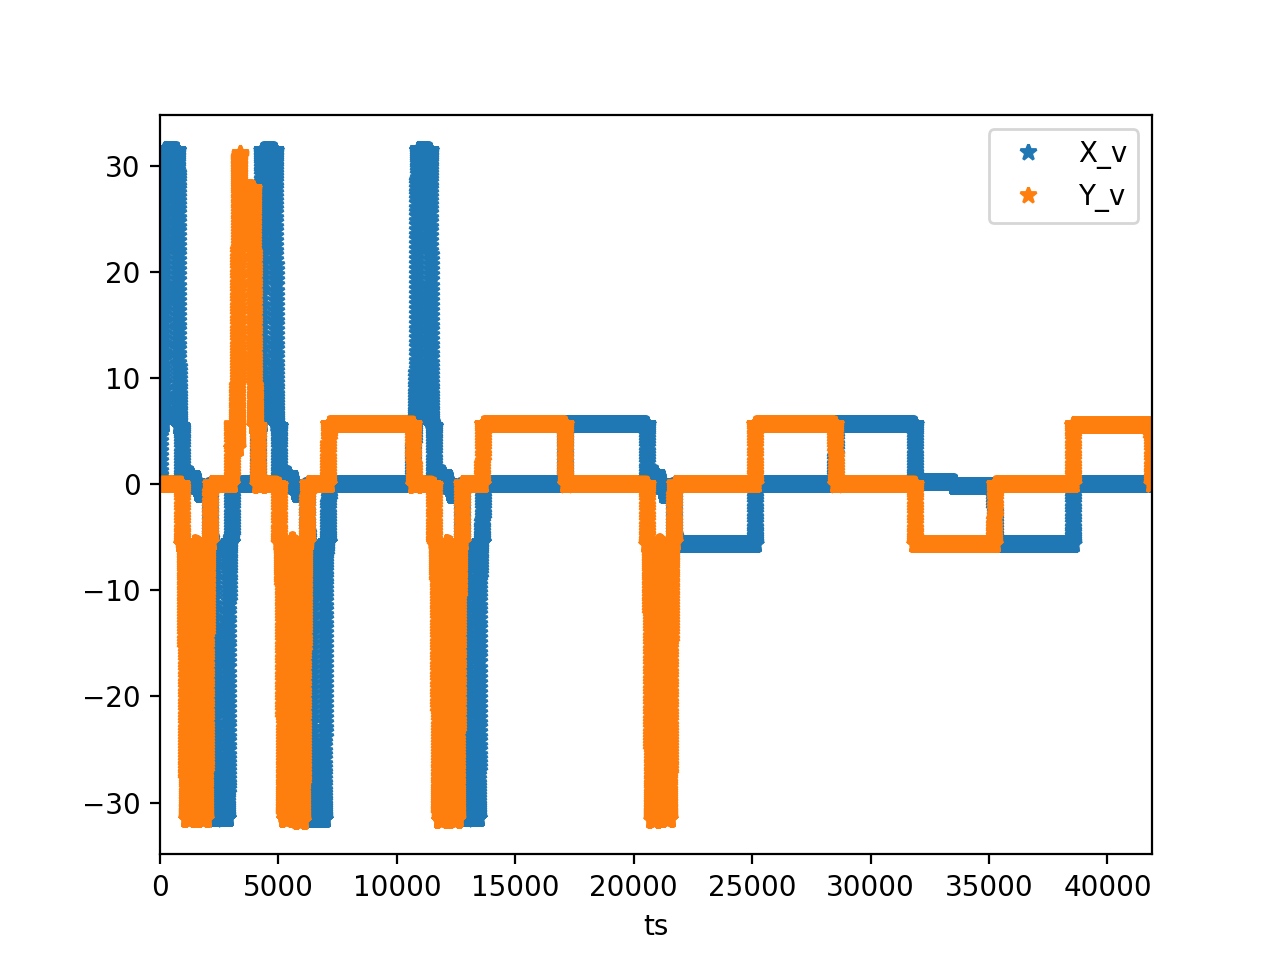

In [267]:
steps_opt = path_planning.emulate(opt_pr_opt, 0)
steps_opt = pd.DataFrame(steps_opt)
steps_opt["full_v"] = np.sqrt(steps_opt["X_v"]*steps_opt["X_v"] + steps_opt["Y_v"]*steps_opt["Y_v"])

#steps_opt.plot(x = "ts", y = ["X_a", "Y_a"], style="*")
steps_opt.plot(x = "ts", y = ["X_v", "Y_v"], style="*")
#steps_opt.plot(x = "ts", y = ["full_v"], style="*")
#steps_opt.plot(x = "ts", y = ["X_x", "Y_x"], style="*")
if 0:
    steps_opt["X_x1"] = steps_opt["X_x"]/80
    steps_opt["Y_x1"] = steps_opt["Y_x"]/80

    steps_opt.plot(x = "X_x1", y = "Y_x1", style="*")

In [4]:
path_deltas = []
l = 100
v = 300

for i in range(0, 5):
    k = 2 - 0.05 * i
    k2 = 2 - 0.05 * (i + 0.5)
    path_deltas.append([   k*l,      0, v])
    path_deltas.append([       0, -k*l, v * 0.7])
    path_deltas.append([ -k2*l,      0, v])
    path_deltas.append([       0, k2*l, v * 0.7])
    

path = [[0,0,0]]
x = 0
y = 0
for dx, dy, speed in path_deltas:
    x += dx
    y += dy
    path.append([x, y, speed])
        
path.append([x, y, 0])
    
SLOW_LIMITS = path_planning.PathLimits(None, None, 3000, 3000, None, None, 0.1)

print("initial path:", path)
pp = path_planning.PathPlanner(path, SLOW_LIMITS)
plan, slowdowns, notes = pp.plan_with_slow_down()

print("********* SPEEDUP ********")
speedup_slowdowns = pp.plan_speedup(slowdowns, notes)
print("speedup slowdowns:", speedup_slowdowns)

plan, errors, notes = pp.plan_path_in_floats(speedup_slowdowns)

pplan = pd.DataFrame()
pplan["x"] = [ a[1] for a in plan ]
pplan["y"] = [ a[2] for a in plan ]
print(pplan["x"])
pplan.plot(x = "x", y = "y", style="*", linestyle='-')


initial path: [[0, 0, 0], [200.0, 0, 300], [200.0, -200.0, 210.0], [2.5, -200.0, 300], [2.5, -2.5, 210.0], [197.5, -2.5, 300], [197.5, -197.5, 210.0], [5.0, -197.5, 300], [5.0, -5.0, 210.0], [195.0, -5.0, 300], [195.0, -195.0, 210.0], [7.5, -195.0, 300], [7.5, -7.5, 210.0], [192.5, -7.5, 300], [192.5, -192.5, 210.0], [10.0, -192.5, 300], [10.0, -10.0, 210.0], [190.0, -10.0, 300], [190.0, -190.0, 210.0], [12.5, -190.0, 300], [12.5, -12.5, 210.0], [12.5, -12.5, 0]]
********* SPEEDUP ********


INFO:valurap.path_planning:plato is less than 3mm


speedup slowdowns: [[[0.1407662366340804, 2.5337922594134423], [1.0, 194.9324154811731], [0.1407662366340804, 2.533792259413451]], [[0.1407662366340804, 1.3164594112743315], [1.0, 197.36708117745135], [0.1407662366340804, 1.3164594112742976]], [[0.1407662366340804, 2.533792259413451], [1.0, 192.4324154811731], [0.1407662366340804, 2.533792259413451]], [[0.1407662366340804, 1.3164594112743315], [1.0, 194.86708117745133], [0.1407662366340804, 1.3164594112743315]], [[0.1407662366340804, 2.5337922594134423], [1.0, 189.9324154811731], [0.1407662366340804, 2.533792259413451]], [[0.1407662366340804, 1.3164594112743402], [1.0, 192.36708117745135], [0.1407662366340804, 1.3164594112742976]], [[0.1407662366340804, 2.533792259413451], [1.0, 187.4324154811731], [0.1407662366340804, 2.533792259413451]], [[0.1407662366340804, 1.3164594112743315], [1.0, 189.86708117745133], [0.1407662366340804, 1.3164594112743315]], [[0.1407662366340804, 2.5337922594134423], [1.0, 184.9324154811731], [0.14076623663408

ValueError: too many values to unpack (expected 3)

ext_per_mm: 0.04989020256921454
initial path: [[0, 0, 0], [200.0, 0, 500], [200.0, -200.0, 350.0], [2.5, -200.0, 500], [2.5, -2.5, 350.0], [197.5, -2.5, 500], [197.5, -197.5, 350.0], [5.0, -197.5, 500], [5.0, -5.0, 350.0], [195.0, -5.0, 500], [195.0, -195.0, 350.0], [7.5, -195.0, 500], [7.5, -7.5, 350.0], [192.5, -7.5, 500], [192.5, -192.5, 350.0], [10.0, -192.5, 500], [10.0, -10.0, 350.0], [190.0, -10.0, 500], [190.0, -190.0, 350.0], [12.5, -190.0, 500], [12.5, -12.5, 350.0], [12.5, -12.5, 0]]


<IPython.core.display.Javascript object>


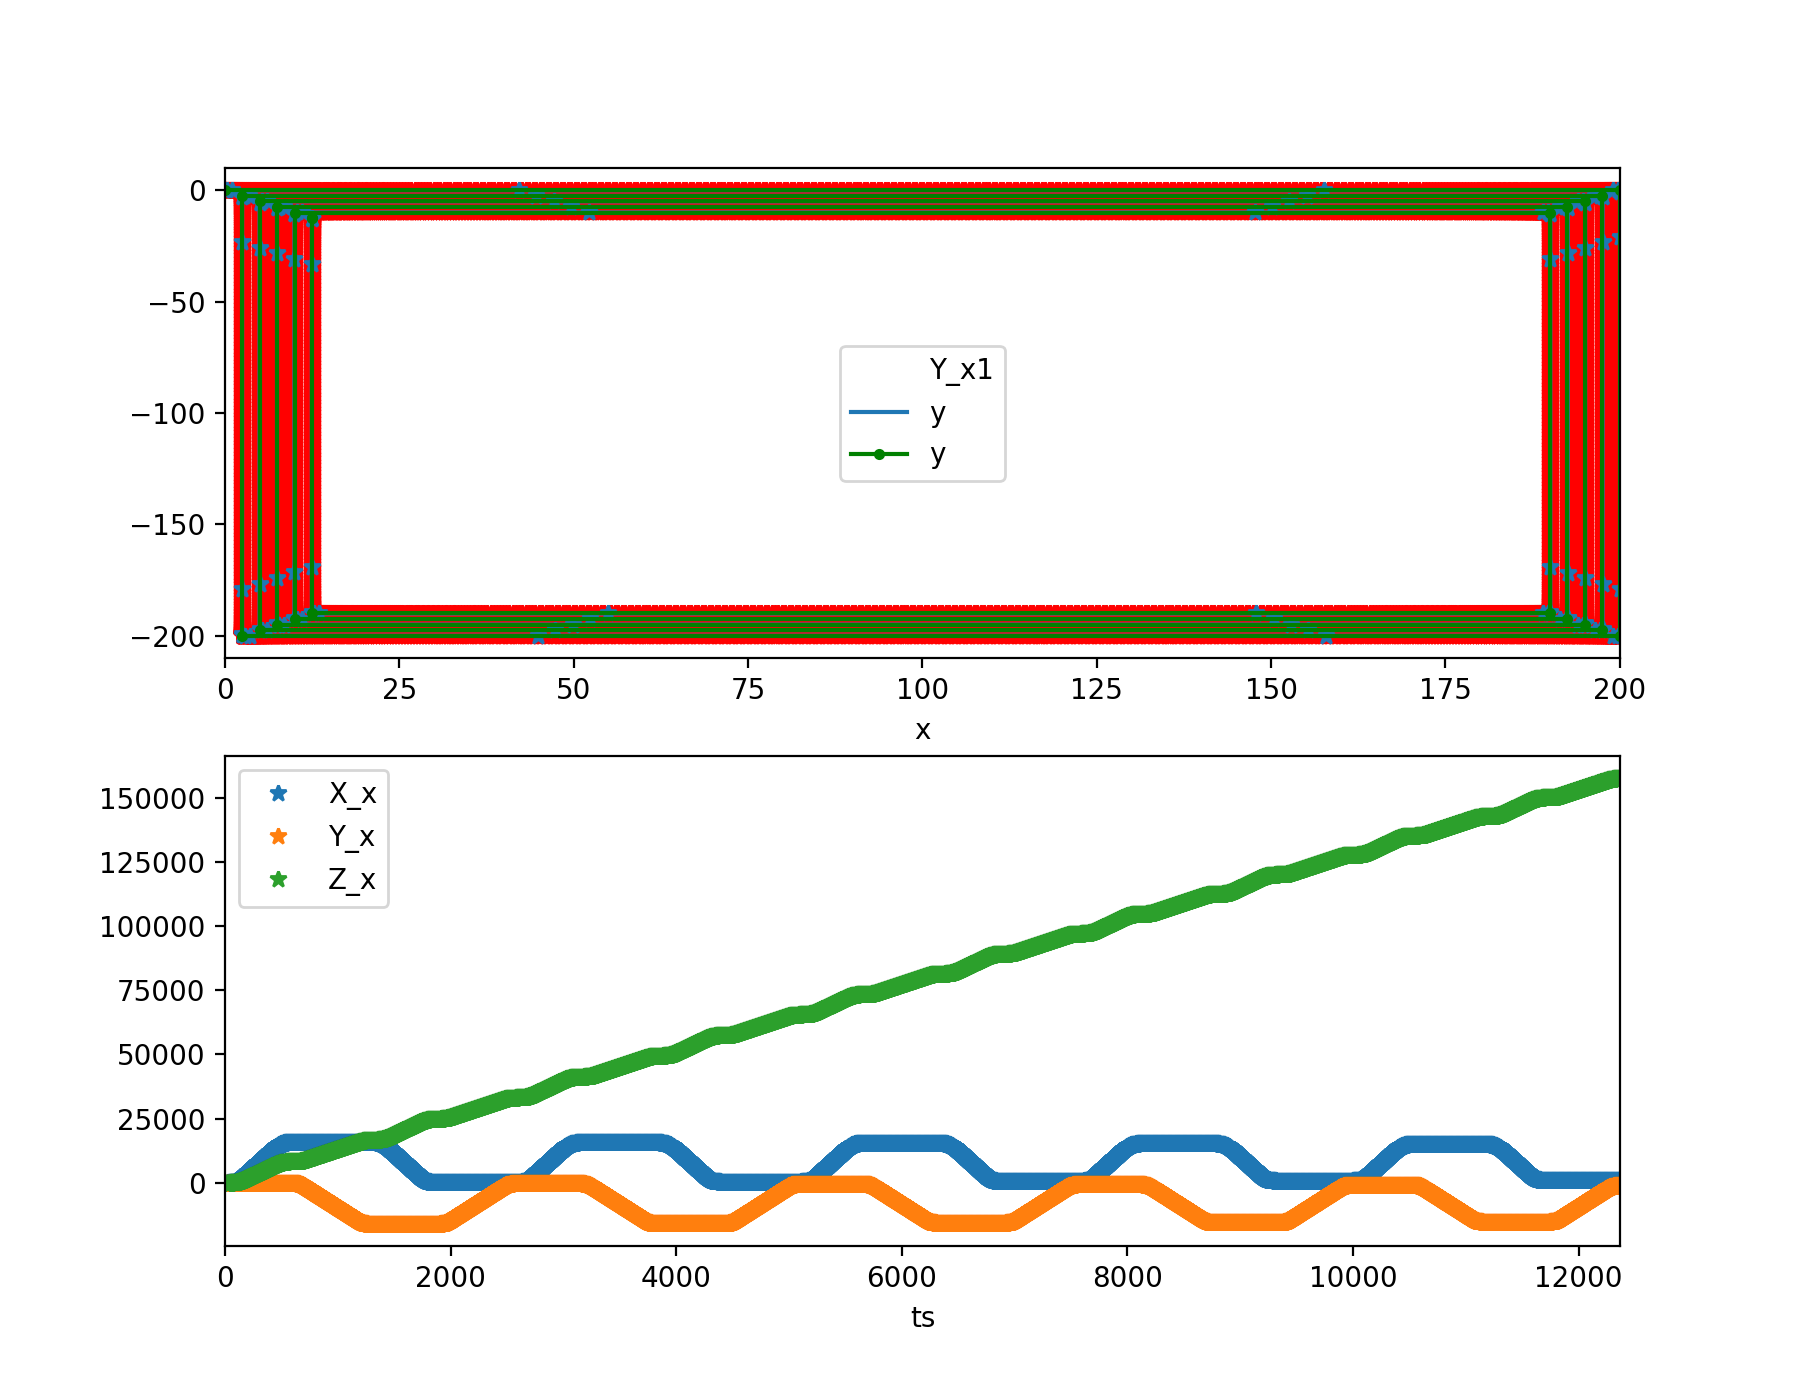

INFO:valurap.path_planning:plato is less than 3mm


accel_t: 14
plato_t: 17
accel_a: 2037711763.451545
accel_j: 582203360.9861557
accel_jj: -83171908.71230796
int_accel_j: 582203363
int_accel_jj: -83171909
      fun: 6554.646079505095
 hess_inv: array([[3.77915750e-06, 5.15751802e-06],
       [5.15751802e-06, 7.05081855e-06]])
      jac: array([-198.10974121,   96.07550049])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 475
      nit: 19
     njev: 116
   status: 2
  success: False
        x: array([0.34881059, 1.69132029])
old 582203363 -83171909
new 602511233 -97238943
int_accel_v: 19433546951 3452.091404021473
int_accel_x: 121977906869 21.667628912247494
int_plato_v: 19344624676 3436.295634884345
e_target: -3.029470008186763e-10
e_delta_v: 4974.083716617548
e_jerk: -1356.8462371826172
accel_t: 14
plato_t: 17
accel_t: 14
plato_t: 17
accel_a: 1063637133.4162135
accel_j: 303896323.83320385
accel_jj: -43413760.54760055
int_accel_j: 303896327
int_accel_jj: -43413761
      fun: 3424.21210213977
 hess

accel_jj: 688206.0683364611
int_accel_j: -52647759
int_accel_jj: 688206
      fun: 44.60910183657455
 hess_inv: array([[3.77844818e-09, 5.99266733e-09],
       [5.99266733e-09, 9.59658404e-09]])
      jac: array([ 670.19165945, -377.37122393])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 450
      nit: 15
     njev: 110
   status: 2
  success: False
        x: array([-0.07638568, -0.01664592])
old -52647759 688206
new -52245606 687060
int_accel_v: -225166907242 -39997.67756859285
int_accel_x: -18524143049058 -3290.5488199222787
int_plato_v: -225173173594 -39998.79069631618
e_target: -1.910120772663504e-08
e_delta_v: 103.87839545914903
e_jerk: -95.616943359375
accel_t: 153
plato_t: 226
accel_t: 153
plato_t: 226
accel_a: 1054904928.0038486
accel_j: 27579213.804022186
accel_jj: -360512.59874538804
int_accel_j: 27579244
int_accel_jj: -360513
      fun: 111.9494070351645
 hess_inv: array([[1.07261273e-11, 1.08317115e-10],
       [1.08317115e-10, 1.22

        x: array([1.81747132, 4.08455345])
old 582203363 -83171909
new 688017154 -117143920
int_accel_v: 19969174134 3547.237905010547
int_accel_x: 133177180136 23.657019478662274
int_plato_v: 19757193479 3509.5825763775674
e_target: 3.3938363230845425e-10
e_delta_v: 11269.384055362665
e_jerk: -3234.568099975586
accel_t: 14
plato_t: 17
accel_a: -1425178817.6785712
accel_j: -407193947.9081632
accel_jj: 58170563.98688046
int_accel_j: -407193948
int_accel_jj: 58170564
      fun: 0.5138079924874279
 hess_inv: array([[3.33822383e-05, 3.72158611e-05],
       [3.72158611e-05, 4.14973048e-05]])
      jac: array([-4768.17255294,  4128.70423209])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 327
      nit: 10
     njev: 79
   status: 2
  success: False
        x: array([-0.66806407,  0.04984803])
old -407193948 58170564
new -379990783 58460533
int_accel_v: 2141724 0.38044660755076615
int_accel_x: 106425714031 18.905004500702205
int_plato_v: 0 0.0
e_target:

      fun: 15626.428442453333
 hess_inv: array([[ 1.21321575e-06, -1.32438223e-07],
       [-1.32438223e-07,  1.46209682e-08]])
      jac: array([ 45.89916992, 215.14770508])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 352
      nit: 7
     njev: 85
   status: 2
  success: False
        x: array([1.91534919, 4.27166343])
old -582203363 83171909
new -693715637 118700149
int_accel_v: -19921268731 -3538.7281959842194
int_accel_x: -133693642719 -23.74876166282291
int_plato_v: -19727264812 -3504.266177145609
e_target: -3.561240191629622e-10
e_delta_v: -10812.70883868786
e_jerk: 2960.264877319336
accel_t: 14
plato_t: 17
accel_a: 1425176959.6071427
accel_j: 407193417.0306122
accel_jj: -58170488.14723031
int_accel_j: 407193416
int_accel_jj: -58170488
      fun: 0.14003615619609233
 hess_inv: array([[4.33636335e-06, 4.69440997e-06],
       [4.69440997e-06, 5.08487531e-06]])
      jac: array([ 2409.61479024, -2146.18540612])
  message: 'Desired error not

      fun: 15723.719159336624
 hess_inv: array([[0.00017901, 0.00034738],
       [0.00034738, 0.00068108]])
      jac: array([ 2745.56469727, -1085.30895996])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 292
      nit: 3
     njev: 70
   status: 2
  success: False
        x: array([1.51454702, 3.51505886])
old 582203363 -83171909
new 670380800 -112407325
int_accel_v: 20088386500 3568.4142751790655
int_accel_x: 131498878875 23.358893286307133
int_plato_v: 19855870552 3527.111145729122
e_target: 2.7398527890909463e-10
e_delta_v: 12775.07669757458
e_jerk: -3547.9118041992188
accel_t: 14
plato_t: 17
accel_a: -1425175635.642857
accel_j: -407193038.75510204
accel_jj: 58170434.10787172
int_accel_j: -407193038
int_accel_jj: 58170434
      fun: 0.12806478586931846
 hess_inv: array([[2.08861165e-06, 2.27580075e-06],
       [2.27580075e-06, 2.48682249e-06]])
      jac: array([ 21.34289446, -15.91125109])
  message: 'Desired error not necessarily achieved d

      fun: 0.1697500046654856
 hess_inv: array([[4.87549449e-05, 5.44078301e-05],
       [5.44078301e-05, 6.07199560e-05]])
      jac: array([-3688.97485373,  3225.47623583])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 603
      nit: 10
     njev: 148
   status: 2
  success: False
        x: array([-0.6668742 ,  0.05107724])
old 407192653 -58170379
new 380038025 -58467497
int_accel_v: -335367 -0.05957314641591437
int_accel_x: -106414897673 -18.903083129551135
int_plato_v: 0 0.0
e_target: 2.2583710935739987
e_delta_v: 0.0
e_jerk: 5.1172943115234375
accel_t: 14
plato_t: 17
accel_a: 320080997.559075
accel_j: 91451713.58830714
accel_jj: -13064530.512615306
int_accel_j: 91451717
int_accel_jj: -13064531
      fun: 100.06642885141807
 hess_inv: array([[3.18587919e-05, 6.26737306e-05],
       [6.26737306e-05, 1.25349327e-04]])
      jac: array([ 36.2911129, -25.0460453])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nf

new -54247082 725491
int_accel_v: 19000641141 3375.1918843805124
int_accel_x: 18624958218231 3308.457191449854
int_plato_v: 19009321975 3376.7339102652722
e_target: 1.342414179816842e-09
e_delta_v: -142.2294700279599
e_jerk: 132.45901489257812
accel_t: 153
plato_t: 17
accel_t: 153
plato_t: 17
accel_a: -1055081253.4717185
accel_j: -27583823.62017565
accel_jj: 360572.8577800738
int_accel_j: -27583834
int_accel_jj: 360573
      fun: 713.0680957104441
 hess_inv: array([[7.67127371e-08, 1.47717900e-07],
       [1.47717900e-07, 2.84810648e-07]])
      jac: array([-83.61897278,  39.99294281])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 429
      nit: 16
     njev: 105
   status: 2
  success: False
        x: array([0.26756863, 0.50505066])
old -27583834 360573
new -28321891 378784
int_accel_v: 9911803602 1760.6900119204736
int_accel_x: 9721843205682 1726.9462669990075
int_plato_v: 9919034312 1761.9744440366956
e_target: -1.494299795012921e-09
e_delta_

      fun: 712.5403530896562
 hess_inv: array([[1.35601985e-07, 2.53724519e-07],
       [2.53724519e-07, 4.75106023e-07]])
      jac: array([-8439.09699249,  4907.83433533])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 376
      nit: 12
     njev: 91
   status: 2
  success: False
        x: array([0.26732778, 0.50467297])
old -27583452 360568
new -28320834 378765
int_accel_v: 9911656887 1760.6639501011043
int_accel_x: 9721843291413 1726.9462822278924
int_plato_v: 9919029262 1761.9735469764917
e_target: -1.3849330571247265e-09
e_delta_v: -125.89492621977115
e_jerk: 112.49351501464844
accel_t: 14
plato_t: 12
accel_a: 2036645383.5
accel_j: 581898681.0
accel_jj: -83128383.0
int_accel_j: 581898681
int_accel_jj: -83128383
      fun: 0.2267366748131728
 hess_inv: array([[2.49656585e-06, 2.71545492e-06],
       [2.71545492e-06, 2.95710269e-06]])
      jac: array([ 0.00582242, -0.00523941])
  message: 'Desired error not necessarily achieved due to precis

      fun: 1268.1874325805643
 hess_inv: array([[2.05544704e-09, 1.03870174e-11],
       [1.03870174e-11, 6.86011929e-11]])
      jac: array([  5.24659729, 245.25656128])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 706
      nit: 15
     njev: 172
   status: 2
  success: False
        x: array([0.20196253, 0.44966627])
old -75278245 1407070
new -76798583 1470341
int_accel_v: -157666653557 -28007.223839132675
int_accel_x: -9151640212888 -1625.657868389396
int_plato_v: -157657240549 -28005.551753018663
e_target: 1.692387741059065e-08
e_delta_v: -476.89195301244035
e_jerk: 143.631103515625
accel_t: 107
plato_t: 395
accel_a: 1056855420.9963741
accel_j: 39508613.86902333
accel_jj: -738478.7639069782
int_accel_j: 39508626
int_accel_jj: -738479
      fun: 876.0945450608436
 hess_inv: array([[ 2.06251734e-11, -8.84880140e-12],
       [-8.84880140e-12,  3.26794675e-10]])
      jac: array([ -19.70291138, -191.34454346])
  message: 'Desired error not nece

int_accel_v: 82310861748 14621.346222298824
int_accel_x: 4779449292372 849.0007439071688
int_plato_v: 82302245137 14619.815604710593
e_target: 1.6993908502627164e-08
e_delta_v: 384.89453010773286
e_jerk: -131.4790496826172
accel_t: 107
plato_t: 12
accel_t: 107
plato_t: 12
accel_a: -2023563239.651167
accel_j: -75647223.91219315
accel_jj: 1413966.8020970682
int_accel_j: -75647234
int_accel_jj: 1413967
      fun: 1785.1884169585317
 hess_inv: array([[ 1.08080944e-13, -1.63706669e-13],
       [-1.63706669e-13,  6.33574469e-11]])
      jac: array([ 88.77557373, 186.44187927])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 524
      nit: 15
     njev: 128
   status: 2
  success: False
        x: array([0.33709397, 0.65689146])
old -75647234 1413967
new -78197257 1506849
int_accel_v: 13290840601 2360.9275602964885
int_accel_x: 9124957519526 1620.9180699046753
int_plato_v: 13301638282 2362.8456137458898
e_target: -7.973994797794148e-10
e_delta_v: -174.131

In [24]:
import math

path_deltas = []
l = 100
v = 500

for i in range(0, 5):
    k = 2 - 0.05 * i
    k2 = 2 - 0.05 * (i + 0.5)
    path_deltas.append([   k*l,      0, v])
    path_deltas.append([       0, -k*l, v * 0.7])
    path_deltas.append([ -k2*l,      0, v])
    path_deltas.append([       0, k2*l, v * 0.7])

ext_per_mm = 1.0 * 0.4 * 0.3 / (math.pi * 1.75 * 1.75 / 4)
print("ext_per_mm:", ext_per_mm)

extras = [0]
ext = 0
for x, y, v in path_deltas:
    ext += ext_per_mm * math.sqrt(x*x + y*y)
    extras.append(ext)

extras.append(ext)

path = [[0,0,0]]
x = 0
y = 0
for dx, dy, speed in path_deltas:
    x += dx
    y += dy
    path.append([x, y, speed])
        
path.append([x, y, 0])
    
SLOW_LIMITS = path_planning.PathLimits(None, None, 3000, 3000, None, None, 0.1)

print("initial path:", path)

fig, (ax, ax2) = plt.subplots(figsize=(9, 7), nrows=2, ncols=1)

pp = path_planning.PathPlanner(path, SLOW_LIMITS, extras=[["E", 837, extras]])
int_plan = pp.plan()
print(int_plan)
pr_opt = pp.format(int_plan)

steps_opt = path_planning.emulate(pr_opt, 0)
steps_opt = pd.DataFrame(steps_opt)
steps_opt["full_v"] = np.sqrt(steps_opt["X_v"]*steps_opt["X_v"] + steps_opt["Y_v"]*steps_opt["Y_v"])

#steps_opt.plot(x = "ts", y = ["X_a", "Y_a"], style="*")
#steps_opt.plot(x = "ts", y = ["X_v", "Y_v"], style="*", ax=ax)
#steps_opt.plot(x = "ts", y = ["full_v"], style="*", ax=ax)
steps_opt.plot(x = "ts", y = ["X_x", "Y_x", "Z_x"], style="*", ax=ax2)

if 1:
    steps_opt["X_x1"] = steps_opt["X_x"]/80
    steps_opt["Y_x1"] = steps_opt["Y_x"]/80

    steps_opt.plot(x = "X_x1", y = "Y_x1", style="*", color="red", ax=ax)
    

x = 0
y = 0
z = 0
t = 0
iplan = [[x,y,z, t]]
for px, py, pz in int_plan:
    x += px["accel_x"]
    y += py["accel_x"]
    z += pz["accel_x"]
    t += py["accel_t"]
    iplan.append([x,y,z,t])
    x += px["plato_x"]
    y += py["plato_x"]
    z += pz["plato_x"]
    t += py["plato_t"]
    iplan.append([x,y,z,t])
        
if 1:
    iplan_df = pd.DataFrame()
    iplan_df["x"] = [ a[0] for a in iplan ]
    iplan_df["y"] = [ a[1] for a in iplan ]
    iplan_df["z"] = [ a[2] for a in iplan ]
    iplan_df["t"] = [ a[3]/1000 for a in iplan ]
    iplan_df.plot(x = "x", y = "y", style="*", linestyle='-', ax=ax)
    #iplan_df.plot(x = "t", y = ["x", "y"], style="*", linestyle='-', ax=ax)

    
if 0:
    pplan = pd.DataFrame()
    pplan["x"] = [ a[1] for a in plan ]
    pplan["y"] = [ a[2] for a in plan ]
    print(pplan["x"])
    pplan.plot(x = "x", y = "y", style=".", linestyle='.-')

if 1:
    pplan = pd.DataFrame()
    pplan["x"] = [ a[0] for a in path ]
    pplan["y"] = [ a[1] for a in path ]
    pplan.plot(x = "x", y = "y", style=".", linestyle='-', color='green', ax=ax)
